In [ ]:
# import sys
# !{sys.executable} -m pip install imbalanced-learn --user
# !{sys.executable} -m pip install hyperopt --user

In [1]:
import numpy
from time import time
from sklearn.model_selection import GridSearchCV
from hyperopt import tpe, fmin, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from copy import deepcopy

from newsgac import config
from newsgac.genres import genre_codes
from newsgac.learners import learners, LearnerSVC, LearnerNB, LearnerXGB, LearnerGB, LearnerMLP, LearnerRF, LearnerLGBM
from newsgac.pipelines.get_sk_pipeline import get_sk_pipeline
from newsgac.pipelines.utils import report
from sklearn.neural_network import MLPClassifier

from newsgac import database
from newsgac.data_sources import DataSource
from newsgac.pipelines import Pipeline

# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
# from imblearn.combine import SMOTEENN, SMOTETomek
import numpy as np
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/newsgac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
[d.display_title for d in DataSource.objects.all()]

[u'N2BGS Training',
 u'N2BGS Testing',
 u'Linked NRC (2930)',
 u'BOW + 5 features (N2BGS train)',
 u'BOW + 5 features (N2BGS test)',
 u'nrc-1950-1994-a.txt',
 u'nrc-1950-1994-b.txt',
 u'nrc-1950-1994-c.txt',
 u'nrc-1950-1994-d.txt',
 u'nrc-1950-1994-e.txt',
 u'telegraaf-1950-1994-a.txt',
 u'telegraaf-1950-1994-b.txt',
 u'telegraaf-1950-1994-c.txt',
 u'telegraaf-1950-1994-d.txt',
 u'telegraaf-1950-1994-e.txt',
 u'volkskrant-1950-1995-a.txt',
 u'volkskrant-1950-1995-b.txt',
 u'volkskrant-1950-1995-c.txt',
 u'volkskrant-1950-1995-d.txt',
 u'volkskrant-1950-1995-e.txt',
 u'nrc-1965.txt',
 u'nrc-1985.txt',
 u'BOW + 9 features (N2BGS train)',
 u'BOW + 9 features (N2BGS test)',
 u'Linked NRC (2930/9 features)',
 u'BOW Train unique (9 features)',
 u'BOW Test unique (9 features)',
 u'Linked NRC (unique/9 features)',
 u'BOW Train unique (N3BGS/9 features)',
 u'N3BGS FROG Test',
 u'N3BGS FROG Train',
 u'BOW Test unique (N3BGS/9 features)',
 u'BOW Test unique (N3BGS/9 features/collapsed)',
 u'Link

In [3]:
[d.display_title for d in Pipeline.objects.all()]

[u'dummy frog',
 u'dummy bow',
 u'RF FROG',
 u'SVC FROG',
 u'XGB FROG',
 u'NB FROG',
 u'MLP FROG',
 u'RF BOW',
 u'SVC BOW',
 u'XGB BOW',
 u'NB BOW',
 u'MLP BOW',
 u'SVC LIN BOW',
 u'Erik MLP BOW (with stop-words)',
 u'Erik MLP BOW (5 features) ',
 u'Erik MLP BOW (9 features) ',
 u'Erik SVC BOW (9 features)',
 u'Erik RF BOW (9 features)',
 u'Erik XGB BOW (9 features)',
 u'Erik NB BOW (9 features)',
 u'Erik MLP unique 9 features',
 u'Erik NB unique (9 features)',
 u'Erik XGB unique (9 features)',
 u'Erik SVC unique (9 features)',
 u'Erik RF unique (9 features)',
 u'N3BGS MLP unique 9 features',
 u'N3BGS NB unique 9 features ',
 u'N3BGS SVC unique 9 features ',
 u'N3BGS RF unique 9 features',
 u'N3BGS XGB unique 9 features ',
 u'dummy n3bgs bow',
 u'dummy n3bgs frog',
 u'RF FROG N3BGS',
 u'SVC FROG N3BGS',
 u'XGB FROG N3BGS',
 u'Erik NB N3BGS Collapsed',
 u'Erik MLP N3BGS Collapsed',
 u'Erik MLP Linked NRC (2930 articles)',
 u'Erik RF Linked NRC (2930 articles) ',
 u'Erik NB Linked NRC (2

In [4]:
p = Pipeline.objects.all()[60]
print 'Pipeline: ' + p.display_title
print 'DataSource: ' + p.data_source.display_title
print 'NLP Tool: ' + p.nlp_tool.name
print 'Classifier: ' + p.learner.name
print 'Task status: ' + str(p.task.status)

Pipeline: new dummy ugs opt
DataSource: 20190228 unbalanced train size=3443
NLP Tool: Frog + TFIDF
Classifier: Support Vector
Task status: Status.SUCCESS


In [5]:
len(p.data_source.articles)

3099

In [6]:
test_data_source = DataSource.objects.all()[39]
print 'Testing data source: ' + test_data_source.display_title

Testing data source: 20190228 unbalanced test size=3443


In [7]:
skp = p.get_sk_pipeline()
skp_opt = deepcopy(skp)
skp_opt.steps.pop()
skp_opt.steps

[('CleanOCR', <newsgac.nlp_tools.transformers.CleanOCR at 0x7ff264590290>),
 ('StopWordRemoval',
  <newsgac.nlp_tools.transformers.StopWordRemoval at 0x7ff264590490>),
 ('FeatureExtraction', FeatureUnion(n_jobs=None,
         transformer_list=[('frog', FeatureUnion(n_jobs=None,
         transformer_list=[('Basic', <newsgac.nlp_tools.transformers.ExtractBasicFeatures object at 0x7ff26463be10>), ('Quote', <newsgac.nlp_tools.transformers.ExtractQuotes object at 0x7ff26463be50>), ('Sentiment', Pipeline(memory=None,
       steps=...\b', tokenizer=None, use_idf=True,
          vocabulary=None))]))],
         transformer_weights=None))],
         transformer_weights=None)),
 ('RobustScaler',
  RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=False,
         with_scaling=True))]

In [8]:
texts = numpy.array([article.raw_text for article in p.data_source.articles])
labels = numpy.array([article.label for article in p.data_source.articles])

X = skp_opt.fit_transform(texts)

In [9]:
# get the test dataset for optimization accuracy
texts_test = numpy.array([article.raw_text for article in test_data_source.articles])
labels_test = numpy.array([article.label for article in test_data_source.articles])

X_test = skp_opt.transform(texts_test)

In [10]:
X_train = X
y_train = labels
y_test = labels_test

In [11]:
y_test.shape

(344,)

In [12]:
# hidden_layer_sizes_list =[(200, 100), (100, 200), (150, 300), (300, 100), (100, 200, 100), (200,100,200)]
hidden_layer_sizes_list =[(20, 30), (30, 10), (10, 20), (5,10)]
activation_list = ['identity', 'logistic', 'tanh', 'relu']
solver_list = ['lbfgs','sgd', 'adam']
learning_rate_list = ['constant','adaptive', 'invscaling']
batch_size_list = np.arange(20, 200, dtype=int)
max_iter_list = np.arange(20, 500, dtype=int)

In [13]:
def optimize(evals, trials, optimizer=tpe.suggest):
    space = {
        'hidden_layer_sizes': hp.choice('hidden_layer_sizes', hidden_layer_sizes_list),
        'activation': hp.choice('activation', activation_list),
        'solver': hp.choice('solver', solver_list),
        'alpha': hp.lognormal('alpha', 0, 1), # [0.0001, 0.05],
#         'alpha': hp.loguniform('alpha', np.log(0.1), np.log(10)),
        'learning_rate': hp.choice('learning_rate', learning_rate_list),
        'batch_size': hp.choice('batch_size', batch_size_list),
        'max_iter': hp.choice('max_iter', max_iter_list),
    }
    best = fmin(score, space, algo=optimizer, max_evals=evals, trials=trials)
    pbar.close()
    return best

In [14]:
train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

def score(params):
     
    model = MLPClassifier(
            hidden_layer_sizes = params['hidden_layer_sizes'],
            activation = params['activation'],
            solver = params['solver'],
            alpha = params['alpha'],
            learning_rate = params['learning_rate'],
            batch_size = params['batch_size'],
            max_iter = params['max_iter'],
            shuffle = True,
            random_state = 42,
            warm_start = False,
            early_stopping = True,
            validation_fraction = 0.1,
    )

    model.fit(X_train, y_train)   

    train_acc = accuracy_score(y_train, model.predict(X_train))
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    test_loss = log_loss(y_test, model.predict_proba(X_test))
    
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)
    
    print('Parameters with this training accuracy {} and loss {} :'.format(train_acc, train_loss))
    print('Parameters with this testing accuracy {} and loss {} :'.format(test_acc, test_loss))
    print(params)
    pbar.update()
#     return {'loss': test_loss, 'status': STATUS_OK}
    return {'loss': -test_acc, 'status': STATUS_OK}

In [15]:
import time
from tqdm import tqdm

trials = Trials()
cores = 48
start = time.time()
evaluations = 1000
pbar = tqdm(total=evaluations, desc="Hyperopt")
best_param = optimize(evals=evaluations,
                      optimizer=tpe.suggest,
                      trials=trials)
print("------------------------------------")
print("The best hyperparameters are: ", "\n")
print(best_param)
end = time.time()
print('Time elapsed to optimize {0} executions: {1}'.format(evaluations, end - start))
best_param['hidden_layer_sizes'] = hidden_layer_sizes_list[best_param['hidden_layer_sizes']]
best_param['activation'] = activation_list[best_param['activation']]
best_param['solver'] = solver_list[best_param['solver']]
best_param['learning_rate'] = learning_rate_list[best_param['learning_rate']]
best_param['batch_size'] = batch_size_list[best_param['batch_size']]
best_param['max_iter'] = max_iter_list[best_param['max_iter']]
print('\n Best score:')
score(best_param)

Hyperopt:   0%|          | 0/1000 [00:00<?, ?it/s]


  0%|          | 0/1000 [00:00<?, ?it/s, best loss: ?]
Parameters with this training accuracy 0.611487576638 and loss 1.21768094764 :

  0%|          | 0/1000 [00:16<?, ?it/s, best loss: ?]
Parameters with this testing accuracy 0.578488372093 and loss 1.33392926448 :

  0%|          | 0/1000 [00:16<?, ?it/s, best loss: ?]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 0.7402590475847444, 'activation': 'relu', 'max_iter': 496, 'learning_rate': 'adaptive', 'batch_size': 85}

  0%|          | 0/1000 [00:16<?, ?it/s, best loss: ?]

Hyperopt:   0%|          | 1/1000 [00:17<4:47:17, 17.26s/it]


  0%|          | 1/1000 [00:16<4:40:52, 16.87s/it, best loss: -0.578488372093]
Parameters with this training accuracy 0.487253952888 and loss 1.8927647651 :

  0%|          | 1/1000 [00:36<4:40:52, 16.87s/it, best loss: -0.578488372093]
Parameters with this testing accuracy 0.497093023256 and loss 1.90043390126 :

  0%|          | 1/1000 [00:36<4:40:52, 16.87s/it, best loss: -0.578488372093]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 0.6495690976532331, 'activation': 'relu', 'max_iter': 134, 'learning_rate': 'adaptive', 'batch_size': 150}

  0%|          | 1/1000 [00:36<4:40:52, 16.87s/it, best loss: -0.578488372093]

Hyperopt:   0%|          | 2/1000 [00:36<4:56:46, 17.84s/it]


  0%|          | 2/1000 [00:36<4:52:16, 17.57s/it, best loss: -0.578488372093]
Parameters with this training accuracy 0.437560503388 and loss 2.31730494824 :

  0%|          | 2/1000 [00:40<4:52:16, 17.57s/it, best loss: -0.578488372093]
Parameters with this testing accuracy 0.421511627907 and loss 2.33303428713 :

  0%|          | 2/1000 [00:40<4:52:16, 17.57s/it, best loss: -0.578488372093]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 1.3451846549504114, 'activation': 'tanh', 'max_iter': 486, 'learning_rate': 'invscaling', 'batch_size': 108}

  0%|          | 2/1000 [00:40<4:52:16, 17.57s/it, best loss: -0.578488372093]

Hyperopt:   0%|          | 3/1000 [00:40<3:47:33, 13.69s/it]


  0%|          | 3/1000 [00:40<3:44:24, 13.51s/it, best loss: -0.578488372093]
Parameters with this training accuracy 0.458212326557 and loss 2.14453783461 :

  0%|          | 3/1000 [00:45<3:44:24, 13.51s/it, best loss: -0.578488372093]
Parameters with this testing accuracy 0.479651162791 and loss 2.12381289764 :

  0%|          | 3/1000 [00:45<3:44:24, 13.51s/it, best loss: -0.578488372093]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 0.9253657468042343, 'activation': 'identity', 'max_iter': 224, 'learning_rate': 'invscaling', 'batch_size': 125}

  0%|          | 3/1000 [00:45<3:44:24, 13.51s/it, best loss: -0.578488372093]

Hyperopt:   0%|          | 4/1000 [00:45<3:05:55, 11.20s/it]


  0%|          | 4/1000 [00:45<3:03:43, 11.07s/it, best loss: -0.578488372093]
Parameters with this training accuracy 0.578251048725 and loss 1.39566957929 :

  0%|          | 4/1000 [00:55<3:03:43, 11.07s/it, best loss: -0.578488372093]
Parameters with this testing accuracy 0.540697674419 and loss 1.43765792573 :

  0%|          | 4/1000 [00:55<3:03:43, 11.07s/it, best loss: -0.578488372093]
{'solver': 'adam', 'hidden_layer_sizes': (5, 10), 'alpha': 0.4009789036297661, 'activation': 'tanh', 'max_iter': 256, 'learning_rate': 'adaptive', 'batch_size': 34}

  0%|          | 4/1000 [00:55<3:03:43, 11.07s/it, best loss: -0.578488372093]

Hyperopt:   0%|          | 5/1000 [00:55<2:57:50, 10.72s/it]


  0%|          | 5/1000 [00:55<2:56:18, 10.63s/it, best loss: -0.578488372093]
Parameters with this training accuracy 0.528880283963 and loss 1.63638584261 :

  0%|          | 5/1000 [01:08<2:56:18, 10.63s/it, best loss: -0.578488372093]
Parameters with this testing accuracy 0.523255813953 and loss 1.63054704007 :

  0%|          | 5/1000 [01:08<2:56:18, 10.63s/it, best loss: -0.578488372093]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 4.049410754777338, 'activation': 'tanh', 'max_iter': 407, 'learning_rate': 'invscaling', 'batch_size': 55}

  0%|          | 5/1000 [01:08<2:56:18, 10.63s/it, best loss: -0.578488372093]

Hyperopt:   1%|          | 6/1000 [01:08<3:10:31, 11.50s/it]


  1%|          | 6/1000 [01:08<3:09:26, 11.44s/it, best loss: -0.578488372093]
Parameters with this training accuracy 0.585995482414 and loss 1.33420786652 :

  1%|          | 6/1000 [02:13<3:09:26, 11.44s/it, best loss: -0.578488372093]
Parameters with this testing accuracy 0.56976744186 and loss 1.3875897515 :

  1%|          | 6/1000 [02:13<3:09:26, 11.44s/it, best loss: -0.578488372093]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 0.8721182402067303, 'activation': 'relu', 'max_iter': 186, 'learning_rate': 'invscaling', 'batch_size': 44}

  1%|          | 6/1000 [02:13<3:09:26, 11.44s/it, best loss: -0.578488372093]

Hyperopt:   1%|          | 7/1000 [02:13<7:35:09, 27.50s/it]


  1%|          | 7/1000 [02:13<7:34:24, 27.46s/it, best loss: -0.578488372093]
Parameters with this training accuracy 0.49241690868 and loss 1.66893628233 :

  1%|          | 7/1000 [02:17<7:34:24, 27.46s/it, best loss: -0.578488372093]
Parameters with this testing accuracy 0.5 and loss 1.67083618875 :

  1%|          | 7/1000 [02:17<7:34:24, 27.46s/it, best loss: -0.578488372093]
{'solver': 'adam', 'hidden_layer_sizes': (5, 10), 'alpha': 10.307589482063232, 'activation': 'identity', 'max_iter': 281, 'learning_rate': 'invscaling', 'batch_size': 102}

  1%|          | 7/1000 [02:17<7:34:24, 27.46s/it, best loss: -0.578488372093]

Hyperopt:   1%|          | 8/1000 [02:18<5:41:15, 20.64s/it]


  1%|          | 8/1000 [02:17<5:40:44, 20.61s/it, best loss: -0.578488372093]
Parameters with this training accuracy 0.432720232333 and loss 2.39959612413 :

  1%|          | 8/1000 [02:20<5:40:44, 20.61s/it, best loss: -0.578488372093]
Parameters with this testing accuracy 0.468023255814 and loss 2.3684749359 :

  1%|          | 8/1000 [02:20<5:40:44, 20.61s/it, best loss: -0.578488372093]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 0.24608017334434037, 'activation': 'identity', 'max_iter': 364, 'learning_rate': 'invscaling', 'batch_size': 199}

  1%|          | 8/1000 [02:20<5:40:44, 20.61s/it, best loss: -0.578488372093]

Hyperopt:   1%|          | 9/1000 [02:20<4:11:43, 15.24s/it]


  1%|          | 9/1000 [02:20<4:11:21, 15.22s/it, best loss: -0.578488372093]
Parameters with this training accuracy 0.832526621491 and loss 0.589208869605 :

  1%|          | 9/1000 [02:45<4:11:21, 15.22s/it, best loss: -0.578488372093]
Parameters with this testing accuracy 0.607558139535 and loss 1.27496268373 :

  1%|          | 9/1000 [02:45<4:11:21, 15.22s/it, best loss: -0.578488372093]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 2.0016197692770867, 'activation': 'logistic', 'max_iter': 222, 'learning_rate': 'invscaling', 'batch_size': 105}

  1%|          | 9/1000 [02:45<4:11:21, 15.22s/it, best loss: -0.578488372093]

Hyperopt:   1%|          | 10/1000 [02:46<5:01:19, 18.26s/it]


  1%|          | 10/1000 [02:45<5:01:03, 18.25s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.569861245563 and loss 1.43236595521 :

  1%|          | 10/1000 [03:06<5:01:03, 18.25s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.561046511628 and loss 1.45180777381 :

  1%|          | 10/1000 [03:06<5:01:03, 18.25s/it, best loss: -0.607558139535]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 1.4419836037658804, 'activation': 'relu', 'max_iter': 116, 'learning_rate': 'constant', 'batch_size': 94}

  1%|          | 10/1000 [03:06<5:01:03, 18.25s/it, best loss: -0.607558139535]

Hyperopt:   1%|          | 11/1000 [03:06<5:11:08, 18.88s/it]


  1%|          | 11/1000 [03:06<5:10:58, 18.87s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.543723781865 and loss 1.57138087896 :

  1%|          | 11/1000 [03:09<5:10:58, 18.87s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.546511627907 and loss 1.56983882735 :

  1%|          | 11/1000 [03:09<5:10:58, 18.87s/it, best loss: -0.607558139535]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 0.3670973915806631, 'activation': 'identity', 'max_iter': 32, 'learning_rate': 'adaptive', 'batch_size': 133}

  1%|          | 11/1000 [03:09<5:10:58, 18.87s/it, best loss: -0.607558139535]

/opt/conda/envs/py27/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (32) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)

Hyperopt:   1%|          | 12/1000 [03:09<3:53:55, 14.21s/it]


  1%|          | 12/1000 [03:09<3:53:48, 14.20s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.484995159729 and loss 1.75871768153 :

  1%|          | 12/1000 [03:22<3:53:48, 14.20s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.494186046512 and loss 1.76064748726 :

  1%|          | 12/1000 [03:22<3:53:48, 14.20s/it, best loss: -0.607558139535]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 15.504110279750494, 'activation': 'relu', 'max_iter': 81, 'learning_rate': 'adaptive', 'batch_size': 160}

  1%|          | 12/1000 [03:22<3:53:48, 14.20s/it, best loss: -0.607558139535]

/opt/conda/envs/py27/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (81) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)

Hyperopt:   1%|▏         | 13/1000 [03:23<3:50:16, 14.00s/it]


  1%|▏         | 13/1000 [03:22<3:50:11, 13.99s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.792513714101 and loss 0.64665120817 :

  1%|▏         | 13/1000 [03:29<3:50:11, 13.99s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.627906976744 and loss 1.37368286425 :

  1%|▏         | 13/1000 [03:29<3:50:11, 13.99s/it, best loss: -0.607558139535]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.7211886638941019, 'activation': 'relu', 'max_iter': 167, 'learning_rate': 'constant', 'batch_size': 52}

  1%|▏         | 13/1000 [03:29<3:50:11, 13.99s/it, best loss: -0.607558139535]

Hyperopt:   1%|▏         | 14/1000 [03:29<3:12:45, 11.73s/it]


  1%|▏         | 14/1000 [03:29<3:12:42, 11.73s/it, best loss: -0.627906976744]
Parameters with this training accuracy 0.431106808648 and loss 2.60242136797 :

  1%|▏         | 14/1000 [03:32<3:12:42, 11.73s/it, best loss: -0.627906976744]
Parameters with this testing accuracy 0.468023255814 and loss 2.58885666348 :

  1%|▏         | 14/1000 [03:32<3:12:42, 11.73s/it, best loss: -0.627906976744]
{'solver': 'sgd', 'hidden_layer_sizes': (5, 10), 'alpha': 2.2867845668347857, 'activation': 'logistic', 'max_iter': 168, 'learning_rate': 'adaptive', 'batch_size': 158}

  1%|▏         | 14/1000 [03:32<3:12:42, 11.73s/it, best loss: -0.627906976744]

Hyperopt:   2%|▏         | 15/1000 [03:33<2:31:49,  9.25s/it]


  2%|▏         | 15/1000 [03:32<2:31:47,  9.25s/it, best loss: -0.627906976744]
Parameters with this training accuracy 0.431106808648 and loss 2.26353154251 :

  2%|▏         | 15/1000 [03:34<2:31:47,  9.25s/it, best loss: -0.627906976744]
Parameters with this testing accuracy 0.468023255814 and loss 2.25397508102 :

  2%|▏         | 15/1000 [03:34<2:31:47,  9.25s/it, best loss: -0.627906976744]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 0.14059179023086746, 'activation': 'logistic', 'max_iter': 294, 'learning_rate': 'adaptive', 'batch_size': 126}

  2%|▏         | 15/1000 [03:34<2:31:47,  9.25s/it, best loss: -0.627906976744]

Hyperopt:   2%|▏         | 16/1000 [03:35<1:55:09,  7.02s/it]


  2%|▏         | 16/1000 [03:34<1:55:07,  7.02s/it, best loss: -0.627906976744]
Parameters with this training accuracy 0.872216844143 and loss 0.394611405342 :

  2%|▏         | 16/1000 [03:42<1:55:07,  7.02s/it, best loss: -0.627906976744]
Parameters with this testing accuracy 0.613372093023 and loss 1.96190099962 :

  2%|▏         | 16/1000 [03:42<1:55:07,  7.02s/it, best loss: -0.627906976744]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.2852949858075051, 'activation': 'identity', 'max_iter': 174, 'learning_rate': 'adaptive', 'batch_size': 189}

  2%|▏         | 16/1000 [03:42<1:55:07,  7.02s/it, best loss: -0.627906976744]

Hyperopt:   2%|▏         | 17/1000 [03:42<1:58:10,  7.21s/it]


  2%|▏         | 17/1000 [03:42<1:58:09,  7.21s/it, best loss: -0.627906976744]
Parameters with this training accuracy 0.431106808648 and loss 2.6675647579 :

  2%|▏         | 17/1000 [03:43<1:58:09,  7.21s/it, best loss: -0.627906976744]
Parameters with this testing accuracy 0.468023255814 and loss 2.65852299786 :

  2%|▏         | 17/1000 [03:43<1:58:09,  7.21s/it, best loss: -0.627906976744]
{'solver': 'sgd', 'hidden_layer_sizes': (5, 10), 'alpha': 0.6897890269706651, 'activation': 'logistic', 'max_iter': 330, 'learning_rate': 'constant', 'batch_size': 94}

  2%|▏         | 17/1000 [03:43<1:58:09,  7.21s/it, best loss: -0.627906976744]

Hyperopt:   2%|▏         | 18/1000 [03:43<1:27:22,  5.34s/it]


  2%|▏         | 18/1000 [03:43<1:27:21,  5.34s/it, best loss: -0.627906976744]
Parameters with this training accuracy 0.615682478219 and loss 1.29173544224 :

  2%|▏         | 18/1000 [03:46<1:27:21,  5.34s/it, best loss: -0.627906976744]
Parameters with this testing accuracy 0.572674418605 and loss 1.39552366468 :

  2%|▏         | 18/1000 [03:46<1:27:21,  5.34s/it, best loss: -0.627906976744]
{'solver': 'adam', 'hidden_layer_sizes': (5, 10), 'alpha': 0.7424261941848725, 'activation': 'tanh', 'max_iter': 93, 'learning_rate': 'adaptive', 'batch_size': 177}

  2%|▏         | 18/1000 [03:46<1:27:21,  5.34s/it, best loss: -0.627906976744]

Hyperopt:   2%|▏         | 19/1000 [03:46<1:17:19,  4.73s/it]


  2%|▏         | 19/1000 [03:46<1:17:19,  4.73s/it, best loss: -0.627906976744]
Parameters with this training accuracy 0.514682155534 and loss 1.61082651273 :

  2%|▏         | 19/1000 [04:12<1:17:19,  4.73s/it, best loss: -0.627906976744]
Parameters with this testing accuracy 0.508720930233 and loss 1.61083927443 :

  2%|▏         | 19/1000 [04:12<1:17:19,  4.73s/it, best loss: -0.627906976744]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 1.9842854160134533, 'activation': 'relu', 'max_iter': 182, 'learning_rate': 'constant', 'batch_size': 34}

  2%|▏         | 19/1000 [04:12<1:17:19,  4.73s/it, best loss: -0.627906976744]

Hyperopt:   2%|▏         | 20/1000 [04:12<3:00:19, 11.04s/it]


  2%|▏         | 20/1000 [04:12<3:00:19, 11.04s/it, best loss: -0.627906976744]
Parameters with this training accuracy 0.861568247822 and loss 0.431010112458 :

  2%|▏         | 20/1000 [04:21<3:00:19, 11.04s/it, best loss: -0.627906976744]
Parameters with this testing accuracy 0.604651162791 and loss 1.78958909963 :

  2%|▏         | 20/1000 [04:21<3:00:19, 11.04s/it, best loss: -0.627906976744]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.1805813184914942, 'activation': 'identity', 'max_iter': 171, 'learning_rate': 'constant', 'batch_size': 189}

  2%|▏         | 20/1000 [04:21<3:00:19, 11.04s/it, best loss: -0.627906976744]

Hyperopt:   2%|▏         | 21/1000 [04:21<2:49:02, 10.36s/it]


  2%|▏         | 21/1000 [04:21<2:49:01, 10.36s/it, best loss: -0.627906976744]
Parameters with this training accuracy 0.803162310423 and loss 0.65400333015 :

  2%|▏         | 21/1000 [04:25<2:49:01, 10.36s/it, best loss: -0.627906976744]
Parameters with this testing accuracy 0.610465116279 and loss 1.30941221912 :

  2%|▏         | 21/1000 [04:25<2:49:01, 10.36s/it, best loss: -0.627906976744]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.5592345984089073, 'activation': 'identity', 'max_iter': 119, 'learning_rate': 'constant', 'batch_size': 52}

  2%|▏         | 21/1000 [04:25<2:49:01, 10.36s/it, best loss: -0.627906976744]

Hyperopt:   2%|▏         | 22/1000 [04:26<2:21:25,  8.68s/it]


  2%|▏         | 22/1000 [04:25<2:21:25,  8.68s/it, best loss: -0.627906976744]
Parameters with this training accuracy 0.996450467893 and loss 0.0174566079773 :

  2%|▏         | 22/1000 [04:44<2:21:25,  8.68s/it, best loss: -0.627906976744]
Parameters with this testing accuracy 0.613372093023 and loss 3.45570255344 :

  2%|▏         | 22/1000 [04:44<2:21:25,  8.68s/it, best loss: -0.627906976744]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.0992559282042802, 'activation': 'identity', 'max_iter': 484, 'learning_rate': 'constant', 'batch_size': 25}

  2%|▏         | 22/1000 [04:44<2:21:25,  8.68s/it, best loss: -0.627906976744]

Hyperopt:   2%|▏         | 23/1000 [04:45<3:12:00, 11.79s/it]


  2%|▏         | 23/1000 [04:44<3:12:00, 11.79s/it, best loss: -0.627906976744]
Parameters with this training accuracy 0.641174572443 and loss 1.13341297747 :

  2%|▏         | 23/1000 [04:48<3:12:00, 11.79s/it, best loss: -0.627906976744]
Parameters with this testing accuracy 0.578488372093 and loss 1.28444844231 :

  2%|▏         | 23/1000 [04:48<3:12:00, 11.79s/it, best loss: -0.627906976744]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.0895623301195891, 'activation': 'relu', 'max_iter': 78, 'learning_rate': 'constant', 'batch_size': 25}

  2%|▏         | 23/1000 [04:48<3:12:00, 11.79s/it, best loss: -0.627906976744]

Hyperopt:   2%|▏         | 24/1000 [04:48<2:29:47,  9.21s/it]


  2%|▏         | 24/1000 [04:48<2:29:47,  9.21s/it, best loss: -0.627906976744]
Parameters with this training accuracy 0.717973539852 and loss 0.922685260862 :

  2%|▏         | 24/1000 [04:52<2:29:47,  9.21s/it, best loss: -0.627906976744]
Parameters with this testing accuracy 0.593023255814 and loss 1.24544611718 :

  2%|▏         | 24/1000 [04:52<2:29:47,  9.21s/it, best loss: -0.627906976744]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.456830866662881, 'activation': 'relu', 'max_iter': 113, 'learning_rate': 'constant', 'batch_size': 137}

  2%|▏         | 24/1000 [04:52<2:29:47,  9.21s/it, best loss: -0.627906976744]

Hyperopt:   2%|▎         | 25/1000 [04:52<2:06:32,  7.79s/it]


  2%|▎         | 25/1000 [04:52<2:06:32,  7.79s/it, best loss: -0.627906976744]
Parameters with this training accuracy 0.978057437883 and loss 0.0946302407391 :

  2%|▎         | 25/1000 [05:05<2:06:32,  7.79s/it, best loss: -0.627906976744]
Parameters with this testing accuracy 0.595930232558 and loss 2.70374224046 :

  2%|▎         | 25/1000 [05:05<2:06:32,  7.79s/it, best loss: -0.627906976744]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.9806958418894043, 'activation': 'identity', 'max_iter': 340, 'learning_rate': 'constant', 'batch_size': 31}

  2%|▎         | 25/1000 [05:05<2:06:32,  7.79s/it, best loss: -0.627906976744]

Hyperopt:   3%|▎         | 26/1000 [05:06<2:33:19,  9.45s/it]


  3%|▎         | 26/1000 [05:05<2:33:19,  9.45s/it, best loss: -0.627906976744]
Parameters with this training accuracy 0.807034527267 and loss 0.584239699905 :

  3%|▎         | 26/1000 [05:12<2:33:19,  9.45s/it, best loss: -0.627906976744]
Parameters with this testing accuracy 0.639534883721 and loss 1.54860060388 :

  3%|▎         | 26/1000 [05:12<2:33:19,  9.45s/it, best loss: -0.627906976744]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.8440503248247238, 'activation': 'relu', 'max_iter': 167, 'learning_rate': 'constant', 'batch_size': 62}

  3%|▎         | 26/1000 [05:12<2:33:19,  9.45s/it, best loss: -0.627906976744]

Hyperopt:   3%|▎         | 27/1000 [05:12<2:18:51,  8.56s/it]


  3%|▎         | 27/1000 [05:12<2:18:51,  8.56s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.873507583091 and loss 0.383918066294 :

  3%|▎         | 27/1000 [05:21<2:18:51,  8.56s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.595930232558 and loss 1.94222964053 :

  3%|▎         | 27/1000 [05:21<2:18:51,  8.56s/it, best loss: -0.639534883721]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.8390940490546824, 'activation': 'relu', 'max_iter': 217, 'learning_rate': 'constant', 'batch_size': 62}

  3%|▎         | 27/1000 [05:21<2:18:51,  8.56s/it, best loss: -0.639534883721]

Hyperopt:   3%|▎         | 28/1000 [05:21<2:18:53,  8.57s/it]


  3%|▎         | 28/1000 [05:21<2:18:53,  8.57s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.996450467893 and loss 0.0110796546651 :

  3%|▎         | 28/1000 [05:54<2:18:53,  8.57s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.607558139535 and loss 3.60278188732 :

  3%|▎         | 28/1000 [05:54<2:18:53,  8.57s/it, best loss: -0.639534883721]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.5864317960307397, 'activation': 'relu', 'max_iter': 472, 'learning_rate': 'constant', 'batch_size': 162}

  3%|▎         | 28/1000 [05:54<2:18:53,  8.57s/it, best loss: -0.639534883721]

Hyperopt:   3%|▎         | 29/1000 [05:54<4:19:08, 16.01s/it]


  3%|▎         | 29/1000 [05:54<4:19:08, 16.01s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.567925137141 and loss 1.44274469964 :

  3%|▎         | 29/1000 [05:55<4:19:08, 16.01s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.543604651163 and loss 1.45790841512 :

  3%|▎         | 29/1000 [05:55<4:19:08, 16.01s/it, best loss: -0.639534883721]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.7861565088821793, 'activation': 'relu', 'max_iter': 25, 'learning_rate': 'constant', 'batch_size': 68}

  3%|▎         | 29/1000 [05:55<4:19:08, 16.01s/it, best loss: -0.639534883721]

Hyperopt:   3%|▎         | 30/1000 [05:56<3:07:35, 11.60s/it]


  3%|▎         | 30/1000 [05:55<3:07:35, 11.60s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.695708292998 and loss 0.964438153146 :

  3%|▎         | 30/1000 [06:00<3:07:35, 11.60s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.584302325581 and loss 1.24362950076 :

  3%|▎         | 30/1000 [06:00<3:07:35, 11.60s/it, best loss: -0.639534883721]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.6284240004744988, 'activation': 'relu', 'max_iter': 111, 'learning_rate': 'constant', 'batch_size': 29}

  3%|▎         | 30/1000 [06:00<3:07:35, 11.60s/it, best loss: -0.639534883721]

Hyperopt:   3%|▎         | 31/1000 [06:00<2:33:28,  9.50s/it]


  3%|▎         | 31/1000 [06:00<2:33:28,  9.50s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.97192642788 and loss 0.0976346228253 :

  3%|▎         | 31/1000 [06:14<2:33:28,  9.50s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.595930232558 and loss 3.27916977621 :

  3%|▎         | 31/1000 [06:14<2:33:28,  9.50s/it, best loss: -0.639534883721]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.7175927192077393, 'activation': 'relu', 'max_iter': 367, 'learning_rate': 'constant', 'batch_size': 198}

  3%|▎         | 31/1000 [06:14<2:33:28,  9.50s/it, best loss: -0.639534883721]

Hyperopt:   3%|▎         | 32/1000 [06:14<2:53:55, 10.78s/it]


  3%|▎         | 32/1000 [06:14<2:53:55, 10.78s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.988060664731 and loss 0.0452049202134 :

  3%|▎         | 32/1000 [06:40<2:53:55, 10.78s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.610465116279 and loss 2.69605781572 :

  3%|▎         | 32/1000 [06:40<2:53:55, 10.78s/it, best loss: -0.639534883721]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.5351216054525243, 'activation': 'relu', 'max_iter': 374, 'learning_rate': 'constant', 'batch_size': 141}

  3%|▎         | 32/1000 [06:40<2:53:55, 10.78s/it, best loss: -0.639534883721]

Hyperopt:   3%|▎         | 33/1000 [06:41<4:11:44, 15.62s/it]


  3%|▎         | 33/1000 [06:40<4:11:44, 15.62s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.988060664731 and loss 0.0623738088274 :

  3%|▎         | 33/1000 [07:25<4:11:44, 15.62s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.613372093023 and loss 2.31438009504 :

  3%|▎         | 33/1000 [07:25<4:11:44, 15.62s/it, best loss: -0.639534883721]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.4929019067537588, 'activation': 'tanh', 'max_iter': 400, 'learning_rate': 'constant', 'batch_size': 168}

  3%|▎         | 33/1000 [07:25<4:11:44, 15.62s/it, best loss: -0.639534883721]

Hyperopt:   3%|▎         | 34/1000 [07:25<6:29:10, 24.17s/it]


  3%|▎         | 34/1000 [07:25<6:29:10, 24.17s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.89738625363 and loss 0.323685763199 :

  3%|▎         | 34/1000 [07:37<6:29:10, 24.17s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.619186046512 and loss 1.93068318069 :

  3%|▎         | 34/1000 [07:37<6:29:10, 24.17s/it, best loss: -0.639534883721]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.8184425201363329, 'activation': 'relu', 'max_iter': 241, 'learning_rate': 'constant', 'batch_size': 135}

  3%|▎         | 34/1000 [07:37<6:29:10, 24.17s/it, best loss: -0.639534883721]

Hyperopt:   4%|▎         | 35/1000 [07:37<5:31:10, 20.59s/it]


  4%|▎         | 35/1000 [07:37<5:31:10, 20.59s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.854146498871 and loss 0.473314464983 :

  4%|▎         | 35/1000 [07:44<5:31:10, 20.59s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.619186046512 and loss 1.22855946878 :

  4%|▎         | 35/1000 [07:44<5:31:10, 20.59s/it, best loss: -0.639534883721]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.9489374181488498, 'activation': 'tanh', 'max_iter': 167, 'learning_rate': 'constant', 'batch_size': 59}

  4%|▎         | 35/1000 [07:44<5:31:10, 20.59s/it, best loss: -0.639534883721]

Hyperopt:   4%|▎         | 36/1000 [07:44<4:26:25, 16.58s/it]


  4%|▎         | 36/1000 [07:44<4:26:25, 16.58s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.818328493062 and loss 0.597601388795 :

  4%|▎         | 36/1000 [08:02<4:26:25, 16.58s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.613372093023 and loss 1.35674750151 :

  4%|▎         | 36/1000 [08:02<4:26:25, 16.58s/it, best loss: -0.639534883721]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.6639593600362279, 'activation': 'relu', 'max_iter': 166, 'learning_rate': 'invscaling', 'batch_size': 97}

  4%|▎         | 36/1000 [08:02<4:26:25, 16.58s/it, best loss: -0.639534883721]

Hyperopt:   4%|▎         | 37/1000 [08:02<4:30:50, 16.87s/it]


  4%|▎         | 37/1000 [08:02<4:30:50, 16.87s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.790254920942 and loss 0.689229023296 :

  4%|▎         | 37/1000 [08:09<4:30:50, 16.87s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.53488372093 and loss 2.1307453628 :

  4%|▎         | 37/1000 [08:09<4:30:50, 16.87s/it, best loss: -0.639534883721]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 0.8795258639624297, 'activation': 'relu', 'max_iter': 335, 'learning_rate': 'constant', 'batch_size': 52}

  4%|▎         | 37/1000 [08:09<4:30:50, 16.87s/it, best loss: -0.639534883721]

Hyperopt:   4%|▍         | 38/1000 [08:09<3:43:59, 13.97s/it]


  4%|▍         | 38/1000 [08:09<3:43:59, 13.97s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.431106808648 and loss 2.29297342589 :

  4%|▍         | 38/1000 [08:12<3:43:59, 13.97s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.468023255814 and loss 2.28493878958 :

  4%|▍         | 38/1000 [08:12<3:43:59, 13.97s/it, best loss: -0.639534883721]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 0.7615842348554298, 'activation': 'logistic', 'max_iter': 216, 'learning_rate': 'invscaling', 'batch_size': 64}

  4%|▍         | 38/1000 [08:12<3:43:59, 13.97s/it, best loss: -0.639534883721]

Hyperopt:   4%|▍         | 39/1000 [08:12<2:49:57, 10.61s/it]


  4%|▍         | 39/1000 [08:12<2:49:57, 10.61s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.877379799935 and loss 0.409134991713 :

  4%|▍         | 39/1000 [08:35<2:49:57, 10.61s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.607558139535 and loss 1.61678819505 :

  4%|▍         | 39/1000 [08:35<2:49:57, 10.61s/it, best loss: -0.639534883721]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.6222118377515232, 'activation': 'tanh', 'max_iter': 173, 'learning_rate': 'constant', 'batch_size': 194}

  4%|▍         | 39/1000 [08:35<2:49:57, 10.61s/it, best loss: -0.639534883721]

Hyperopt:   4%|▍         | 40/1000 [08:36<3:52:50, 14.55s/it]


  4%|▍         | 40/1000 [08:35<3:52:50, 14.55s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.525976121329 and loss 1.61882691355 :

  4%|▍         | 40/1000 [08:48<3:52:50, 14.55s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.514534883721 and loss 1.62466464169 :

  4%|▍         | 40/1000 [08:48<3:52:50, 14.55s/it, best loss: -0.639534883721]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 3.7424136479561296, 'activation': 'relu', 'max_iter': 352, 'learning_rate': 'invscaling', 'batch_size': 46}

  4%|▍         | 40/1000 [08:48<3:52:50, 14.55s/it, best loss: -0.639534883721]

Hyperopt:   4%|▍         | 41/1000 [08:48<3:41:33, 13.86s/it]


  4%|▍         | 41/1000 [08:48<3:41:33, 13.86s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.569215876089 and loss 1.44316693042 :

  4%|▍         | 41/1000 [09:14<3:41:33, 13.86s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.563953488372 and loss 1.4586879629 :

  4%|▍         | 41/1000 [09:14<3:41:33, 13.86s/it, best loss: -0.639534883721]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8981933951785481, 'activation': 'relu', 'max_iter': 103, 'learning_rate': 'constant', 'batch_size': 39}

  4%|▍         | 41/1000 [09:14<3:41:33, 13.86s/it, best loss: -0.639534883721]

Hyperopt:   4%|▍         | 42/1000 [09:15<4:42:38, 17.70s/it]


  4%|▍         | 42/1000 [09:14<4:42:38, 17.70s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.901581155211 and loss 0.375895602184 :

  4%|▍         | 42/1000 [09:24<4:42:38, 17.70s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.619186046512 and loss 1.34937702011 :

  4%|▍         | 42/1000 [09:24<4:42:38, 17.70s/it, best loss: -0.639534883721]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.0377251195097767, 'activation': 'logistic', 'max_iter': 421, 'learning_rate': 'invscaling', 'batch_size': 21}

  4%|▍         | 42/1000 [09:24<4:42:38, 17.70s/it, best loss: -0.639534883721]

Hyperopt:   4%|▍         | 43/1000 [09:24<4:03:37, 15.27s/it]


  4%|▍         | 43/1000 [09:24<4:03:37, 15.27s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.487253952888 and loss 1.89370843458 :

  4%|▍         | 43/1000 [09:38<4:03:37, 15.27s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.497093023256 and loss 1.90170134457 :

  4%|▍         | 43/1000 [09:38<4:03:37, 15.27s/it, best loss: -0.639534883721]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 0.48332576575327924, 'activation': 'relu', 'max_iter': 61, 'learning_rate': 'adaptive', 'batch_size': 169}

  4%|▍         | 43/1000 [09:38<4:03:37, 15.27s/it, best loss: -0.639534883721]

/opt/conda/envs/py27/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (61) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)

Hyperopt:   4%|▍         | 44/1000 [09:39<3:59:10, 15.01s/it]


  4%|▍         | 44/1000 [09:38<3:59:10, 15.01s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.963213939981 and loss 0.139755059593 :

  4%|▍         | 44/1000 [09:50<3:59:10, 15.01s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.627906976744 and loss 2.05466190732 :

  4%|▍         | 44/1000 [09:50<3:59:10, 15.01s/it, best loss: -0.639534883721]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.2576182092362658, 'activation': 'tanh', 'max_iter': 295, 'learning_rate': 'constant', 'batch_size': 101}

  4%|▍         | 44/1000 [09:50<3:59:10, 15.01s/it, best loss: -0.639534883721]

Hyperopt:   4%|▍         | 45/1000 [09:51<3:45:38, 14.18s/it]


  4%|▍         | 45/1000 [09:51<3:45:38, 14.18s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.907389480478 and loss 0.437023384564 :

  4%|▍         | 45/1000 [09:58<3:45:38, 14.18s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.607558139535 and loss 1.16583897512 :

  4%|▍         | 45/1000 [09:58<3:45:38, 14.18s/it, best loss: -0.639534883721]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 0.04213394553282789, 'activation': 'tanh', 'max_iter': 251, 'learning_rate': 'adaptive', 'batch_size': 58}

  4%|▍         | 45/1000 [09:58<3:45:38, 14.18s/it, best loss: -0.639534883721]

Hyperopt:   5%|▍         | 46/1000 [09:59<3:14:33, 12.24s/it]


  5%|▍         | 46/1000 [09:58<3:14:33, 12.24s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.990642142627 and loss 0.0499599527507 :

  5%|▍         | 46/1000 [10:34<3:14:33, 12.24s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.578488372093 and loss 2.53646677769 :

  5%|▍         | 46/1000 [10:34<3:14:33, 12.24s/it, best loss: -0.639534883721]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.20637320354369862, 'activation': 'tanh', 'max_iter': 379, 'learning_rate': 'invscaling', 'batch_size': 40}

  5%|▍         | 46/1000 [10:34<3:14:33, 12.24s/it, best loss: -0.639534883721]

Hyperopt:   5%|▍         | 47/1000 [10:34<5:05:37, 19.24s/it]


  5%|▍         | 47/1000 [10:34<5:05:37, 19.24s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.567925137141 and loss 1.43193955448 :

  5%|▍         | 47/1000 [10:41<5:05:37, 19.24s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.531976744186 and loss 1.47654659765 :

  5%|▍         | 47/1000 [10:41<5:05:37, 19.24s/it, best loss: -0.639534883721]
{'solver': 'sgd', 'hidden_layer_sizes': (5, 10), 'alpha': 0.11847457532303216, 'activation': 'tanh', 'max_iter': 206, 'learning_rate': 'constant', 'batch_size': 76}

  5%|▍         | 47/1000 [10:41<5:05:37, 19.24s/it, best loss: -0.639534883721]

Hyperopt:   5%|▍         | 48/1000 [10:41<4:06:14, 15.52s/it]


  5%|▍         | 48/1000 [10:41<4:06:13, 15.52s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.431106808648 and loss 2.60928135047 :

  5%|▍         | 48/1000 [10:45<4:06:13, 15.52s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.468023255814 and loss 2.59268145821 :

  5%|▍         | 48/1000 [10:45<4:06:13, 15.52s/it, best loss: -0.639534883721]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 0.7063560964743258, 'activation': 'logistic', 'max_iter': 60, 'learning_rate': 'adaptive', 'batch_size': 143}

  5%|▍         | 48/1000 [10:45<4:06:13, 15.52s/it, best loss: -0.639534883721]

Hyperopt:   5%|▍         | 49/1000 [10:46<3:13:39, 12.22s/it]


  5%|▍         | 49/1000 [10:45<3:13:39, 12.22s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.67925137141 and loss 0.983466250581 :

  5%|▍         | 49/1000 [10:49<3:13:39, 12.22s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.616279069767 and loss 1.21197806483 :

  5%|▍         | 49/1000 [10:49<3:13:39, 12.22s/it, best loss: -0.639534883721]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.30358280738075305, 'activation': 'tanh', 'max_iter': 83, 'learning_rate': 'constant', 'batch_size': 101}

  5%|▍         | 49/1000 [10:49<3:13:39, 12.22s/it, best loss: -0.639534883721]

Hyperopt:   5%|▌         | 50/1000 [10:49<2:32:42,  9.65s/it]


  5%|▌         | 50/1000 [10:49<2:32:42,  9.65s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.532107131333 and loss 1.61904422134 :

  5%|▌         | 50/1000 [10:52<2:32:42,  9.65s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.53488372093 and loss 1.5997165192 :

  5%|▌         | 50/1000 [10:52<2:32:42,  9.65s/it, best loss: -0.639534883721]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 0.1427706413891569, 'activation': 'tanh', 'max_iter': 43, 'learning_rate': 'constant', 'batch_size': 173}

  5%|▌         | 50/1000 [10:52<2:32:42,  9.65s/it, best loss: -0.639534883721]

/opt/conda/envs/py27/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (43) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)

Hyperopt:   5%|▌         | 51/1000 [10:53<2:04:18,  7.86s/it]


  5%|▌         | 51/1000 [10:52<2:04:18,  7.86s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.783801226202 and loss 0.715591077808 :

  5%|▌         | 51/1000 [10:59<2:04:18,  7.86s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.543604651163 and loss 2.08067539287 :

  5%|▌         | 51/1000 [10:59<2:04:18,  7.86s/it, best loss: -0.639534883721]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 0.7827822281800328, 'activation': 'relu', 'max_iter': 282, 'learning_rate': 'invscaling', 'batch_size': 146}

  5%|▌         | 51/1000 [10:59<2:04:18,  7.86s/it, best loss: -0.639534883721]

Hyperopt:   5%|▌         | 52/1000 [10:59<1:56:12,  7.36s/it]


  5%|▌         | 52/1000 [10:59<1:56:12,  7.36s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.600516295579 and loss 1.27678090051 :

  5%|▌         | 52/1000 [11:11<1:56:12,  7.36s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.56976744186 and loss 1.36313464424 :

  5%|▌         | 52/1000 [11:11<1:56:12,  7.36s/it, best loss: -0.639534883721]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 0.6743140348050274, 'activation': 'relu', 'max_iter': 31, 'learning_rate': 'adaptive', 'batch_size': 77}

  5%|▌         | 52/1000 [11:11<1:56:12,  7.36s/it, best loss: -0.639534883721]

/opt/conda/envs/py27/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (31) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)

Hyperopt:   5%|▌         | 53/1000 [11:12<2:21:48,  8.98s/it]


  5%|▌         | 53/1000 [11:11<2:21:48,  8.98s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.844788641497 and loss 0.594333501488 :

  5%|▌         | 53/1000 [11:29<2:21:48,  8.98s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.651162790698 and loss 1.17555132135 :

  5%|▌         | 53/1000 [11:29<2:21:48,  8.98s/it, best loss: -0.639534883721]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.9010805057835536, 'activation': 'logistic', 'max_iter': 442, 'learning_rate': 'constant', 'batch_size': 130}

  5%|▌         | 53/1000 [11:29<2:21:48,  8.98s/it, best loss: -0.639534883721]

Hyperopt:   5%|▌         | 54/1000 [11:29<3:01:52, 11.54s/it]


  5%|▌         | 54/1000 [11:29<3:01:52, 11.54s/it, best loss: -0.651162790698]
Parameters with this training accuracy 0.431106808648 and loss 2.40016022424 :

  5%|▌         | 54/1000 [11:30<3:01:52, 11.54s/it, best loss: -0.651162790698]
Parameters with this testing accuracy 0.468023255814 and loss 2.38401945333 :

  5%|▌         | 54/1000 [11:30<3:01:52, 11.54s/it, best loss: -0.651162790698]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 8.803713760760905, 'activation': 'logistic', 'max_iter': 454, 'learning_rate': 'constant', 'batch_size': 130}

  5%|▌         | 54/1000 [11:30<3:01:52, 11.54s/it, best loss: -0.651162790698]

Hyperopt:   6%|▌         | 55/1000 [11:31<2:13:50,  8.50s/it]


  6%|▌         | 55/1000 [11:30<2:13:50,  8.50s/it, best loss: -0.651162790698]
Parameters with this training accuracy 0.716037431429 and loss 0.910917678709 :

  6%|▌         | 55/1000 [11:57<2:13:50,  8.50s/it, best loss: -0.651162790698]
Parameters with this testing accuracy 0.593023255814 and loss 1.23030850477 :

  6%|▌         | 55/1000 [11:57<2:13:50,  8.50s/it, best loss: -0.651162790698]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 4.536643356967607, 'activation': 'logistic', 'max_iter': 255, 'learning_rate': 'constant', 'batch_size': 62}

  6%|▌         | 55/1000 [11:57<2:13:50,  8.50s/it, best loss: -0.651162790698]

Hyperopt:   6%|▌         | 56/1000 [11:57<3:37:32, 13.83s/it]


  6%|▌         | 56/1000 [11:57<3:37:32, 13.83s/it, best loss: -0.651162790698]
Parameters with this training accuracy 0.694740238787 and loss 0.982944959535 :

  6%|▌         | 56/1000 [12:05<3:37:32, 13.83s/it, best loss: -0.651162790698]
Parameters with this testing accuracy 0.598837209302 and loss 1.24894195167 :

  6%|▌         | 56/1000 [12:05<3:37:32, 13.83s/it, best loss: -0.651162790698]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 4.69900194879371, 'activation': 'logistic', 'max_iter': 218, 'learning_rate': 'adaptive', 'batch_size': 37}

  6%|▌         | 56/1000 [12:05<3:37:32, 13.83s/it, best loss: -0.651162790698]

Hyperopt:   6%|▌         | 57/1000 [12:06<3:13:18, 12.30s/it]


  6%|▌         | 57/1000 [12:05<3:13:18, 12.30s/it, best loss: -0.651162790698]
Parameters with this training accuracy 0.678606001936 and loss 1.0383591583 :

  6%|▌         | 57/1000 [12:08<3:13:18, 12.30s/it, best loss: -0.651162790698]
Parameters with this testing accuracy 0.581395348837 and loss 1.2724543629 :

  6%|▌         | 57/1000 [12:08<3:13:18, 12.30s/it, best loss: -0.651162790698]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 3.009971662808167, 'activation': 'logistic', 'max_iter': 131, 'learning_rate': 'invscaling', 'batch_size': 192}

  6%|▌         | 57/1000 [12:08<3:13:18, 12.30s/it, best loss: -0.651162790698]

Hyperopt:   6%|▌         | 58/1000 [12:09<2:29:46,  9.54s/it]


  6%|▌         | 58/1000 [12:08<2:29:46,  9.54s/it, best loss: -0.651162790698]
Parameters with this training accuracy 0.431106808648 and loss 2.36072970261 :

  6%|▌         | 58/1000 [12:10<2:29:46,  9.54s/it, best loss: -0.651162790698]
Parameters with this testing accuracy 0.468023255814 and loss 2.35568900759 :

  6%|▌         | 58/1000 [12:10<2:29:46,  9.54s/it, best loss: -0.651162790698]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 6.623646522863425, 'activation': 'logistic', 'max_iter': 452, 'learning_rate': 'constant', 'batch_size': 159}

  6%|▌         | 58/1000 [12:10<2:29:46,  9.54s/it, best loss: -0.651162790698]

Hyperopt:   6%|▌         | 59/1000 [12:10<1:51:59,  7.14s/it]


  6%|▌         | 59/1000 [12:10<1:51:59,  7.14s/it, best loss: -0.651162790698]
Parameters with this training accuracy 0.561471442401 and loss 1.45417523925 :

  6%|▌         | 59/1000 [12:20<1:51:59,  7.14s/it, best loss: -0.651162790698]
Parameters with this testing accuracy 0.55523255814 and loss 1.49391938698 :

  6%|▌         | 59/1000 [12:20<1:51:59,  7.14s/it, best loss: -0.651162790698]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 1.5976136879321625, 'activation': 'identity', 'max_iter': 158, 'learning_rate': 'constant', 'batch_size': 130}

  6%|▌         | 59/1000 [12:20<1:51:59,  7.14s/it, best loss: -0.651162790698]

Hyperopt:   6%|▌         | 60/1000 [12:20<2:04:43,  7.96s/it]


  6%|▌         | 60/1000 [12:20<2:04:43,  7.96s/it, best loss: -0.651162790698]
Parameters with this training accuracy 0.8099386899 and loss 0.645745036606 :

  6%|▌         | 60/1000 [12:30<2:04:43,  7.96s/it, best loss: -0.651162790698]
Parameters with this testing accuracy 0.630813953488 and loss 1.21974114404 :

  6%|▌         | 60/1000 [12:30<2:04:43,  7.96s/it, best loss: -0.651162790698]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.5300314367384216, 'activation': 'logistic', 'max_iter': 265, 'learning_rate': 'constant', 'batch_size': 63}

  6%|▌         | 60/1000 [12:30<2:04:43,  7.96s/it, best loss: -0.651162790698]

Hyperopt:   6%|▌         | 61/1000 [12:31<2:15:53,  8.68s/it]


  6%|▌         | 61/1000 [12:30<2:15:53,  8.68s/it, best loss: -0.651162790698]
Parameters with this training accuracy 0.837044207809 and loss 0.567832588226 :

  6%|▌         | 61/1000 [12:41<2:15:53,  8.68s/it, best loss: -0.651162790698]
Parameters with this testing accuracy 0.633720930233 and loss 1.18330146787 :

  6%|▌         | 61/1000 [12:41<2:15:53,  8.68s/it, best loss: -0.651162790698]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.8462103861244015, 'activation': 'logistic', 'max_iter': 257, 'learning_rate': 'adaptive', 'batch_size': 91}

  6%|▌         | 61/1000 [12:41<2:15:53,  8.68s/it, best loss: -0.651162790698]

Hyperopt:   6%|▌         | 62/1000 [12:41<2:24:38,  9.25s/it]


  6%|▌         | 62/1000 [12:41<2:24:38,  9.25s/it, best loss: -0.651162790698]
Parameters with this training accuracy 0.779929009358 and loss 0.75189418707 :

  6%|▌         | 62/1000 [12:54<2:24:38,  9.25s/it, best loss: -0.651162790698]
Parameters with this testing accuracy 0.613372093023 and loss 1.24263740081 :

  6%|▌         | 62/1000 [12:54<2:24:38,  9.25s/it, best loss: -0.651162790698]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 26.60176319137003, 'activation': 'identity', 'max_iter': 349, 'learning_rate': 'constant', 'batch_size': 61}

  6%|▌         | 62/1000 [12:54<2:24:38,  9.25s/it, best loss: -0.651162790698]

Hyperopt:   6%|▋         | 63/1000 [12:54<2:41:44, 10.36s/it]


  6%|▋         | 63/1000 [12:54<2:41:44, 10.36s/it, best loss: -0.651162790698]
Parameters with this training accuracy 0.431106808648 and loss 2.24541968376 :

  6%|▋         | 63/1000 [13:10<2:41:44, 10.36s/it, best loss: -0.651162790698]
Parameters with this testing accuracy 0.468023255814 and loss 2.21560147504 :

  6%|▋         | 63/1000 [13:10<2:41:44, 10.36s/it, best loss: -0.651162790698]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 1.201684212061857, 'activation': 'logistic', 'max_iter': 442, 'learning_rate': 'constant', 'batch_size': 32}

  6%|▋         | 63/1000 [13:10<2:41:44, 10.36s/it, best loss: -0.651162790698]

Hyperopt:   6%|▋         | 64/1000 [13:10<3:07:58, 12.05s/it]


  6%|▋         | 64/1000 [13:10<3:07:58, 12.05s/it, best loss: -0.651162790698]
Parameters with this training accuracy 0.813488222007 and loss 0.592057913156 :

  6%|▋         | 64/1000 [13:14<3:07:58, 12.05s/it, best loss: -0.651162790698]
Parameters with this testing accuracy 0.610465116279 and loss 1.39282341413 :

  6%|▋         | 64/1000 [13:14<3:07:58, 12.05s/it, best loss: -0.651162790698]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 5.860666329442009, 'activation': 'identity', 'max_iter': 172, 'learning_rate': 'invscaling', 'batch_size': 80}

  6%|▋         | 64/1000 [13:14<3:07:58, 12.05s/it, best loss: -0.651162790698]

Hyperopt:   6%|▋         | 65/1000 [13:14<2:30:03,  9.63s/it]


  6%|▋         | 65/1000 [13:14<2:30:03,  9.63s/it, best loss: -0.651162790698]
Parameters with this training accuracy 0.838657631494 and loss 0.546278457945 :

  6%|▋         | 65/1000 [13:24<2:30:03,  9.63s/it, best loss: -0.651162790698]
Parameters with this testing accuracy 0.627906976744 and loss 1.18845983711 :

  6%|▋         | 65/1000 [13:24<2:30:03,  9.63s/it, best loss: -0.651162790698]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.829025305166988, 'activation': 'logistic', 'max_iter': 277, 'learning_rate': 'adaptive', 'batch_size': 180}

  6%|▋         | 65/1000 [13:24<2:30:03,  9.63s/it, best loss: -0.651162790698]

Hyperopt:   7%|▋         | 66/1000 [13:25<2:34:35,  9.93s/it]


  7%|▋         | 66/1000 [13:24<2:34:35,  9.93s/it, best loss: -0.651162790698]
Parameters with this training accuracy 0.826718296225 and loss 0.639886296251 :

  7%|▋         | 66/1000 [13:38<2:34:35,  9.93s/it, best loss: -0.651162790698]
Parameters with this testing accuracy 0.654069767442 and loss 1.19210646839 :

  7%|▋         | 66/1000 [13:38<2:34:35,  9.93s/it, best loss: -0.651162790698]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.00051964810007, 'activation': 'logistic', 'max_iter': 357, 'learning_rate': 'adaptive', 'batch_size': 91}

  7%|▋         | 66/1000 [13:38<2:34:35,  9.93s/it, best loss: -0.651162790698]

Hyperopt:   7%|▋         | 67/1000 [13:39<2:53:11, 11.14s/it]


  7%|▋         | 67/1000 [13:38<2:53:11, 11.14s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.800903517264 and loss 0.71012114499 :

  7%|▋         | 67/1000 [13:49<2:53:11, 11.14s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.642441860465 and loss 1.19461599049 :

  7%|▋         | 67/1000 [13:49<2:53:11, 11.14s/it, best loss: -0.654069767442]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.0138350075429146, 'activation': 'logistic', 'max_iter': 249, 'learning_rate': 'adaptive', 'batch_size': 48}

  7%|▋         | 67/1000 [13:49<2:53:11, 11.14s/it, best loss: -0.654069767442]

Hyperopt:   7%|▋         | 68/1000 [13:49<2:49:43, 10.93s/it]


  7%|▋         | 68/1000 [13:49<2:49:44, 10.93s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.842207163601 and loss 0.596420747907 :

  7%|▋         | 68/1000 [14:08<2:49:44, 10.93s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.656976744186 and loss 1.19226336895 :

  7%|▋         | 68/1000 [14:08<2:49:44, 10.93s/it, best loss: -0.654069767442]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.0389410954616096, 'activation': 'logistic', 'max_iter': 456, 'learning_rate': 'adaptive', 'batch_size': 20}

  7%|▋         | 68/1000 [14:08<2:49:44, 10.93s/it, best loss: -0.654069767442]

Hyperopt:   7%|▋         | 69/1000 [14:09<3:30:38, 13.58s/it]


  7%|▋         | 69/1000 [14:09<3:30:38, 13.58s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.797676669894 and loss 0.702392704184 :

  7%|▋         | 69/1000 [14:18<3:30:38, 13.58s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.636627906977 and loss 1.20399627238 :

  7%|▋         | 69/1000 [14:18<3:30:38, 13.58s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.052614092276718, 'activation': 'logistic', 'max_iter': 240, 'learning_rate': 'adaptive', 'batch_size': 78}

  7%|▋         | 69/1000 [14:18<3:30:38, 13.58s/it, best loss: -0.656976744186]

Hyperopt:   7%|▋         | 70/1000 [14:18<3:11:16, 12.34s/it]


  7%|▋         | 70/1000 [14:18<3:11:16, 12.34s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.823168764117 and loss 0.657167404403 :

  7%|▋         | 70/1000 [14:33<3:11:16, 12.34s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.630813953488 and loss 1.20174186159 :

  7%|▋         | 70/1000 [14:33<3:11:16, 12.34s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.188190366395899, 'activation': 'logistic', 'max_iter': 357, 'learning_rate': 'adaptive', 'batch_size': 36}

  7%|▋         | 70/1000 [14:33<3:11:16, 12.34s/it, best loss: -0.656976744186]

Hyperopt:   7%|▋         | 71/1000 [14:34<3:25:52, 13.30s/it]


  7%|▋         | 71/1000 [14:33<3:25:52, 13.30s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.857696030978 and loss 0.54851437908 :

  7%|▋         | 71/1000 [14:53<3:25:52, 13.30s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.625 and loss 1.22113905832 :

  7%|▋         | 71/1000 [14:53<3:25:52, 13.30s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.640122011669954, 'activation': 'logistic', 'max_iter': 497, 'learning_rate': 'adaptive', 'batch_size': 155}

  7%|▋         | 71/1000 [14:53<3:25:52, 13.30s/it, best loss: -0.656976744186]

Hyperopt:   7%|▋         | 72/1000 [14:54<3:55:57, 15.26s/it]


  7%|▋         | 72/1000 [14:53<3:55:58, 15.26s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.809616005163 and loss 0.690534024429 :

  7%|▋         | 72/1000 [15:07<3:55:58, 15.26s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.633720930233 and loss 1.21384482322 :

  7%|▋         | 72/1000 [15:07<3:55:58, 15.26s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.4622702789400783, 'activation': 'logistic', 'max_iter': 355, 'learning_rate': 'adaptive', 'batch_size': 50}

  7%|▋         | 72/1000 [15:07<3:55:58, 15.26s/it, best loss: -0.656976744186]

Hyperopt:   7%|▋         | 73/1000 [15:07<3:48:29, 14.79s/it]


  7%|▋         | 73/1000 [15:07<3:48:29, 14.79s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.848660858341 and loss 0.580005321311 :

  7%|▋         | 73/1000 [15:25<3:48:29, 14.79s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.616279069767 and loss 1.22579444688 :

  7%|▋         | 73/1000 [15:25<3:48:29, 14.79s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.805006604433128, 'activation': 'logistic', 'max_iter': 474, 'learning_rate': 'adaptive', 'batch_size': 20}

  7%|▋         | 73/1000 [15:25<3:48:29, 14.79s/it, best loss: -0.656976744186]

Hyperopt:   7%|▋         | 74/1000 [15:26<4:04:23, 15.83s/it]


  7%|▋         | 74/1000 [15:25<4:04:23, 15.83s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.808647950952 and loss 0.685748237148 :

  7%|▋         | 74/1000 [15:46<4:04:23, 15.83s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.607558139535 and loss 1.22917599577 :

  7%|▋         | 74/1000 [15:46<4:04:23, 15.83s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.3871399252258505, 'activation': 'logistic', 'max_iter': 291, 'learning_rate': 'adaptive', 'batch_size': 89}

  7%|▋         | 74/1000 [15:46<4:04:23, 15.83s/it, best loss: -0.656976744186]

Hyperopt:   8%|▊         | 75/1000 [15:46<4:27:09, 17.33s/it]


  8%|▊         | 75/1000 [15:46<4:27:09, 17.33s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.865440464666 and loss 0.528240317317 :

  8%|▊         | 75/1000 [16:03<4:27:09, 17.33s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.630813953488 and loss 1.20580612452 :

  8%|▊         | 75/1000 [16:03<4:27:09, 17.33s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.465030344794489, 'activation': 'logistic', 'max_iter': 434, 'learning_rate': 'adaptive', 'batch_size': 154}

  8%|▊         | 75/1000 [16:03<4:27:09, 17.33s/it, best loss: -0.656976744186]

Hyperopt:   8%|▊         | 76/1000 [16:03<4:23:16, 17.10s/it]


  8%|▊         | 76/1000 [16:03<4:23:16, 17.10s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.37952507209 :

  8%|▊         | 76/1000 [16:10<4:23:16, 17.10s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.36140875309 :

  8%|▊         | 76/1000 [16:10<4:23:16, 17.10s/it, best loss: -0.656976744186]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 2.1768123784852302, 'activation': 'logistic', 'max_iter': 456, 'learning_rate': 'adaptive', 'batch_size': 121}

  8%|▊         | 76/1000 [16:10<4:23:16, 17.10s/it, best loss: -0.656976744186]

Hyperopt:   8%|▊         | 77/1000 [16:10<3:36:56, 14.10s/it]


  8%|▊         | 77/1000 [16:10<3:36:56, 14.10s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.778315585673 and loss 0.727235487253 :

  8%|▊         | 77/1000 [16:19<3:36:56, 14.10s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.613372093023 and loss 1.22105649276 :

  8%|▊         | 77/1000 [16:19<3:36:56, 14.10s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.7836156389521034, 'activation': 'logistic', 'max_iter': 226, 'learning_rate': 'adaptive', 'batch_size': 129}

  8%|▊         | 77/1000 [16:19<3:36:56, 14.10s/it, best loss: -0.656976744186]

Hyperopt:   8%|▊         | 78/1000 [16:19<3:12:34, 12.53s/it]


  8%|▊         | 78/1000 [16:19<3:12:34, 12.53s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.797999354631 and loss 0.714201688312 :

  8%|▊         | 78/1000 [16:48<3:12:34, 12.53s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.604651162791 and loss 1.24612461152 :

  8%|▊         | 78/1000 [16:48<3:12:34, 12.53s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 3.614361001383351, 'activation': 'logistic', 'max_iter': 288, 'learning_rate': 'adaptive', 'batch_size': 182}

  8%|▊         | 78/1000 [16:48<3:12:34, 12.53s/it, best loss: -0.656976744186]

Hyperopt:   8%|▊         | 79/1000 [16:49<4:31:42, 17.70s/it]


  8%|▊         | 79/1000 [16:48<4:31:42, 17.70s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.743465634076 and loss 0.850548134455 :

  8%|▊         | 79/1000 [16:58<4:31:42, 17.70s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.607558139535 and loss 1.22942688397 :

  8%|▊         | 79/1000 [16:58<4:31:42, 17.70s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.9766015174108915, 'activation': 'logistic', 'max_iter': 254, 'learning_rate': 'adaptive', 'batch_size': 20}

  8%|▊         | 79/1000 [16:58<4:31:42, 17.70s/it, best loss: -0.656976744186]

Hyperopt:   8%|▊         | 80/1000 [16:59<3:56:01, 15.39s/it]


  8%|▊         | 80/1000 [16:58<3:56:01, 15.39s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.46553581405 :

  8%|▊         | 80/1000 [17:00<3:56:01, 15.39s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.46739108652 :

  8%|▊         | 80/1000 [17:00<3:56:01, 15.39s/it, best loss: -0.656976744186]
{'solver': 'adam', 'hidden_layer_sizes': (5, 10), 'alpha': 2.3040120749284, 'activation': 'logistic', 'max_iter': 361, 'learning_rate': 'adaptive', 'batch_size': 122}

  8%|▊         | 80/1000 [17:00<3:56:01, 15.39s/it, best loss: -0.656976744186]

Hyperopt:   8%|▊         | 81/1000 [17:00<2:50:33, 11.14s/it]


  8%|▊         | 81/1000 [17:00<2:50:33, 11.14s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.815747015166 and loss 0.59161296001 :

  8%|▊         | 81/1000 [17:10<2:50:33, 11.14s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.627906976744 and loss 1.50801839011 :

  8%|▊         | 81/1000 [17:10<2:50:33, 11.14s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.1981424603032393, 'activation': 'identity', 'max_iter': 149, 'learning_rate': 'adaptive', 'batch_size': 197}

  8%|▊         | 81/1000 [17:10<2:50:33, 11.14s/it, best loss: -0.656976744186]

Hyperopt:   8%|▊         | 82/1000 [17:11<2:48:09, 10.99s/it]


  8%|▊         | 82/1000 [17:10<2:48:09, 10.99s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.4072309745 :

  8%|▊         | 82/1000 [17:21<2:48:09, 10.99s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.39176689888 :

  8%|▊         | 82/1000 [17:21<2:48:09, 10.99s/it, best loss: -0.656976744186]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 2.7937822244825754, 'activation': 'logistic', 'max_iter': 238, 'learning_rate': 'adaptive', 'batch_size': 65}

  8%|▊         | 82/1000 [17:21<2:48:09, 10.99s/it, best loss: -0.656976744186]

Hyperopt:   8%|▊         | 83/1000 [17:22<2:47:19, 10.95s/it]


  8%|▊         | 83/1000 [17:21<2:47:19, 10.95s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.854469183608 and loss 0.55652310039 :

  8%|▊         | 83/1000 [17:38<2:47:19, 10.95s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.622093023256 and loss 1.21151405034 :

  8%|▊         | 83/1000 [17:38<2:47:19, 10.95s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.6231518311115676, 'activation': 'logistic', 'max_iter': 423, 'learning_rate': 'adaptive', 'batch_size': 127}

  8%|▊         | 83/1000 [17:38<2:47:19, 10.95s/it, best loss: -0.656976744186]

Hyperopt:   8%|▊         | 84/1000 [17:39<3:15:22, 12.80s/it]


  8%|▊         | 84/1000 [17:38<3:15:22, 12.80s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.681510164569 and loss 1.01828688601 :

  8%|▊         | 84/1000 [17:45<3:15:22, 12.80s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.581395348837 and loss 1.24899123959 :

  8%|▊         | 84/1000 [17:45<3:15:22, 12.80s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.924540210221902, 'activation': 'logistic', 'max_iter': 135, 'learning_rate': 'adaptive', 'batch_size': 152}

  8%|▊         | 84/1000 [17:45<3:15:22, 12.80s/it, best loss: -0.656976744186]

Hyperopt:   8%|▊         | 85/1000 [17:45<2:47:41, 11.00s/it]


  8%|▊         | 85/1000 [17:45<2:47:41, 11.00s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.58279001074 :

  8%|▊         | 85/1000 [17:51<2:47:41, 11.00s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.56555632829 :

  8%|▊         | 85/1000 [17:51<2:47:41, 11.00s/it, best loss: -0.656976744186]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 3.2670517273199735, 'activation': 'logistic', 'max_iter': 250, 'learning_rate': 'invscaling', 'batch_size': 118}

  8%|▊         | 85/1000 [17:51<2:47:41, 11.00s/it, best loss: -0.656976744186]

Hyperopt:   9%|▊         | 86/1000 [17:52<2:25:52,  9.58s/it]


  9%|▊         | 86/1000 [17:51<2:25:52,  9.58s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.749596644079 and loss 0.836461202389 :

  9%|▊         | 86/1000 [17:59<2:25:52,  9.58s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.622093023256 and loss 1.2583365404 :

  9%|▊         | 86/1000 [17:59<2:25:52,  9.58s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 3.9198663217530463, 'activation': 'logistic', 'max_iter': 338, 'learning_rate': 'adaptive', 'batch_size': 38}

  9%|▊         | 86/1000 [17:59<2:25:52,  9.58s/it, best loss: -0.656976744186]

Hyperopt:   9%|▊         | 87/1000 [18:00<2:18:55,  9.13s/it]


  9%|▊         | 87/1000 [17:59<2:18:55,  9.13s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.494998386576 and loss 1.75539970321 :

  9%|▊         | 87/1000 [18:06<2:18:55,  9.13s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.497093023256 and loss 1.76202919862 :

  9%|▊         | 87/1000 [18:06<2:18:55,  9.13s/it, best loss: -0.656976744186]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 13.480883772569936, 'activation': 'identity', 'max_iter': 433, 'learning_rate': 'adaptive', 'batch_size': 170}

  9%|▊         | 87/1000 [18:06<2:18:55,  9.13s/it, best loss: -0.656976744186]

Hyperopt:   9%|▉         | 88/1000 [18:07<2:08:15,  8.44s/it]


  9%|▉         | 88/1000 [18:06<2:08:15,  8.44s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.782510487254 and loss 0.771866159523 :

  9%|▉         | 88/1000 [18:37<2:08:15,  8.44s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.616279069767 and loss 1.21115407904 :

  9%|▉         | 88/1000 [18:37<2:08:15,  8.44s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 4.407409951407115, 'activation': 'logistic', 'max_iter': 431, 'learning_rate': 'invscaling', 'batch_size': 178}

  9%|▉         | 88/1000 [18:37<2:08:15,  8.44s/it, best loss: -0.656976744186]

Hyperopt:   9%|▉         | 89/1000 [18:37<3:49:55, 15.14s/it]


  9%|▉         | 89/1000 [18:37<3:49:55, 15.14s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.755727654082 and loss 0.813397715701 :

  9%|▉         | 89/1000 [18:45<3:49:55, 15.14s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.625 and loss 1.21446885755 :

  9%|▉         | 89/1000 [18:45<3:49:55, 15.14s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.4251404928235174, 'activation': 'logistic', 'max_iter': 192, 'learning_rate': 'adaptive', 'batch_size': 179}

  9%|▉         | 89/1000 [18:45<3:49:55, 15.14s/it, best loss: -0.656976744186]

Hyperopt:   9%|▉         | 90/1000 [18:45<3:15:16, 12.87s/it]


  9%|▉         | 90/1000 [18:45<3:15:16, 12.87s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.626653759277 and loss 1.17238636568 :

  9%|▉         | 90/1000 [18:47<3:15:16, 12.87s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.540697674419 and loss 1.3293677216 :

  9%|▉         | 90/1000 [18:47<3:15:16, 12.87s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 4.165178505076371, 'activation': 'tanh', 'max_iter': 46, 'learning_rate': 'adaptive', 'batch_size': 71}

  9%|▉         | 90/1000 [18:47<3:15:16, 12.87s/it, best loss: -0.656976744186]

Hyperopt:   9%|▉         | 91/1000 [18:47<2:26:15,  9.65s/it]


  9%|▉         | 91/1000 [18:47<2:26:15,  9.65s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.53521975106 :

  9%|▉         | 91/1000 [18:53<2:26:15,  9.65s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.51693082363 :

  9%|▉         | 91/1000 [18:53<2:26:15,  9.65s/it, best loss: -0.656976744186]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 2.89618632658066, 'activation': 'logistic', 'max_iter': 139, 'learning_rate': 'invscaling', 'batch_size': 91}

  9%|▉         | 91/1000 [18:53<2:26:15,  9.65s/it, best loss: -0.656976744186]

Hyperopt:   9%|▉         | 92/1000 [18:53<2:10:45,  8.64s/it]


  9%|▉         | 92/1000 [18:53<2:10:45,  8.64s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.662794449823 and loss 1.09712512215 :

  9%|▉         | 92/1000 [18:56<2:10:45,  8.64s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.601744186047 and loss 1.29204543324 :

  9%|▉         | 92/1000 [18:56<2:10:45,  8.64s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 5.0953193261179, 'activation': 'identity', 'max_iter': 63, 'learning_rate': 'adaptive', 'batch_size': 24}

  9%|▉         | 92/1000 [18:56<2:10:45,  8.64s/it, best loss: -0.656976744186]

Hyperopt:   9%|▉         | 93/1000 [18:56<1:43:33,  6.85s/it]


  9%|▉         | 93/1000 [18:56<1:43:32,  6.85s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.49558037259 :

  9%|▉         | 93/1000 [18:57<1:43:32,  6.85s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.47382566615 :

  9%|▉         | 93/1000 [18:57<1:43:32,  6.85s/it, best loss: -0.656976744186]
{'solver': 'sgd', 'hidden_layer_sizes': (5, 10), 'alpha': 3.7521213255342314, 'activation': 'logistic', 'max_iter': 21, 'learning_rate': 'constant', 'batch_size': 60}

  9%|▉         | 93/1000 [18:57<1:43:32,  6.85s/it, best loss: -0.656976744186]

Hyperopt:   9%|▉         | 94/1000 [18:57<1:19:00,  5.23s/it]


  9%|▉         | 94/1000 [18:57<1:19:00,  5.23s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.859954824137 and loss 0.513170527422 :

  9%|▉         | 94/1000 [19:15<1:19:00,  5.23s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.633720930233 and loss 1.24959234358 :

  9%|▉         | 94/1000 [19:15<1:19:00,  5.23s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 2.1534510654012804, 'activation': 'logistic', 'max_iter': 246, 'learning_rate': 'adaptive', 'batch_size': 98}

  9%|▉         | 94/1000 [19:15<1:19:00,  5.23s/it, best loss: -0.656976744186]

Hyperopt:  10%|▉         | 95/1000 [19:16<2:16:44,  9.07s/it]


 10%|▉         | 95/1000 [19:15<2:16:44,  9.07s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.757663762504 and loss 0.774996131923 :

 10%|▉         | 95/1000 [19:19<2:16:44,  9.07s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.598837209302 and loss 1.172422455 :

 10%|▉         | 95/1000 [19:20<2:16:44,  9.07s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.6946226010472123, 'activation': 'tanh', 'max_iter': 106, 'learning_rate': 'constant', 'batch_size': 184}

 10%|▉         | 95/1000 [19:20<2:16:44,  9.07s/it, best loss: -0.656976744186]

Hyperopt:  10%|▉         | 96/1000 [19:20<1:55:29,  7.67s/it]


 10%|▉         | 96/1000 [19:20<1:55:29,  7.67s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.2495681345 :

 10%|▉         | 96/1000 [19:23<1:55:29,  7.67s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.23640180967 :

 10%|▉         | 96/1000 [19:23<1:55:29,  7.67s/it, best loss: -0.656976744186]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 3.3807594794925473, 'activation': 'logistic', 'max_iter': 122, 'learning_rate': 'invscaling', 'batch_size': 47}

 10%|▉         | 96/1000 [19:23<1:55:29,  7.67s/it, best loss: -0.656976744186]

Hyperopt:  10%|▉         | 97/1000 [19:24<1:37:03,  6.45s/it]


 10%|▉         | 97/1000 [19:23<1:37:03,  6.45s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.995805098419 and loss 0.0172574367955 :

 10%|▉         | 97/1000 [19:39<1:37:03,  6.45s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.584302325581 and loss 4.13218269199 :

 10%|▉         | 97/1000 [19:39<1:37:03,  6.45s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.38599100578055495, 'activation': 'identity', 'max_iter': 439, 'learning_rate': 'adaptive', 'batch_size': 74}

 10%|▉         | 97/1000 [19:39<1:37:03,  6.45s/it, best loss: -0.656976744186]

Hyperopt:  10%|▉         | 98/1000 [19:40<2:21:15,  9.40s/it]


 10%|▉         | 98/1000 [19:39<2:21:15,  9.40s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.791222975153 and loss 0.733884795396 :

 10%|▉         | 98/1000 [20:08<2:21:15,  9.40s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.595930232558 and loss 1.2496729213 :

 10%|▉         | 98/1000 [20:08<2:21:15,  9.40s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 3.5570231877174114, 'activation': 'logistic', 'max_iter': 279, 'learning_rate': 'constant', 'batch_size': 96}

 10%|▉         | 98/1000 [20:08<2:21:15,  9.40s/it, best loss: -0.656976744186]

Hyperopt:  10%|▉         | 99/1000 [20:09<3:49:05, 15.26s/it]


 10%|▉         | 99/1000 [20:08<3:49:05, 15.26s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.49986880138 :

 10%|▉         | 99/1000 [20:14<3:49:05, 15.26s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.49238272264 :

 10%|▉         | 99/1000 [20:14<3:49:05, 15.26s/it, best loss: -0.656976744186]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 3.1189972856907735, 'activation': 'logistic', 'max_iter': 128, 'learning_rate': 'adaptive', 'batch_size': 191}

 10%|▉         | 99/1000 [20:14<3:49:05, 15.26s/it, best loss: -0.656976744186]

Hyperopt:  10%|█         | 100/1000 [20:14<3:05:35, 12.37s/it]


 10%|█         | 100/1000 [20:14<3:05:35, 12.37s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.938689899968 and loss 0.26105662066 :

 10%|█         | 100/1000 [20:25<3:05:35, 12.37s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.598837209302 and loss 1.83066827438 :

 10%|█         | 100/1000 [20:25<3:05:35, 12.37s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 2.9013253748662007, 'activation': 'tanh', 'max_iter': 419, 'learning_rate': 'constant', 'batch_size': 187}

 10%|█         | 100/1000 [20:25<3:05:35, 12.37s/it, best loss: -0.656976744186]

Hyperopt:  10%|█         | 101/1000 [20:25<2:57:30, 11.85s/it]


 10%|█         | 101/1000 [20:25<2:57:30, 11.85s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.865763149403 and loss 0.480143056519 :

 10%|█         | 101/1000 [20:42<2:57:30, 11.85s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.633720930233 and loss 1.25995171766 :

 10%|█         | 101/1000 [20:42<2:57:30, 11.85s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.567096248232507, 'activation': 'logistic', 'max_iter': 232, 'learning_rate': 'adaptive', 'batch_size': 95}

 10%|█         | 101/1000 [20:42<2:57:30, 11.85s/it, best loss: -0.656976744186]

Hyperopt:  10%|█         | 102/1000 [20:43<3:22:50, 13.55s/it]


 10%|█         | 102/1000 [20:42<3:22:50, 13.55s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.28129424127 :

 10%|█         | 102/1000 [20:44<3:22:50, 13.55s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.27275541394 :

 10%|█         | 102/1000 [20:44<3:22:50, 13.55s/it, best loss: -0.656976744186]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 2.33753052656448, 'activation': 'logistic', 'max_iter': 179, 'learning_rate': 'invscaling', 'batch_size': 131}

 10%|█         | 102/1000 [20:44<3:22:50, 13.55s/it, best loss: -0.656976744186]

Hyperopt:  10%|█         | 103/1000 [20:45<2:31:32, 10.14s/it]


 10%|█         | 103/1000 [20:44<2:31:32, 10.14s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.852855759923 and loss 0.502583573285 :

 10%|█         | 103/1000 [20:51<2:31:32, 10.14s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.619186046512 and loss 1.35817922289 :

 10%|█         | 103/1000 [20:51<2:31:32, 10.14s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 8.317419959580358, 'activation': 'identity', 'max_iter': 181, 'learning_rate': 'constant', 'batch_size': 149}

 10%|█         | 103/1000 [20:51<2:31:32, 10.14s/it, best loss: -0.656976744186]

Hyperopt:  10%|█         | 104/1000 [20:52<2:17:11,  9.19s/it]


 10%|█         | 104/1000 [20:51<2:17:11,  9.19s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.823814133591 and loss 0.663328518074 :

 10%|█         | 104/1000 [21:07<2:17:11,  9.19s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.633720930233 and loss 1.18831676555 :

 10%|█         | 104/1000 [21:07<2:17:11,  9.19s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.2976261498813293, 'activation': 'logistic', 'max_iter': 415, 'learning_rate': 'adaptive', 'batch_size': 28}

 10%|█         | 104/1000 [21:07<2:17:11,  9.19s/it, best loss: -0.656976744186]

Hyperopt:  10%|█         | 105/1000 [21:08<2:47:41, 11.24s/it]


 10%|█         | 105/1000 [21:07<2:47:41, 11.24s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.505646982898 and loss 1.7594111686 :

 10%|█         | 105/1000 [21:15<2:47:41, 11.24s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.502906976744 and loss 1.76986815779 :

 10%|█         | 105/1000 [21:15<2:47:41, 11.24s/it, best loss: -0.656976744186]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 1.3468321055713932, 'activation': 'tanh', 'max_iter': 127, 'learning_rate': 'constant', 'batch_size': 193}

 10%|█         | 105/1000 [21:15<2:47:41, 11.24s/it, best loss: -0.656976744186]

Hyperopt:  11%|█         | 106/1000 [21:15<2:30:49, 10.12s/it]


 11%|█         | 106/1000 [21:15<2:30:49, 10.12s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.983543078412 and loss 0.0645287149425 :

 11%|█         | 106/1000 [21:32<2:30:49, 10.12s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.558139534884 and loss 4.55933972342 :

 11%|█         | 106/1000 [21:32<2:30:49, 10.12s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.4503369464436559, 'activation': 'relu', 'max_iter': 456, 'learning_rate': 'adaptive', 'batch_size': 123}

 11%|█         | 106/1000 [21:32<2:30:49, 10.12s/it, best loss: -0.656976744186]

Hyperopt:  11%|█         | 107/1000 [21:32<3:01:07, 12.17s/it]


 11%|█         | 107/1000 [21:32<3:01:07, 12.17s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.81316553727 and loss 0.639309828444 :

 11%|█         | 107/1000 [21:39<3:01:07, 12.17s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.607558139535 and loss 1.29473273036 :

 11%|█         | 107/1000 [21:39<3:01:07, 12.17s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 2.5508110843464586, 'activation': 'logistic', 'max_iter': 326, 'learning_rate': 'adaptive', 'batch_size': 147}

 11%|█         | 107/1000 [21:39<3:01:07, 12.17s/it, best loss: -0.656976744186]

Hyperopt:  11%|█         | 108/1000 [21:40<2:39:36, 10.74s/it]


 11%|█         | 108/1000 [21:39<2:39:36, 10.74s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.18237984911 :

 11%|█         | 108/1000 [21:44<2:39:36, 10.74s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.16454416012 :

 11%|█         | 108/1000 [21:44<2:39:36, 10.74s/it, best loss: -0.656976744186]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 1.852501657270151, 'activation': 'logistic', 'max_iter': 368, 'learning_rate': 'constant', 'batch_size': 41}

 11%|█         | 108/1000 [21:44<2:39:36, 10.74s/it, best loss: -0.656976744186]

Hyperopt:  11%|█         | 109/1000 [21:44<2:12:09,  8.90s/it]


 11%|█         | 109/1000 [21:44<2:12:09,  8.90s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.854791868345 and loss 0.545424966387 :

 11%|█         | 109/1000 [22:09<2:12:09,  8.90s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.633720930233 and loss 1.22794919452 :

 11%|█         | 109/1000 [22:09<2:12:09,  8.90s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 2.6994006977239327, 'activation': 'logistic', 'max_iter': 346, 'learning_rate': 'invscaling', 'batch_size': 157}

 11%|█         | 109/1000 [22:09<2:12:09,  8.90s/it, best loss: -0.656976744186]

Hyperopt:  11%|█         | 110/1000 [22:09<3:23:01, 13.69s/it]


 11%|█         | 110/1000 [22:09<3:23:01, 13.69s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.991287512101 and loss 0.0508528655694 :

 11%|█         | 110/1000 [22:24<3:23:01, 13.69s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.604651162791 and loss 2.53001809633 :

 11%|█         | 110/1000 [22:24<3:23:01, 13.69s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.198326685022491, 'activation': 'identity', 'max_iter': 409, 'learning_rate': 'adaptive', 'batch_size': 171}

 11%|█         | 110/1000 [22:24<3:23:01, 13.69s/it, best loss: -0.656976744186]

Hyperopt:  11%|█         | 111/1000 [22:24<3:29:27, 14.14s/it]


 11%|█         | 111/1000 [22:24<3:29:27, 14.14s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.46939566083 :

 11%|█         | 111/1000 [22:25<3:29:27, 14.14s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.45938513204 :

 11%|█         | 111/1000 [22:25<3:29:27, 14.14s/it, best loss: -0.656976744186]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 2.0482442727264174, 'activation': 'logistic', 'max_iter': 442, 'learning_rate': 'constant', 'batch_size': 165}

 11%|█         | 111/1000 [22:25<3:29:27, 14.14s/it, best loss: -0.656976744186]

Hyperopt:  11%|█         | 112/1000 [22:25<2:31:42, 10.25s/it]


 11%|█         | 112/1000 [22:25<2:31:42, 10.25s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.96224588577 and loss 0.151486220379 :

 11%|█         | 112/1000 [23:26<2:31:42, 10.25s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.593023255814 and loss 2.29466103281 :

 11%|█         | 112/1000 [23:26<2:31:42, 10.25s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 3.0858172239858193, 'activation': 'relu', 'max_iter': 413, 'learning_rate': 'adaptive', 'batch_size': 93}

 11%|█         | 112/1000 [23:26<2:31:42, 10.25s/it, best loss: -0.656976744186]

Hyperopt:  11%|█▏        | 113/1000 [23:27<6:18:47, 25.62s/it]


 11%|█▏        | 113/1000 [23:26<6:18:47, 25.62s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.981929654727 and loss 0.127534121965 :

 11%|█▏        | 113/1000 [23:41<6:18:47, 25.62s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.625 and loss 1.35337215456 :

 11%|█▏        | 113/1000 [23:41<6:18:47, 25.62s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.6526304452273215, 'activation': 'tanh', 'max_iter': 357, 'learning_rate': 'adaptive', 'batch_size': 110}

 11%|█▏        | 113/1000 [23:41<6:18:47, 25.62s/it, best loss: -0.656976744186]

Hyperopt:  11%|█▏        | 114/1000 [23:41<5:27:20, 22.17s/it]


 11%|█▏        | 114/1000 [23:41<5:27:20, 22.17s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.575024201355 and loss 1.34227918258 :

 11%|█▏        | 114/1000 [23:42<5:27:20, 22.17s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.537790697674 and loss 1.40412911268 :

 11%|█▏        | 114/1000 [23:42<5:27:20, 22.17s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 6.189333922700638, 'activation': 'logistic', 'max_iter': 70, 'learning_rate': 'constant', 'batch_size': 109}

 11%|█▏        | 114/1000 [23:42<5:27:20, 22.17s/it, best loss: -0.656976744186]

Hyperopt:  12%|█▏        | 115/1000 [23:43<3:56:41, 16.05s/it]


 12%|█▏        | 115/1000 [23:42<3:56:41, 16.05s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.32234087785 :

 12%|█▏        | 115/1000 [23:44<3:56:41, 16.05s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.31493834766 :

 12%|█▏        | 115/1000 [23:44<3:56:41, 16.05s/it, best loss: -0.656976744186]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 3.4863957962671868, 'activation': 'logistic', 'max_iter': 20, 'learning_rate': 'invscaling', 'batch_size': 139}

 12%|█▏        | 115/1000 [23:44<3:56:41, 16.05s/it, best loss: -0.656976744186]

Hyperopt:  12%|█▏        | 116/1000 [23:45<2:53:27, 11.77s/it]


 12%|█▏        | 116/1000 [23:44<2:53:27, 11.77s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.621168118748 and loss 1.1831699406 :

 12%|█▏        | 116/1000 [23:51<2:53:27, 11.77s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.56976744186 and loss 1.28029172471 :

 12%|█▏        | 116/1000 [23:51<2:53:27, 11.77s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.8460466838153184, 'activation': 'logistic', 'max_iter': 87, 'learning_rate': 'adaptive', 'batch_size': 172}

 12%|█▏        | 116/1000 [23:51<2:53:27, 11.77s/it, best loss: -0.656976744186]

Hyperopt:  12%|█▏        | 117/1000 [23:51<2:31:14, 10.28s/it]


 12%|█▏        | 117/1000 [23:51<2:31:14, 10.28s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.556953856083 and loss 1.47883558782 :

 12%|█▏        | 117/1000 [23:59<2:31:14, 10.28s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.563953488372 and loss 1.48436307981 :

 12%|█▏        | 117/1000 [23:59<2:31:14, 10.28s/it, best loss: -0.656976744186]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 2.9814902718483878, 'activation': 'identity', 'max_iter': 314, 'learning_rate': 'constant', 'batch_size': 106}

 12%|█▏        | 117/1000 [23:59<2:31:14, 10.28s/it, best loss: -0.656976744186]

Hyperopt:  12%|█▏        | 118/1000 [23:59<2:20:17,  9.54s/it]


 12%|█▏        | 118/1000 [23:59<2:20:17,  9.54s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.940948693127 and loss 0.212550353004 :

 12%|█▏        | 118/1000 [24:10<2:20:17,  9.54s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.610465116279 and loss 1.98280082071 :

 12%|█▏        | 118/1000 [24:10<2:20:17,  9.54s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.3979142196316494, 'activation': 'relu', 'max_iter': 298, 'learning_rate': 'adaptive', 'batch_size': 49}

 12%|█▏        | 118/1000 [24:10<2:20:17,  9.54s/it, best loss: -0.656976744186]

Hyperopt:  12%|█▏        | 119/1000 [24:10<2:27:14, 10.03s/it]


 12%|█▏        | 119/1000 [24:10<2:27:14, 10.03s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.871248789932 and loss 0.426746446805 :

 12%|█▏        | 119/1000 [24:31<2:27:14, 10.03s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.633720930233 and loss 1.53234395641 :

 12%|█▏        | 119/1000 [24:31<2:27:14, 10.03s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.3470626021943566, 'activation': 'logistic', 'max_iter': 201, 'learning_rate': 'adaptive', 'batch_size': 148}

 12%|█▏        | 119/1000 [24:31<2:27:14, 10.03s/it, best loss: -0.656976744186]

Hyperopt:  12%|█▏        | 120/1000 [24:32<3:17:12, 13.45s/it]


 12%|█▏        | 120/1000 [24:31<3:17:12, 13.45s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.709261051952 and loss 0.927496999808 :

 12%|█▏        | 120/1000 [24:40<3:17:12, 13.45s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.604651162791 and loss 1.22215476163 :

 12%|█▏        | 120/1000 [24:40<3:17:12, 13.45s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 4.115708007510956, 'activation': 'logistic', 'max_iter': 214, 'learning_rate': 'constant', 'batch_size': 88}

 12%|█▏        | 120/1000 [24:40<3:17:12, 13.45s/it, best loss: -0.656976744186]

Hyperopt:  12%|█▏        | 121/1000 [24:40<2:54:23, 11.90s/it]


 12%|█▏        | 121/1000 [24:40<2:54:23, 11.90s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.53565666344 and loss 1.60044932668 :

 12%|█▏        | 121/1000 [24:45<2:54:23, 11.90s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.517441860465 and loss 1.59589878203 :

 12%|█▏        | 121/1000 [24:45<2:54:23, 11.90s/it, best loss: -0.656976744186]
{'solver': 'adam', 'hidden_layer_sizes': (5, 10), 'alpha': 4.951632339633341, 'activation': 'tanh', 'max_iter': 426, 'learning_rate': 'invscaling', 'batch_size': 119}

 12%|█▏        | 121/1000 [24:45<2:54:23, 11.90s/it, best loss: -0.656976744186]

Hyperopt:  12%|█▏        | 122/1000 [24:45<2:25:24,  9.94s/it]


 12%|█▏        | 122/1000 [24:45<2:25:24,  9.94s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.777670216199 and loss 0.763322528321 :

 12%|█▏        | 122/1000 [24:53<2:25:24,  9.94s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.625 and loss 1.21964674656 :

 12%|█▏        | 122/1000 [24:53<2:25:24,  9.94s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.8320260360541787, 'activation': 'logistic', 'max_iter': 213, 'learning_rate': 'adaptive', 'batch_size': 132}

 12%|█▏        | 122/1000 [24:53<2:25:24,  9.94s/it, best loss: -0.656976744186]

Hyperopt:  12%|█▏        | 123/1000 [24:54<2:18:00,  9.44s/it]


 12%|█▏        | 123/1000 [24:53<2:18:00,  9.44s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.48606953658 :

 12%|█▏        | 123/1000 [24:57<2:18:00,  9.44s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.46572008228 :

 12%|█▏        | 123/1000 [24:57<2:18:00,  9.44s/it, best loss: -0.656976744186]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 2.5522047596010737, 'activation': 'logistic', 'max_iter': 461, 'learning_rate': 'constant', 'batch_size': 81}

 12%|█▏        | 123/1000 [24:57<2:18:00,  9.44s/it, best loss: -0.656976744186]

Hyperopt:  12%|█▏        | 124/1000 [24:57<1:52:10,  7.68s/it]


 12%|█▏        | 124/1000 [24:57<1:52:11,  7.68s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.951597289448 and loss 0.198750729142 :

 12%|█▏        | 124/1000 [25:09<1:52:11,  7.68s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.613372093023 and loss 1.93563481457 :

 12%|█▏        | 124/1000 [25:09<1:52:11,  7.68s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.1746114387122333, 'activation': 'relu', 'max_iter': 317, 'learning_rate': 'adaptive', 'batch_size': 196}

 12%|█▏        | 124/1000 [25:09<1:52:11,  7.68s/it, best loss: -0.656976744186]

Hyperopt:  12%|█▎        | 125/1000 [25:10<2:13:31,  9.16s/it]


 12%|█▎        | 125/1000 [25:09<2:13:31,  9.16s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.898999677315 and loss 0.3218457993 :

 12%|█▎        | 125/1000 [25:18<2:13:31,  9.16s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.610465116279 and loss 1.57870345647 :

 12%|█▎        | 125/1000 [25:18<2:13:31,  9.16s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 4.309327113124551, 'activation': 'identity', 'max_iter': 215, 'learning_rate': 'adaptive', 'batch_size': 69}

 12%|█▎        | 125/1000 [25:18<2:13:31,  9.16s/it, best loss: -0.656976744186]

Hyperopt:  13%|█▎        | 126/1000 [25:18<2:09:17,  8.88s/it]


 13%|█▎        | 126/1000 [25:18<2:09:17,  8.88s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.814133591481 and loss 0.669843039198 :

 13%|█▎        | 126/1000 [26:01<2:09:17,  8.88s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.613372093023 and loss 1.22660293641 :

 13%|█▎        | 126/1000 [26:01<2:09:17,  8.88s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 3.290633203550986, 'activation': 'logistic', 'max_iter': 425, 'learning_rate': 'constant', 'batch_size': 99}

 13%|█▎        | 126/1000 [26:01<2:09:17,  8.88s/it, best loss: -0.656976744186]

Hyperopt:  13%|█▎        | 127/1000 [26:02<4:40:34, 19.28s/it]


 13%|█▎        | 127/1000 [26:01<4:40:34, 19.28s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.37520938067 :

 13%|█▎        | 127/1000 [26:03<4:40:34, 19.28s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.37055954095 :

 13%|█▎        | 127/1000 [26:03<4:40:34, 19.28s/it, best loss: -0.656976744186]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 1.0538591823093066, 'activation': 'logistic', 'max_iter': 55, 'learning_rate': 'invscaling', 'batch_size': 174}

 13%|█▎        | 127/1000 [26:03<4:40:34, 19.28s/it, best loss: -0.656976744186]

Hyperopt:  13%|█▎        | 128/1000 [26:03<3:22:36, 13.94s/it]


 13%|█▎        | 128/1000 [26:03<3:22:36, 13.94s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.916101968377 and loss 0.330660166715 :

 13%|█▎        | 128/1000 [26:11<3:22:36, 13.94s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.578488372093 and loss 2.12864100774 :

 13%|█▎        | 128/1000 [26:11<3:22:36, 13.94s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.2156539999408174, 'activation': 'tanh', 'max_iter': 372, 'learning_rate': 'adaptive', 'batch_size': 142}

 13%|█▎        | 128/1000 [26:11<3:22:36, 13.94s/it, best loss: -0.656976744186]

Hyperopt:  13%|█▎        | 129/1000 [26:12<2:59:33, 12.37s/it]


 13%|█▎        | 129/1000 [26:11<2:59:33, 12.37s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.45733842612 :

 13%|█▎        | 129/1000 [26:13<2:59:33, 12.37s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.4461611214 :

 13%|█▎        | 129/1000 [26:13<2:59:33, 12.37s/it, best loss: -0.656976744186]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 13.397490773931167, 'activation': 'logistic', 'max_iter': 402, 'learning_rate': 'constant', 'batch_size': 161}

 13%|█▎        | 129/1000 [26:13<2:59:33, 12.37s/it, best loss: -0.656976744186]

Hyperopt:  13%|█▎        | 130/1000 [26:13<2:12:14,  9.12s/it]


 13%|█▎        | 130/1000 [26:13<2:12:14,  9.12s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.811552113585 and loss 0.680118402087 :

 13%|█▎        | 130/1000 [26:34<2:12:14,  9.12s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.616279069767 and loss 1.22294511856 :

 13%|█▎        | 130/1000 [26:34<2:12:14,  9.12s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.3720819141268783, 'activation': 'logistic', 'max_iter': 301, 'learning_rate': 'adaptive', 'batch_size': 144}

 13%|█▎        | 130/1000 [26:34<2:12:14,  9.12s/it, best loss: -0.656976744186]

Hyperopt:  13%|█▎        | 131/1000 [26:35<3:05:48, 12.83s/it]


 13%|█▎        | 131/1000 [26:34<3:05:48, 12.83s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.942884801549 and loss 0.198868677766 :

 13%|█▎        | 131/1000 [26:47<3:05:48, 12.83s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.627906976744 and loss 2.03408019978 :

 13%|█▎        | 131/1000 [26:47<3:05:48, 12.83s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.661856947531388, 'activation': 'relu', 'max_iter': 336, 'learning_rate': 'adaptive', 'batch_size': 92}

 13%|█▎        | 131/1000 [26:47<3:05:48, 12.83s/it, best loss: -0.656976744186]

Hyperopt:  13%|█▎        | 132/1000 [26:47<3:04:27, 12.75s/it]


 13%|█▎        | 132/1000 [26:47<3:04:27, 12.75s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.574056147144 and loss 1.37653849466 :

 13%|█▎        | 132/1000 [26:49<3:04:27, 12.75s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.552325581395 and loss 1.42256101273 :

 13%|█▎        | 132/1000 [26:49<3:04:27, 12.75s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.243658706917222, 'activation': 'logistic', 'max_iter': 42, 'learning_rate': 'constant', 'batch_size': 43}

 13%|█▎        | 132/1000 [26:49<3:04:27, 12.75s/it, best loss: -0.656976744186]

Hyperopt:  13%|█▎        | 133/1000 [26:49<2:17:39,  9.53s/it]


 13%|█▎        | 133/1000 [26:49<2:17:39,  9.53s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.570506615037 and loss 1.43468504926 :

 13%|█▎        | 133/1000 [27:05<2:17:39,  9.53s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.552325581395 and loss 1.46877241835 :

 13%|█▎        | 133/1000 [27:05<2:17:39,  9.53s/it, best loss: -0.656976744186]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 2.733471791921526, 'activation': 'identity', 'max_iter': 394, 'learning_rate': 'invscaling', 'batch_size': 117}

 13%|█▎        | 133/1000 [27:05<2:17:39,  9.53s/it, best loss: -0.656976744186]

Hyperopt:  13%|█▎        | 134/1000 [27:05<2:45:41, 11.48s/it]


 13%|█▎        | 134/1000 [27:05<2:45:41, 11.48s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.79154565989 and loss 0.711544616402 :

 13%|█▎        | 134/1000 [27:14<2:45:41, 11.48s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.636627906977 and loss 1.21657207388 :

 13%|█▎        | 134/1000 [27:14<2:45:41, 11.48s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.6144397641498958, 'activation': 'logistic', 'max_iter': 237, 'learning_rate': 'adaptive', 'batch_size': 67}

 13%|█▎        | 134/1000 [27:14<2:45:41, 11.48s/it, best loss: -0.656976744186]

Hyperopt:  14%|█▎        | 135/1000 [27:15<2:36:09, 10.83s/it]


 14%|█▎        | 135/1000 [27:14<2:36:09, 10.83s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.37117017016 :

 14%|█▎        | 135/1000 [27:15<2:36:09, 10.83s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.34320141374 :

 14%|█▎        | 135/1000 [27:15<2:36:09, 10.83s/it, best loss: -0.656976744186]
{'solver': 'sgd', 'hidden_layer_sizes': (5, 10), 'alpha': 7.784629735252749, 'activation': 'tanh', 'max_iter': 86, 'learning_rate': 'constant', 'batch_size': 136}

 14%|█▎        | 135/1000 [27:15<2:36:09, 10.83s/it, best loss: -0.656976744186]

Hyperopt:  14%|█▎        | 136/1000 [27:16<1:52:57,  7.84s/it]


 14%|█▎        | 136/1000 [27:15<1:52:57,  7.84s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.826718296225 and loss 0.638039737771 :

 14%|█▎        | 136/1000 [27:27<1:52:57,  7.84s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.642441860465 and loss 1.1988083743 :

 14%|█▎        | 136/1000 [27:27<1:52:57,  7.84s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.9439903592902104, 'activation': 'logistic', 'max_iter': 303, 'learning_rate': 'adaptive', 'batch_size': 26}

 14%|█▎        | 136/1000 [27:27<1:52:57,  7.84s/it, best loss: -0.656976744186]

Hyperopt:  14%|█▎        | 137/1000 [27:28<2:10:16,  9.06s/it]


 14%|█▎        | 137/1000 [27:27<2:10:16,  9.06s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.783155856728 and loss 0.752713793029 :

 14%|█▎        | 137/1000 [27:39<2:10:16,  9.06s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.619186046512 and loss 1.23626415966 :

 14%|█▎        | 137/1000 [27:39<2:10:16,  9.06s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 2.0884005539197523, 'activation': 'logistic', 'max_iter': 157, 'learning_rate': 'adaptive', 'batch_size': 151}

 14%|█▎        | 137/1000 [27:39<2:10:16,  9.06s/it, best loss: -0.656976744186]

Hyperopt:  14%|█▍        | 138/1000 [27:39<2:21:25,  9.84s/it]


 14%|█▍        | 138/1000 [27:39<2:21:25,  9.84s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.571474669248 and loss 1.4087348893 :

 14%|█▍        | 138/1000 [27:40<2:21:25,  9.84s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.55523255814 and loss 1.45181248201 :

 14%|█▍        | 138/1000 [27:40<2:21:25,  9.84s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.9359719307406829, 'activation': 'relu', 'max_iter': 26, 'learning_rate': 'constant', 'batch_size': 107}

 14%|█▍        | 138/1000 [27:40<2:21:25,  9.84s/it, best loss: -0.656976744186]

Hyperopt:  14%|█▍        | 139/1000 [27:41<1:45:41,  7.37s/it]


 14%|█▍        | 139/1000 [27:40<1:45:41,  7.37s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.07724806318 :

 14%|█▍        | 139/1000 [27:47<1:45:41,  7.37s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.0470532282 :

 14%|█▍        | 139/1000 [27:47<1:45:41,  7.37s/it, best loss: -0.656976744186]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 1.4037831487178443, 'activation': 'logistic', 'max_iter': 225, 'learning_rate': 'invscaling', 'batch_size': 27}

 14%|█▍        | 139/1000 [27:47<1:45:41,  7.37s/it, best loss: -0.656976744186]

Hyperopt:  14%|█▍        | 140/1000 [27:48<1:44:07,  7.27s/it]


 14%|█▍        | 140/1000 [27:47<1:44:07,  7.26s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.905130687318 and loss 0.29685246774 :

 14%|█▍        | 140/1000 [27:56<1:44:07,  7.26s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.613372093023 and loss 1.85623749486 :

 14%|█▍        | 140/1000 [27:56<1:44:07,  7.26s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.4616964758429347, 'activation': 'identity', 'max_iter': 208, 'learning_rate': 'adaptive', 'batch_size': 114}

 14%|█▍        | 140/1000 [27:56<1:44:07,  7.26s/it, best loss: -0.656976744186]

Hyperopt:  14%|█▍        | 141/1000 [27:56<1:48:14,  7.56s/it]


 14%|█▍        | 141/1000 [27:56<1:48:14,  7.56s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.46931304118 :

 14%|█▍        | 141/1000 [28:04<1:48:14,  7.56s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.43627262213 :

 14%|█▍        | 141/1000 [28:04<1:48:14,  7.56s/it, best loss: -0.656976744186]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 0.9576122446667443, 'activation': 'logistic', 'max_iter': 280, 'learning_rate': 'constant', 'batch_size': 45}

 14%|█▍        | 141/1000 [28:04<1:48:14,  7.56s/it, best loss: -0.656976744186]

Hyperopt:  14%|█▍        | 142/1000 [28:05<1:52:28,  7.87s/it]


 14%|█▍        | 142/1000 [28:04<1:52:28,  7.87s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.928363988383 and loss 0.277245198028 :

 14%|█▍        | 142/1000 [28:12<1:52:28,  7.87s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.575581395349 and loss 2.47295555315 :

 14%|█▍        | 142/1000 [28:12<1:52:28,  7.87s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 0.5686792387613497, 'activation': 'tanh', 'max_iter': 353, 'learning_rate': 'adaptive', 'batch_size': 35}

 14%|█▍        | 142/1000 [28:12<1:52:28,  7.87s/it, best loss: -0.656976744186]

Hyperopt:  14%|█▍        | 143/1000 [28:13<1:52:52,  7.90s/it]


 14%|█▍        | 143/1000 [28:12<1:52:52,  7.90s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.974507905776 and loss 0.123713999462 :

 14%|█▍        | 143/1000 [28:28<1:52:52,  7.90s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.598837209302 and loss 2.42952611878 :

 14%|█▍        | 143/1000 [28:28<1:52:52,  7.90s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.18077916313131517, 'activation': 'logistic', 'max_iter': 414, 'learning_rate': 'adaptive', 'batch_size': 130}

 14%|█▍        | 143/1000 [28:28<1:52:52,  7.90s/it, best loss: -0.656976744186]

Hyperopt:  14%|█▍        | 144/1000 [28:29<2:27:37, 10.35s/it]


 14%|█▍        | 144/1000 [28:28<2:27:37, 10.35s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.705066150371 and loss 0.957282111844 :

 14%|█▍        | 144/1000 [28:40<2:27:37, 10.35s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.601744186047 and loss 1.211063565 :

 14%|█▍        | 144/1000 [28:40<2:27:37, 10.35s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.6707779414469064, 'activation': 'logistic', 'max_iter': 162, 'learning_rate': 'constant', 'batch_size': 84}

 14%|█▍        | 144/1000 [28:40<2:27:37, 10.35s/it, best loss: -0.656976744186]

Hyperopt:  14%|█▍        | 145/1000 [28:40<2:32:29, 10.70s/it]


 14%|█▍        | 145/1000 [28:40<2:32:29, 10.70s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.773797999355 and loss 0.767554839088 :

 14%|█▍        | 145/1000 [28:48<2:32:29, 10.70s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.616279069767 and loss 1.19939982244 :

 14%|█▍        | 145/1000 [28:48<2:32:29, 10.70s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.973955987152726, 'activation': 'logistic', 'max_iter': 219, 'learning_rate': 'adaptive', 'batch_size': 26}

 14%|█▍        | 145/1000 [28:48<2:32:29, 10.70s/it, best loss: -0.656976744186]

Hyperopt:  15%|█▍        | 146/1000 [28:49<2:22:50, 10.04s/it]


 15%|█▍        | 146/1000 [28:48<2:22:50, 10.04s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.819296547273 and loss 0.655268486848 :

 15%|█▍        | 146/1000 [29:01<2:22:50, 10.04s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.630813953488 and loss 1.21024374587 :

 15%|█▍        | 146/1000 [29:01<2:22:50, 10.04s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.143633385042622, 'activation': 'logistic', 'max_iter': 321, 'learning_rate': 'adaptive', 'batch_size': 113}

 15%|█▍        | 146/1000 [29:01<2:22:50, 10.04s/it, best loss: -0.656976744186]

Hyperopt:  15%|█▍        | 147/1000 [29:01<2:32:10, 10.70s/it]


 15%|█▍        | 147/1000 [29:01<2:32:10, 10.70s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.577282994514 and loss 1.34598861846 :

 15%|█▍        | 147/1000 [29:03<2:32:10, 10.70s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.55523255814 and loss 1.39695726523 :

 15%|█▍        | 147/1000 [29:03<2:32:10, 10.70s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.495085815256537, 'activation': 'logistic', 'max_iter': 48, 'learning_rate': 'adaptive', 'batch_size': 53}

 15%|█▍        | 147/1000 [29:03<2:32:10, 10.70s/it, best loss: -0.656976744186]

Hyperopt:  15%|█▍        | 148/1000 [29:03<1:55:35,  8.14s/it]


 15%|█▍        | 148/1000 [29:03<1:55:35,  8.14s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.818973862536 and loss 0.648623648647 :

 15%|█▍        | 148/1000 [29:17<1:55:35,  8.14s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.622093023256 and loss 1.21537416455 :

 15%|█▍        | 148/1000 [29:17<1:55:35,  8.14s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.839190769031649, 'activation': 'logistic', 'max_iter': 366, 'learning_rate': 'adaptive', 'batch_size': 120}

 15%|█▍        | 148/1000 [29:17<1:55:35,  8.14s/it, best loss: -0.656976744186]

Hyperopt:  15%|█▍        | 149/1000 [29:17<2:20:37,  9.91s/it]


 15%|█▍        | 149/1000 [29:17<2:20:36,  9.91s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.583091319781 and loss 1.34049615583 :

 15%|█▍        | 149/1000 [29:19<2:20:36,  9.91s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.558139534884 and loss 1.40182395926 :

 15%|█▍        | 149/1000 [29:19<2:20:36,  9.91s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.7618309140775055, 'activation': 'logistic', 'max_iter': 51, 'learning_rate': 'adaptive', 'batch_size': 124}

 15%|█▍        | 149/1000 [29:19<2:20:36,  9.91s/it, best loss: -0.656976744186]

Hyperopt:  15%|█▌        | 150/1000 [29:20<1:48:47,  7.68s/it]


 15%|█▌        | 150/1000 [29:19<1:48:47,  7.68s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.752823491449 and loss 0.844662565612 :

 15%|█▌        | 150/1000 [29:26<1:48:47,  7.68s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.601744186047 and loss 1.2160188086 :

 15%|█▌        | 150/1000 [29:26<1:48:47,  7.68s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.8831373660514785, 'activation': 'logistic', 'max_iter': 178, 'learning_rate': 'adaptive', 'batch_size': 153}

 15%|█▌        | 150/1000 [29:26<1:48:47,  7.68s/it, best loss: -0.656976744186]

Hyperopt:  15%|█▌        | 151/1000 [29:27<1:45:26,  7.45s/it]


 15%|█▌        | 151/1000 [29:26<1:45:26,  7.45s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.783478541465 and loss 0.757518295059 :

 15%|█▌        | 151/1000 [29:35<1:45:26,  7.45s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.610465116279 and loss 1.20737782584 :

 15%|█▌        | 151/1000 [29:35<1:45:26,  7.45s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.0716666744232644, 'activation': 'logistic', 'max_iter': 227, 'learning_rate': 'adaptive', 'batch_size': 48}

 15%|█▌        | 151/1000 [29:35<1:45:26,  7.45s/it, best loss: -0.656976744186]

Hyperopt:  15%|█▌        | 152/1000 [29:36<1:52:18,  7.95s/it]


 15%|█▌        | 152/1000 [29:35<1:52:18,  7.95s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.504033559213 and loss 1.63537223296 :

 15%|█▌        | 152/1000 [29:37<1:52:18,  7.95s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.502906976744 and loss 1.6477538888 :

 15%|█▌        | 152/1000 [29:37<1:52:18,  7.95s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.683097161908052, 'activation': 'logistic', 'max_iter': 22, 'learning_rate': 'adaptive', 'batch_size': 164}

 15%|█▌        | 152/1000 [29:37<1:52:18,  7.95s/it, best loss: -0.656976744186]

Hyperopt:  15%|█▌        | 153/1000 [29:37<1:24:59,  6.02s/it]


 15%|█▌        | 153/1000 [29:37<1:24:59,  6.02s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.810584059374 and loss 0.682440707984 :

 15%|█▌        | 153/1000 [29:48<1:24:59,  6.02s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.636627906977 and loss 1.20963106091 :

 15%|█▌        | 153/1000 [29:48<1:24:59,  6.02s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.2544965604665537, 'activation': 'logistic', 'max_iter': 303, 'learning_rate': 'adaptive', 'batch_size': 104}

 15%|█▌        | 153/1000 [29:48<1:24:59,  6.02s/it, best loss: -0.656976744186]

Hyperopt:  15%|█▌        | 154/1000 [29:49<1:48:50,  7.72s/it]


 15%|█▌        | 154/1000 [29:48<1:48:50,  7.72s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.633107454017 and loss 1.1397124746 :

 15%|█▌        | 154/1000 [29:53<1:48:50,  7.72s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.56976744186 and loss 1.27090720043 :

 15%|█▌        | 154/1000 [29:53<1:48:50,  7.72s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.043194146564983, 'activation': 'logistic', 'max_iter': 107, 'learning_rate': 'adaptive', 'batch_size': 138}

 15%|█▌        | 154/1000 [29:53<1:48:50,  7.72s/it, best loss: -0.656976744186]

Hyperopt:  16%|█▌        | 155/1000 [29:53<1:34:41,  6.72s/it]


 16%|█▌        | 155/1000 [29:53<1:34:41,  6.72s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.784446595676 and loss 0.751593285089 :

 16%|█▌        | 155/1000 [30:03<1:34:41,  6.72s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.607558139535 and loss 1.21005326211 :

 16%|█▌        | 155/1000 [30:03<1:34:41,  6.72s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.355959710850951, 'activation': 'logistic', 'max_iter': 249, 'learning_rate': 'adaptive', 'batch_size': 48}

 16%|█▌        | 155/1000 [30:03<1:34:41,  6.72s/it, best loss: -0.656976744186]

Hyperopt:  16%|█▌        | 156/1000 [30:03<1:47:20,  7.63s/it]


 16%|█▌        | 156/1000 [30:03<1:47:20,  7.63s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.605356566634 and loss 1.24397410295 :

 16%|█▌        | 156/1000 [30:06<1:47:20,  7.63s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.543604651163 and loss 1.33888658361 :

 16%|█▌        | 156/1000 [30:06<1:47:20,  7.63s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.5554942933456153, 'activation': 'logistic', 'max_iter': 71, 'learning_rate': 'adaptive', 'batch_size': 79}

 16%|█▌        | 156/1000 [30:06<1:47:20,  7.63s/it, best loss: -0.656976744186]

Hyperopt:  16%|█▌        | 157/1000 [30:06<1:28:45,  6.32s/it]


 16%|█▌        | 157/1000 [30:06<1:28:45,  6.32s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.753146176186 and loss 0.826922542124 :

 16%|█▌        | 157/1000 [30:17<1:28:45,  6.32s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.598837209302 and loss 1.23512743131 :

 16%|█▌        | 157/1000 [30:17<1:28:45,  6.32s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.851404816850592, 'activation': 'logistic', 'max_iter': 278, 'learning_rate': 'adaptive', 'batch_size': 145}

 16%|█▌        | 157/1000 [30:17<1:28:45,  6.32s/it, best loss: -0.656976744186]

Hyperopt:  16%|█▌        | 158/1000 [30:17<1:48:19,  7.72s/it]


 16%|█▌        | 158/1000 [30:17<1:48:19,  7.72s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.973539851565 and loss 0.115718652019 :

 16%|█▌        | 158/1000 [30:32<1:48:19,  7.72s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.595930232558 and loss 2.14971398825 :

 16%|█▌        | 158/1000 [30:32<1:48:19,  7.72s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.9307042683942575, 'activation': 'relu', 'max_iter': 408, 'learning_rate': 'adaptive', 'batch_size': 90}

 16%|█▌        | 158/1000 [30:32<1:48:19,  7.72s/it, best loss: -0.656976744186]

Hyperopt:  16%|█▌        | 159/1000 [30:33<2:20:37, 10.03s/it]


 16%|█▌        | 159/1000 [30:32<2:20:37, 10.03s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.55727654082 and loss 1.46666597441 :

 16%|█▌        | 159/1000 [30:38<2:20:37, 10.03s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.549418604651 and loss 1.48292908232 :

 16%|█▌        | 159/1000 [30:38<2:20:37, 10.03s/it, best loss: -0.656976744186]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 2.3657468047941537, 'activation': 'identity', 'max_iter': 97, 'learning_rate': 'adaptive', 'batch_size': 103}

 16%|█▌        | 159/1000 [30:38<2:20:37, 10.03s/it, best loss: -0.656976744186]

Hyperopt:  16%|█▌        | 160/1000 [30:39<2:04:08,  8.87s/it]


 16%|█▌        | 160/1000 [30:38<2:04:07,  8.87s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.547273313972 and loss 1.53033173703 :

 16%|█▌        | 160/1000 [31:00<2:04:07,  8.87s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.529069767442 and loss 1.5185414671 :

 16%|█▌        | 160/1000 [31:00<2:04:07,  8.87s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 20.868950179539073, 'activation': 'logistic', 'max_iter': 236, 'learning_rate': 'invscaling', 'batch_size': 30}

 16%|█▌        | 160/1000 [31:00<2:04:07,  8.87s/it, best loss: -0.656976744186]

Hyperopt:  16%|█▌        | 161/1000 [31:00<2:57:29, 12.69s/it]


 16%|█▌        | 161/1000 [31:00<2:57:29, 12.69s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.80025814779 and loss 0.685527174119 :

 16%|█▌        | 161/1000 [31:09<2:57:29, 12.69s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.633720930233 and loss 1.20815767603 :

 16%|█▌        | 161/1000 [31:09<2:57:29, 12.69s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.572349391834032, 'activation': 'logistic', 'max_iter': 239, 'learning_rate': 'adaptive', 'batch_size': 181}

 16%|█▌        | 161/1000 [31:09<2:57:29, 12.69s/it, best loss: -0.656976744186]

Hyperopt:  16%|█▌        | 162/1000 [31:10<2:43:30, 11.71s/it]


 16%|█▌        | 162/1000 [31:09<2:43:31, 11.71s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.513714101323 and loss 1.67652841608 :

 16%|█▌        | 162/1000 [31:15<2:43:31, 11.71s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.511627906977 and loss 1.65655768161 :

 16%|█▌        | 162/1000 [31:15<2:43:31, 11.71s/it, best loss: -0.656976744186]
{'solver': 'sgd', 'hidden_layer_sizes': (5, 10), 'alpha': 1.1306567013476292, 'activation': 'tanh', 'max_iter': 318, 'learning_rate': 'constant', 'batch_size': 82}

 16%|█▌        | 162/1000 [31:15<2:43:31, 11.71s/it, best loss: -0.656976744186]

Hyperopt:  16%|█▋        | 163/1000 [31:15<2:17:23,  9.85s/it]


 16%|█▋        | 163/1000 [31:15<2:17:23,  9.85s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.590513068732 and loss 1.27401736352 :

 16%|█▋        | 163/1000 [31:19<2:17:23,  9.85s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.55523255814 and loss 1.34619583552 :

 16%|█▋        | 163/1000 [31:19<2:17:23,  9.85s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 5.554104404371911, 'activation': 'logistic', 'max_iter': 77, 'learning_rate': 'adaptive', 'batch_size': 26}

 16%|█▋        | 163/1000 [31:19<2:17:23,  9.85s/it, best loss: -0.656976744186]

Hyperopt:  16%|█▋        | 164/1000 [31:20<1:53:38,  8.16s/it]


 16%|█▋        | 164/1000 [31:19<1:53:38,  8.16s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.847047434656 and loss 0.56356856245 :

 16%|█▋        | 164/1000 [31:39<1:53:38,  8.16s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.630813953488 and loss 1.24654918619 :

 16%|█▋        | 164/1000 [31:39<1:53:38,  8.16s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 2.4667448910813743, 'activation': 'logistic', 'max_iter': 259, 'learning_rate': 'adaptive', 'batch_size': 163}

 16%|█▋        | 164/1000 [31:39<1:53:38,  8.16s/it, best loss: -0.656976744186]

Hyperopt:  16%|█▋        | 165/1000 [31:40<2:42:47, 11.70s/it]


 16%|█▋        | 165/1000 [31:39<2:42:47, 11.70s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.565343659245 and loss 1.45107918248 :

 16%|█▋        | 165/1000 [31:44<2:42:47, 11.70s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.546511627907 and loss 1.4671554879 :

 16%|█▋        | 165/1000 [31:44<2:42:47, 11.70s/it, best loss: -0.656976744186]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 3.0114998824975157, 'activation': 'relu', 'max_iter': 381, 'learning_rate': 'constant', 'batch_size': 134}

 16%|█▋        | 165/1000 [31:44<2:42:47, 11.70s/it, best loss: -0.656976744186]

Hyperopt:  17%|█▋        | 166/1000 [31:45<2:14:31,  9.68s/it]


 17%|█▋        | 166/1000 [31:44<2:14:31,  9.68s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.993868989997 and loss 0.0605183163678 :

 17%|█▋        | 166/1000 [32:01<2:14:31,  9.68s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.598837209302 and loss 2.16351178225 :

 17%|█▋        | 166/1000 [32:01<2:14:31,  9.68s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.4429737110811236, 'activation': 'identity', 'max_iter': 459, 'learning_rate': 'invscaling', 'batch_size': 195}

 17%|█▋        | 166/1000 [32:01<2:14:31,  9.68s/it, best loss: -0.656976744186]

Hyperopt:  17%|█▋        | 167/1000 [32:02<2:45:22, 11.91s/it]


 17%|█▋        | 167/1000 [32:01<2:45:22, 11.91s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.573733462407 and loss 1.3586477529 :

 17%|█▋        | 167/1000 [32:07<2:45:22, 11.91s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.546511627907 and loss 1.38750571116 :

 17%|█▋        | 167/1000 [32:07<2:45:22, 11.91s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 10.425737816616511, 'activation': 'logistic', 'max_iter': 155, 'learning_rate': 'adaptive', 'batch_size': 190}

 17%|█▋        | 167/1000 [32:07<2:45:22, 11.91s/it, best loss: -0.656976744186]

Hyperopt:  17%|█▋        | 168/1000 [32:08<2:21:23, 10.20s/it]


 17%|█▋        | 168/1000 [32:07<2:21:23, 10.20s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.26279541337 :

 17%|█▋        | 168/1000 [32:24<2:21:23, 10.20s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.21479986822 :

 17%|█▋        | 168/1000 [32:24<2:21:23, 10.20s/it, best loss: -0.656976744186]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 3.7597618673947473, 'activation': 'logistic', 'max_iter': 328, 'learning_rate': 'constant', 'batch_size': 22}

 17%|█▋        | 168/1000 [32:24<2:21:23, 10.20s/it, best loss: -0.656976744186]

Hyperopt:  17%|█▋        | 169/1000 [32:25<2:48:14, 12.15s/it]


 17%|█▋        | 169/1000 [32:24<2:48:15, 12.15s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.808970635689 and loss 0.681961438049 :

 17%|█▋        | 169/1000 [32:35<2:48:15, 12.15s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.630813953488 and loss 1.20611828238 :

 17%|█▋        | 169/1000 [32:35<2:48:15, 12.15s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.2421262687394705, 'activation': 'logistic', 'max_iter': 293, 'learning_rate': 'adaptive', 'batch_size': 72}

 17%|█▋        | 169/1000 [32:35<2:48:15, 12.15s/it, best loss: -0.656976744186]

Hyperopt:  17%|█▋        | 170/1000 [32:36<2:44:20, 11.88s/it]


 17%|█▋        | 170/1000 [32:35<2:44:20, 11.88s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.749273959342 and loss 0.759030942834 :

 17%|█▋        | 170/1000 [32:39<2:44:20, 11.88s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.598837209302 and loss 1.39547806892 :

 17%|█▋        | 170/1000 [32:39<2:44:20, 11.88s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 2.4992732349451083, 'activation': 'tanh', 'max_iter': 136, 'learning_rate': 'adaptive', 'batch_size': 33}

 17%|█▋        | 170/1000 [32:39<2:44:20, 11.88s/it, best loss: -0.656976744186]

Hyperopt:  17%|█▋        | 171/1000 [32:39<2:08:51,  9.33s/it]


 17%|█▋        | 171/1000 [32:39<2:08:51,  9.33s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.804775734108 and loss 0.679605647333 :

 17%|█▋        | 171/1000 [32:49<2:08:51,  9.33s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.639534883721 and loss 1.22068000754 :

 17%|█▋        | 171/1000 [32:49<2:08:51,  9.33s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.6631869079342403, 'activation': 'logistic', 'max_iter': 258, 'learning_rate': 'constant', 'batch_size': 87}

 17%|█▋        | 171/1000 [32:49<2:08:51,  9.33s/it, best loss: -0.656976744186]

Hyperopt:  17%|█▋        | 172/1000 [32:49<2:12:44,  9.62s/it]


 17%|█▋        | 172/1000 [32:49<2:12:44,  9.62s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.33999614665 :

 17%|█▋        | 172/1000 [32:53<2:12:44,  9.62s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.33421941748 :

 17%|█▋        | 172/1000 [32:53<2:12:44,  9.62s/it, best loss: -0.656976744186]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 0.5094437500221634, 'activation': 'logistic', 'max_iter': 205, 'learning_rate': 'adaptive', 'batch_size': 86}

 17%|█▋        | 172/1000 [32:53<2:12:44,  9.62s/it, best loss: -0.656976744186]

Hyperopt:  17%|█▋        | 173/1000 [32:54<1:51:07,  8.06s/it]


 17%|█▋        | 173/1000 [32:54<1:51:06,  8.06s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.889964504679 and loss 0.356124974693 :

 17%|█▋        | 173/1000 [33:03<1:51:06,  8.06s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.619186046512 and loss 1.66072542239 :

 17%|█▋        | 173/1000 [33:03<1:51:06,  8.06s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.7429359516915546, 'activation': 'relu', 'max_iter': 242, 'learning_rate': 'invscaling', 'batch_size': 176}

 17%|█▋        | 173/1000 [33:03<1:51:06,  8.06s/it, best loss: -0.656976744186]

Hyperopt:  17%|█▋        | 174/1000 [33:03<1:56:35,  8.47s/it]


 17%|█▋        | 174/1000 [33:03<1:56:35,  8.47s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.627299128751 and loss 1.16605495384 :

 17%|█▋        | 174/1000 [33:07<1:56:35,  8.47s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.566860465116 and loss 1.28180361165 :

 17%|█▋        | 174/1000 [33:07<1:56:35,  8.47s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.1257394660508426, 'activation': 'logistic', 'max_iter': 91, 'learning_rate': 'adaptive', 'batch_size': 183}

 17%|█▋        | 174/1000 [33:07<1:56:35,  8.47s/it, best loss: -0.656976744186]

Hyperopt:  18%|█▊        | 175/1000 [33:08<1:40:13,  7.29s/it]


 18%|█▊        | 175/1000 [33:07<1:40:13,  7.29s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.499838657631 and loss 1.76479142653 :

 18%|█▊        | 175/1000 [33:14<1:40:13,  7.29s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.5 and loss 1.78198523388 :

 18%|█▊        | 175/1000 [33:14<1:40:13,  7.29s/it, best loss: -0.656976744186]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 0.626891869359366, 'activation': 'identity', 'max_iter': 370, 'learning_rate': 'constant', 'batch_size': 140}

 18%|█▊        | 175/1000 [33:14<1:40:13,  7.29s/it, best loss: -0.656976744186]

Hyperopt:  18%|█▊        | 176/1000 [33:14<1:37:00,  7.06s/it]


 18%|█▊        | 176/1000 [33:14<1:37:00,  7.06s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.799290093579 and loss 0.699642689826 :

 18%|█▊        | 176/1000 [33:25<1:37:00,  7.06s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.627906976744 and loss 1.20648913249 :

 18%|█▊        | 176/1000 [33:25<1:37:00,  7.06s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.825087253816856, 'activation': 'logistic', 'max_iter': 261, 'learning_rate': 'adaptive', 'batch_size': 112}

 18%|█▊        | 176/1000 [33:25<1:37:00,  7.06s/it, best loss: -0.656976744186]

Hyperopt:  18%|█▊        | 177/1000 [33:25<1:53:00,  8.24s/it]


 18%|█▊        | 177/1000 [33:25<1:53:00,  8.24s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.878025169409 and loss 0.442222119025 :

 18%|█▊        | 177/1000 [33:33<1:53:00,  8.24s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.572674418605 and loss 1.69734068676 :

 18%|█▊        | 177/1000 [33:33<1:53:00,  8.24s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 2.6034545234231015, 'activation': 'tanh', 'max_iter': 323, 'learning_rate': 'constant', 'batch_size': 20}

 18%|█▊        | 177/1000 [33:33<1:53:00,  8.24s/it, best loss: -0.656976744186]

Hyperopt:  18%|█▊        | 178/1000 [33:33<1:51:38,  8.15s/it]


 18%|█▊        | 178/1000 [33:33<1:51:38,  8.15s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.956114875766 and loss 0.19200916757 :

 18%|█▊        | 178/1000 [33:51<1:51:38,  8.15s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.627906976744 and loss 1.69392283992 :

 18%|█▊        | 178/1000 [33:51<1:51:38,  8.15s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.44848792898558165, 'activation': 'logistic', 'max_iter': 432, 'learning_rate': 'adaptive', 'batch_size': 166}

 18%|█▊        | 178/1000 [33:51<1:51:38,  8.15s/it, best loss: -0.656976744186]

Hyperopt:  18%|█▊        | 179/1000 [33:51<2:31:42, 11.09s/it]


 18%|█▊        | 179/1000 [33:51<2:31:42, 11.09s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.20501276652 :

 18%|█▊        | 179/1000 [33:57<2:31:42, 11.09s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.1871754021 :

 18%|█▊        | 179/1000 [33:57<2:31:42, 11.09s/it, best loss: -0.656976744186]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 2.960949866005298, 'activation': 'logistic', 'max_iter': 207, 'learning_rate': 'adaptive', 'batch_size': 54}

 18%|█▊        | 179/1000 [33:57<2:31:42, 11.09s/it, best loss: -0.656976744186]

Hyperopt:  18%|█▊        | 180/1000 [33:58<2:12:57,  9.73s/it]


 18%|█▊        | 180/1000 [33:57<2:12:57,  9.73s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.831881252017 and loss 0.636570505858 :

 18%|█▊        | 180/1000 [34:15<2:12:57,  9.73s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.633720930233 and loss 1.1836314177 :

 18%|█▊        | 180/1000 [34:15<2:12:57,  9.73s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.2168406572069794, 'activation': 'logistic', 'max_iter': 457, 'learning_rate': 'invscaling', 'batch_size': 29}

 18%|█▊        | 180/1000 [34:15<2:12:57,  9.73s/it, best loss: -0.656976744186]

Hyperopt:  18%|█▊        | 181/1000 [34:16<2:45:57, 12.16s/it]


 18%|█▊        | 181/1000 [34:15<2:45:57, 12.16s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.682155534043 and loss 1.01603275409 :

 18%|█▊        | 181/1000 [34:19<2:45:57, 12.16s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.604651162791 and loss 1.24062566472 :

 18%|█▊        | 181/1000 [34:19<2:45:57, 12.16s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.3234084710834653, 'activation': 'relu', 'max_iter': 101, 'learning_rate': 'constant', 'batch_size': 175}

 18%|█▊        | 181/1000 [34:19<2:45:57, 12.16s/it, best loss: -0.656976744186]

Hyperopt:  18%|█▊        | 182/1000 [34:20<2:12:45,  9.74s/it]


 18%|█▊        | 182/1000 [34:19<2:12:45,  9.74s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.550177476605 and loss 1.50132057741 :

 18%|█▊        | 182/1000 [34:38<2:12:45,  9.74s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.53488372093 and loss 1.50364276542 :

 18%|█▊        | 182/1000 [34:38<2:12:45,  9.74s/it, best loss: -0.656976744186]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 2.8594729835187827, 'activation': 'identity', 'max_iter': 494, 'learning_rate': 'adaptive', 'batch_size': 66}

 18%|█▊        | 182/1000 [34:38<2:12:45,  9.74s/it, best loss: -0.656976744186]

Hyperopt:  18%|█▊        | 183/1000 [34:38<2:47:32, 12.30s/it]


 18%|█▊        | 183/1000 [34:38<2:47:32, 12.30s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.859954824137 and loss 0.491677263418 :

 18%|█▊        | 183/1000 [35:04<2:47:32, 12.30s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.613372093023 and loss 1.30806121611 :

 18%|█▊        | 183/1000 [35:04<2:47:32, 12.30s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.5156234758711562, 'activation': 'logistic', 'max_iter': 249, 'learning_rate': 'adaptive', 'batch_size': 156}

 18%|█▊        | 183/1000 [35:04<2:47:32, 12.30s/it, best loss: -0.656976744186]

Hyperopt:  18%|█▊        | 184/1000 [35:05<3:45:20, 16.57s/it]


 18%|█▊        | 184/1000 [35:04<3:45:20, 16.57s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.727654081962 and loss 0.888582155195 :

 18%|█▊        | 184/1000 [35:10<3:45:20, 16.57s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.595930232558 and loss 1.21215645113 :

 18%|█▊        | 184/1000 [35:10<3:45:20, 16.57s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.7352869638133241, 'activation': 'logistic', 'max_iter': 132, 'learning_rate': 'constant', 'batch_size': 91}

 18%|█▊        | 184/1000 [35:10<3:45:20, 16.57s/it, best loss: -0.656976744186]

Hyperopt:  18%|█▊        | 185/1000 [35:10<3:01:15, 13.34s/it]


 18%|█▊        | 185/1000 [35:10<3:01:15, 13.34s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.838657631494 and loss 0.51858802323 :

 18%|█▊        | 185/1000 [35:16<3:01:15, 13.34s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.595930232558 and loss 1.62288060965 :

 18%|█▊        | 185/1000 [35:16<3:01:15, 13.34s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 2.2665753015418026, 'activation': 'tanh', 'max_iter': 247, 'learning_rate': 'adaptive', 'batch_size': 188}

 18%|█▊        | 185/1000 [35:16<3:01:15, 13.34s/it, best loss: -0.656976744186]

Hyperopt:  19%|█▊        | 186/1000 [35:16<2:29:29, 11.02s/it]


 19%|█▊        | 186/1000 [35:16<2:29:29, 11.02s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.25589716994 :

 19%|█▊        | 186/1000 [35:18<2:29:29, 11.02s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.24398681529 :

 19%|█▊        | 186/1000 [35:18<2:29:29, 11.02s/it, best loss: -0.656976744186]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 4.055201492561248, 'activation': 'logistic', 'max_iter': 264, 'learning_rate': 'invscaling', 'batch_size': 111}

 19%|█▊        | 186/1000 [35:18<2:29:29, 11.02s/it, best loss: -0.656976744186]

Hyperopt:  19%|█▊        | 187/1000 [35:18<1:52:40,  8.32s/it]


 19%|█▊        | 187/1000 [35:18<1:52:40,  8.32s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.792513714101 and loss 0.685930998362 :

 19%|█▊        | 187/1000 [35:28<1:52:40,  8.32s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.607558139535 and loss 1.25360726587 :

 19%|█▊        | 187/1000 [35:28<1:52:40,  8.32s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.3333282562667308, 'activation': 'logistic', 'max_iter': 140, 'learning_rate': 'adaptive', 'batch_size': 73}

 19%|█▊        | 187/1000 [35:28<1:52:40,  8.32s/it, best loss: -0.656976744186]

Hyperopt:  19%|█▉        | 188/1000 [35:28<2:01:14,  8.96s/it]


 19%|█▉        | 188/1000 [35:28<2:01:14,  8.96s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.826718296225 and loss 0.651449689989 :

 19%|█▉        | 188/1000 [35:46<2:01:14,  8.96s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.645348837209 and loss 1.18718831737 :

 19%|█▉        | 188/1000 [35:46<2:01:14,  8.96s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.431497833189933, 'activation': 'logistic', 'max_iter': 467, 'learning_rate': 'constant', 'batch_size': 51}

 19%|█▉        | 188/1000 [35:46<2:01:14,  8.96s/it, best loss: -0.656976744186]

Hyperopt:  19%|█▉        | 189/1000 [35:46<2:36:59, 11.62s/it]


 19%|█▉        | 189/1000 [35:46<2:37:00, 11.62s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.543401097128 and loss 1.58408898129 :

 19%|█▉        | 189/1000 [35:55<2:37:00, 11.62s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.537790697674 and loss 1.57949541738 :

 19%|█▉        | 189/1000 [35:55<2:37:00, 11.62s/it, best loss: -0.656976744186]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 3.9376881554022716, 'activation': 'relu', 'max_iter': 190, 'learning_rate': 'constant', 'batch_size': 115}

 19%|█▉        | 189/1000 [35:55<2:37:00, 11.62s/it, best loss: -0.656976744186]

Hyperopt:  19%|█▉        | 190/1000 [35:55<2:25:12, 10.76s/it]


 19%|█▉        | 190/1000 [35:55<2:25:12, 10.76s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.769603097773 and loss 0.807987056344 :

 19%|█▉        | 190/1000 [36:13<2:25:12, 10.76s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.601744186047 and loss 1.253343969 :

 19%|█▉        | 190/1000 [36:13<2:25:12, 10.76s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 4.35044489871835, 'activation': 'logistic', 'max_iter': 467, 'learning_rate': 'constant', 'batch_size': 167}

 19%|█▉        | 190/1000 [36:13<2:25:12, 10.76s/it, best loss: -0.656976744186]

Hyperopt:  19%|█▉        | 191/1000 [36:13<2:54:11, 12.92s/it]


 19%|█▉        | 191/1000 [36:13<2:54:11, 12.92s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.61665053243 and loss 1.20683323314 :

 19%|█▉        | 191/1000 [36:15<2:54:11, 12.92s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.59011627907 and loss 1.36316839569 :

 19%|█▉        | 191/1000 [36:15<2:54:11, 12.92s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 4.517029670542655, 'activation': 'identity', 'max_iter': 45, 'learning_rate': 'constant', 'batch_size': 75}

 19%|█▉        | 191/1000 [36:15<2:54:11, 12.92s/it, best loss: -0.656976744186]

Hyperopt:  19%|█▉        | 192/1000 [36:15<2:09:50,  9.64s/it]


 19%|█▉        | 192/1000 [36:15<2:09:50,  9.64s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.825427557277 and loss 0.658393130767 :

 19%|█▉        | 192/1000 [37:02<2:09:50,  9.64s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.616279069767 and loss 1.23678915448 :

 19%|█▉        | 192/1000 [37:02<2:09:50,  9.64s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 3.5894818901819536, 'activation': 'logistic', 'max_iter': 469, 'learning_rate': 'constant', 'batch_size': 116}

 19%|█▉        | 192/1000 [37:02<2:09:50,  9.64s/it, best loss: -0.656976744186]

Hyperopt:  19%|█▉        | 193/1000 [37:03<4:44:14, 21.13s/it]


 19%|█▉        | 193/1000 [37:02<4:44:14, 21.13s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.774766053566 and loss 0.768092371304 :

 19%|█▉        | 193/1000 [37:09<4:44:14, 21.13s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.619186046512 and loss 1.21938699546 :

 19%|█▉        | 193/1000 [37:09<4:44:14, 21.13s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.8479451683346158, 'activation': 'logistic', 'max_iter': 151, 'learning_rate': 'constant', 'batch_size': 100}

 19%|█▉        | 193/1000 [37:09<4:44:14, 21.13s/it, best loss: -0.656976744186]

Hyperopt:  19%|█▉        | 194/1000 [37:09<3:43:20, 16.63s/it]


 19%|█▉        | 194/1000 [37:09<3:43:20, 16.63s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.513068731849 and loss 1.72171123189 :

 19%|█▉        | 194/1000 [37:17<3:43:20, 16.63s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.505813953488 and loss 1.70902521622 :

 19%|█▉        | 194/1000 [37:17<3:43:20, 16.63s/it, best loss: -0.656976744186]
{'solver': 'adam', 'hidden_layer_sizes': (5, 10), 'alpha': 4.198459248691347, 'activation': 'tanh', 'max_iter': 449, 'learning_rate': 'constant', 'batch_size': 51}

 19%|█▉        | 194/1000 [37:17<3:43:20, 16.63s/it, best loss: -0.656976744186]

Hyperopt:  20%|█▉        | 195/1000 [37:17<3:09:18, 14.11s/it]


 20%|█▉        | 195/1000 [37:17<3:09:18, 14.11s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.793804453049 and loss 0.730265067142 :

 20%|█▉        | 195/1000 [37:27<3:09:18, 14.11s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.622093023256 and loss 1.21128580264 :

 20%|█▉        | 195/1000 [37:27<3:09:18, 14.11s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.394602412211757, 'activation': 'logistic', 'max_iter': 272, 'learning_rate': 'constant', 'batch_size': 42}

 20%|█▉        | 195/1000 [37:27<3:09:18, 14.11s/it, best loss: -0.656976744186]

Hyperopt:  20%|█▉        | 196/1000 [37:28<2:54:06, 12.99s/it]


 20%|█▉        | 196/1000 [37:27<2:54:06, 12.99s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.09560751533 :

 20%|█▉        | 196/1000 [37:38<2:54:06, 12.99s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.03729651967 :

 20%|█▉        | 196/1000 [37:38<2:54:06, 12.99s/it, best loss: -0.656976744186]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 3.8351438604747083, 'activation': 'logistic', 'max_iter': 424, 'learning_rate': 'constant', 'batch_size': 23}

 20%|█▉        | 196/1000 [37:38<2:54:06, 12.99s/it, best loss: -0.656976744186]

Hyperopt:  20%|█▉        | 197/1000 [37:38<2:44:54, 12.32s/it]


 20%|█▉        | 197/1000 [37:38<2:44:54, 12.32s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.881897386254 and loss 0.396028716809 :

 20%|█▉        | 197/1000 [37:52<2:44:54, 12.32s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.607558139535 and loss 1.48337613599 :

 20%|█▉        | 197/1000 [37:52<2:44:54, 12.32s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.6040659096860921, 'activation': 'logistic', 'max_iter': 268, 'learning_rate': 'constant', 'batch_size': 70}

 20%|█▉        | 197/1000 [37:52<2:44:54, 12.32s/it, best loss: -0.656976744186]

Hyperopt:  20%|█▉        | 198/1000 [37:52<2:51:36, 12.84s/it]


 20%|█▉        | 198/1000 [37:52<2:51:36, 12.84s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.816715069377 and loss 0.564631873514 :

 20%|█▉        | 198/1000 [37:59<2:51:36, 12.84s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.630813953488 and loss 1.32947583934 :

 20%|█▉        | 198/1000 [37:59<2:51:36, 12.84s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.6863112356857655, 'activation': 'relu', 'max_iter': 189, 'learning_rate': 'constant', 'batch_size': 128}

 20%|█▉        | 198/1000 [37:59<2:51:36, 12.84s/it, best loss: -0.656976744186]

Hyperopt:  20%|█▉        | 199/1000 [38:00<2:29:37, 11.21s/it]


 20%|█▉        | 199/1000 [37:59<2:29:37, 11.21s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.966763472088 and loss 0.152360697718 :

 20%|█▉        | 199/1000 [38:13<2:29:37, 11.21s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.593023255814 and loss 1.8703527892 :

 20%|█▉        | 199/1000 [38:13<2:29:37, 11.21s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 4.708631572639406, 'activation': 'identity', 'max_iter': 371, 'learning_rate': 'constant', 'batch_size': 83}

 20%|█▉        | 199/1000 [38:13<2:29:37, 11.21s/it, best loss: -0.656976744186]

Hyperopt:  20%|██        | 200/1000 [38:14<2:39:24, 11.96s/it]


 20%|██        | 200/1000 [38:13<2:39:24, 11.96s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.839625685705 and loss 0.606744827773 :

 20%|██        | 200/1000 [38:53<2:39:24, 11.96s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.625 and loss 1.22853922075 :

 20%|██        | 200/1000 [38:53<2:39:24, 11.96s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 3.089075367546742, 'activation': 'logistic', 'max_iter': 389, 'learning_rate': 'constant', 'batch_size': 186}

 20%|██        | 200/1000 [38:53<2:39:24, 11.96s/it, best loss: -0.656976744186]

Hyperopt:  20%|██        | 201/1000 [38:54<4:32:10, 20.44s/it]


 20%|██        | 201/1000 [38:53<4:32:10, 20.44s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.35228729522 :

 20%|██        | 201/1000 [38:56<4:32:10, 20.44s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.34398849425 :

 20%|██        | 201/1000 [38:56<4:32:10, 20.44s/it, best loss: -0.656976744186]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 7.4444102995076955, 'activation': 'logistic', 'max_iter': 445, 'learning_rate': 'constant', 'batch_size': 57}

 20%|██        | 201/1000 [38:56<4:32:10, 20.44s/it, best loss: -0.656976744186]

Hyperopt:  20%|██        | 202/1000 [38:57<3:22:28, 15.22s/it]


 20%|██        | 202/1000 [38:56<3:22:28, 15.22s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.61342368506 and loss 1.21690232627 :

 20%|██        | 202/1000 [38:58<3:22:28, 15.22s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.546511627907 and loss 1.34268619689 :

 20%|██        | 202/1000 [38:58<3:22:28, 15.22s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.2630441644750336, 'activation': 'logistic', 'max_iter': 64, 'learning_rate': 'constant', 'batch_size': 185}

 20%|██        | 202/1000 [38:58<3:22:28, 15.22s/it, best loss: -0.656976744186]

Hyperopt:  20%|██        | 203/1000 [38:58<2:28:02, 11.14s/it]


 20%|██        | 203/1000 [38:58<2:28:02, 11.14s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.533075185544 and loss 1.61172423752 :

 20%|██        | 203/1000 [39:03<2:28:02, 11.14s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.53488372093 and loss 1.59264089173 :

 20%|██        | 203/1000 [39:03<2:28:02, 11.14s/it, best loss: -0.656976744186]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 0.9092337444219438, 'activation': 'tanh', 'max_iter': 204, 'learning_rate': 'constant', 'batch_size': 150}

 20%|██        | 203/1000 [39:03<2:28:02, 11.14s/it, best loss: -0.656976744186]

Hyperopt:  20%|██        | 204/1000 [39:03<2:03:12,  9.29s/it]


 20%|██        | 204/1000 [39:03<2:03:12,  9.29s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.608583414005 and loss 1.23143588259 :

 20%|██        | 204/1000 [39:06<2:03:12,  9.29s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.546511627907 and loss 1.33315320445 :

 20%|██        | 204/1000 [39:06<2:03:12,  9.29s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.5337660548783827, 'activation': 'logistic', 'max_iter': 75, 'learning_rate': 'constant', 'batch_size': 51}

 20%|██        | 204/1000 [39:06<2:03:12,  9.29s/it, best loss: -0.656976744186]

Hyperopt:  20%|██        | 205/1000 [39:07<1:38:38,  7.44s/it]


 20%|██        | 205/1000 [39:06<1:38:38,  7.44s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.813810906744 and loss 0.673425030333 :

 20%|██        | 205/1000 [39:37<1:38:38,  7.44s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.607558139535 and loss 1.20782565711 :

 20%|██        | 205/1000 [39:37<1:38:38,  7.44s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.735351832521499, 'activation': 'logistic', 'max_iter': 442, 'learning_rate': 'constant', 'batch_size': 55}

 20%|██        | 205/1000 [39:37<1:38:38,  7.44s/it, best loss: -0.656976744186]

Hyperopt:  21%|██        | 206/1000 [39:37<3:10:31, 14.40s/it]


 21%|██        | 206/1000 [39:37<3:10:31, 14.40s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.919651500484 and loss 0.262935267473 :

 21%|██        | 206/1000 [39:48<3:10:31, 14.40s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.607558139535 and loss 1.8280770688 :

 21%|██        | 206/1000 [39:48<3:10:31, 14.40s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.6529485737332817, 'activation': 'relu', 'max_iter': 292, 'learning_rate': 'constant', 'batch_size': 85}

 21%|██        | 206/1000 [39:48<3:10:31, 14.40s/it, best loss: -0.656976744186]

Hyperopt:  21%|██        | 207/1000 [39:48<2:57:51, 13.46s/it]


 21%|██        | 207/1000 [39:48<2:57:51, 13.46s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.993868989997 and loss 0.0270461552048 :

 21%|██        | 207/1000 [40:03<2:57:51, 13.46s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.549418604651 and loss 5.32013092257 :

 21%|██        | 207/1000 [40:03<2:57:51, 13.46s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.26276213494033906, 'activation': 'identity', 'max_iter': 391, 'learning_rate': 'invscaling', 'batch_size': 105}

 21%|██        | 207/1000 [40:03<2:57:51, 13.46s/it, best loss: -0.656976744186]

Hyperopt:  21%|██        | 208/1000 [40:04<3:04:56, 14.01s/it]


 21%|██        | 208/1000 [40:03<3:04:56, 14.01s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.34614680152 :

 21%|██        | 208/1000 [40:19<3:04:56, 14.01s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.32100237952 :

 21%|██        | 208/1000 [40:19<3:04:56, 14.01s/it, best loss: -0.656976744186]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 4.014793587685292, 'activation': 'logistic', 'max_iter': 315, 'learning_rate': 'constant', 'batch_size': 34}

 21%|██        | 208/1000 [40:19<3:04:56, 14.01s/it, best loss: -0.656976744186]

Hyperopt:  21%|██        | 209/1000 [40:19<3:10:38, 14.46s/it]


 21%|██        | 209/1000 [40:19<3:10:39, 14.46s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.809616005163 and loss 0.695348617456 :

 21%|██        | 209/1000 [40:32<3:10:39, 14.46s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.627906976744 and loss 1.21482129558 :

 21%|██        | 209/1000 [40:32<3:10:39, 14.46s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.447008040927288, 'activation': 'logistic', 'max_iter': 357, 'learning_rate': 'constant', 'batch_size': 108}

 21%|██        | 209/1000 [40:32<3:10:39, 14.46s/it, best loss: -0.656976744186]

Hyperopt:  21%|██        | 210/1000 [40:33<3:07:01, 14.20s/it]


 21%|██        | 210/1000 [40:32<3:07:01, 14.20s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.767666989351 and loss 0.731574054547 :

 21%|██        | 210/1000 [40:36<3:07:01, 14.20s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.587209302326 and loss 1.33364311214 :

 21%|██        | 210/1000 [40:36<3:07:01, 14.20s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 3.0234645952459958, 'activation': 'tanh', 'max_iter': 145, 'learning_rate': 'invscaling', 'batch_size': 31}

 21%|██        | 210/1000 [40:36<3:07:01, 14.20s/it, best loss: -0.656976744186]

Hyperopt:  21%|██        | 211/1000 [40:36<2:24:12, 10.97s/it]


 21%|██        | 211/1000 [40:36<2:24:12, 10.97s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.40086401104 :

 21%|██        | 211/1000 [40:38<2:24:12, 10.97s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.38481984081 :

 21%|██        | 211/1000 [40:38<2:24:12, 10.97s/it, best loss: -0.656976744186]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 3.195692049746974, 'activation': 'logistic', 'max_iter': 373, 'learning_rate': 'constant', 'batch_size': 64}

 21%|██        | 211/1000 [40:38<2:24:12, 10.97s/it, best loss: -0.656976744186]

Hyperopt:  21%|██        | 212/1000 [40:38<1:49:06,  8.31s/it]


 21%|██        | 212/1000 [40:38<1:49:06,  8.31s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.972894482091 and loss 0.159098416177 :

 21%|██        | 212/1000 [41:11<1:49:06,  8.31s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.654069767442 and loss 1.46928882744 :

 21%|██        | 212/1000 [41:11<1:49:06,  8.31s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.755187740443062, 'activation': 'logistic', 'max_iter': 456, 'learning_rate': 'constant', 'batch_size': 158}

 21%|██        | 212/1000 [41:11<1:49:06,  8.31s/it, best loss: -0.656976744186]

Hyperopt:  21%|██▏       | 213/1000 [41:12<3:27:51, 15.85s/it]


 21%|██▏       | 213/1000 [41:11<3:27:52, 15.85s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.970635688932 and loss 0.16562649959 :

 21%|██▏       | 213/1000 [41:42<3:27:52, 15.85s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.633720930233 and loss 1.47547364376 :

 21%|██▏       | 213/1000 [41:42<3:27:52, 15.85s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.7215488181778458, 'activation': 'logistic', 'max_iter': 422, 'learning_rate': 'constant', 'batch_size': 198}

 21%|██▏       | 213/1000 [41:42<3:27:52, 15.85s/it, best loss: -0.656976744186]

Hyperopt:  21%|██▏       | 214/1000 [41:42<4:24:16, 20.17s/it]


 21%|██▏       | 214/1000 [41:42<4:24:16, 20.17s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.994837044208 and loss 0.0147599571745 :

 21%|██▏       | 214/1000 [42:18<4:24:16, 20.17s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.616279069767 and loss 2.88155780921 :

 21%|██▏       | 214/1000 [42:18<4:24:16, 20.17s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.6864712649224192, 'activation': 'relu', 'max_iter': 479, 'learning_rate': 'invscaling', 'batch_size': 125}

 21%|██▏       | 214/1000 [42:18<4:24:16, 20.17s/it, best loss: -0.656976744186]

Hyperopt:  22%|██▏       | 215/1000 [42:18<5:26:52, 24.98s/it]


 22%|██▏       | 215/1000 [42:18<5:26:52, 24.98s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.828654404647 and loss 0.554796966439 :

 22%|██▏       | 215/1000 [42:28<5:26:52, 24.98s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.613372093023 and loss 1.65619451555 :

 22%|██▏       | 215/1000 [42:29<5:26:52, 24.98s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.747076999284062, 'activation': 'identity', 'max_iter': 153, 'learning_rate': 'constant', 'batch_size': 56}

 22%|██▏       | 215/1000 [42:29<5:26:52, 24.98s/it, best loss: -0.656976744186]

Hyperopt:  22%|██▏       | 216/1000 [42:29<4:30:12, 20.68s/it]


 22%|██▏       | 216/1000 [42:29<4:30:12, 20.68s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.24015312139 :

 22%|██▏       | 216/1000 [42:31<4:30:12, 20.68s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.22847348115 :

 22%|██▏       | 216/1000 [42:31<4:30:12, 20.68s/it, best loss: -0.656976744186]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 0.7002590105743624, 'activation': 'logistic', 'max_iter': 221, 'learning_rate': 'constant', 'batch_size': 199}

 22%|██▏       | 216/1000 [42:31<4:30:12, 20.68s/it, best loss: -0.656976744186]

Hyperopt:  22%|██▏       | 217/1000 [42:32<3:20:06, 15.33s/it]


 22%|██▏       | 217/1000 [42:31<3:20:06, 15.33s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.968376895773 and loss 0.184165365636 :

 22%|██▏       | 217/1000 [43:05<3:20:06, 15.33s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.654069767442 and loss 1.3909958897 :

 22%|██▏       | 217/1000 [43:05<3:20:06, 15.33s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.883208676909036, 'activation': 'logistic', 'max_iter': 456, 'learning_rate': 'invscaling', 'batch_size': 158}

 22%|██▏       | 217/1000 [43:05<3:20:06, 15.33s/it, best loss: -0.656976744186]

Hyperopt:  22%|██▏       | 218/1000 [43:05<4:30:44, 20.77s/it]


 22%|██▏       | 218/1000 [43:05<4:30:44, 20.77s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.462084543401 and loss 2.30642430662 :

 22%|██▏       | 218/1000 [43:07<4:30:44, 20.77s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.482558139535 and loss 2.30656337635 :

 22%|██▏       | 218/1000 [43:07<4:30:44, 20.77s/it, best loss: -0.656976744186]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0015352405332059, 'activation': 'tanh', 'max_iter': 456, 'learning_rate': 'invscaling', 'batch_size': 158}

 22%|██▏       | 218/1000 [43:07<4:30:44, 20.77s/it, best loss: -0.656976744186]

Hyperopt:  22%|██▏       | 219/1000 [43:08<3:19:19, 15.31s/it]


 22%|██▏       | 219/1000 [43:07<3:19:19, 15.31s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.732494353017 and loss 0.869031372479 :

 22%|██▏       | 219/1000 [43:16<3:19:19, 15.31s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.607558139535 and loss 1.19516032162 :

 22%|██▏       | 219/1000 [43:16<3:19:19, 15.31s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8012626520322612, 'activation': 'logistic', 'max_iter': 115, 'learning_rate': 'invscaling', 'batch_size': 44}

 22%|██▏       | 219/1000 [43:16<3:19:19, 15.31s/it, best loss: -0.656976744186]

Hyperopt:  22%|██▏       | 220/1000 [43:16<2:52:53, 13.30s/it]


 22%|██▏       | 220/1000 [43:16<2:52:53, 13.30s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.839303000968 and loss 0.553430525859 :

 22%|██▏       | 220/1000 [43:29<2:52:53, 13.30s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.625 and loss 1.28181466689 :

 22%|██▏       | 220/1000 [43:29<2:52:53, 13.30s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8616098402606575, 'activation': 'logistic', 'max_iter': 187, 'learning_rate': 'invscaling', 'batch_size': 158}

 22%|██▏       | 220/1000 [43:29<2:52:53, 13.30s/it, best loss: -0.656976744186]

Hyperopt:  22%|██▏       | 221/1000 [43:30<2:53:10, 13.34s/it]


 22%|██▏       | 221/1000 [43:29<2:53:11, 13.34s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.802194256212 and loss 0.664652404637 :

 22%|██▏       | 221/1000 [43:40<2:53:11, 13.34s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.630813953488 and loss 1.19132809492 :

 22%|██▏       | 221/1000 [43:40<2:53:11, 13.34s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8145918369188662, 'activation': 'logistic', 'max_iter': 150, 'learning_rate': 'invscaling', 'batch_size': 102}

 22%|██▏       | 221/1000 [43:40<2:53:11, 13.34s/it, best loss: -0.656976744186]

Hyperopt:  22%|██▏       | 222/1000 [43:41<2:43:58, 12.65s/it]


 22%|██▏       | 222/1000 [43:40<2:43:58, 12.65s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.814778960955 and loss 0.602560818036 :

 22%|██▏       | 222/1000 [43:52<2:43:58, 12.65s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.601744186047 and loss 1.26257783153 :

 22%|██▏       | 222/1000 [43:52<2:43:58, 12.65s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9493443776519542, 'activation': 'relu', 'max_iter': 159, 'learning_rate': 'invscaling', 'batch_size': 162}

 22%|██▏       | 222/1000 [43:52<2:43:58, 12.65s/it, best loss: -0.656976744186]

Hyperopt:  22%|██▏       | 223/1000 [43:52<2:39:25, 12.31s/it]


 22%|██▏       | 223/1000 [43:52<2:39:25, 12.31s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.29703095496 :

 22%|██▏       | 223/1000 [43:55<2:39:25, 12.31s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.29010137256 :

 22%|██▏       | 223/1000 [43:55<2:39:25, 12.31s/it, best loss: -0.656976744186]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 0.776346922803997, 'activation': 'logistic', 'max_iter': 429, 'learning_rate': 'invscaling', 'batch_size': 160}

 22%|██▏       | 223/1000 [43:55<2:39:25, 12.31s/it, best loss: -0.656976744186]

Hyperopt:  22%|██▏       | 224/1000 [43:55<2:02:42,  9.49s/it]


 22%|██▏       | 224/1000 [43:55<2:02:42,  9.49s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.744433688287 and loss 0.800778694843 :

 22%|██▏       | 224/1000 [44:02<2:02:42,  9.49s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.619186046512 and loss 1.31472280047 :

 22%|██▏       | 224/1000 [44:02<2:02:42,  9.49s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8743248140747528, 'activation': 'identity', 'max_iter': 105, 'learning_rate': 'invscaling', 'batch_size': 158}

 22%|██▏       | 224/1000 [44:02<2:02:42,  9.49s/it, best loss: -0.656976744186]

Hyperopt:  22%|██▎       | 225/1000 [44:03<1:54:41,  8.88s/it]


 22%|██▎       | 225/1000 [44:02<1:54:41,  8.88s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.0944250832 :

 22%|██▎       | 225/1000 [44:12<1:54:41,  8.88s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.03560023711 :

 22%|██▎       | 225/1000 [44:12<1:54:41,  8.88s/it, best loss: -0.656976744186]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 0.7647749245346143, 'activation': 'logistic', 'max_iter': 337, 'learning_rate': 'invscaling', 'batch_size': 25}

 22%|██▎       | 225/1000 [44:12<1:54:41,  8.88s/it, best loss: -0.656976744186]

Hyperopt:  23%|██▎       | 226/1000 [44:13<1:58:25,  9.18s/it]


 23%|██▎       | 226/1000 [44:12<1:58:25,  9.18s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.859309454663 and loss 0.479756200007 :

 23%|██▎       | 226/1000 [44:28<1:58:25,  9.18s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.636627906977 and loss 1.2486021621 :

 23%|██▎       | 226/1000 [44:28<1:58:25,  9.18s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8944209415791784, 'activation': 'logistic', 'max_iter': 211, 'learning_rate': 'invscaling', 'batch_size': 21}

 23%|██▎       | 226/1000 [44:28<1:58:25,  9.18s/it, best loss: -0.656976744186]

Hyperopt:  23%|██▎       | 227/1000 [44:28<2:21:53, 11.01s/it]


 23%|██▎       | 227/1000 [44:28<2:21:53, 11.01s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.989028718942 and loss 0.0625007016715 :

 23%|██▎       | 227/1000 [44:51<2:21:53, 11.01s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.633720930233 and loss 1.80566955349 :

 23%|██▎       | 227/1000 [44:51<2:21:53, 11.01s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9992298040214884, 'activation': 'tanh', 'max_iter': 324, 'learning_rate': 'invscaling', 'batch_size': 137}

 23%|██▎       | 227/1000 [44:51<2:21:53, 11.01s/it, best loss: -0.656976744186]

Hyperopt:  23%|██▎       | 228/1000 [44:52<3:11:24, 14.88s/it]


 23%|██▎       | 228/1000 [44:51<3:11:24, 14.88s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.960955146822 and loss 0.211763517483 :

 23%|██▎       | 228/1000 [45:23<3:11:24, 14.88s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.627906976744 and loss 1.38216652814 :

 23%|██▎       | 228/1000 [45:23<3:11:24, 14.88s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.124467159638551, 'activation': 'logistic', 'max_iter': 456, 'learning_rate': 'invscaling', 'batch_size': 141}

 23%|██▎       | 228/1000 [45:23<3:11:24, 14.88s/it, best loss: -0.656976744186]

Hyperopt:  23%|██▎       | 229/1000 [45:24<4:16:40, 19.98s/it]


 23%|██▎       | 229/1000 [45:23<4:16:40, 19.98s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.95676024524 and loss 0.217600858564 :

 23%|██▎       | 229/1000 [45:54<4:16:40, 19.98s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.645348837209 and loss 1.30977369595 :

 23%|██▎       | 229/1000 [45:54<4:16:40, 19.98s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0523012274594075, 'activation': 'logistic', 'max_iter': 435, 'learning_rate': 'invscaling', 'batch_size': 159}

 23%|██▎       | 229/1000 [45:54<4:16:40, 19.98s/it, best loss: -0.656976744186]

Hyperopt:  23%|██▎       | 230/1000 [45:54<4:56:34, 23.11s/it]


 23%|██▎       | 230/1000 [45:54<4:56:34, 23.11s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.804775734108 and loss 0.698878418963 :

 23%|██▎       | 230/1000 [46:14<4:56:34, 23.11s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.625 and loss 1.2021282916 :

 23%|██▎       | 230/1000 [46:14<4:56:34, 23.11s/it, best loss: -0.656976744186]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8256096634356044, 'activation': 'relu', 'max_iter': 410, 'learning_rate': 'invscaling', 'batch_size': 177}

 23%|██▎       | 230/1000 [46:14<4:56:34, 23.11s/it, best loss: -0.656976744186]

Hyperopt:  23%|██▎       | 231/1000 [46:14<4:45:10, 22.25s/it]


 23%|██▎       | 231/1000 [46:14<4:45:09, 22.25s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.93191352049 and loss 0.246315739866 :

 23%|██▎       | 231/1000 [46:35<4:45:09, 22.25s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.633720930233 and loss 1.59473613104 :

 23%|██▎       | 231/1000 [46:35<4:45:09, 22.25s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.640454125395575, 'activation': 'logistic', 'max_iter': 285, 'learning_rate': 'invscaling', 'batch_size': 68}

 23%|██▎       | 231/1000 [46:35<4:45:09, 22.25s/it, best loss: -0.656976744186]

Hyperopt:  23%|██▎       | 232/1000 [46:36<4:41:12, 21.97s/it]


 23%|██▎       | 232/1000 [46:35<4:41:12, 21.97s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.996450467893 and loss 0.0157094814905 :

 23%|██▎       | 232/1000 [47:07<4:41:12, 21.97s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.616279069767 and loss 3.51255416336 :

 23%|██▎       | 232/1000 [47:07<4:41:12, 21.97s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.844149862003998, 'activation': 'identity', 'max_iter': 465, 'learning_rate': 'invscaling', 'batch_size': 94}

 23%|██▎       | 232/1000 [47:07<4:41:12, 21.97s/it, best loss: -0.656976744186]

Hyperopt:  23%|██▎       | 233/1000 [47:08<5:18:40, 24.93s/it]


 23%|██▎       | 233/1000 [47:07<5:18:40, 24.93s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.3527297736 :

 23%|██▎       | 233/1000 [47:12<5:18:40, 24.93s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.32167502509 :

 23%|██▎       | 233/1000 [47:12<5:18:40, 24.93s/it, best loss: -0.656976744186]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 0.7396076245971954, 'activation': 'logistic', 'max_iter': 89, 'learning_rate': 'invscaling', 'batch_size': 59}

 23%|██▎       | 233/1000 [47:12<5:18:40, 24.93s/it, best loss: -0.656976744186]

Hyperopt:  23%|██▎       | 234/1000 [47:12<4:00:27, 18.84s/it]


 23%|██▎       | 234/1000 [47:12<4:00:27, 18.84s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.976444014198 and loss 0.162336012033 :

 23%|██▎       | 234/1000 [47:47<4:00:27, 18.84s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.642441860465 and loss 1.37674100164 :

 23%|██▎       | 234/1000 [47:47<4:00:27, 18.84s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.7841042712311829, 'activation': 'logistic', 'max_iter': 499, 'learning_rate': 'invscaling', 'batch_size': 97}

 23%|██▎       | 234/1000 [47:47<4:00:27, 18.84s/it, best loss: -0.656976744186]

Hyperopt:  24%|██▎       | 235/1000 [47:47<5:02:42, 23.74s/it]


 24%|██▎       | 235/1000 [47:47<5:02:42, 23.74s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.994191674734 and loss 0.0379297509855 :

 24%|██▎       | 235/1000 [48:19<5:02:42, 23.74s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.627906976744 and loss 1.86946496533 :

 24%|██▎       | 235/1000 [48:19<5:02:42, 23.74s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9352659504410583, 'activation': 'tanh', 'max_iter': 382, 'learning_rate': 'invscaling', 'batch_size': 194}

 24%|██▎       | 235/1000 [48:19<5:02:42, 23.74s/it, best loss: -0.656976744186]

Hyperopt:  24%|██▎       | 236/1000 [48:19<5:33:58, 26.23s/it]


 24%|██▎       | 236/1000 [48:19<5:33:58, 26.23s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.725395288803 and loss 0.888837752453 :

 24%|██▎       | 236/1000 [48:28<5:33:58, 26.23s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.587209302326 and loss 1.240921631 :

 24%|██▎       | 236/1000 [48:28<5:33:58, 26.23s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.6713550378812239, 'activation': 'logistic', 'max_iter': 112, 'learning_rate': 'adaptive', 'batch_size': 168}

 24%|██▎       | 236/1000 [48:28<5:33:58, 26.23s/it, best loss: -0.656976744186]

Hyperopt:  24%|██▎       | 237/1000 [48:28<4:26:23, 20.95s/it]


 24%|██▎       | 237/1000 [48:28<4:26:23, 20.95s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.431106808648 and loss 2.18924969728 :

 24%|██▎       | 237/1000 [48:34<4:26:23, 20.95s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.468023255814 and loss 2.1733509984 :

 24%|██▎       | 237/1000 [48:34<4:26:23, 20.95s/it, best loss: -0.656976744186]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9148502959733785, 'activation': 'logistic', 'max_iter': 451, 'learning_rate': 'adaptive', 'batch_size': 58}

 24%|██▎       | 237/1000 [48:34<4:26:23, 20.95s/it, best loss: -0.656976744186]

Hyperopt:  24%|██▍       | 238/1000 [48:34<3:29:48, 16.52s/it]


 24%|██▍       | 238/1000 [48:34<3:29:48, 16.52s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.930300096805 and loss 0.263819078108 :

 24%|██▍       | 238/1000 [48:56<3:29:48, 16.52s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.622093023256 and loss 1.40392719112 :

 24%|██▍       | 238/1000 [48:56<3:29:48, 16.52s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8029217944013796, 'activation': 'logistic', 'max_iter': 307, 'learning_rate': 'invscaling', 'batch_size': 135}

 24%|██▍       | 238/1000 [48:56<3:29:48, 16.52s/it, best loss: -0.656976744186]

Hyperopt:  24%|██▍       | 239/1000 [48:56<3:51:24, 18.25s/it]


 24%|██▍       | 239/1000 [48:56<3:51:24, 18.25s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.619554695063 and loss 1.16028937651 :

 24%|██▍       | 239/1000 [49:00<3:51:24, 18.25s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.566860465116 and loss 1.2590069816 :

 24%|██▍       | 239/1000 [49:00<3:51:24, 18.25s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8836831951408851, 'activation': 'relu', 'max_iter': 52, 'learning_rate': 'adaptive', 'batch_size': 91}

 24%|██▍       | 239/1000 [49:00<3:51:24, 18.25s/it, best loss: -0.656976744186]

Hyperopt:  24%|██▍       | 240/1000 [49:01<2:57:30, 14.01s/it]


 24%|██▍       | 240/1000 [49:00<2:57:30, 14.01s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.586640851888 and loss 1.31545426558 :

 24%|██▍       | 240/1000 [49:51<2:57:30, 14.01s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.578488372093 and loss 1.38480583699 :

 24%|██▍       | 240/1000 [49:51<2:57:30, 14.01s/it, best loss: -0.656976744186]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 0.6105948903074047, 'activation': 'identity', 'max_iter': 385, 'learning_rate': 'adaptive', 'batch_size': 46}

 24%|██▍       | 240/1000 [49:51<2:57:30, 14.01s/it, best loss: -0.656976744186]

Hyperopt:  24%|██▍       | 241/1000 [49:51<5:16:45, 25.04s/it]


 24%|██▍       | 241/1000 [49:51<5:16:45, 25.04s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.75056469829 and loss 0.814139473073 :

 24%|██▍       | 241/1000 [50:01<5:16:45, 25.04s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.581395348837 and loss 1.24704278222 :

 24%|██▍       | 241/1000 [50:01<5:16:45, 25.04s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.7218274762097685, 'activation': 'logistic', 'max_iter': 129, 'learning_rate': 'invscaling', 'batch_size': 76}

 24%|██▍       | 241/1000 [50:01<5:16:45, 25.04s/it, best loss: -0.656976744186]

Hyperopt:  24%|██▍       | 242/1000 [50:01<4:18:35, 20.47s/it]


 24%|██▍       | 242/1000 [50:01<4:18:35, 20.47s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.962891255244 and loss 0.205822851999 :

 24%|██▍       | 242/1000 [50:34<4:18:35, 20.47s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.639534883721 and loss 1.36189208624 :

 24%|██▍       | 242/1000 [50:34<4:18:35, 20.47s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9829324201181509, 'activation': 'logistic', 'max_iter': 466, 'learning_rate': 'adaptive', 'batch_size': 126}

 24%|██▍       | 242/1000 [50:34<4:18:35, 20.47s/it, best loss: -0.656976744186]

Hyperopt:  24%|██▍       | 243/1000 [50:34<5:06:52, 24.32s/it]


 24%|██▍       | 243/1000 [50:34<5:06:52, 24.32s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.957082929977 and loss 0.18391188511 :

 24%|██▍       | 243/1000 [51:04<5:06:52, 24.32s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.662790697674 and loss 1.58005439331 :

 24%|██▍       | 243/1000 [51:04<5:06:52, 24.32s/it, best loss: -0.656976744186]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.0949675314114529, 'activation': 'tanh', 'max_iter': 263, 'learning_rate': 'adaptive', 'batch_size': 169}

 24%|██▍       | 243/1000 [51:04<5:06:52, 24.32s/it, best loss: -0.656976744186]

Hyperopt:  24%|██▍       | 244/1000 [51:05<5:29:26, 26.15s/it]


 24%|██▍       | 244/1000 [51:04<5:29:26, 26.15s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.628267182962 and loss 1.21867878366 :

 24%|██▍       | 244/1000 [51:30<5:29:26, 26.15s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.572674418605 and loss 1.33820480927 :

 24%|██▍       | 244/1000 [51:30<5:29:26, 26.15s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 1.4174040791117377, 'activation': 'tanh', 'max_iter': 230, 'learning_rate': 'adaptive', 'batch_size': 169}

 24%|██▍       | 244/1000 [51:30<5:29:26, 26.15s/it, best loss: -0.662790697674]

Hyperopt:  24%|██▍       | 245/1000 [51:30<5:25:46, 25.89s/it]


 24%|██▍       | 245/1000 [51:30<5:25:46, 25.89s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.99354630526 and loss 0.0396315256595 :

 24%|██▍       | 245/1000 [52:18<5:25:46, 25.89s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.610465116279 and loss 2.21812258905 :

 24%|██▍       | 245/1000 [52:18<5:25:46, 25.89s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.5843810000640307, 'activation': 'tanh', 'max_iter': 456, 'learning_rate': 'invscaling', 'batch_size': 40}

 24%|██▍       | 245/1000 [52:18<5:25:46, 25.89s/it, best loss: -0.662790697674]

Hyperopt:  25%|██▍       | 246/1000 [52:19<6:50:58, 32.70s/it]


 25%|██▍       | 246/1000 [52:18<6:50:58, 32.70s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.751855437238 and loss 0.765830072689 :

 25%|██▍       | 246/1000 [52:22<6:50:58, 32.70s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.593023255814 and loss 1.45314995823 :

 25%|██▍       | 246/1000 [52:22<6:50:58, 32.70s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 0.07546411997379598, 'activation': 'tanh', 'max_iter': 147, 'learning_rate': 'adaptive', 'batch_size': 155}

 25%|██▍       | 246/1000 [52:22<6:50:58, 32.70s/it, best loss: -0.662790697674]

Hyperopt:  25%|██▍       | 247/1000 [52:22<5:01:14, 24.00s/it]


 25%|██▍       | 247/1000 [52:22<5:01:14, 24.00s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.505646982898 and loss 1.75716502936 :

 25%|██▍       | 247/1000 [52:42<5:01:14, 24.00s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.505813953488 and loss 1.76832246903 :

 25%|██▍       | 247/1000 [52:42<5:01:14, 24.00s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 0.5320888525605884, 'activation': 'tanh', 'max_iter': 73, 'learning_rate': 'adaptive', 'batch_size': 133}

 25%|██▍       | 247/1000 [52:42<5:01:14, 24.00s/it, best loss: -0.662790697674]

/opt/conda/envs/py27/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (73) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)

Hyperopt:  25%|██▍       | 248/1000 [52:43<4:46:22, 22.85s/it]


 25%|██▍       | 248/1000 [52:42<4:46:22, 22.85s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.990964827364 and loss 0.0460430153449 :

 25%|██▍       | 248/1000 [53:28<4:46:22, 22.85s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 2.32217049953 :

 25%|██▍       | 248/1000 [53:28<4:46:22, 22.85s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.43628509385219255, 'activation': 'tanh', 'max_iter': 430, 'learning_rate': 'adaptive', 'batch_size': 169}

 25%|██▍       | 248/1000 [53:28<4:46:22, 22.85s/it, best loss: -0.662790697674]

Hyperopt:  25%|██▍       | 249/1000 [53:28<6:12:14, 29.74s/it]


 25%|██▍       | 249/1000 [53:28<6:12:14, 29.74s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.749273959342 and loss 0.794186607695 :

 25%|██▍       | 249/1000 [53:39<6:12:14, 29.74s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.543604651163 and loss 1.28604027935 :

 25%|██▍       | 249/1000 [53:39<6:12:14, 29.74s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.3000604009244623, 'activation': 'tanh', 'max_iter': 99, 'learning_rate': 'invscaling', 'batch_size': 189}

 25%|██▍       | 249/1000 [53:39<6:12:14, 29.74s/it, best loss: -0.662790697674]

Hyperopt:  25%|██▌       | 250/1000 [53:39<5:01:15, 24.10s/it]


 25%|██▌       | 250/1000 [53:39<5:01:15, 24.10s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.858018715715 and loss 0.470754332555 :

 25%|██▌       | 250/1000 [53:55<5:01:15, 24.10s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.34162516851 :

 25%|██▌       | 250/1000 [53:55<5:01:15, 24.10s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.1699808384777182, 'activation': 'tanh', 'max_iter': 152, 'learning_rate': 'adaptive', 'batch_size': 143}

 25%|██▌       | 250/1000 [53:55<5:01:15, 24.10s/it, best loss: -0.662790697674]

Hyperopt:  25%|██▌       | 251/1000 [53:56<4:31:50, 21.78s/it]


 25%|██▌       | 251/1000 [53:55<4:31:50, 21.78s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.476928041304 and loss 2.04952739549 :

 25%|██▌       | 251/1000 [54:01<4:31:50, 21.78s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.485465116279 and loss 2.04798878101 :

 25%|██▌       | 251/1000 [54:01<4:31:50, 21.78s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 9.742329582751019, 'activation': 'tanh', 'max_iter': 169, 'learning_rate': 'adaptive', 'batch_size': 121}

 25%|██▌       | 251/1000 [54:01<4:31:50, 21.78s/it, best loss: -0.662790697674]

Hyperopt:  25%|██▌       | 252/1000 [54:02<3:32:28, 17.04s/it]


 25%|██▌       | 252/1000 [54:01<3:32:28, 17.04s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.833494675702 and loss 0.580371133619 :

 25%|██▌       | 252/1000 [54:17<3:32:28, 17.04s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.610465116279 and loss 1.17028688995 :

 25%|██▌       | 252/1000 [54:17<3:32:28, 17.04s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 5.368555682255402, 'activation': 'tanh', 'max_iter': 143, 'learning_rate': 'adaptive', 'batch_size': 39}

 25%|██▌       | 252/1000 [54:17<3:32:28, 17.04s/it, best loss: -0.662790697674]

Hyperopt:  25%|██▌       | 253/1000 [54:17<3:25:40, 16.52s/it]


 25%|██▌       | 253/1000 [54:17<3:25:40, 16.52s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.777024846725 and loss 0.707343025158 :

 25%|██▌       | 253/1000 [54:29<3:25:40, 16.52s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.595930232558 and loss 1.35207940674 :

 25%|██▌       | 253/1000 [54:29<3:25:40, 16.52s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.7394596143486238, 'activation': 'tanh', 'max_iter': 109, 'learning_rate': 'invscaling', 'batch_size': 63}

 25%|██▌       | 253/1000 [54:29<3:25:40, 16.52s/it, best loss: -0.662790697674]

Hyperopt:  25%|██▌       | 254/1000 [54:29<3:08:39, 15.17s/it]


 25%|██▌       | 254/1000 [54:29<3:08:39, 15.17s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.569215876089 and loss 1.40346712767 :

 25%|██▌       | 254/1000 [55:43<3:08:39, 15.17s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.561046511628 and loss 1.45063732498 :

 25%|██▌       | 254/1000 [55:43<3:08:39, 15.17s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 0.40876552115762965, 'activation': 'tanh', 'max_iter': 341, 'learning_rate': 'adaptive', 'batch_size': 50}

 25%|██▌       | 254/1000 [55:43<3:08:39, 15.17s/it, best loss: -0.662790697674]

Hyperopt:  26%|██▌       | 255/1000 [55:43<6:48:38, 32.91s/it]


 26%|██▌       | 255/1000 [55:43<6:48:38, 32.91s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995159728945 and loss 0.0313913307394 :

 26%|██▌       | 255/1000 [56:30<6:48:38, 32.91s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 2.58168560592 :

 26%|██▌       | 255/1000 [56:30<6:48:38, 32.91s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.22439465844933543, 'activation': 'tanh', 'max_iter': 444, 'learning_rate': 'adaptive', 'batch_size': 20}

 26%|██▌       | 255/1000 [56:30<6:48:38, 32.91s/it, best loss: -0.662790697674]

Hyperopt:  26%|██▌       | 256/1000 [56:30<7:39:37, 37.07s/it]


 26%|██▌       | 256/1000 [56:30<7:39:38, 37.07s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.93417231365 and loss 0.232467376267 :

 26%|██▌       | 256/1000 [56:53<7:39:38, 37.07s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.610465116279 and loss 1.63547724692 :

 26%|██▌       | 256/1000 [56:53<7:39:38, 37.07s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.0185587015395685, 'activation': 'tanh', 'max_iter': 223, 'learning_rate': 'invscaling', 'batch_size': 89}

 26%|██▌       | 256/1000 [56:53<7:39:38, 37.07s/it, best loss: -0.662790697674]

Hyperopt:  26%|██▌       | 257/1000 [56:54<6:49:23, 33.06s/it]


 26%|██▌       | 257/1000 [56:53<6:49:23, 33.06s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.890609874153 and loss 0.37920878102 :

 26%|██▌       | 257/1000 [57:13<6:49:23, 33.06s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.604651162791 and loss 1.38561296697 :

 26%|██▌       | 257/1000 [57:13<6:49:23, 33.06s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.7114492971044846, 'activation': 'tanh', 'max_iter': 180, 'learning_rate': 'adaptive', 'batch_size': 158}

 26%|██▌       | 257/1000 [57:13<6:49:23, 33.06s/it, best loss: -0.662790697674]

Hyperopt:  26%|██▌       | 258/1000 [57:13<5:57:22, 28.90s/it]


 26%|██▌       | 258/1000 [57:13<5:57:22, 28.90s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.571474669248 and loss 1.37084600506 :

 26%|██▌       | 258/1000 [57:41<5:57:22, 28.90s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.55523255814 and loss 1.3966165479 :

 26%|██▌       | 258/1000 [57:41<5:57:22, 28.90s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 65.94347088987386, 'activation': 'tanh', 'max_iter': 270, 'learning_rate': 'adaptive', 'batch_size': 74}

 26%|██▌       | 258/1000 [57:41<5:57:22, 28.90s/it, best loss: -0.662790697674]

Hyperopt:  26%|██▌       | 259/1000 [57:41<5:53:52, 28.65s/it]


 26%|██▌       | 259/1000 [57:41<5:53:52, 28.65s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.957405614714 and loss 0.173899704019 :

 26%|██▌       | 259/1000 [58:09<5:53:52, 28.65s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.607558139535 and loss 1.7941054142 :

 26%|██▌       | 259/1000 [58:09<5:53:52, 28.65s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.8562677983285794, 'activation': 'tanh', 'max_iter': 263, 'learning_rate': 'adaptive', 'batch_size': 173}

 26%|██▌       | 259/1000 [58:09<5:53:52, 28.65s/it, best loss: -0.662790697674]

Hyperopt:  26%|██▌       | 260/1000 [58:09<5:51:47, 28.52s/it]


 26%|██▌       | 260/1000 [58:09<5:51:47, 28.52s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996127783156 and loss 0.0220046439458 :

 26%|██▌       | 260/1000 [58:46<5:51:47, 28.52s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.662790697674 and loss 1.79182101491 :

 26%|██▌       | 260/1000 [58:46<5:51:47, 28.52s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.08845366430269, 'activation': 'tanh', 'max_iter': 448, 'learning_rate': 'adaptive', 'batch_size': 122}

 26%|██▌       | 260/1000 [58:46<5:51:47, 28.52s/it, best loss: -0.662790697674]

Hyperopt:  26%|██▌       | 261/1000 [58:46<6:22:14, 31.03s/it]


 26%|██▌       | 261/1000 [58:46<6:22:14, 31.03s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.821555340432 and loss 0.574071398255 :

 26%|██▌       | 261/1000 [58:55<6:22:14, 31.03s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.26680771609 :

 26%|██▌       | 261/1000 [58:55<6:22:14, 31.03s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1125343115986337, 'activation': 'tanh', 'max_iter': 118, 'learning_rate': 'adaptive', 'batch_size': 146}

 26%|██▌       | 261/1000 [58:55<6:22:14, 31.03s/it, best loss: -0.662790697674]

Hyperopt:  26%|██▌       | 262/1000 [58:55<5:01:25, 24.51s/it]


 26%|██▌       | 262/1000 [58:55<5:01:25, 24.51s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.985479186834 and loss 0.0775828494139 :

 26%|██▌       | 262/1000 [59:20<5:01:25, 24.51s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.607558139535 and loss 1.91304945251 :

 26%|██▌       | 262/1000 [59:20<5:01:25, 24.51s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0807509011593124, 'activation': 'tanh', 'max_iter': 348, 'learning_rate': 'adaptive', 'batch_size': 37}

 26%|██▌       | 262/1000 [59:20<5:01:25, 24.51s/it, best loss: -0.662790697674]

Hyperopt:  26%|██▋       | 263/1000 [59:21<5:04:12, 24.77s/it]


 26%|██▋       | 263/1000 [59:20<5:04:12, 24.77s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.979670861568 and loss 0.107095522904 :

 26%|██▋       | 263/1000 [59:42<5:04:12, 24.77s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.71680199787 :

 26%|██▋       | 263/1000 [59:42<5:04:12, 24.77s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0750370006416137, 'activation': 'tanh', 'max_iter': 304, 'learning_rate': 'adaptive', 'batch_size': 129}

 26%|██▋       | 263/1000 [59:42<5:04:12, 24.77s/it, best loss: -0.662790697674]

Hyperopt:  26%|██▋       | 264/1000 [59:43<4:53:16, 23.91s/it]


 26%|██▋       | 264/1000 [59:42<4:53:16, 23.91s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.891255243627 and loss 0.399472639402 :

 26%|██▋       | 264/1000 [59:50<4:53:16, 23.91s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.59011627907 and loss 1.8321864198 :

 26%|██▋       | 264/1000 [59:50<4:53:16, 23.91s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.2008796660858003, 'activation': 'tanh', 'max_iter': 302, 'learning_rate': 'adaptive', 'batch_size': 122}

 26%|██▋       | 264/1000 [59:50<4:53:16, 23.91s/it, best loss: -0.662790697674]

Hyperopt:  26%|██▋       | 265/1000 [59:51<3:54:15, 19.12s/it]


 26%|██▋       | 265/1000 [59:50<3:54:15, 19.12s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.988383349468 and loss 0.0717830042168 :

 26%|██▋       | 265/1000 [1:00:31<3:54:15, 19.12s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 1.80612731698 :

 26%|██▋       | 265/1000 [1:00:31<3:54:15, 19.12s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.2322535442271545, 'activation': 'tanh', 'max_iter': 376, 'learning_rate': 'adaptive', 'batch_size': 122}

 26%|██▋       | 265/1000 [1:00:31<3:54:15, 19.12s/it, best loss: -0.662790697674]

Hyperopt:  27%|██▋       | 266/1000 [1:00:31<5:12:06, 25.51s/it]


 27%|██▋       | 266/1000 [1:00:31<5:12:06, 25.51s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.994514359471 and loss 0.0403409088488 :

 27%|██▋       | 266/1000 [1:01:21<5:12:06, 25.51s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.86260966755 :

 27%|██▋       | 266/1000 [1:01:21<5:12:06, 25.51s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.9687575468659934, 'activation': 'tanh', 'max_iter': 448, 'learning_rate': 'adaptive', 'batch_size': 61}

 27%|██▋       | 266/1000 [1:01:21<5:12:06, 25.51s/it, best loss: -0.662790697674]

Hyperopt:  27%|██▋       | 267/1000 [1:01:22<6:42:53, 32.98s/it]


 27%|██▋       | 267/1000 [1:01:21<6:42:53, 32.98s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995482413682 and loss 0.0332561956501 :

 27%|██▋       | 267/1000 [1:01:50<6:42:53, 32.98s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.645348837209 and loss 1.71349930189 :

 27%|██▋       | 267/1000 [1:01:50<6:42:53, 32.98s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.167988382699637, 'activation': 'tanh', 'max_iter': 401, 'learning_rate': 'adaptive', 'batch_size': 184}

 27%|██▋       | 267/1000 [1:01:50<6:42:53, 32.98s/it, best loss: -0.662790697674]

Hyperopt:  27%|██▋       | 268/1000 [1:01:51<6:28:55, 31.88s/it]


 27%|██▋       | 268/1000 [1:01:50<6:28:55, 31.88s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.938367215231 and loss 0.255702829626 :

 27%|██▋       | 268/1000 [1:02:01<6:28:55, 31.88s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.578488372093 and loss 2.29893086291 :

 27%|██▋       | 268/1000 [1:02:01<6:28:55, 31.88s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.0269769721961568, 'activation': 'tanh', 'max_iter': 455, 'learning_rate': 'adaptive', 'batch_size': 65}

 27%|██▋       | 268/1000 [1:02:01<6:28:55, 31.88s/it, best loss: -0.662790697674]

Hyperopt:  27%|██▋       | 269/1000 [1:02:01<5:09:11, 25.38s/it]


 27%|██▋       | 269/1000 [1:02:01<5:09:11, 25.38s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995159728945 and loss 0.0347499434716 :

 27%|██▋       | 269/1000 [1:02:51<5:09:11, 25.38s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.82868863973 :

 27%|██▋       | 269/1000 [1:02:51<5:09:11, 25.38s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.15212230873769, 'activation': 'tanh', 'max_iter': 477, 'learning_rate': 'adaptive', 'batch_size': 182}

 27%|██▋       | 269/1000 [1:02:51<5:09:11, 25.38s/it, best loss: -0.662790697674]

Hyperopt:  27%|██▋       | 270/1000 [1:02:51<6:38:52, 32.78s/it]


 27%|██▋       | 270/1000 [1:02:51<6:38:52, 32.78s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.707002258793 and loss 0.902621565844 :

 27%|██▋       | 270/1000 [1:02:57<6:38:52, 32.78s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.601744186047 and loss 1.22760656052 :

 27%|██▋       | 270/1000 [1:02:57<6:38:52, 32.78s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.479760560595917, 'activation': 'tanh', 'max_iter': 74, 'learning_rate': 'adaptive', 'batch_size': 36}

 27%|██▋       | 270/1000 [1:02:57<6:38:52, 32.78s/it, best loss: -0.662790697674]

Hyperopt:  27%|██▋       | 271/1000 [1:02:57<5:00:28, 24.73s/it]


 27%|██▋       | 271/1000 [1:02:57<5:00:28, 24.73s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995805098419 and loss 0.0219704974566 :

 27%|██▋       | 271/1000 [1:03:27<5:00:28, 24.73s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 1.90686189306 :

 27%|██▋       | 271/1000 [1:03:27<5:00:28, 24.73s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9194158670532203, 'activation': 'tanh', 'max_iter': 417, 'learning_rate': 'adaptive', 'batch_size': 32}

 27%|██▋       | 271/1000 [1:03:27<5:00:28, 24.73s/it, best loss: -0.662790697674]

Hyperopt:  27%|██▋       | 272/1000 [1:03:27<5:20:19, 26.40s/it]


 27%|██▋       | 272/1000 [1:03:27<5:20:19, 26.40s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.843175217812 and loss 0.525628709236 :

 27%|██▋       | 272/1000 [1:03:37<5:20:19, 26.40s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 1.26222069429 :

 27%|██▋       | 272/1000 [1:03:37<5:20:19, 26.40s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0560695205701538, 'activation': 'tanh', 'max_iter': 126, 'learning_rate': 'adaptive', 'batch_size': 78}

 27%|██▋       | 272/1000 [1:03:37<5:20:19, 26.40s/it, best loss: -0.662790697674]

Hyperopt:  27%|██▋       | 273/1000 [1:03:37<4:18:59, 21.37s/it]


 27%|██▋       | 273/1000 [1:03:37<4:18:59, 21.37s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.98483381736 and loss 0.097234022372 :

 27%|██▋       | 273/1000 [1:04:00<4:18:59, 21.37s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.68938096822 :

 27%|██▋       | 273/1000 [1:04:00<4:18:59, 21.37s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.3541977568378387, 'activation': 'tanh', 'max_iter': 319, 'learning_rate': 'adaptive', 'batch_size': 152}

 27%|██▋       | 273/1000 [1:04:00<4:18:59, 21.37s/it, best loss: -0.662790697674]

Hyperopt:  27%|██▋       | 274/1000 [1:04:00<4:25:38, 21.95s/it]


 27%|██▋       | 274/1000 [1:04:00<4:25:38, 21.95s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.874152952565 and loss 0.422315549353 :

 27%|██▋       | 274/1000 [1:04:19<4:25:38, 21.95s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.598837209302 and loss 1.53867772122 :

 27%|██▋       | 274/1000 [1:04:19<4:25:38, 21.95s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.4759763252550029, 'activation': 'tanh', 'max_iter': 176, 'learning_rate': 'adaptive', 'batch_size': 71}

 27%|██▋       | 274/1000 [1:04:19<4:25:38, 21.95s/it, best loss: -0.662790697674]

Hyperopt:  28%|██▊       | 275/1000 [1:04:19<4:13:43, 21.00s/it]


 28%|██▊       | 275/1000 [1:04:19<4:13:43, 21.00s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.608260729268 and loss 1.24185473291 :

 28%|██▊       | 275/1000 [1:04:21<4:13:43, 21.00s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.558139534884 and loss 1.32967123481 :

 28%|██▊       | 275/1000 [1:04:22<4:13:43, 21.00s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8209067418873447, 'activation': 'tanh', 'max_iter': 30, 'learning_rate': 'invscaling', 'batch_size': 154}

 28%|██▊       | 275/1000 [1:04:22<4:13:43, 21.00s/it, best loss: -0.662790697674]

Hyperopt:  28%|██▊       | 276/1000 [1:04:22<3:07:34, 15.54s/it]


 28%|██▊       | 276/1000 [1:04:22<3:07:34, 15.54s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.860600193611 and loss 0.474448368401 :

 28%|██▊       | 276/1000 [1:04:30<3:07:34, 15.54s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.578488372093 and loss 1.51966589721 :

 28%|██▊       | 276/1000 [1:04:30<3:07:34, 15.54s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 6.817361504082066, 'activation': 'tanh', 'max_iter': 375, 'learning_rate': 'adaptive', 'batch_size': 197}

 28%|██▊       | 276/1000 [1:04:30<3:07:34, 15.54s/it, best loss: -0.662790697674]

Hyperopt:  28%|██▊       | 277/1000 [1:04:30<2:41:42, 13.42s/it]


 28%|██▊       | 277/1000 [1:04:30<2:41:42, 13.42s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.960632462085 and loss 0.148660068635 :

 28%|██▊       | 277/1000 [1:04:52<2:41:42, 13.42s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.584302325581 and loss 2.54672582963 :

 28%|██▊       | 277/1000 [1:04:52<2:41:42, 13.42s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.096082681920468, 'activation': 'identity', 'max_iter': 320, 'learning_rate': 'adaptive', 'batch_size': 179}

 28%|██▊       | 277/1000 [1:04:52<2:41:42, 13.42s/it, best loss: -0.662790697674]

Hyperopt:  28%|██▊       | 278/1000 [1:04:52<3:11:37, 15.92s/it]


 28%|██▊       | 278/1000 [1:04:52<3:11:37, 15.92s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.61665053243 and loss 1.20248422365 :

 28%|██▊       | 278/1000 [1:05:22<3:11:37, 15.92s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.566860465116 and loss 1.33471969568 :

 28%|██▊       | 278/1000 [1:05:22<3:11:37, 15.92s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 1.2720807144183792, 'activation': 'relu', 'max_iter': 80, 'learning_rate': 'adaptive', 'batch_size': 123}

 28%|██▊       | 278/1000 [1:05:22<3:11:37, 15.92s/it, best loss: -0.662790697674]

Hyperopt:  28%|██▊       | 279/1000 [1:05:23<4:03:35, 20.27s/it]


 28%|██▊       | 279/1000 [1:05:22<4:03:35, 20.27s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996450467893 and loss 0.018394244184 :

 28%|██▊       | 279/1000 [1:05:57<4:03:35, 20.27s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.654069767442 and loss 1.74152062047 :

 28%|██▊       | 279/1000 [1:05:57<4:03:35, 20.27s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9304127010535436, 'activation': 'tanh', 'max_iter': 485, 'learning_rate': 'invscaling', 'batch_size': 80}

 28%|██▊       | 279/1000 [1:05:57<4:03:35, 20.27s/it, best loss: -0.662790697674]

Hyperopt:  28%|██▊       | 280/1000 [1:05:57<4:55:15, 24.61s/it]


 28%|██▊       | 280/1000 [1:05:57<4:55:15, 24.61s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.95353339787 and loss 0.188987055082 :

 28%|██▊       | 280/1000 [1:06:25<4:55:15, 24.61s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 1.65832717769 :

 28%|██▊       | 280/1000 [1:06:25<4:55:15, 24.61s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.242950593507656, 'activation': 'tanh', 'max_iter': 263, 'learning_rate': 'adaptive', 'batch_size': 77}

 28%|██▊       | 280/1000 [1:06:25<4:55:15, 24.61s/it, best loss: -0.662790697674]

Hyperopt:  28%|██▊       | 281/1000 [1:06:25<5:06:59, 25.62s/it]


 28%|██▊       | 281/1000 [1:06:25<5:06:59, 25.62s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.911907066796 and loss 0.336144435027 :

 28%|██▊       | 281/1000 [1:06:33<5:06:59, 25.62s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.581395348837 and loss 2.08381160706 :

 28%|██▊       | 281/1000 [1:06:33<5:06:59, 25.62s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.143858131349817, 'activation': 'tanh', 'max_iter': 363, 'learning_rate': 'adaptive', 'batch_size': 192}

 28%|██▊       | 281/1000 [1:06:33<5:06:59, 25.62s/it, best loss: -0.662790697674]

Hyperopt:  28%|██▊       | 282/1000 [1:06:33<4:03:49, 20.38s/it]


 28%|██▊       | 282/1000 [1:06:33<4:03:49, 20.38s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.487253952888 and loss 1.88819186177 :

 28%|██▊       | 282/1000 [1:06:50<4:03:49, 20.38s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.497093023256 and loss 1.89596335768 :

 28%|██▊       | 282/1000 [1:06:50<4:03:49, 20.38s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 1.9926466764200186, 'activation': 'relu', 'max_iter': 197, 'learning_rate': 'adaptive', 'batch_size': 180}

 28%|██▊       | 282/1000 [1:06:50<4:03:49, 20.38s/it, best loss: -0.662790697674]

Hyperopt:  28%|██▊       | 283/1000 [1:06:50<3:51:05, 19.34s/it]


 28%|██▊       | 283/1000 [1:06:50<3:51:04, 19.34s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996127783156 and loss 0.0273214746033 :

 28%|██▊       | 283/1000 [1:07:23<3:51:04, 19.34s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.74280725654 :

 28%|██▊       | 283/1000 [1:07:23<3:51:04, 19.34s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.3219200352995322, 'activation': 'tanh', 'max_iter': 450, 'learning_rate': 'invscaling', 'batch_size': 80}

 28%|██▊       | 283/1000 [1:07:23<3:51:04, 19.34s/it, best loss: -0.662790697674]

Hyperopt:  28%|██▊       | 284/1000 [1:07:24<4:41:32, 23.59s/it]


 28%|██▊       | 284/1000 [1:07:23<4:41:32, 23.59s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.807034527267 and loss 0.605734108945 :

 28%|██▊       | 284/1000 [1:07:32<4:41:32, 23.59s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.607558139535 and loss 1.27157925452 :

 28%|██▊       | 284/1000 [1:07:32<4:41:32, 23.59s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9852822829259735, 'activation': 'tanh', 'max_iter': 117, 'learning_rate': 'adaptive', 'batch_size': 80}

 28%|██▊       | 284/1000 [1:07:32<4:41:32, 23.59s/it, best loss: -0.662790697674]

Hyperopt:  28%|██▊       | 285/1000 [1:07:33<3:48:44, 19.20s/it]


 28%|██▊       | 285/1000 [1:07:32<3:48:44, 19.20s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.600516295579 and loss 1.26636398894 :

 28%|██▊       | 285/1000 [1:07:36<3:48:44, 19.20s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.566860465116 and loss 1.38147537197 :

 28%|██▊       | 285/1000 [1:07:36<3:48:44, 19.20s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.292852326811423, 'activation': 'tanh', 'max_iter': 27, 'learning_rate': 'adaptive', 'batch_size': 52}

 28%|██▊       | 285/1000 [1:07:36<3:48:44, 19.20s/it, best loss: -0.662790697674]

Hyperopt:  29%|██▊       | 286/1000 [1:07:36<2:53:11, 14.55s/it]


 29%|██▊       | 286/1000 [1:07:36<2:53:11, 14.55s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995159728945 and loss 0.0257717708466 :

 29%|██▊       | 286/1000 [1:08:08<2:53:11, 14.55s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 2.0105761595 :

 29%|██▊       | 286/1000 [1:08:08<2:53:11, 14.55s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9341587800466172, 'activation': 'tanh', 'max_iter': 446, 'learning_rate': 'invscaling', 'batch_size': 187}

 29%|██▊       | 286/1000 [1:08:08<2:53:11, 14.55s/it, best loss: -0.662790697674]

Hyperopt:  29%|██▊       | 287/1000 [1:08:09<3:56:29, 19.90s/it]


 29%|██▊       | 287/1000 [1:08:08<3:56:29, 19.90s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.807357212004 and loss 0.705515289611 :

 29%|██▊       | 287/1000 [1:08:27<3:56:29, 19.90s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.17100310624 :

 29%|██▊       | 287/1000 [1:08:27<3:56:29, 19.90s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 0.6536384641700712, 'activation': 'tanh', 'max_iter': 233, 'learning_rate': 'invscaling', 'batch_size': 118}

 29%|██▊       | 287/1000 [1:08:27<3:56:29, 19.90s/it, best loss: -0.662790697674]

Hyperopt:  29%|██▉       | 288/1000 [1:08:27<3:49:57, 19.38s/it]


 29%|██▉       | 288/1000 [1:08:27<3:49:57, 19.38s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.931268151016 and loss 0.281158726058 :

 29%|██▉       | 288/1000 [1:08:37<3:49:57, 19.38s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.598837209302 and loss 1.93392114294 :

 29%|██▉       | 288/1000 [1:08:37<3:49:57, 19.38s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.8770182266276416, 'activation': 'tanh', 'max_iter': 448, 'learning_rate': 'adaptive', 'batch_size': 127}

 29%|██▉       | 288/1000 [1:08:37<3:49:57, 19.38s/it, best loss: -0.662790697674]

Hyperopt:  29%|██▉       | 289/1000 [1:08:37<3:16:32, 16.59s/it]


 29%|██▉       | 289/1000 [1:08:37<3:16:32, 16.59s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.527266860278 and loss 1.6027471273 :

 29%|██▉       | 289/1000 [1:08:56<3:16:32, 16.59s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.511627906977 and loss 1.61112903567 :

 29%|██▉       | 289/1000 [1:08:56<3:16:32, 16.59s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 1.6010945024625862, 'activation': 'relu', 'max_iter': 333, 'learning_rate': 'constant', 'batch_size': 41}

 29%|██▉       | 289/1000 [1:08:56<3:16:32, 16.59s/it, best loss: -0.662790697674]

Hyperopt:  29%|██▉       | 290/1000 [1:08:57<3:27:21, 17.52s/it]


 29%|██▉       | 290/1000 [1:08:56<3:27:21, 17.52s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996450467893 and loss 0.0194148947327 :

 29%|██▉       | 290/1000 [1:09:32<3:27:21, 17.52s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.82022685697 :

 29%|██▉       | 290/1000 [1:09:32<3:27:21, 17.52s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9594849442565112, 'activation': 'tanh', 'max_iter': 491, 'learning_rate': 'invscaling', 'batch_size': 170}

 29%|██▉       | 290/1000 [1:09:32<3:27:21, 17.52s/it, best loss: -0.662790697674]

Hyperopt:  29%|██▉       | 291/1000 [1:09:32<4:31:28, 22.97s/it]


 29%|██▉       | 291/1000 [1:09:32<4:31:29, 22.97s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.993868989997 and loss 0.0473416116803 :

 29%|██▉       | 291/1000 [1:10:16<4:31:29, 22.97s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.92265798209 :

 29%|██▉       | 291/1000 [1:10:16<4:31:29, 22.97s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.0036947155353375, 'activation': 'tanh', 'max_iter': 418, 'learning_rate': 'adaptive', 'batch_size': 60}

 29%|██▉       | 291/1000 [1:10:16<4:31:29, 22.97s/it, best loss: -0.662790697674]

Hyperopt:  29%|██▉       | 292/1000 [1:10:16<5:44:47, 29.22s/it]


 29%|██▉       | 292/1000 [1:10:16<5:44:47, 29.22s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.977089383672 and loss 0.0928127299511 :

 29%|██▉       | 292/1000 [1:10:39<5:44:47, 29.22s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.607558139535 and loss 2.89515634621 :

 29%|██▉       | 292/1000 [1:10:39<5:44:47, 29.22s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.7575712539795131, 'activation': 'identity', 'max_iter': 331, 'learning_rate': 'adaptive', 'batch_size': 101}

 29%|██▉       | 292/1000 [1:10:39<5:44:47, 29.22s/it, best loss: -0.662790697674]

Hyperopt:  29%|██▉       | 293/1000 [1:10:39<5:21:41, 27.30s/it]


 29%|██▉       | 293/1000 [1:10:39<5:21:41, 27.30s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.976766698935 and loss 0.101806322299 :

 29%|██▉       | 293/1000 [1:11:13<5:21:41, 27.30s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 2.18209287769 :

 29%|██▉       | 293/1000 [1:11:13<5:21:41, 27.30s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.35366590576717255, 'activation': 'tanh', 'max_iter': 327, 'learning_rate': 'adaptive', 'batch_size': 24}

 29%|██▉       | 293/1000 [1:11:13<5:21:41, 27.30s/it, best loss: -0.662790697674]

Hyperopt:  29%|██▉       | 294/1000 [1:11:13<5:45:57, 29.40s/it]


 29%|██▉       | 294/1000 [1:11:13<5:45:57, 29.40s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.561148757664 and loss 1.44549992696 :

 29%|██▉       | 294/1000 [1:11:16<5:45:57, 29.40s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.540697674419 and loss 1.47629209357 :

 29%|██▉       | 294/1000 [1:11:16<5:45:57, 29.40s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (5, 10), 'alpha': 1.3900691687684872, 'activation': 'relu', 'max_iter': 440, 'learning_rate': 'adaptive', 'batch_size': 157}

 29%|██▉       | 294/1000 [1:11:16<5:45:57, 29.40s/it, best loss: -0.662790697674]

Hyperopt:  30%|██▉       | 295/1000 [1:11:17<4:14:03, 21.62s/it]


 30%|██▉       | 295/1000 [1:11:17<4:14:03, 21.62s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.945466279445 and loss 0.201610916306 :

 30%|██▉       | 295/1000 [1:11:42<4:14:03, 21.62s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.563953488372 and loss 3.1161576402 :

 30%|██▉       | 295/1000 [1:11:42<4:14:03, 21.62s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.882130886375198, 'activation': 'identity', 'max_iter': 253, 'learning_rate': 'adaptive', 'batch_size': 47}

 30%|██▉       | 295/1000 [1:11:42<4:14:03, 21.62s/it, best loss: -0.662790697674]

Hyperopt:  30%|██▉       | 296/1000 [1:11:43<4:28:00, 22.84s/it]


 30%|██▉       | 296/1000 [1:11:42<4:28:00, 22.84s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.832526621491 and loss 0.543342847762 :

 30%|██▉       | 296/1000 [1:11:48<4:28:00, 22.84s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.610465116279 and loss 1.54642480694 :

 30%|██▉       | 296/1000 [1:11:48<4:28:00, 22.84s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.5440489852034514, 'activation': 'identity', 'max_iter': 142, 'learning_rate': 'adaptive', 'batch_size': 193}

 30%|██▉       | 296/1000 [1:11:48<4:28:00, 22.84s/it, best loss: -0.662790697674]

Hyperopt:  30%|██▉       | 297/1000 [1:11:48<3:27:13, 17.69s/it]


 30%|██▉       | 297/1000 [1:11:48<3:27:13, 17.69s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.973539851565 and loss 0.156773902018 :

 30%|██▉       | 297/1000 [1:12:20<3:27:13, 17.69s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.41971653946 :

 30%|██▉       | 297/1000 [1:12:20<3:27:13, 17.69s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8031271302666139, 'activation': 'logistic', 'max_iter': 453, 'learning_rate': 'constant', 'batch_size': 98}

 30%|██▉       | 297/1000 [1:12:20<3:27:13, 17.69s/it, best loss: -0.662790697674]

Hyperopt:  30%|██▉       | 298/1000 [1:12:20<4:17:29, 22.01s/it]


 30%|██▉       | 298/1000 [1:12:20<4:17:30, 22.01s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.431106808648 and loss 2.58280165055 :

 30%|██▉       | 298/1000 [1:12:23<4:17:30, 22.01s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.468023255814 and loss 2.5695859816 :

 30%|██▉       | 298/1000 [1:12:23<4:17:30, 22.01s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8385809116455809, 'activation': 'logistic', 'max_iter': 286, 'learning_rate': 'invscaling', 'batch_size': 106}

 30%|██▉       | 298/1000 [1:12:23<4:17:30, 22.01s/it, best loss: -0.662790697674]

Hyperopt:  30%|██▉       | 299/1000 [1:12:23<3:10:05, 16.27s/it]


 30%|██▉       | 299/1000 [1:12:23<3:10:05, 16.27s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.848660858341 and loss 0.494462292675 :

 30%|██▉       | 299/1000 [1:12:44<3:10:05, 16.27s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.604651162791 and loss 1.57678747169 :

 30%|██▉       | 299/1000 [1:12:44<3:10:05, 16.27s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.12093159833172983, 'activation': 'logistic', 'max_iter': 198, 'learning_rate': 'adaptive', 'batch_size': 95}

 30%|██▉       | 299/1000 [1:12:44<3:10:05, 16.27s/it, best loss: -0.662790697674]

Hyperopt:  30%|███       | 300/1000 [1:12:44<3:26:09, 17.67s/it]


 30%|███       | 300/1000 [1:12:44<3:26:09, 17.67s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.569215876089 and loss 1.41466562421 :

 30%|███       | 300/1000 [1:12:52<3:26:09, 17.67s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.55523255814 and loss 1.43474650917 :

 30%|███       | 300/1000 [1:12:52<3:26:09, 17.67s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 12.233332264801065, 'activation': 'logistic', 'max_iter': 359, 'learning_rate': 'adaptive', 'batch_size': 96}

 30%|███       | 300/1000 [1:12:52<3:26:09, 17.67s/it, best loss: -0.662790697674]

Hyperopt:  30%|███       | 301/1000 [1:12:52<2:51:52, 14.75s/it]


 30%|███       | 301/1000 [1:12:52<2:51:52, 14.75s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.635366247177 and loss 1.13752032949 :

 30%|███       | 301/1000 [1:12:55<2:51:52, 14.75s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.563953488372 and loss 1.29167171344 :

 30%|███       | 301/1000 [1:12:55<2:51:52, 14.75s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.5779521580026453, 'activation': 'relu', 'max_iter': 76, 'learning_rate': 'adaptive', 'batch_size': 178}

 30%|███       | 301/1000 [1:12:55<2:51:52, 14.75s/it, best loss: -0.662790697674]

Hyperopt:  30%|███       | 302/1000 [1:12:55<2:11:05, 11.27s/it]


 30%|███       | 302/1000 [1:12:55<2:11:05, 11.27s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.431106808648 and loss 2.13397574014 :

 30%|███       | 302/1000 [1:12:59<2:11:05, 11.27s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.468023255814 and loss 2.11293271264 :

 30%|███       | 302/1000 [1:12:59<2:11:05, 11.27s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 0.897267082365329, 'activation': 'logistic', 'max_iter': 154, 'learning_rate': 'adaptive', 'batch_size': 38}

 30%|███       | 302/1000 [1:12:59<2:11:05, 11.27s/it, best loss: -0.662790697674]

Hyperopt:  30%|███       | 303/1000 [1:13:00<1:46:48,  9.19s/it]


 30%|███       | 303/1000 [1:12:59<1:46:48,  9.19s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.976121329461 and loss 0.0954417557782 :

 30%|███       | 303/1000 [1:13:31<1:46:48,  9.19s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.595930232558 and loss 2.51230647769 :

 30%|███       | 303/1000 [1:13:31<1:46:48,  9.19s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.8015308518923114, 'activation': 'identity', 'max_iter': 310, 'learning_rate': 'adaptive', 'batch_size': 62}

 30%|███       | 303/1000 [1:13:31<1:46:48,  9.19s/it, best loss: -0.662790697674]

Hyperopt:  30%|███       | 304/1000 [1:13:31<3:04:43, 15.92s/it]


 30%|███       | 304/1000 [1:13:31<3:04:43, 15.92s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.547918683446 and loss 1.50309779667 :

 30%|███       | 304/1000 [1:13:44<3:04:43, 15.92s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.537790697674 and loss 1.49420782185 :

 30%|███       | 304/1000 [1:13:44<3:04:43, 15.92s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 19.368249811331246, 'activation': 'logistic', 'max_iter': 185, 'learning_rate': 'constant', 'batch_size': 110}

 30%|███       | 304/1000 [1:13:44<3:04:43, 15.92s/it, best loss: -0.662790697674]

Hyperopt:  30%|███       | 305/1000 [1:13:45<2:56:08, 15.21s/it]


 30%|███       | 305/1000 [1:13:44<2:56:08, 15.21s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.533397870281 and loss 1.61507774173 :

 30%|███       | 305/1000 [1:13:54<2:56:08, 15.21s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.53488372093 and loss 1.59678219295 :

 30%|███       | 305/1000 [1:13:54<2:56:08, 15.21s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 1.0321158408831337, 'activation': 'tanh', 'max_iter': 300, 'learning_rate': 'adaptive', 'batch_size': 171}

 30%|███       | 305/1000 [1:13:54<2:56:08, 15.21s/it, best loss: -0.662790697674]

Hyperopt:  31%|███       | 306/1000 [1:13:54<2:35:10, 13.42s/it]


 31%|███       | 306/1000 [1:13:54<2:35:10, 13.42s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.944175540497 and loss 0.221788017011 :

 31%|███       | 306/1000 [1:14:17<2:35:10, 13.42s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.51010096168 :

 31%|███       | 306/1000 [1:14:17<2:35:10, 13.42s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.6882697761053992, 'activation': 'logistic', 'max_iter': 329, 'learning_rate': 'invscaling', 'batch_size': 28}

 31%|███       | 306/1000 [1:14:17<2:35:10, 13.42s/it, best loss: -0.662790697674]

Hyperopt:  31%|███       | 307/1000 [1:14:17<3:09:40, 16.42s/it]


 31%|███       | 307/1000 [1:14:17<3:09:40, 16.42s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.954178767344 and loss 0.235090593864 :

 31%|███       | 307/1000 [1:15:07<3:09:40, 16.42s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 1.32478323386 :

 31%|███       | 307/1000 [1:15:07<3:09:40, 16.42s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.1965064622938482, 'activation': 'logistic', 'max_iter': 493, 'learning_rate': 'adaptive', 'batch_size': 191}

 31%|███       | 307/1000 [1:15:07<3:09:40, 16.42s/it, best loss: -0.662790697674]

Hyperopt:  31%|███       | 308/1000 [1:15:07<5:04:58, 26.44s/it]


 31%|███       | 308/1000 [1:15:07<5:04:58, 26.44s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.988706034205 and loss 0.0644061052642 :

 31%|███       | 308/1000 [1:15:34<5:04:58, 26.44s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 2.0409894448 :

 31%|███       | 308/1000 [1:15:34<5:04:58, 26.44s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.7104534602929629, 'activation': 'tanh', 'max_iter': 369, 'learning_rate': 'constant', 'batch_size': 49}

 31%|███       | 308/1000 [1:15:34<5:04:58, 26.44s/it, best loss: -0.662790697674]

Hyperopt:  31%|███       | 309/1000 [1:15:34<5:05:40, 26.54s/it]


 31%|███       | 309/1000 [1:15:34<5:05:40, 26.54s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.836398838335 and loss 0.494909488267 :

 31%|███       | 309/1000 [1:15:41<5:05:40, 26.54s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.45900037047 :

 31%|███       | 309/1000 [1:15:41<5:05:40, 26.54s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.1141214237551718, 'activation': 'relu', 'max_iter': 203, 'learning_rate': 'adaptive', 'batch_size': 139}

 31%|███       | 309/1000 [1:15:41<5:05:40, 26.54s/it, best loss: -0.662790697674]

Hyperopt:  31%|███       | 310/1000 [1:15:42<4:00:30, 20.91s/it]


 31%|███       | 310/1000 [1:15:41<4:00:30, 20.91s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.896740884156 and loss 0.379779136393 :

 31%|███       | 310/1000 [1:15:49<4:00:30, 20.91s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.572674418605 and loss 1.9850651273 :

 31%|███       | 310/1000 [1:15:49<4:00:30, 20.91s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.0888292276333464, 'activation': 'tanh', 'max_iter': 344, 'learning_rate': 'adaptive', 'batch_size': 81}

 31%|███       | 310/1000 [1:15:49<4:00:30, 20.91s/it, best loss: -0.662790697674]

Hyperopt:  31%|███       | 311/1000 [1:15:50<3:14:58, 16.98s/it]


 31%|███       | 311/1000 [1:15:49<3:14:58, 16.98s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.431106808648 and loss 2.35678196298 :

 31%|███       | 311/1000 [1:15:51<3:14:58, 16.98s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.468023255814 and loss 2.35231215441 :

 31%|███       | 311/1000 [1:15:51<3:14:58, 16.98s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 1.540514559372811, 'activation': 'logistic', 'max_iter': 130, 'learning_rate': 'adaptive', 'batch_size': 172}

 31%|███       | 311/1000 [1:15:51<3:14:58, 16.98s/it, best loss: -0.662790697674]

Hyperopt:  31%|███       | 312/1000 [1:15:51<2:21:26, 12.33s/it]


 31%|███       | 312/1000 [1:15:51<2:21:26, 12.33s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996450467893 and loss 0.0137115961764 :

 31%|███       | 312/1000 [1:16:28<2:21:26, 12.33s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.598837209302 and loss 2.62917045534 :

 31%|███       | 312/1000 [1:16:28<2:21:26, 12.33s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.3047912668776546, 'activation': 'tanh', 'max_iter': 492, 'learning_rate': 'invscaling', 'batch_size': 117}

 31%|███       | 312/1000 [1:16:28<2:21:26, 12.33s/it, best loss: -0.662790697674]

Hyperopt:  31%|███▏      | 313/1000 [1:16:28<3:45:40, 19.71s/it]


 31%|███▏      | 313/1000 [1:16:28<3:45:40, 19.71s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.501452081317 and loss 1.75332745954 :

 31%|███▏      | 313/1000 [1:16:47<3:45:40, 19.71s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.5 and loss 1.77206852677 :

 31%|███▏      | 313/1000 [1:16:47<3:45:40, 19.71s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 2.042910702194857, 'activation': 'identity', 'max_iter': 121, 'learning_rate': 'adaptive', 'batch_size': 149}

 31%|███▏      | 313/1000 [1:16:47<3:45:40, 19.71s/it, best loss: -0.662790697674]

Hyperopt:  31%|███▏      | 314/1000 [1:16:47<3:43:20, 19.53s/it]


 31%|███▏      | 314/1000 [1:16:47<3:43:20, 19.53s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.886414972572 and loss 0.420329485015 :

 31%|███▏      | 314/1000 [1:16:59<3:43:20, 19.53s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.22751583634 :

 31%|███▏      | 314/1000 [1:16:59<3:43:20, 19.53s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.37628471500342, 'activation': 'logistic', 'max_iter': 313, 'learning_rate': 'adaptive', 'batch_size': 119}

 31%|███▏      | 314/1000 [1:16:59<3:43:20, 19.53s/it, best loss: -0.662790697674]

Hyperopt:  32%|███▏      | 315/1000 [1:17:00<3:18:52, 17.42s/it]


 32%|███▏      | 315/1000 [1:16:59<3:18:52, 17.42s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.883188125202 and loss 0.429899412399 :

 32%|███▏      | 315/1000 [1:17:19<3:18:52, 17.42s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.23989159328 :

 32%|███▏      | 315/1000 [1:17:19<3:18:52, 17.42s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.4730667464137845, 'activation': 'logistic', 'max_iter': 266, 'learning_rate': 'adaptive', 'batch_size': 109}

 32%|███▏      | 315/1000 [1:17:19<3:18:52, 17.42s/it, best loss: -0.662790697674]

Hyperopt:  32%|███▏      | 316/1000 [1:17:19<3:25:34, 18.03s/it]


 32%|███▏      | 316/1000 [1:17:19<3:25:34, 18.03s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.873507583091 and loss 0.494714963055 :

 32%|███▏      | 316/1000 [1:17:58<3:25:34, 18.03s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.27145474216 :

 32%|███▏      | 316/1000 [1:17:58<3:25:34, 18.03s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 2.2148836246134853, 'activation': 'logistic', 'max_iter': 378, 'learning_rate': 'adaptive', 'batch_size': 93}

 32%|███▏      | 316/1000 [1:17:58<3:25:34, 18.03s/it, best loss: -0.662790697674]

Hyperopt:  32%|███▏      | 317/1000 [1:17:58<4:36:19, 24.28s/it]


 32%|███▏      | 317/1000 [1:17:58<4:36:19, 24.28s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996450467893 and loss 0.0176030649957 :

 32%|███▏      | 317/1000 [1:18:33<4:36:19, 24.28s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.86611685023 :

 32%|███▏      | 317/1000 [1:18:33<4:36:19, 24.28s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9315801129730813, 'activation': 'tanh', 'max_iter': 485, 'learning_rate': 'invscaling', 'batch_size': 69}

 32%|███▏      | 317/1000 [1:18:33<4:36:19, 24.28s/it, best loss: -0.662790697674]

Hyperopt:  32%|███▏      | 318/1000 [1:18:33<5:12:29, 27.49s/it]


 32%|███▏      | 318/1000 [1:18:33<5:12:29, 27.49s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.953210713133 and loss 0.292976803844 :

 32%|███▏      | 318/1000 [1:18:51<5:12:29, 27.49s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.16393129267 :

 32%|███▏      | 318/1000 [1:18:51<5:12:29, 27.49s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 0.1689681227974563, 'activation': 'tanh', 'max_iter': 390, 'learning_rate': 'constant', 'batch_size': 92}

 32%|███▏      | 318/1000 [1:18:51<5:12:29, 27.49s/it, best loss: -0.662790697674]

Hyperopt:  32%|███▏      | 319/1000 [1:18:52<4:42:01, 24.85s/it]


 32%|███▏      | 319/1000 [1:18:51<4:42:01, 24.85s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.980316231042 and loss 0.152121712801 :

 32%|███▏      | 319/1000 [1:19:29<4:42:01, 24.85s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.37685094031 :

 32%|███▏      | 319/1000 [1:19:29<4:42:01, 24.85s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.7794033436091219, 'activation': 'logistic', 'max_iter': 480, 'learning_rate': 'constant', 'batch_size': 158}

 32%|███▏      | 319/1000 [1:19:29<4:42:01, 24.85s/it, best loss: -0.662790697674]

Hyperopt:  32%|███▏      | 320/1000 [1:19:30<5:26:46, 28.83s/it]


 32%|███▏      | 320/1000 [1:19:29<5:26:46, 28.83s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.921587608906 and loss 0.262180741605 :

 32%|███▏      | 320/1000 [1:19:38<5:26:46, 28.83s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.30640997772 :

 32%|███▏      | 320/1000 [1:19:38<5:26:46, 28.83s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.0635280130114568, 'activation': 'tanh', 'max_iter': 220, 'learning_rate': 'adaptive', 'batch_size': 88}

 32%|███▏      | 320/1000 [1:19:38<5:26:46, 28.83s/it, best loss: -0.662790697674]

Hyperopt:  32%|███▏      | 321/1000 [1:19:39<4:19:07, 22.90s/it]


 32%|███▏      | 321/1000 [1:19:38<4:19:07, 22.90s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.554372378187 and loss 1.48772653805 :

 32%|███▏      | 321/1000 [1:19:56<4:19:07, 22.90s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.543604651163 and loss 1.50267188642 :

 32%|███▏      | 321/1000 [1:19:56<4:19:07, 22.90s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (5, 10), 'alpha': 0.40359581655541177, 'activation': 'relu', 'max_iter': 468, 'learning_rate': 'adaptive', 'batch_size': 35}

 32%|███▏      | 321/1000 [1:19:56<4:19:07, 22.90s/it, best loss: -0.662790697674]

Hyperopt:  32%|███▏      | 322/1000 [1:19:57<4:01:25, 21.36s/it]


 32%|███▏      | 322/1000 [1:19:56<4:01:25, 21.36s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.97192642788 and loss 0.169089050902 :

 32%|███▏      | 322/1000 [1:20:28<4:01:25, 21.36s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.44815291059 :

 32%|███▏      | 322/1000 [1:20:28<4:01:25, 21.36s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8306819028947581, 'activation': 'logistic', 'max_iter': 456, 'learning_rate': 'invscaling', 'batch_size': 161}

 32%|███▏      | 322/1000 [1:20:28<4:01:25, 21.36s/it, best loss: -0.662790697674]

Hyperopt:  32%|███▏      | 323/1000 [1:20:29<4:38:01, 24.64s/it]


 32%|███▏      | 323/1000 [1:20:28<4:38:01, 24.64s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.867053888351 and loss 0.406965614251 :

 32%|███▏      | 323/1000 [1:20:35<4:38:01, 24.64s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 2.01379984375 :

 32%|███▏      | 323/1000 [1:20:35<4:38:01, 24.64s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.5118782526210682, 'activation': 'identity', 'max_iter': 175, 'learning_rate': 'adaptive', 'batch_size': 147}

 32%|███▏      | 323/1000 [1:20:35<4:38:01, 24.64s/it, best loss: -0.662790697674]

Hyperopt:  32%|███▏      | 324/1000 [1:20:35<3:36:42, 19.23s/it]


 32%|███▏      | 324/1000 [1:20:35<3:36:42, 19.23s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.932881574702 and loss 0.250425704432 :

 32%|███▏      | 324/1000 [1:21:11<3:36:42, 19.23s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.70715362424 :

 32%|███▏      | 324/1000 [1:21:11<3:36:42, 19.23s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.47272517019240373, 'activation': 'logistic', 'max_iter': 275, 'learning_rate': 'adaptive', 'batch_size': 151}

 32%|███▏      | 324/1000 [1:21:11<3:36:42, 19.23s/it, best loss: -0.662790697674]

Hyperopt:  32%|███▎      | 325/1000 [1:21:11<4:32:33, 24.23s/it]


 32%|███▎      | 325/1000 [1:21:11<4:32:34, 24.23s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.854146498871 and loss 0.503127549519 :

 32%|███▎      | 325/1000 [1:21:25<4:32:34, 24.23s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.28516730926 :

 32%|███▎      | 325/1000 [1:21:25<4:32:34, 24.23s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8687961199925867, 'activation': 'logistic', 'max_iter': 193, 'learning_rate': 'constant', 'batch_size': 165}

 32%|███▎      | 325/1000 [1:21:25<4:32:34, 24.23s/it, best loss: -0.662790697674]

Hyperopt:  33%|███▎      | 326/1000 [1:21:25<3:58:09, 21.20s/it]


 33%|███▎      | 326/1000 [1:21:25<3:58:09, 21.20s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.602129719264 and loss 1.28290023422 :

 33%|███▎      | 326/1000 [1:21:42<3:58:09, 21.20s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.572674418605 and loss 1.35047394356 :

 33%|███▎      | 326/1000 [1:21:42<3:58:09, 21.20s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 0.7283440292386271, 'activation': 'tanh', 'max_iter': 283, 'learning_rate': 'invscaling', 'batch_size': 174}

 33%|███▎      | 326/1000 [1:21:42<3:58:09, 21.20s/it, best loss: -0.662790697674]

Hyperopt:  33%|███▎      | 327/1000 [1:21:42<3:42:48, 19.86s/it]


 33%|███▎      | 327/1000 [1:21:42<3:42:48, 19.86s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.905130687318 and loss 0.311313785223 :

 33%|███▎      | 327/1000 [1:21:56<3:42:48, 19.86s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.57213203894 :

 33%|███▎      | 327/1000 [1:21:56<3:42:48, 19.86s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.614153895613284, 'activation': 'tanh', 'max_iter': 184, 'learning_rate': 'constant', 'batch_size': 169}

 33%|███▎      | 327/1000 [1:21:56<3:42:48, 19.86s/it, best loss: -0.662790697674]

Hyperopt:  33%|███▎      | 328/1000 [1:21:56<3:22:40, 18.10s/it]


 33%|███▎      | 328/1000 [1:21:56<3:22:40, 18.10s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.986769925783 and loss 0.083353458666 :

 33%|███▎      | 328/1000 [1:22:10<3:22:40, 18.10s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 1.75453781594 :

 33%|███▎      | 328/1000 [1:22:10<3:22:40, 18.10s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.0109096272754297, 'activation': 'tanh', 'max_iter': 350, 'learning_rate': 'adaptive', 'batch_size': 144}

 33%|███▎      | 328/1000 [1:22:10<3:22:40, 18.10s/it, best loss: -0.662790697674]

Hyperopt:  33%|███▎      | 329/1000 [1:22:10<3:07:49, 16.80s/it]


 33%|███▎      | 329/1000 [1:22:10<3:07:49, 16.80s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.431106808648 and loss 2.63223075169 :

 33%|███▎      | 329/1000 [1:22:32<3:07:49, 16.80s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.468023255814 and loss 2.61021042725 :

 33%|███▎      | 329/1000 [1:22:32<3:07:49, 16.80s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 0.9842912182355466, 'activation': 'logistic', 'max_iter': 59, 'learning_rate': 'adaptive', 'batch_size': 91}

 33%|███▎      | 329/1000 [1:22:32<3:07:49, 16.80s/it, best loss: -0.662790697674]

/opt/conda/envs/py27/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (59) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)

Hyperopt:  33%|███▎      | 330/1000 [1:22:33<3:28:01, 18.63s/it]


 33%|███▎      | 330/1000 [1:22:32<3:28:01, 18.63s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996127783156 and loss 0.0203848248236 :

 33%|███▎      | 330/1000 [1:23:07<3:28:01, 18.63s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.80286256076 :

 33%|███▎      | 330/1000 [1:23:07<3:28:01, 18.63s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0406192030267265, 'activation': 'tanh', 'max_iter': 475, 'learning_rate': 'invscaling', 'batch_size': 148}

 33%|███▎      | 330/1000 [1:23:07<3:28:01, 18.63s/it, best loss: -0.662790697674]

Hyperopt:  33%|███▎      | 331/1000 [1:23:08<4:22:16, 23.52s/it]


 33%|███▎      | 331/1000 [1:23:07<4:22:16, 23.52s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.994837044208 and loss 0.0202551285618 :

 33%|███▎      | 331/1000 [1:23:38<4:22:16, 23.52s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 2.91651255383 :

 33%|███▎      | 331/1000 [1:23:38<4:22:16, 23.52s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.7960207081717602, 'activation': 'relu', 'max_iter': 437, 'learning_rate': 'constant', 'batch_size': 196}

 33%|███▎      | 331/1000 [1:23:38<4:22:16, 23.52s/it, best loss: -0.662790697674]

Hyperopt:  33%|███▎      | 332/1000 [1:23:38<4:44:41, 25.57s/it]


 33%|███▎      | 332/1000 [1:23:38<4:44:41, 25.57s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.612455630849 and loss 1.24368376987 :

 33%|███▎      | 332/1000 [1:23:40<4:44:41, 25.57s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.561046511628 and loss 1.35727950973 :

 33%|███▎      | 332/1000 [1:23:40<4:44:41, 25.57s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.3778203443465595, 'activation': 'identity', 'max_iter': 40, 'learning_rate': 'adaptive', 'batch_size': 43}

 33%|███▎      | 332/1000 [1:23:40<4:44:41, 25.57s/it, best loss: -0.662790697674]

Hyperopt:  33%|███▎      | 333/1000 [1:23:40<3:24:59, 18.44s/it]


 33%|███▎      | 333/1000 [1:23:40<3:24:59, 18.44s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.979348176831 and loss 0.107481536109 :

 33%|███▎      | 333/1000 [1:24:01<3:24:59, 18.44s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.77449742066 :

 33%|███▎      | 333/1000 [1:24:01<3:24:59, 18.44s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9100214940665602, 'activation': 'tanh', 'max_iter': 297, 'learning_rate': 'invscaling', 'batch_size': 114}

 33%|███▎      | 333/1000 [1:24:01<3:24:59, 18.44s/it, best loss: -0.662790697674]

Hyperopt:  33%|███▎      | 334/1000 [1:24:01<3:34:16, 19.30s/it]


 33%|███▎      | 334/1000 [1:24:01<3:34:16, 19.30s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996127783156 and loss 0.0221839666298 :

 33%|███▎      | 334/1000 [1:24:44<3:34:16, 19.30s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.80390173762 :

 33%|███▎      | 334/1000 [1:24:44<3:34:16, 19.30s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9405390979134616, 'activation': 'tanh', 'max_iter': 436, 'learning_rate': 'invscaling', 'batch_size': 79}

 33%|███▎      | 334/1000 [1:24:44<3:34:16, 19.30s/it, best loss: -0.662790697674]

Hyperopt:  34%|███▎      | 335/1000 [1:24:44<4:53:15, 26.46s/it]


 34%|███▎      | 335/1000 [1:24:44<4:53:15, 26.46s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.868667312036 and loss 0.461044445049 :

 34%|███▎      | 335/1000 [1:24:53<4:53:15, 26.46s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.33075353838 :

 34%|███▎      | 335/1000 [1:24:53<4:53:15, 26.46s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.3019547205301414, 'activation': 'logistic', 'max_iter': 388, 'learning_rate': 'adaptive', 'batch_size': 84}

 34%|███▎      | 335/1000 [1:24:53<4:53:15, 26.46s/it, best loss: -0.662790697674]

Hyperopt:  34%|███▎      | 336/1000 [1:24:53<3:53:57, 21.14s/it]


 34%|███▎      | 336/1000 [1:24:53<3:53:57, 21.14s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.754114230397 and loss 0.868304604566 :

 34%|███▎      | 336/1000 [1:25:02<3:53:57, 21.14s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.601744186047 and loss 1.19960404588 :

 34%|███▎      | 336/1000 [1:25:02<3:53:57, 21.14s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 0.5955867953902833, 'activation': 'tanh', 'max_iter': 34, 'learning_rate': 'constant', 'batch_size': 131}

 34%|███▎      | 336/1000 [1:25:02<3:53:57, 21.14s/it, best loss: -0.662790697674]

/opt/conda/envs/py27/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (34) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)

Hyperopt:  34%|███▎      | 337/1000 [1:25:02<3:13:03, 17.47s/it]


 34%|███▎      | 337/1000 [1:25:02<3:13:03, 17.47s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.431106808648 and loss 2.41330839586 :

 34%|███▎      | 337/1000 [1:25:12<3:13:03, 17.47s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.468023255814 and loss 2.39842150265 :

 34%|███▎      | 337/1000 [1:25:12<3:13:03, 17.47s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 1.9215005702928458, 'activation': 'logistic', 'max_iter': 308, 'learning_rate': 'adaptive', 'batch_size': 67}

 34%|███▎      | 337/1000 [1:25:12<3:13:03, 17.47s/it, best loss: -0.662790697674]

Hyperopt:  34%|███▍      | 338/1000 [1:25:13<2:50:24, 15.45s/it]


 34%|███▍      | 338/1000 [1:25:12<2:50:24, 15.45s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996127783156 and loss 0.0240909974078 :

 34%|███▍      | 338/1000 [1:25:47<2:50:24, 15.45s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 1.90745031031 :

 34%|███▍      | 338/1000 [1:25:47<2:50:24, 15.45s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9713621080861752, 'activation': 'tanh', 'max_iter': 462, 'learning_rate': 'invscaling', 'batch_size': 142}

 34%|███▍      | 338/1000 [1:25:47<2:50:24, 15.45s/it, best loss: -0.662790697674]

Hyperopt:  34%|███▍      | 339/1000 [1:25:47<3:52:22, 21.09s/it]


 34%|███▍      | 339/1000 [1:25:47<3:52:22, 21.09s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.841561794127 and loss 0.567445249763 :

 34%|███▍      | 339/1000 [1:26:07<3:52:22, 21.09s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.593023255814 and loss 1.34200612512 :

 34%|███▍      | 339/1000 [1:26:07<3:52:22, 21.09s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.2507955453673383, 'activation': 'logistic', 'max_iter': 200, 'learning_rate': 'adaptive', 'batch_size': 104}

 34%|███▍      | 339/1000 [1:26:07<3:52:22, 21.09s/it, best loss: -0.662790697674]

Hyperopt:  34%|███▍      | 340/1000 [1:26:08<3:50:49, 20.98s/it]


 34%|███▍      | 340/1000 [1:26:07<3:50:50, 20.98s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.734430461439 and loss 0.819250396993 :

 34%|███▍      | 340/1000 [1:26:14<3:50:50, 20.98s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.601744186047 and loss 1.21078571012 :

 34%|███▍      | 340/1000 [1:26:14<3:50:50, 20.98s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9520410356403664, 'activation': 'tanh', 'max_iter': 84, 'learning_rate': 'invscaling', 'batch_size': 153}

 34%|███▍      | 340/1000 [1:26:14<3:50:50, 20.98s/it, best loss: -0.662790697674]

Hyperopt:  34%|███▍      | 341/1000 [1:26:14<3:03:06, 16.67s/it]


 34%|███▍      | 341/1000 [1:26:14<3:03:06, 16.67s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.920296869958 and loss 0.280105492654 :

 34%|███▍      | 341/1000 [1:26:29<3:03:06, 16.67s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 1.59077835553 :

 34%|███▍      | 341/1000 [1:26:29<3:03:06, 16.67s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.6670183226552675, 'activation': 'tanh', 'max_iter': 202, 'learning_rate': 'constant', 'batch_size': 90}

 34%|███▍      | 341/1000 [1:26:29<3:03:06, 16.67s/it, best loss: -0.662790697674]

Hyperopt:  34%|███▍      | 342/1000 [1:26:30<2:58:15, 16.25s/it]


 34%|███▍      | 342/1000 [1:26:29<2:58:15, 16.25s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.625363020329 and loss 1.15059478334 :

 34%|███▍      | 342/1000 [1:26:32<2:58:15, 16.25s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.561046511628 and loss 1.25477211133 :

 34%|███▍      | 342/1000 [1:26:32<2:58:15, 16.25s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.6371223844827641, 'activation': 'tanh', 'max_iter': 38, 'learning_rate': 'constant', 'batch_size': 99}

 34%|███▍      | 342/1000 [1:26:32<2:58:15, 16.25s/it, best loss: -0.662790697674]

Hyperopt:  34%|███▍      | 343/1000 [1:26:33<2:14:59, 12.33s/it]


 34%|███▍      | 343/1000 [1:26:32<2:14:59, 12.33s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.904808002581 and loss 0.347068582822 :

 34%|███▍      | 343/1000 [1:26:48<2:14:59, 12.33s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.15864553244 :

 34%|███▍      | 343/1000 [1:26:48<2:14:59, 12.33s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 6.069690854570433, 'activation': 'tanh', 'max_iter': 210, 'learning_rate': 'invscaling', 'batch_size': 136}

 34%|███▍      | 343/1000 [1:26:48<2:14:59, 12.33s/it, best loss: -0.662790697674]

Hyperopt:  34%|███▍      | 344/1000 [1:26:48<2:24:34, 13.22s/it]


 34%|███▍      | 344/1000 [1:26:48<2:24:34, 13.22s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.431106808648 and loss 2.26628119433 :

 34%|███▍      | 344/1000 [1:26:50<2:24:34, 13.22s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.468023255814 and loss 2.256524015 :

 34%|███▍      | 344/1000 [1:26:50<2:24:34, 13.22s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 2.1395797803437673, 'activation': 'logistic', 'max_iter': 356, 'learning_rate': 'adaptive', 'batch_size': 122}

 34%|███▍      | 344/1000 [1:26:50<2:24:34, 13.22s/it, best loss: -0.662790697674]

Hyperopt:  34%|███▍      | 345/1000 [1:26:50<1:47:05,  9.81s/it]


 34%|███▍      | 345/1000 [1:26:50<1:47:06,  9.81s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.820264601484 and loss 0.554969170215 :

 34%|███▍      | 345/1000 [1:27:02<1:47:06,  9.81s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 1.32561723899 :

 34%|███▍      | 345/1000 [1:27:02<1:47:06,  9.81s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.7360466705028323, 'activation': 'relu', 'max_iter': 165, 'learning_rate': 'constant', 'batch_size': 107}

 34%|███▍      | 345/1000 [1:27:02<1:47:06,  9.81s/it, best loss: -0.662790697674]

Hyperopt:  35%|███▍      | 346/1000 [1:27:02<1:54:10, 10.47s/it]


 35%|███▍      | 346/1000 [1:27:02<1:54:10, 10.47s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.499193288157 and loss 1.75855660125 :

 35%|███▍      | 346/1000 [1:27:24<1:54:10, 10.47s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.5 and loss 1.77548649477 :

 35%|███▍      | 346/1000 [1:27:24<1:54:10, 10.47s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 2.3342196047550985, 'activation': 'identity', 'max_iter': 209, 'learning_rate': 'adaptive', 'batch_size': 113}

 35%|███▍      | 346/1000 [1:27:24<1:54:10, 10.47s/it, best loss: -0.662790697674]

Hyperopt:  35%|███▍      | 347/1000 [1:27:25<2:33:48, 14.13s/it]


 35%|███▍      | 347/1000 [1:27:24<2:33:48, 14.13s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.901581155211 and loss 0.357506059746 :

 35%|███▍      | 347/1000 [1:27:43<2:33:48, 14.13s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.33912892694 :

 35%|███▍      | 347/1000 [1:27:43<2:33:48, 14.13s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8871839344867839, 'activation': 'logistic', 'max_iter': 269, 'learning_rate': 'constant', 'batch_size': 124}

 35%|███▍      | 347/1000 [1:27:43<2:33:48, 14.13s/it, best loss: -0.662790697674]

Hyperopt:  35%|███▍      | 348/1000 [1:27:44<2:50:02, 15.65s/it]


 35%|███▍      | 348/1000 [1:27:44<2:50:02, 15.65s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995805098419 and loss 0.0308564558891 :

 35%|███▍      | 348/1000 [1:28:14<2:50:02, 15.65s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.74292790011 :

 35%|███▍      | 348/1000 [1:28:14<2:50:02, 15.65s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.2156612277555054, 'activation': 'tanh', 'max_iter': 420, 'learning_rate': 'invscaling', 'batch_size': 181}

 35%|███▍      | 348/1000 [1:28:14<2:50:02, 15.65s/it, best loss: -0.662790697674]

Hyperopt:  35%|███▍      | 349/1000 [1:28:14<3:37:17, 20.03s/it]


 35%|███▍      | 349/1000 [1:28:14<3:37:17, 20.03s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.9503065505 and loss 0.179987117555 :

 35%|███▍      | 349/1000 [1:28:24<3:37:17, 20.03s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.5742056424 :

 35%|███▍      | 349/1000 [1:28:24<3:37:17, 20.03s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.1412613389884554, 'activation': 'tanh', 'max_iter': 271, 'learning_rate': 'adaptive', 'batch_size': 20}

 35%|███▍      | 349/1000 [1:28:24<3:37:17, 20.03s/it, best loss: -0.662790697674]

Hyperopt:  35%|███▌      | 350/1000 [1:28:25<3:06:29, 17.22s/it]


 35%|███▌      | 350/1000 [1:28:24<3:06:29, 17.22s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995159728945 and loss 0.0259362411479 :

 35%|███▌      | 350/1000 [1:29:00<3:06:29, 17.22s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.601744186047 and loss 2.44243802266 :

 35%|███▌      | 350/1000 [1:29:00<3:06:29, 17.22s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.7665294011451367, 'activation': 'tanh', 'max_iter': 488, 'learning_rate': 'constant', 'batch_size': 132}

 35%|███▌      | 350/1000 [1:29:00<3:06:29, 17.22s/it, best loss: -0.662790697674]

Hyperopt:  35%|███▌      | 351/1000 [1:29:00<4:05:09, 22.66s/it]


 35%|███▌      | 351/1000 [1:29:00<4:05:09, 22.66s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.431106808648 and loss 2.38553290209 :

 35%|███▌      | 351/1000 [1:29:02<4:05:09, 22.66s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.468023255814 and loss 2.37998957607 :

 35%|███▌      | 351/1000 [1:29:02<4:05:09, 22.66s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (5, 10), 'alpha': 2.781817664733017, 'activation': 'logistic', 'max_iter': 141, 'learning_rate': 'adaptive', 'batch_size': 45}

 35%|███▌      | 351/1000 [1:29:02<4:05:09, 22.66s/it, best loss: -0.662790697674]

Hyperopt:  35%|███▌      | 352/1000 [1:29:02<2:58:09, 16.50s/it]


 35%|███▌      | 352/1000 [1:29:02<2:58:09, 16.50s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.930622781542 and loss 0.285215524894 :

 35%|███▌      | 352/1000 [1:29:17<2:58:09, 16.50s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.25171097821 :

 35%|███▌      | 352/1000 [1:29:17<2:58:09, 16.50s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.1855556998182042, 'activation': 'logistic', 'max_iter': 387, 'learning_rate': 'adaptive', 'batch_size': 27}

 35%|███▌      | 352/1000 [1:29:17<2:58:09, 16.50s/it, best loss: -0.662790697674]

Hyperopt:  35%|███▌      | 353/1000 [1:29:17<2:52:23, 15.99s/it]


 35%|███▌      | 353/1000 [1:29:17<2:52:23, 15.99s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.731203614069 and loss 0.888053725585 :

 35%|███▌      | 353/1000 [1:29:25<2:52:23, 15.99s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.59011627907 and loss 1.24328123178 :

 35%|███▌      | 353/1000 [1:29:25<2:52:23, 15.99s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.6994117155176968, 'activation': 'logistic', 'max_iter': 110, 'learning_rate': 'invscaling', 'batch_size': 145}

 35%|███▌      | 353/1000 [1:29:25<2:52:23, 15.99s/it, best loss: -0.662790697674]

Hyperopt:  35%|███▌      | 354/1000 [1:29:25<2:27:26, 13.69s/it]


 35%|███▌      | 354/1000 [1:29:25<2:27:26, 13.69s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.486931268151 and loss 1.88542840547 :

 35%|███▌      | 354/1000 [1:29:42<2:27:26, 13.69s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.497093023256 and loss 1.89278915232 :

 35%|███▌      | 354/1000 [1:29:42<2:27:26, 13.69s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 0.5247777982824511, 'activation': 'relu', 'max_iter': 416, 'learning_rate': 'adaptive', 'batch_size': 183}

 35%|███▌      | 354/1000 [1:29:42<2:27:26, 13.69s/it, best loss: -0.662790697674]

Hyperopt:  36%|███▌      | 355/1000 [1:29:42<2:37:38, 14.66s/it]


 36%|███▌      | 355/1000 [1:29:42<2:37:38, 14.66s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.812197483059 and loss 0.605939476653 :

 36%|███▌      | 355/1000 [1:29:47<2:37:38, 14.66s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.610465116279 and loss 1.3954873398 :

 36%|███▌      | 355/1000 [1:29:47<2:37:38, 14.66s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.109871423615604, 'activation': 'identity', 'max_iter': 133, 'learning_rate': 'adaptive', 'batch_size': 120}

 36%|███▌      | 355/1000 [1:29:47<2:37:38, 14.66s/it, best loss: -0.662790697674]

Hyperopt:  36%|███▌      | 356/1000 [1:29:48<2:07:41, 11.90s/it]


 36%|███▌      | 356/1000 [1:29:47<2:07:41, 11.90s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.99354630526 and loss 0.0390619950874 :

 36%|███▌      | 356/1000 [1:30:06<2:07:41, 11.90s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.82427376532 :

 36%|███▌      | 356/1000 [1:30:06<2:07:41, 11.90s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.4307939312101936, 'activation': 'tanh', 'max_iter': 485, 'learning_rate': 'adaptive', 'batch_size': 164}

 36%|███▌      | 356/1000 [1:30:06<2:07:41, 11.90s/it, best loss: -0.662790697674]

Hyperopt:  36%|███▌      | 357/1000 [1:30:07<2:30:19, 14.03s/it]


 36%|███▌      | 357/1000 [1:30:06<2:30:19, 14.03s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.918360761536 and loss 0.278072411807 :

 36%|███▌      | 357/1000 [1:30:22<2:30:19, 14.03s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.601744186047 and loss 1.57041054013 :

 36%|███▌      | 357/1000 [1:30:22<2:30:19, 14.03s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8541139213081872, 'activation': 'tanh', 'max_iter': 212, 'learning_rate': 'invscaling', 'batch_size': 103}

 36%|███▌      | 357/1000 [1:30:22<2:30:19, 14.03s/it, best loss: -0.662790697674]

Hyperopt:  36%|███▌      | 358/1000 [1:30:23<2:36:17, 14.61s/it]


 36%|███▌      | 358/1000 [1:30:22<2:36:17, 14.61s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.678928686673 and loss 0.985013240137 :

 36%|███▌      | 358/1000 [1:30:29<2:36:17, 14.61s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.607558139535 and loss 1.20081815231 :

 36%|███▌      | 358/1000 [1:30:29<2:36:17, 14.61s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9218131931454125, 'activation': 'tanh', 'max_iter': 62, 'learning_rate': 'invscaling', 'batch_size': 30}

 36%|███▌      | 358/1000 [1:30:29<2:36:17, 14.61s/it, best loss: -0.662790697674]

Hyperopt:  36%|███▌      | 359/1000 [1:30:30<2:11:16, 12.29s/it]


 36%|███▌      | 359/1000 [1:30:29<2:11:16, 12.29s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.730880929332 and loss 0.902125784976 :

 36%|███▌      | 359/1000 [1:30:34<2:11:16, 12.29s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.21600464288 :

 36%|███▌      | 359/1000 [1:30:34<2:11:16, 12.29s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 0.41917814796992814, 'activation': 'tanh', 'max_iter': 23, 'learning_rate': 'constant', 'batch_size': 195}

 36%|███▌      | 359/1000 [1:30:34<2:11:16, 12.29s/it, best loss: -0.662790697674]

/opt/conda/envs/py27/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (23) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)

Hyperopt:  36%|███▌      | 360/1000 [1:30:34<1:45:43,  9.91s/it]


 36%|███▌      | 360/1000 [1:30:34<1:45:43,  9.91s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.922878347854 and loss 0.350607395097 :

 36%|███▌      | 360/1000 [1:31:22<1:45:43,  9.91s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.30791594852 :

 36%|███▌      | 360/1000 [1:31:22<1:45:43,  9.91s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.6497637821508375, 'activation': 'logistic', 'max_iter': 470, 'learning_rate': 'adaptive', 'batch_size': 112}

 36%|███▌      | 360/1000 [1:31:22<1:45:43,  9.91s/it, best loss: -0.662790697674]

Hyperopt:  36%|███▌      | 361/1000 [1:31:22<3:48:40, 21.47s/it]


 36%|███▌      | 361/1000 [1:31:22<3:48:41, 21.47s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996127783156 and loss 0.0209106100736 :

 36%|███▌      | 361/1000 [1:31:56<3:48:41, 21.47s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.96512816771 :

 36%|███▌      | 361/1000 [1:31:56<3:48:41, 21.47s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0610117674018598, 'activation': 'tanh', 'max_iter': 438, 'learning_rate': 'constant', 'batch_size': 163}

 36%|███▌      | 361/1000 [1:31:57<3:48:41, 21.47s/it, best loss: -0.662790697674]

Hyperopt:  36%|███▌      | 362/1000 [1:31:57<4:29:47, 25.37s/it]


 36%|███▌      | 362/1000 [1:31:57<4:29:46, 25.37s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.431106808648 and loss 2.64539267244 :

 36%|███▌      | 362/1000 [1:32:00<4:29:46, 25.37s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.468023255814 and loss 2.63486646452 :

 36%|███▌      | 362/1000 [1:32:00<4:29:46, 25.37s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (5, 10), 'alpha': 2.889358805447012, 'activation': 'logistic', 'max_iter': 290, 'learning_rate': 'adaptive', 'batch_size': 175}

 36%|███▌      | 362/1000 [1:32:00<4:29:46, 25.37s/it, best loss: -0.662790697674]

Hyperopt:  36%|███▋      | 363/1000 [1:32:00<3:19:31, 18.79s/it]


 36%|███▋      | 363/1000 [1:32:00<3:19:31, 18.79s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.925782510487 and loss 0.25496941237 :

 36%|███▋      | 363/1000 [1:32:09<3:19:31, 18.79s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.4188410019 :

 36%|███▋      | 363/1000 [1:32:09<3:19:31, 18.79s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.776917365441101, 'activation': 'tanh', 'max_iter': 228, 'learning_rate': 'adaptive', 'batch_size': 188}

 36%|███▋      | 363/1000 [1:32:09<3:19:31, 18.79s/it, best loss: -0.662790697674]

Hyperopt:  36%|███▋      | 364/1000 [1:32:10<2:48:52, 15.93s/it]


 36%|███▋      | 364/1000 [1:32:09<2:48:52, 15.93s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.610842207164 and loss 1.22883997227 :

 36%|███▋      | 364/1000 [1:32:56<2:48:52, 15.93s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.566860465116 and loss 1.30392616178 :

 36%|███▋      | 364/1000 [1:32:56<2:48:52, 15.93s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 7.048822290739566, 'activation': 'logistic', 'max_iter': 464, 'learning_rate': 'adaptive', 'batch_size': 82}

 36%|███▋      | 364/1000 [1:32:56<2:48:52, 15.93s/it, best loss: -0.662790697674]

Hyperopt:  36%|███▋      | 365/1000 [1:32:57<4:27:55, 25.32s/it]


 36%|███▋      | 365/1000 [1:32:56<4:27:55, 25.32s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.754436915134 and loss 0.789755216609 :

 36%|███▋      | 365/1000 [1:33:01<4:27:55, 25.32s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.593023255814 and loss 1.19435016611 :

 36%|███▋      | 365/1000 [1:33:01<4:27:55, 25.32s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.7250314024695217, 'activation': 'tanh', 'max_iter': 100, 'learning_rate': 'adaptive', 'batch_size': 53}

 36%|███▋      | 365/1000 [1:33:01<4:27:55, 25.32s/it, best loss: -0.662790697674]

Hyperopt:  37%|███▋      | 366/1000 [1:33:01<3:21:27, 19.07s/it]


 37%|███▋      | 366/1000 [1:33:01<3:21:27, 19.07s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.942884801549 and loss 0.220663077482 :

 37%|███▋      | 366/1000 [1:33:18<3:21:27, 19.07s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.607558139535 and loss 1.65553709218 :

 37%|███▋      | 366/1000 [1:33:18<3:21:27, 19.07s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9853493705716773, 'activation': 'tanh', 'max_iter': 234, 'learning_rate': 'invscaling', 'batch_size': 73}

 37%|███▋      | 366/1000 [1:33:18<3:21:27, 19.07s/it, best loss: -0.662790697674]

Hyperopt:  37%|███▋      | 367/1000 [1:33:19<3:15:27, 18.53s/it]


 37%|███▋      | 367/1000 [1:33:18<3:15:27, 18.53s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.438528557599 and loss 2.14087620631 :

 37%|███▋      | 367/1000 [1:33:23<3:15:27, 18.53s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.470930232558 and loss 2.13380793887 :

 37%|███▋      | 367/1000 [1:33:23<3:15:27, 18.53s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 8.287515313386114, 'activation': 'tanh', 'max_iter': 365, 'learning_rate': 'adaptive', 'batch_size': 33}

 37%|███▋      | 367/1000 [1:33:23<3:15:27, 18.53s/it, best loss: -0.662790697674]

Hyperopt:  37%|███▋      | 368/1000 [1:33:24<2:32:15, 14.46s/it]


 37%|███▋      | 368/1000 [1:33:23<2:32:15, 14.46s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.689254598258 and loss 0.991334395499 :

 37%|███▋      | 368/1000 [1:33:30<2:32:15, 14.46s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.575581395349 and loss 1.25208733004 :

 37%|███▋      | 368/1000 [1:33:30<2:32:15, 14.46s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.5555082433151831, 'activation': 'logistic', 'max_iter': 95, 'learning_rate': 'constant', 'batch_size': 176}

 37%|███▋      | 368/1000 [1:33:30<2:32:15, 14.46s/it, best loss: -0.662790697674]

Hyperopt:  37%|███▋      | 369/1000 [1:33:31<2:09:05, 12.27s/it]


 37%|███▋      | 369/1000 [1:33:30<2:09:05, 12.27s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.636656986125 and loss 1.12071146811 :

 37%|███▋      | 369/1000 [1:33:34<2:09:05, 12.27s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.572674418605 and loss 1.24166667264 :

 37%|███▋      | 369/1000 [1:33:34<2:09:05, 12.27s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.3255323357475557, 'activation': 'tanh', 'max_iter': 44, 'learning_rate': 'constant', 'batch_size': 115}

 37%|███▋      | 369/1000 [1:33:34<2:09:05, 12.27s/it, best loss: -0.662790697674]

Hyperopt:  37%|███▋      | 370/1000 [1:33:34<1:41:43,  9.69s/it]


 37%|███▋      | 370/1000 [1:33:34<1:41:43,  9.69s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.464666021297 and loss 2.28891269484 :

 37%|███▋      | 370/1000 [1:33:38<1:41:43,  9.69s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.482558139535 and loss 2.28904946082 :

 37%|███▋      | 370/1000 [1:33:38<1:41:43,  9.69s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0993644258461255, 'activation': 'tanh', 'max_iter': 244, 'learning_rate': 'invscaling', 'batch_size': 156}

 37%|███▋      | 370/1000 [1:33:38<1:41:43,  9.69s/it, best loss: -0.662790697674]

Hyperopt:  37%|███▋      | 371/1000 [1:33:38<1:23:41,  7.98s/it]


 37%|███▋      | 371/1000 [1:33:38<1:23:41,  7.98s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996127783156 and loss 0.0197718828697 :

 37%|███▋      | 371/1000 [1:34:13<1:23:41,  7.98s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.77843620026 :

 37%|███▋      | 371/1000 [1:34:13<1:23:41,  7.98s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.034901966128312, 'activation': 'tanh', 'max_iter': 489, 'learning_rate': 'constant', 'batch_size': 138}

 37%|███▋      | 371/1000 [1:34:13<1:23:41,  7.98s/it, best loss: -0.662790697674]

Hyperopt:  37%|███▋      | 372/1000 [1:34:14<2:49:38, 16.21s/it]


 37%|███▋      | 372/1000 [1:34:13<2:49:38, 16.21s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.649564375605 and loss 1.0908820733 :

 37%|███▋      | 372/1000 [1:34:27<2:49:38, 16.21s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.575581395349 and loss 1.30237104809 :

 37%|███▋      | 372/1000 [1:34:27<2:49:38, 16.21s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 2.4291861848233065, 'activation': 'relu', 'max_iter': 82, 'learning_rate': 'adaptive', 'batch_size': 75}

 37%|███▋      | 372/1000 [1:34:27<2:49:38, 16.21s/it, best loss: -0.662790697674]

Hyperopt:  37%|███▋      | 373/1000 [1:34:28<2:42:18, 15.53s/it]


 37%|███▋      | 373/1000 [1:34:27<2:42:18, 15.53s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.57341077767 and loss 1.33092702222 :

 37%|███▋      | 373/1000 [1:34:29<2:42:18, 15.53s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.552325581395 and loss 1.39672965833 :

 37%|███▋      | 373/1000 [1:34:29<2:42:18, 15.53s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 5.10395871471297, 'activation': 'logistic', 'max_iter': 65, 'learning_rate': 'adaptive', 'batch_size': 22}

 37%|███▋      | 373/1000 [1:34:29<2:42:18, 15.53s/it, best loss: -0.662790697674]

Hyperopt:  37%|███▋      | 374/1000 [1:34:29<1:58:30, 11.36s/it]


 37%|███▋      | 374/1000 [1:34:29<1:58:30, 11.36s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.723459180381 and loss 0.867686573613 :

 37%|███▋      | 374/1000 [1:34:36<1:58:30, 11.36s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.601744186047 and loss 1.30371022713 :

 37%|███▋      | 374/1000 [1:34:36<1:58:30, 11.36s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.7485500530670539, 'activation': 'identity', 'max_iter': 94, 'learning_rate': 'invscaling', 'batch_size': 86}

 37%|███▋      | 374/1000 [1:34:36<1:58:30, 11.36s/it, best loss: -0.662790697674]

Hyperopt:  38%|███▊      | 375/1000 [1:34:36<1:44:03,  9.99s/it]


 38%|███▊      | 375/1000 [1:34:36<1:44:03,  9.99s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.431106808648 and loss 2.32835218311 :

 38%|███▊      | 375/1000 [1:34:38<1:44:03,  9.99s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.468023255814 and loss 2.32246854108 :

 38%|███▊      | 375/1000 [1:34:39<1:44:03,  9.99s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 0.22143238036988946, 'activation': 'logistic', 'max_iter': 72, 'learning_rate': 'adaptive', 'batch_size': 72}

 38%|███▊      | 375/1000 [1:34:39<1:44:03,  9.99s/it, best loss: -0.662790697674]

Hyperopt:  38%|███▊      | 376/1000 [1:34:39<1:21:22,  7.82s/it]


 38%|███▊      | 376/1000 [1:34:39<1:21:22,  7.82s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.93739916102 and loss 0.249089285221 :

 38%|███▊      | 376/1000 [1:35:08<1:21:22,  7.82s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.65137713426 :

 38%|███▊      | 376/1000 [1:35:08<1:21:22,  7.82s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.49959383428287407, 'activation': 'logistic', 'max_iter': 284, 'learning_rate': 'adaptive', 'batch_size': 23}

 38%|███▊      | 376/1000 [1:35:08<1:21:22,  7.82s/it, best loss: -0.662790697674]

Hyperopt:  38%|███▊      | 377/1000 [1:35:08<2:29:01, 14.35s/it]


 38%|███▊      | 377/1000 [1:35:08<2:29:01, 14.35s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.990964827364 and loss 0.0518660933923 :

 38%|███▊      | 377/1000 [1:35:34<2:29:01, 14.35s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.98321292865 :

 38%|███▊      | 377/1000 [1:35:34<2:29:01, 14.35s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9015136193240104, 'activation': 'tanh', 'max_iter': 347, 'learning_rate': 'invscaling', 'batch_size': 134}

 38%|███▊      | 377/1000 [1:35:34<2:29:01, 14.35s/it, best loss: -0.662790697674]

Hyperopt:  38%|███▊      | 378/1000 [1:35:34<3:03:17, 17.68s/it]


 38%|███▊      | 378/1000 [1:35:34<3:03:17, 17.68s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.941271377864 and loss 0.211122992621 :

 38%|███▊      | 378/1000 [1:35:51<3:03:17, 17.68s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.67380324428 :

 38%|███▊      | 378/1000 [1:35:51<3:03:17, 17.68s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8684759481638524, 'activation': 'tanh', 'max_iter': 229, 'learning_rate': 'invscaling', 'batch_size': 140}

 38%|███▊      | 378/1000 [1:35:51<3:03:17, 17.68s/it, best loss: -0.662790697674]

Hyperopt:  38%|███▊      | 379/1000 [1:35:51<3:01:00, 17.49s/it]


 38%|███▊      | 379/1000 [1:35:51<3:01:00, 17.49s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.431106808648 and loss 2.43894237355 :

 38%|███▊      | 379/1000 [1:35:57<3:01:00, 17.49s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.468023255814 and loss 2.42636128917 :

 38%|███▊      | 379/1000 [1:35:57<3:01:00, 17.49s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 0.08327139976243415, 'activation': 'logistic', 'max_iter': 393, 'learning_rate': 'adaptive', 'batch_size': 150}

 38%|███▊      | 379/1000 [1:35:57<3:01:00, 17.49s/it, best loss: -0.662790697674]

Hyperopt:  38%|███▊      | 380/1000 [1:35:57<2:25:23, 14.07s/it]


 38%|███▊      | 380/1000 [1:35:57<2:25:23, 14.07s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.896740884156 and loss 0.342715163285 :

 38%|███▊      | 380/1000 [1:36:21<2:25:23, 14.07s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.587209302326 and loss 1.65987530382 :

 38%|███▊      | 380/1000 [1:36:21<2:25:23, 14.07s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 3.1279806321974757, 'activation': 'relu', 'max_iter': 235, 'learning_rate': 'adaptive', 'batch_size': 100}

 38%|███▊      | 380/1000 [1:36:21<2:25:23, 14.07s/it, best loss: -0.662790697674]

Hyperopt:  38%|███▊      | 381/1000 [1:36:21<2:56:49, 17.14s/it]


 38%|███▊      | 381/1000 [1:36:21<2:56:49, 17.14s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.578251048725 and loss 1.33631409355 :

 38%|███▊      | 381/1000 [1:36:23<2:56:49, 17.14s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.546511627907 and loss 1.38353284674 :

 38%|███▊      | 381/1000 [1:36:23<2:56:49, 17.14s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 4.738837928796966, 'activation': 'logistic', 'max_iter': 56, 'learning_rate': 'adaptive', 'batch_size': 57}

 38%|███▊      | 381/1000 [1:36:23<2:56:49, 17.14s/it, best loss: -0.662790697674]

Hyperopt:  38%|███▊      | 382/1000 [1:36:24<2:11:15, 12.74s/it]


 38%|███▊      | 382/1000 [1:36:23<2:11:15, 12.74s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.825427557277 and loss 0.617616098552 :

 38%|███▊      | 382/1000 [1:36:30<2:11:15, 12.74s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.598837209302 and loss 1.33666262917 :

 38%|███▊      | 382/1000 [1:36:30<2:11:15, 12.74s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 10.235774850157485, 'activation': 'tanh', 'max_iter': 287, 'learning_rate': 'adaptive', 'batch_size': 29}

 38%|███▊      | 382/1000 [1:36:30<2:11:15, 12.74s/it, best loss: -0.662790697674]

Hyperopt:  38%|███▊      | 383/1000 [1:36:30<1:51:54, 10.88s/it]


 38%|███▊      | 383/1000 [1:36:30<1:51:54, 10.88s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.76992578251 and loss 0.823454340345 :

 38%|███▊      | 383/1000 [1:36:32<1:51:54, 10.88s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.598837209302 and loss 1.19413899745 :

 38%|███▊      | 383/1000 [1:36:32<1:51:54, 10.88s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 0.32046942838847964, 'activation': 'identity', 'max_iter': 24, 'learning_rate': 'adaptive', 'batch_size': 190}

 38%|███▊      | 383/1000 [1:36:32<1:51:54, 10.88s/it, best loss: -0.662790697674]

/opt/conda/envs/py27/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)

Hyperopt:  38%|███▊      | 384/1000 [1:36:33<1:25:27,  8.32s/it]


 38%|███▊      | 384/1000 [1:36:32<1:25:27,  8.32s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.989996773153 and loss 0.07798640575 :

 38%|███▊      | 384/1000 [1:37:19<1:25:27,  8.32s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.598837209302 and loss 2.37485411811 :

 38%|███▊      | 384/1000 [1:37:19<1:25:27,  8.32s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.2612102752859917, 'activation': 'logistic', 'max_iter': 447, 'learning_rate': 'adaptive', 'batch_size': 56}

 38%|███▊      | 384/1000 [1:37:19<1:25:27,  8.32s/it, best loss: -0.662790697674]

Hyperopt:  38%|███▊      | 385/1000 [1:37:20<3:24:19, 19.93s/it]


 38%|███▊      | 385/1000 [1:37:19<3:24:20, 19.94s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.594385285576 and loss 1.30823138194 :

 38%|███▊      | 385/1000 [1:37:23<3:24:20, 19.94s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.549418604651 and loss 1.39115571666 :

 38%|███▊      | 385/1000 [1:37:23<3:24:20, 19.94s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.681101928823643, 'activation': 'logistic', 'max_iter': 36, 'learning_rate': 'constant', 'batch_size': 54}

 38%|███▊      | 385/1000 [1:37:23<3:24:20, 19.94s/it, best loss: -0.662790697674]

Hyperopt:  39%|███▊      | 386/1000 [1:37:23<2:32:28, 14.90s/it]


 39%|███▊      | 386/1000 [1:37:23<2:32:28, 14.90s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.555663117135 and loss 1.48928464977 :

 39%|███▊      | 386/1000 [1:37:36<2:32:28, 14.90s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.552325581395 and loss 1.50849730808 :

 39%|███▊      | 386/1000 [1:37:36<2:32:28, 14.90s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 0.817963600235831, 'activation': 'tanh', 'max_iter': 443, 'learning_rate': 'constant', 'batch_size': 87}

 39%|███▊      | 386/1000 [1:37:36<2:32:28, 14.90s/it, best loss: -0.662790697674]

Hyperopt:  39%|███▊      | 387/1000 [1:37:37<2:28:35, 14.54s/it]


 39%|███▊      | 387/1000 [1:37:36<2:28:35, 14.54s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.952888028396 and loss 0.218495232499 :

 39%|███▊      | 387/1000 [1:37:48<2:28:35, 14.54s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.26819753638 :

 39%|███▊      | 387/1000 [1:37:48<2:28:35, 14.54s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 5.585294298256548, 'activation': 'tanh', 'max_iter': 296, 'learning_rate': 'adaptive', 'batch_size': 125}

 39%|███▊      | 387/1000 [1:37:48<2:28:35, 14.54s/it, best loss: -0.662790697674]

Hyperopt:  39%|███▉      | 388/1000 [1:37:48<2:19:56, 13.72s/it]


 39%|███▉      | 388/1000 [1:37:48<2:19:56, 13.72s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.924169086802 and loss 0.283138376586 :

 39%|███▉      | 388/1000 [1:38:02<2:19:56, 13.72s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.50518241652 :

 39%|███▉      | 388/1000 [1:38:02<2:19:56, 13.72s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.128984959115592, 'activation': 'tanh', 'max_iter': 195, 'learning_rate': 'constant', 'batch_size': 166}

 39%|███▉      | 388/1000 [1:38:02<2:19:56, 13.72s/it, best loss: -0.662790697674]

Hyperopt:  39%|███▉      | 389/1000 [1:38:03<2:21:41, 13.91s/it]


 39%|███▉      | 389/1000 [1:38:02<2:21:41, 13.91s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.844143272023 and loss 0.611474852234 :

 39%|███▉      | 389/1000 [1:38:53<2:21:41, 13.91s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 1.2232233641 :

 39%|███▉      | 389/1000 [1:38:53<2:21:41, 13.91s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 3.279483427649603, 'activation': 'logistic', 'max_iter': 498, 'learning_rate': 'adaptive', 'batch_size': 83}

 39%|███▉      | 389/1000 [1:38:53<2:21:41, 13.91s/it, best loss: -0.662790697674]

Hyperopt:  39%|███▉      | 390/1000 [1:38:54<4:14:05, 24.99s/it]


 39%|███▉      | 390/1000 [1:38:53<4:14:05, 24.99s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.989028718942 and loss 0.0776943714469 :

 39%|███▉      | 390/1000 [1:39:09<4:14:05, 24.99s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.49062648732 :

 39%|███▉      | 390/1000 [1:39:09<4:14:05, 24.99s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.5913750484114435, 'activation': 'tanh', 'max_iter': 399, 'learning_rate': 'adaptive', 'batch_size': 186}

 39%|███▉      | 390/1000 [1:39:09<4:14:05, 24.99s/it, best loss: -0.662790697674]

Hyperopt:  39%|███▉      | 391/1000 [1:39:09<3:45:40, 22.23s/it]


 39%|███▉      | 391/1000 [1:39:09<3:45:40, 22.23s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.578251048725 and loss 1.40800424428 :

 39%|███▉      | 391/1000 [1:39:13<3:45:40, 22.23s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.563953488372 and loss 1.44508547724 :

 39%|███▉      | 391/1000 [1:39:13<3:45:40, 22.23s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (5, 10), 'alpha': 1.0133852847041758, 'activation': 'tanh', 'max_iter': 54, 'learning_rate': 'adaptive', 'batch_size': 85}

 39%|███▉      | 391/1000 [1:39:13<3:45:40, 22.23s/it, best loss: -0.662790697674]

Hyperopt:  39%|███▉      | 392/1000 [1:39:14<2:50:22, 16.81s/it]


 39%|███▉      | 392/1000 [1:39:13<2:50:22, 16.81s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.969990319458 and loss 0.137429298133 :

 39%|███▉      | 392/1000 [1:39:27<2:50:22, 16.81s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.75747353215 :

 39%|███▉      | 392/1000 [1:39:27<2:50:22, 16.81s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.1750310158715118, 'activation': 'tanh', 'max_iter': 316, 'learning_rate': 'adaptive', 'batch_size': 66}

 39%|███▉      | 392/1000 [1:39:27<2:50:22, 16.81s/it, best loss: -0.662790697674]

Hyperopt:  39%|███▉      | 393/1000 [1:39:27<2:40:51, 15.90s/it]


 39%|███▉      | 393/1000 [1:39:27<2:40:51, 15.90s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.841884478864 and loss 0.571142442437 :

 39%|███▉      | 393/1000 [1:39:48<2:40:51, 15.90s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.14823108039 :

 39%|███▉      | 393/1000 [1:39:48<2:40:51, 15.90s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 11.708269759331944, 'activation': 'tanh', 'max_iter': 188, 'learning_rate': 'adaptive', 'batch_size': 70}

 39%|███▉      | 393/1000 [1:39:48<2:40:51, 15.90s/it, best loss: -0.662790697674]

Hyperopt:  39%|███▉      | 394/1000 [1:39:49<2:56:48, 17.51s/it]


 39%|███▉      | 394/1000 [1:39:48<2:56:48, 17.51s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.550177476605 and loss 1.49943686342 :

 39%|███▉      | 394/1000 [1:40:06<2:56:48, 17.51s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.540697674419 and loss 1.4875265345 :

 39%|███▉      | 394/1000 [1:40:06<2:56:48, 17.51s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 1.2215009500531178, 'activation': 'tanh', 'max_iter': 276, 'learning_rate': 'adaptive', 'batch_size': 80}

 39%|███▉      | 394/1000 [1:40:06<2:56:48, 17.51s/it, best loss: -0.662790697674]

Hyperopt:  40%|███▉      | 395/1000 [1:40:06<2:56:06, 17.47s/it]


 40%|███▉      | 395/1000 [1:40:06<2:56:06, 17.47s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.943530171023 and loss 0.206603699593 :

 40%|███▉      | 395/1000 [1:40:16<2:56:06, 17.47s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.55032609224 :

 40%|███▉      | 395/1000 [1:40:16<2:56:06, 17.47s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.1560613450036297, 'activation': 'tanh', 'max_iter': 252, 'learning_rate': 'adaptive', 'batch_size': 111}

 40%|███▉      | 395/1000 [1:40:16<2:56:06, 17.47s/it, best loss: -0.662790697674]

Hyperopt:  40%|███▉      | 396/1000 [1:40:16<2:33:19, 15.23s/it]


 40%|███▉      | 396/1000 [1:40:16<2:33:19, 15.23s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.661503710874 and loss 1.05457339504 :

 40%|███▉      | 396/1000 [1:40:25<2:33:19, 15.23s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.575581395349 and loss 1.27609653535 :

 40%|███▉      | 396/1000 [1:40:25<2:33:19, 15.23s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.55753380140783, 'activation': 'relu', 'max_iter': 88, 'learning_rate': 'adaptive', 'batch_size': 169}

 40%|███▉      | 396/1000 [1:40:25<2:33:19, 15.23s/it, best loss: -0.662790697674]

Hyperopt:  40%|███▉      | 397/1000 [1:40:25<2:15:33, 13.49s/it]


 40%|███▉      | 397/1000 [1:40:25<2:15:33, 13.49s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.602452404001 and loss 1.23834584134 :

 40%|███▉      | 397/1000 [1:40:26<2:15:33, 13.49s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.55523255814 and loss 1.32131898049 :

 40%|███▉      | 397/1000 [1:40:26<2:15:33, 13.49s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 0.18635591499554, 'activation': 'tanh', 'max_iter': 47, 'learning_rate': 'adaptive', 'batch_size': 162}

 40%|███▉      | 397/1000 [1:40:26<2:15:33, 13.49s/it, best loss: -0.662790697674]

Hyperopt:  40%|███▉      | 398/1000 [1:40:27<1:38:40,  9.84s/it]


 40%|███▉      | 398/1000 [1:40:26<1:38:40,  9.83s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.987415295257 and loss 0.0800933482784 :

 40%|███▉      | 398/1000 [1:40:41<1:38:40,  9.83s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.595930232558 and loss 2.26357070363 :

 40%|███▉      | 398/1000 [1:40:41<1:38:40,  9.83s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.9899816164970145, 'activation': 'identity', 'max_iter': 397, 'learning_rate': 'adaptive', 'batch_size': 105}

 40%|███▉      | 398/1000 [1:40:41<1:38:40,  9.83s/it, best loss: -0.662790697674]

Hyperopt:  40%|███▉      | 399/1000 [1:40:41<1:52:32, 11.24s/it]


 40%|███▉      | 399/1000 [1:40:41<1:52:32, 11.24s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.431106808648 and loss 2.59676480702 :

 40%|███▉      | 399/1000 [1:40:46<1:52:32, 11.24s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.468023255814 and loss 2.57995481422 :

 40%|███▉      | 399/1000 [1:40:46<1:52:32, 11.24s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 3.059959971647894, 'activation': 'logistic', 'max_iter': 92, 'learning_rate': 'adaptive', 'batch_size': 128}

 40%|███▉      | 399/1000 [1:40:46<1:52:32, 11.24s/it, best loss: -0.662790697674]

Hyperopt:  40%|████      | 400/1000 [1:40:46<1:33:08,  9.31s/it]


 40%|████      | 400/1000 [1:40:46<1:33:08,  9.31s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.688609228783 and loss 1.00000614164 :

 40%|████      | 400/1000 [1:40:53<1:33:08,  9.31s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.59011627907 and loss 1.23099479638 :

 40%|████      | 400/1000 [1:40:53<1:33:08,  9.31s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.7802890784280356, 'activation': 'logistic', 'max_iter': 96, 'learning_rate': 'invscaling', 'batch_size': 158}

 40%|████      | 400/1000 [1:40:53<1:33:08,  9.31s/it, best loss: -0.662790697674]

Hyperopt:  40%|████      | 401/1000 [1:40:53<1:26:49,  8.70s/it]


 40%|████      | 401/1000 [1:40:53<1:26:49,  8.70s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.975475959987 and loss 0.155306124961 :

 40%|████      | 401/1000 [1:41:25<1:26:49,  8.70s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.43105469608 :

 40%|████      | 401/1000 [1:41:25<1:26:49,  8.70s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8373890900100246, 'activation': 'logistic', 'max_iter': 458, 'learning_rate': 'adaptive', 'batch_size': 158}

 40%|████      | 401/1000 [1:41:25<1:26:49,  8.70s/it, best loss: -0.662790697674]

Hyperopt:  40%|████      | 402/1000 [1:41:26<2:37:00, 15.75s/it]


 40%|████      | 402/1000 [1:41:25<2:37:00, 15.75s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.972894482091 and loss 0.12260067388 :

 40%|████      | 402/1000 [1:41:48<2:37:00, 15.75s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.87333861611 :

 40%|████      | 402/1000 [1:41:48<2:37:00, 15.75s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.7946718851968962, 'activation': 'tanh', 'max_iter': 306, 'learning_rate': 'invscaling', 'batch_size': 199}

 40%|████      | 402/1000 [1:41:48<2:37:00, 15.75s/it, best loss: -0.662790697674]

Hyperopt:  40%|████      | 403/1000 [1:41:48<2:57:01, 17.79s/it]


 40%|████      | 403/1000 [1:41:48<2:57:01, 17.79s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.801226202001 and loss 0.690421021074 :

 40%|████      | 403/1000 [1:41:57<2:57:01, 17.79s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 1.1601607102 :

 40%|████      | 403/1000 [1:41:57<2:57:01, 17.79s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 6.375935305613524, 'activation': 'tanh', 'max_iter': 120, 'learning_rate': 'adaptive', 'batch_size': 55}

 40%|████      | 403/1000 [1:41:57<2:57:01, 17.79s/it, best loss: -0.662790697674]

Hyperopt:  40%|████      | 404/1000 [1:41:57<2:30:34, 15.16s/it]


 40%|████      | 404/1000 [1:41:57<2:30:34, 15.16s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.957405614714 and loss 0.168003753452 :

 40%|████      | 404/1000 [1:42:17<2:30:34, 15.16s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 1.707139123 :

 40%|████      | 404/1000 [1:42:17<2:30:34, 15.16s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9699740432733063, 'activation': 'tanh', 'max_iter': 273, 'learning_rate': 'invscaling', 'batch_size': 42}

 40%|████      | 404/1000 [1:42:17<2:30:34, 15.16s/it, best loss: -0.662790697674]

Hyperopt:  40%|████      | 405/1000 [1:42:17<2:44:35, 16.60s/it]


 40%|████      | 405/1000 [1:42:17<2:44:35, 16.60s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995159728945 and loss 0.0344559200435 :

 40%|████      | 405/1000 [1:42:51<2:44:35, 16.60s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 2.0805519985 :

 40%|████      | 405/1000 [1:42:51<2:44:35, 16.60s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.2736789402102499, 'activation': 'logistic', 'max_iter': 487, 'learning_rate': 'invscaling', 'batch_size': 44}

 40%|████      | 405/1000 [1:42:51<2:44:35, 16.60s/it, best loss: -0.662790697674]

Hyperopt:  41%|████      | 406/1000 [1:42:51<3:36:56, 21.91s/it]


 41%|████      | 406/1000 [1:42:51<3:36:56, 21.91s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.588899645047 and loss 1.2934153636 :

 41%|████      | 406/1000 [1:43:15<3:36:56, 21.91s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.56976744186 and loss 1.33794370802 :

 41%|████      | 406/1000 [1:43:15<3:36:56, 21.91s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.084630993963012, 'activation': 'logistic', 'max_iter': 332, 'learning_rate': 'adaptive', 'batch_size': 34}

 41%|████      | 406/1000 [1:43:15<3:36:56, 21.91s/it, best loss: -0.662790697674]

Hyperopt:  41%|████      | 407/1000 [1:43:15<3:41:56, 22.46s/it]


 41%|████      | 407/1000 [1:43:15<3:41:56, 22.46s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.853501129397 and loss 0.450316468112 :

 41%|████      | 407/1000 [1:43:29<3:41:56, 22.46s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 1.39013968493 :

 41%|████      | 407/1000 [1:43:29<3:41:56, 22.46s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.852837655233815, 'activation': 'relu', 'max_iter': 199, 'learning_rate': 'invscaling', 'batch_size': 108}

 41%|████      | 407/1000 [1:43:29<3:41:56, 22.46s/it, best loss: -0.662790697674]

Hyperopt:  41%|████      | 408/1000 [1:43:29<3:17:15, 19.99s/it]


 41%|████      | 408/1000 [1:43:29<3:17:15, 19.99s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.873184898354 and loss 0.403996685378 :

 41%|████      | 408/1000 [1:43:41<3:17:15, 19.99s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.37017151202 :

 41%|████      | 408/1000 [1:43:41<3:17:15, 19.99s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.6544153249637533, 'activation': 'tanh', 'max_iter': 164, 'learning_rate': 'adaptive', 'batch_size': 20}

 41%|████      | 408/1000 [1:43:41<3:17:15, 19.99s/it, best loss: -0.662790697674]

Hyperopt:  41%|████      | 409/1000 [1:43:41<2:53:31, 17.62s/it]


 41%|████      | 409/1000 [1:43:41<2:53:31, 17.62s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.983865763149 and loss 0.0642524967122 :

 41%|████      | 409/1000 [1:44:05<2:53:31, 17.62s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 3.61014275568 :

 41%|████      | 409/1000 [1:44:05<2:53:31, 17.62s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8144898341834215, 'activation': 'identity', 'max_iter': 351, 'learning_rate': 'invscaling', 'batch_size': 102}

 41%|████      | 409/1000 [1:44:05<2:53:31, 17.62s/it, best loss: -0.662790697674]

Hyperopt:  41%|████      | 410/1000 [1:44:06<3:12:46, 19.60s/it]


 41%|████      | 410/1000 [1:44:05<3:12:46, 19.60s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.914811229429 and loss 0.315161689271 :

 41%|████      | 410/1000 [1:44:25<3:12:46, 19.60s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.35449371279 :

 41%|████      | 410/1000 [1:44:25<3:12:46, 19.60s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9330146875089997, 'activation': 'logistic', 'max_iter': 274, 'learning_rate': 'invscaling', 'batch_size': 76}

 41%|████      | 410/1000 [1:44:25<3:12:46, 19.60s/it, best loss: -0.662790697674]

Hyperopt:  41%|████      | 411/1000 [1:44:25<3:12:50, 19.64s/it]


 41%|████      | 411/1000 [1:44:25<3:12:50, 19.64s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.891900613101 and loss 0.3705370243 :

 41%|████      | 411/1000 [1:44:33<3:12:50, 19.64s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.20269904302 :

 41%|████      | 411/1000 [1:44:33<3:12:50, 19.64s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.9972935543582572, 'activation': 'tanh', 'max_iter': 191, 'learning_rate': 'invscaling', 'batch_size': 185}

 41%|████      | 411/1000 [1:44:33<3:12:50, 19.64s/it, best loss: -0.662790697674]

Hyperopt:  41%|████      | 412/1000 [1:44:33<2:37:24, 16.06s/it]


 41%|████      | 412/1000 [1:44:33<2:37:24, 16.06s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.990642142627 and loss 0.0558639355675 :

 41%|████      | 412/1000 [1:44:58<2:37:24, 16.06s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 1.90854885469 :

 41%|████      | 412/1000 [1:44:58<2:37:24, 16.06s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0832372393508047, 'activation': 'tanh', 'max_iter': 343, 'learning_rate': 'adaptive', 'batch_size': 167}

 41%|████      | 412/1000 [1:44:58<2:37:24, 16.06s/it, best loss: -0.662790697674]

Hyperopt:  41%|████▏     | 413/1000 [1:44:59<3:05:24, 18.95s/it]


 41%|████▏     | 413/1000 [1:44:58<3:05:24, 18.95s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.960632462085 and loss 0.190747412056 :

 41%|████▏     | 413/1000 [1:45:34<3:05:24, 18.95s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.66321432261 :

 41%|████▏     | 413/1000 [1:45:34<3:05:24, 18.95s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.5984255263816852, 'activation': 'logistic', 'max_iter': 334, 'learning_rate': 'constant', 'batch_size': 31}

 41%|████▏     | 413/1000 [1:45:34<3:05:24, 18.95s/it, best loss: -0.662790697674]

Hyperopt:  41%|████▏     | 414/1000 [1:45:34<3:53:15, 23.88s/it]


 41%|████▏     | 414/1000 [1:45:34<3:53:15, 23.88s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.749919328816 and loss 0.852178077237 :

 41%|████▏     | 414/1000 [1:45:40<3:53:15, 23.88s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.581395348837 and loss 1.24780868505 :

 41%|████▏     | 414/1000 [1:45:40<3:53:15, 23.88s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.0346601325324023, 'activation': 'logistic', 'max_iter': 138, 'learning_rate': 'invscaling', 'batch_size': 64}

 41%|████▏     | 414/1000 [1:45:40<3:53:15, 23.88s/it, best loss: -0.662790697674]

Hyperopt:  42%|████▏     | 415/1000 [1:45:40<2:59:48, 18.44s/it]


 42%|████▏     | 415/1000 [1:45:40<2:59:48, 18.44s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.992255566312 and loss 0.0398102258743 :

 42%|████▏     | 415/1000 [1:46:08<2:59:48, 18.44s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 2.2373960893 :

 42%|████▏     | 415/1000 [1:46:08<2:59:48, 18.44s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.7142164936291215, 'activation': 'tanh', 'max_iter': 395, 'learning_rate': 'invscaling', 'batch_size': 126}

 42%|████▏     | 415/1000 [1:46:08<2:59:48, 18.44s/it, best loss: -0.662790697674]

Hyperopt:  42%|████▏     | 416/1000 [1:46:09<3:29:26, 21.52s/it]


 42%|████▏     | 416/1000 [1:46:08<3:29:26, 21.52s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.671184252985 and loss 1.01749190337 :

 42%|████▏     | 416/1000 [1:46:15<3:29:26, 21.52s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.578488372093 and loss 1.23408369976 :

 42%|████▏     | 416/1000 [1:46:15<3:29:26, 21.52s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9549667860887592, 'activation': 'relu', 'max_iter': 90, 'learning_rate': 'invscaling', 'batch_size': 116}

 42%|████▏     | 416/1000 [1:46:15<3:29:26, 21.52s/it, best loss: -0.662790697674]

Hyperopt:  42%|████▏     | 417/1000 [1:46:15<2:46:19, 17.12s/it]


 42%|████▏     | 417/1000 [1:46:15<2:46:19, 17.12s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.554695062924 and loss 1.52944088109 :

 42%|████▏     | 417/1000 [1:46:21<2:46:19, 17.12s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.546511627907 and loss 1.52773330682 :

 42%|████▏     | 417/1000 [1:46:21<2:46:19, 17.12s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 17.79955237533716, 'activation': 'logistic', 'max_iter': 243, 'learning_rate': 'adaptive', 'batch_size': 173}

 42%|████▏     | 417/1000 [1:46:21<2:46:19, 17.12s/it, best loss: -0.662790697674]

Hyperopt:  42%|████▏     | 418/1000 [1:46:21<2:12:51, 13.70s/it]


 42%|████▏     | 418/1000 [1:46:21<2:12:51, 13.70s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.804453049371 and loss 0.648173217378 :

 42%|████▏     | 418/1000 [1:46:26<2:12:51, 13.70s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.15719902368 :

 42%|████▏     | 418/1000 [1:46:26<2:12:51, 13.70s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.639627025323973, 'activation': 'tanh', 'max_iter': 123, 'learning_rate': 'adaptive', 'batch_size': 194}

 42%|████▏     | 418/1000 [1:46:26<2:12:51, 13.70s/it, best loss: -0.662790697674]

Hyperopt:  42%|████▏     | 419/1000 [1:46:26<1:48:03, 11.16s/it]


 42%|████▏     | 419/1000 [1:46:26<1:48:03, 11.16s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.644078735076 and loss 1.11820749719 :

 42%|████▏     | 419/1000 [1:46:34<1:48:03, 11.16s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.566860465116 and loss 1.28010914959 :

 42%|████▏     | 419/1000 [1:46:34<1:48:03, 11.16s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.7595778108523072, 'activation': 'logistic', 'max_iter': 66, 'learning_rate': 'adaptive', 'batch_size': 91}

 42%|████▏     | 419/1000 [1:46:34<1:48:03, 11.16s/it, best loss: -0.662790697674]

Hyperopt:  42%|████▏     | 420/1000 [1:46:34<1:37:46, 10.11s/it]


 42%|████▏     | 420/1000 [1:46:34<1:37:46, 10.11s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.989996773153 and loss 0.0479164384693 :

 42%|████▏     | 420/1000 [1:46:48<1:37:46, 10.11s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.572674418605 and loss 3.60967236499 :

 42%|████▏     | 420/1000 [1:46:48<1:37:46, 10.11s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.9129720444082227, 'activation': 'identity', 'max_iter': 377, 'learning_rate': 'invscaling', 'batch_size': 68}

 42%|████▏     | 420/1000 [1:46:48<1:37:46, 10.11s/it, best loss: -0.662790697674]

Hyperopt:  42%|████▏     | 421/1000 [1:46:48<1:48:28, 11.24s/it]


 42%|████▏     | 421/1000 [1:46:48<1:48:28, 11.24s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.810584059374 and loss 0.609213415377 :

 42%|████▏     | 421/1000 [1:46:57<1:48:28, 11.24s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.601744186047 and loss 1.16215855323 :

 42%|████▏     | 421/1000 [1:46:57<1:48:28, 11.24s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 2.5128578075283348, 'activation': 'tanh', 'max_iter': 124, 'learning_rate': 'invscaling', 'batch_size': 177}

 42%|████▏     | 421/1000 [1:46:57<1:48:28, 11.24s/it, best loss: -0.662790697674]

Hyperopt:  42%|████▏     | 422/1000 [1:46:57<1:42:30, 10.64s/it]


 42%|████▏     | 422/1000 [1:46:57<1:42:30, 10.64s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.849628912552 and loss 0.565314672899 :

 42%|████▏     | 422/1000 [1:47:29<1:42:30, 10.64s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.607558139535 and loss 1.22469950744 :

 42%|████▏     | 422/1000 [1:47:29<1:42:30, 10.64s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.1704187754573043, 'activation': 'logistic', 'max_iter': 460, 'learning_rate': 'constant', 'batch_size': 160}

 42%|████▏     | 422/1000 [1:47:29<1:42:30, 10.64s/it, best loss: -0.662790697674]

Hyperopt:  42%|████▏     | 423/1000 [1:47:30<2:45:30, 17.21s/it]


 42%|████▏     | 423/1000 [1:47:29<2:45:30, 17.21s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.870603420458 and loss 0.428354162196 :

 42%|████▏     | 423/1000 [1:47:47<2:45:30, 17.21s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.607558139535 and loss 1.3931969121 :

 42%|████▏     | 423/1000 [1:47:47<2:45:30, 17.21s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.2855286750800945, 'activation': 'tanh', 'max_iter': 163, 'learning_rate': 'adaptive', 'batch_size': 141}

 42%|████▏     | 423/1000 [1:47:47<2:45:30, 17.21s/it, best loss: -0.662790697674]

Hyperopt:  42%|████▏     | 424/1000 [1:47:48<2:47:29, 17.45s/it]


 42%|████▏     | 424/1000 [1:47:47<2:47:29, 17.45s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.931590835753 and loss 0.267630777939 :

 42%|████▏     | 424/1000 [1:48:10<2:47:29, 17.45s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.38088716072 :

 42%|████▏     | 424/1000 [1:48:10<2:47:29, 17.45s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8813097518619639, 'activation': 'logistic', 'max_iter': 322, 'learning_rate': 'invscaling', 'batch_size': 122}

 42%|████▏     | 424/1000 [1:48:10<2:47:29, 17.45s/it, best loss: -0.662790697674]

Hyperopt:  42%|████▎     | 425/1000 [1:48:11<3:03:14, 19.12s/it]


 42%|████▎     | 425/1000 [1:48:10<3:03:14, 19.12s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.833817360439 and loss 0.532230567139 :

 42%|████▎     | 425/1000 [1:48:19<3:03:14, 19.12s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.37659905803 :

 42%|████▎     | 425/1000 [1:48:19<3:03:14, 19.12s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.6342819253760259, 'activation': 'logistic', 'max_iter': 231, 'learning_rate': 'adaptive', 'batch_size': 97}

 42%|████▎     | 425/1000 [1:48:19<3:03:14, 19.12s/it, best loss: -0.662790697674]

Hyperopt:  43%|████▎     | 426/1000 [1:48:20<2:34:00, 16.10s/it]


 43%|████▎     | 426/1000 [1:48:19<2:34:00, 16.10s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.994837044208 and loss 0.0314932695302 :

 43%|████▎     | 426/1000 [1:48:47<2:34:00, 16.10s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.85906325199 :

 43%|████▎     | 426/1000 [1:48:47<2:34:00, 16.10s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.052546996525273, 'activation': 'tanh', 'max_iter': 386, 'learning_rate': 'invscaling', 'batch_size': 94}

 43%|████▎     | 426/1000 [1:48:47<2:34:00, 16.10s/it, best loss: -0.662790697674]

Hyperopt:  43%|████▎     | 427/1000 [1:48:48<3:07:56, 19.68s/it]


 43%|████▎     | 427/1000 [1:48:47<3:07:56, 19.68s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.843497902549 and loss 0.540767667403 :

 43%|████▎     | 427/1000 [1:48:58<3:07:56, 19.68s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.488372093023 and loss 2.62532230812 :

 43%|████▎     | 427/1000 [1:48:58<3:07:56, 19.68s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 0.9507156545908303, 'activation': 'relu', 'max_iter': 471, 'learning_rate': 'invscaling', 'batch_size': 46}

 43%|████▎     | 427/1000 [1:48:58<3:07:56, 19.68s/it, best loss: -0.662790697674]

Hyperopt:  43%|████▎     | 428/1000 [1:48:58<2:40:54, 16.88s/it]


 43%|████▎     | 428/1000 [1:48:58<2:40:54, 16.88s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.475314617619 and loss 2.02084965348 :

 43%|████▎     | 428/1000 [1:49:03<2:40:54, 16.88s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.488372093023 and loss 2.01890636243 :

 43%|████▎     | 428/1000 [1:49:03<2:40:54, 16.88s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0153194914230965, 'activation': 'tanh', 'max_iter': 305, 'learning_rate': 'invscaling', 'batch_size': 58}

 43%|████▎     | 428/1000 [1:49:03<2:40:54, 16.88s/it, best loss: -0.662790697674]

Hyperopt:  43%|████▎     | 429/1000 [1:49:03<2:07:09, 13.36s/it]


 43%|████▎     | 429/1000 [1:49:03<2:07:09, 13.36s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.841561794127 and loss 0.52626018134 :

 43%|████▎     | 429/1000 [1:49:14<2:07:09, 13.36s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.85620333126 :

 43%|████▎     | 429/1000 [1:49:14<2:07:09, 13.36s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.6989109572875558, 'activation': 'identity', 'max_iter': 161, 'learning_rate': 'invscaling', 'batch_size': 40}

 43%|████▎     | 429/1000 [1:49:14<2:07:09, 13.36s/it, best loss: -0.662790697674]

Hyperopt:  43%|████▎     | 430/1000 [1:49:15<2:00:52, 12.72s/it]


 43%|████▎     | 430/1000 [1:49:14<2:00:52, 12.72s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.815101645692 and loss 0.692118113919 :

 43%|████▎     | 430/1000 [1:49:28<2:00:52, 12.72s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.19894553249 :

 43%|████▎     | 430/1000 [1:49:28<2:00:52, 12.72s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.363840253317994, 'activation': 'logistic', 'max_iter': 358, 'learning_rate': 'constant', 'batch_size': 63}

 43%|████▎     | 430/1000 [1:49:28<2:00:52, 12.72s/it, best loss: -0.662790697674]

Hyperopt:  43%|████▎     | 431/1000 [1:49:28<2:03:39, 13.04s/it]


 43%|████▎     | 431/1000 [1:49:28<2:03:39, 13.04s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.692481445628 and loss 0.969098191144 :

 43%|████▎     | 431/1000 [1:49:36<2:03:39, 13.04s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.584302325581 and loss 1.2771433418 :

 43%|████▎     | 431/1000 [1:49:36<2:03:39, 13.04s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 2.8350442490376895, 'activation': 'tanh', 'max_iter': 69, 'learning_rate': 'adaptive', 'batch_size': 197}

 43%|████▎     | 431/1000 [1:49:36<2:03:39, 13.04s/it, best loss: -0.662790697674]

Hyperopt:  43%|████▎     | 432/1000 [1:49:37<1:49:41, 11.59s/it]


 43%|████▎     | 432/1000 [1:49:36<1:49:41, 11.59s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.982575024201 and loss 0.137017646878 :

 43%|████▎     | 432/1000 [1:49:54<1:49:41, 11.59s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.39197829339 :

 43%|████▎     | 432/1000 [1:49:54<1:49:41, 11.59s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.7245507346004424, 'activation': 'logistic', 'max_iter': 456, 'learning_rate': 'adaptive', 'batch_size': 59}

 43%|████▎     | 432/1000 [1:49:54<1:49:41, 11.59s/it, best loss: -0.662790697674]

Hyperopt:  43%|████▎     | 433/1000 [1:49:54<2:05:55, 13.33s/it]


 43%|████▎     | 433/1000 [1:49:54<2:05:55, 13.33s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.709583736689 and loss 0.94603649522 :

 43%|████▎     | 433/1000 [1:50:25<2:05:55, 13.33s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.607558139535 and loss 1.24426142489 :

 43%|████▎     | 433/1000 [1:50:25<2:05:55, 13.33s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 1.0733694678147334, 'activation': 'tanh', 'max_iter': 463, 'learning_rate': 'invscaling', 'batch_size': 168}

 43%|████▎     | 433/1000 [1:50:25<2:05:55, 13.33s/it, best loss: -0.662790697674]

Hyperopt:  43%|████▎     | 434/1000 [1:50:26<2:57:51, 18.85s/it]


 43%|████▎     | 434/1000 [1:50:25<2:57:51, 18.85s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.842207163601 and loss 0.599019203353 :

 43%|████▎     | 434/1000 [1:50:44<2:57:51, 18.85s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.16947391254 :

 43%|████▎     | 434/1000 [1:50:44<2:57:51, 18.85s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.9635877323544015, 'activation': 'logistic', 'max_iter': 483, 'learning_rate': 'constant', 'batch_size': 89}

 43%|████▎     | 434/1000 [1:50:44<2:57:51, 18.85s/it, best loss: -0.662790697674]

Hyperopt:  44%|████▎     | 435/1000 [1:50:44<2:56:30, 18.74s/it]


 44%|████▎     | 435/1000 [1:50:44<2:56:30, 18.74s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.562116811875 and loss 1.43555190475 :

 44%|████▎     | 435/1000 [1:50:45<2:56:30, 18.74s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.546511627907 and loss 1.44446428169 :

 44%|████▎     | 435/1000 [1:50:45<2:56:30, 18.74s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 0.7689277807447419, 'activation': 'logistic', 'max_iter': 33, 'learning_rate': 'adaptive', 'batch_size': 159}

 44%|████▎     | 435/1000 [1:50:45<2:56:30, 18.74s/it, best loss: -0.662790697674]

Hyperopt:  44%|████▎     | 436/1000 [1:50:45<2:06:14, 13.43s/it]


 44%|████▎     | 436/1000 [1:50:45<2:06:14, 13.43s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.455308163924 and loss 2.33533274286 :

 44%|████▎     | 436/1000 [1:50:49<2:06:14, 13.43s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.44476744186 and loss 2.33654433135 :

 44%|████▎     | 436/1000 [1:50:49<2:06:14, 13.43s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9229645381327602, 'activation': 'tanh', 'max_iter': 481, 'learning_rate': 'invscaling', 'batch_size': 198}

 44%|████▎     | 436/1000 [1:50:49<2:06:14, 13.43s/it, best loss: -0.662790697674]

Hyperopt:  44%|████▎     | 437/1000 [1:50:50<1:40:45, 10.74s/it]


 44%|████▎     | 437/1000 [1:50:49<1:40:44, 10.74s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.97192642788 and loss 0.114881769125 :

 44%|████▎     | 437/1000 [1:51:04<1:40:44, 10.74s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.598837209302 and loss 2.76282147153 :

 44%|████▎     | 437/1000 [1:51:04<1:40:44, 10.74s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.3586279076053107, 'activation': 'relu', 'max_iter': 396, 'learning_rate': 'adaptive', 'batch_size': 133}

 44%|████▎     | 437/1000 [1:51:04<1:40:44, 10.74s/it, best loss: -0.662790697674]

Hyperopt:  44%|████▍     | 438/1000 [1:51:05<1:52:36, 12.02s/it]


 44%|████▍     | 438/1000 [1:51:04<1:52:36, 12.02s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996127783156 and loss 0.0197973338614 :

 44%|████▍     | 438/1000 [1:51:40<1:52:36, 12.02s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.72765091763 :

 44%|████▍     | 438/1000 [1:51:40<1:52:36, 12.02s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9010912131431947, 'activation': 'tanh', 'max_iter': 495, 'learning_rate': 'invscaling', 'batch_size': 143}

 44%|████▍     | 438/1000 [1:51:40<1:52:36, 12.02s/it, best loss: -0.662790697674]

Hyperopt:  44%|████▍     | 439/1000 [1:51:41<2:59:27, 19.19s/it]


 44%|████▍     | 439/1000 [1:51:40<2:59:27, 19.19s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.980316231042 and loss 0.0861423042644 :

 44%|████▍     | 439/1000 [1:52:04<2:59:27, 19.19s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 2.70579591302 :

 44%|████▍     | 439/1000 [1:52:04<2:59:27, 19.19s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8619358363189904, 'activation': 'identity', 'max_iter': 345, 'learning_rate': 'invscaling', 'batch_size': 80}

 44%|████▍     | 439/1000 [1:52:04<2:59:27, 19.19s/it, best loss: -0.662790697674]

Hyperopt:  44%|████▍     | 440/1000 [1:52:04<3:11:10, 20.48s/it]


 44%|████▍     | 440/1000 [1:52:04<3:11:10, 20.48s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.760890609874 and loss 0.795203988794 :

 44%|████▍     | 440/1000 [1:52:17<3:11:10, 20.48s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.584302325581 and loss 1.30255672753 :

 44%|████▍     | 440/1000 [1:52:17<3:11:10, 20.48s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.8108164397457337, 'activation': 'logistic', 'max_iter': 125, 'learning_rate': 'adaptive', 'batch_size': 137}

 44%|████▍     | 440/1000 [1:52:17<3:11:10, 20.48s/it, best loss: -0.662790697674]

Hyperopt:  44%|████▍     | 441/1000 [1:52:18<2:51:14, 18.38s/it]


 44%|████▍     | 441/1000 [1:52:17<2:51:14, 18.38s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.986769925783 and loss 0.0823821688279 :

 44%|████▍     | 441/1000 [1:52:32<2:51:14, 18.38s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.80337099894 :

 44%|████▍     | 441/1000 [1:52:32<2:51:14, 18.38s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.1917005902722624, 'activation': 'tanh', 'max_iter': 357, 'learning_rate': 'constant', 'batch_size': 130}

 44%|████▍     | 441/1000 [1:52:32<2:51:14, 18.38s/it, best loss: -0.662790697674]

Hyperopt:  44%|████▍     | 442/1000 [1:52:32<2:39:54, 17.19s/it]


 44%|████▍     | 442/1000 [1:52:32<2:39:54, 17.19s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.431106808648 and loss 2.05414205007 :

 44%|████▍     | 442/1000 [1:52:41<2:39:54, 17.19s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.468023255814 and loss 2.01931779273 :

 44%|████▍     | 442/1000 [1:52:41<2:39:54, 17.19s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9726069745736554, 'activation': 'logistic', 'max_iter': 405, 'learning_rate': 'invscaling', 'batch_size': 37}

 44%|████▍     | 442/1000 [1:52:41<2:39:54, 17.19s/it, best loss: -0.662790697674]

Hyperopt:  44%|████▍     | 443/1000 [1:52:41<2:17:30, 14.81s/it]


 44%|████▍     | 443/1000 [1:52:41<2:17:30, 14.81s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.862213617296 and loss 0.448674946357 :

 44%|████▍     | 443/1000 [1:53:06<2:17:30, 14.81s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 1.49757472473 :

 44%|████▍     | 443/1000 [1:53:06<2:17:30, 14.81s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.5700789867917023, 'activation': 'tanh', 'max_iter': 170, 'learning_rate': 'adaptive', 'batch_size': 189}

 44%|████▍     | 443/1000 [1:53:06<2:17:30, 14.81s/it, best loss: -0.662790697674]

Hyperopt:  44%|████▍     | 444/1000 [1:53:06<2:45:38, 17.88s/it]


 44%|████▍     | 444/1000 [1:53:06<2:45:39, 17.88s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.616005162956 and loss 1.20153739392 :

 44%|████▍     | 444/1000 [1:53:09<2:45:39, 17.88s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.55523255814 and loss 1.35296039074 :

 44%|████▍     | 444/1000 [1:53:09<2:45:39, 17.88s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.9911302637572138, 'activation': 'logistic', 'max_iter': 67, 'learning_rate': 'invscaling', 'batch_size': 180}

 44%|████▍     | 444/1000 [1:53:09<2:45:39, 17.88s/it, best loss: -0.662790697674]

Hyperopt:  44%|████▍     | 445/1000 [1:53:10<2:04:38, 13.47s/it]


 44%|████▍     | 445/1000 [1:53:09<2:04:37, 13.47s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.57663762504 and loss 1.38886274123 :

 44%|████▍     | 445/1000 [1:53:43<2:04:37, 13.47s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.56976744186 and loss 1.42165111066 :

 44%|████▍     | 445/1000 [1:53:43<2:04:37, 13.47s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 0.6253960996359805, 'activation': 'tanh', 'max_iter': 472, 'learning_rate': 'adaptive', 'batch_size': 77}

 44%|████▍     | 445/1000 [1:53:43<2:04:37, 13.47s/it, best loss: -0.662790697674]

Hyperopt:  45%|████▍     | 446/1000 [1:53:44<3:01:51, 19.70s/it]


 45%|████▍     | 446/1000 [1:53:43<3:01:51, 19.70s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.550500161342 and loss 1.48369324257 :

 45%|████▍     | 446/1000 [1:53:44<3:01:51, 19.70s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.537790697674 and loss 1.45870409616 :

 45%|████▍     | 446/1000 [1:53:44<3:01:51, 19.70s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.5903585772348432, 'activation': 'logistic', 'max_iter': 29, 'learning_rate': 'adaptive', 'batch_size': 127}

 45%|████▍     | 446/1000 [1:53:44<3:01:51, 19.70s/it, best loss: -0.662790697674]

Hyperopt:  45%|████▍     | 447/1000 [1:53:45<2:09:31, 14.05s/it]


 45%|████▍     | 447/1000 [1:53:44<2:09:30, 14.05s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.683446272991 and loss 0.995927917159 :

 45%|████▍     | 447/1000 [1:53:51<2:09:30, 14.05s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.587209302326 and loss 1.25282870456 :

 45%|████▍     | 447/1000 [1:53:51<2:09:30, 14.05s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8291105174875469, 'activation': 'relu', 'max_iter': 98, 'learning_rate': 'invscaling', 'batch_size': 129}

 45%|████▍     | 447/1000 [1:53:51<2:09:30, 14.05s/it, best loss: -0.662790697674]

Hyperopt:  45%|████▍     | 448/1000 [1:53:52<1:50:10, 11.98s/it]


 45%|████▍     | 448/1000 [1:53:51<1:50:10, 11.98s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.894804775734 and loss 0.352266555248 :

 45%|████▍     | 448/1000 [1:53:59<1:50:10, 11.98s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 1.27251611756 :

 45%|████▍     | 448/1000 [1:53:59<1:50:10, 11.98s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.2525870833555195, 'activation': 'tanh', 'max_iter': 196, 'learning_rate': 'constant', 'batch_size': 48}

 45%|████▍     | 448/1000 [1:53:59<1:50:10, 11.98s/it, best loss: -0.662790697674]

Hyperopt:  45%|████▍     | 449/1000 [1:54:00<1:38:49, 10.76s/it]


 45%|████▍     | 449/1000 [1:53:59<1:38:49, 10.76s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.634075508228 and loss 1.15681004047 :

 45%|████▍     | 449/1000 [1:54:06<1:38:49, 10.76s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.575581395349 and loss 1.35089399987 :

 45%|████▍     | 449/1000 [1:54:06<1:38:49, 10.76s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.1169232049083082, 'activation': 'identity', 'max_iter': 57, 'learning_rate': 'adaptive', 'batch_size': 192}

 45%|████▍     | 449/1000 [1:54:06<1:38:49, 10.76s/it, best loss: -0.662790697674]

Hyperopt:  45%|████▌     | 450/1000 [1:54:06<1:27:19,  9.53s/it]


 45%|████▌     | 450/1000 [1:54:06<1:27:19,  9.53s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.431106808648 and loss 2.29238916351 :

 45%|████▌     | 450/1000 [1:54:08<1:27:19,  9.53s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.468023255814 and loss 2.28439169242 :

 45%|████▌     | 450/1000 [1:54:08<1:27:19,  9.53s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 0.882514780974052, 'activation': 'logistic', 'max_iter': 312, 'learning_rate': 'invscaling', 'batch_size': 135}

 45%|████▌     | 450/1000 [1:54:08<1:27:19,  9.53s/it, best loss: -0.662790697674]

Hyperopt:  45%|████▌     | 451/1000 [1:54:08<1:05:45,  7.19s/it]


 45%|████▌     | 451/1000 [1:54:08<1:05:45,  7.19s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.69441755405 and loss 0.950320187923 :

 45%|████▌     | 451/1000 [1:54:13<1:05:45,  7.19s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.593023255814 and loss 1.18860050753 :

 45%|████▌     | 451/1000 [1:54:13<1:05:45,  7.19s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0479780283646876, 'activation': 'tanh', 'max_iter': 68, 'learning_rate': 'invscaling', 'batch_size': 21}

 45%|████▌     | 451/1000 [1:54:13<1:05:45,  7.19s/it, best loss: -0.662790697674]

Hyperopt:  45%|████▌     | 452/1000 [1:54:14<1:00:59,  6.68s/it]


 45%|████▌     | 452/1000 [1:54:13<1:00:59,  6.68s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.822523394643 and loss 0.63477507538 :

 45%|████▌     | 452/1000 [1:54:44<1:00:59,  6.68s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.610465116279 and loss 1.22015893265 :

 45%|████▌     | 452/1000 [1:54:44<1:00:59,  6.68s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.605789496783159, 'activation': 'logistic', 'max_iter': 427, 'learning_rate': 'adaptive', 'batch_size': 65}

 45%|████▌     | 452/1000 [1:54:44<1:00:59,  6.68s/it, best loss: -0.662790697674]

Hyperopt:  45%|████▌     | 453/1000 [1:54:44<2:05:56, 13.81s/it]


 45%|████▌     | 453/1000 [1:54:44<2:05:56, 13.81s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.94062600839 and loss 0.244657565604 :

 45%|████▌     | 453/1000 [1:55:16<2:05:56, 13.81s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.598837209302 and loss 1.55476386643 :

 45%|████▌     | 453/1000 [1:55:16<2:05:56, 13.81s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.6766861599221319, 'activation': 'logistic', 'max_iter': 311, 'learning_rate': 'constant', 'batch_size': 39}

 45%|████▌     | 453/1000 [1:55:16<2:05:56, 13.81s/it, best loss: -0.662790697674]

Hyperopt:  45%|████▌     | 454/1000 [1:55:16<2:56:27, 19.39s/it]


 45%|████▌     | 454/1000 [1:55:16<2:56:27, 19.39s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.431106808648 and loss 2.45503373071 :

 45%|████▌     | 454/1000 [1:55:22<2:56:27, 19.39s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.468023255814 and loss 2.44377858724 :

 45%|████▌     | 454/1000 [1:55:22<2:56:27, 19.39s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 4.246052421812046, 'activation': 'logistic', 'max_iter': 248, 'learning_rate': 'adaptive', 'batch_size': 155}

 45%|████▌     | 454/1000 [1:55:22<2:56:27, 19.39s/it, best loss: -0.662790697674]

Hyperopt:  46%|████▌     | 455/1000 [1:55:23<2:20:18, 15.45s/it]


 46%|████▌     | 455/1000 [1:55:22<2:20:18, 15.45s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996127783156 and loss 0.0283104964784 :

 46%|████▌     | 455/1000 [1:55:52<2:20:18, 15.45s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.92730165141 :

 46%|████▌     | 455/1000 [1:55:52<2:20:18, 15.45s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8336627956538111, 'activation': 'tanh', 'max_iter': 404, 'learning_rate': 'invscaling', 'batch_size': 146}

 46%|████▌     | 455/1000 [1:55:52<2:20:18, 15.45s/it, best loss: -0.662790697674]

Hyperopt:  46%|████▌     | 456/1000 [1:55:52<2:59:06, 19.76s/it]


 46%|████▌     | 456/1000 [1:55:52<2:59:06, 19.76s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.819941916747 and loss 0.586782562043 :

 46%|████▌     | 456/1000 [1:55:57<2:59:06, 19.76s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.610465116279 and loss 1.69949007012 :

 46%|████▌     | 456/1000 [1:55:57<2:59:06, 19.76s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.0273877544218781, 'activation': 'tanh', 'max_iter': 194, 'learning_rate': 'invscaling', 'batch_size': 36}

 46%|████▌     | 456/1000 [1:55:57<2:59:06, 19.76s/it, best loss: -0.662790697674]

Hyperopt:  46%|████▌     | 457/1000 [1:55:57<2:17:23, 15.18s/it]


 46%|████▌     | 457/1000 [1:55:57<2:17:23, 15.18s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.606969990319 and loss 1.23681560415 :

 46%|████▌     | 457/1000 [1:55:59<2:17:23, 15.18s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.56976744186 and loss 1.33929922329 :

 46%|████▌     | 457/1000 [1:55:59<2:17:23, 15.18s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.5100057634960247, 'activation': 'relu', 'max_iter': 50, 'learning_rate': 'adaptive', 'batch_size': 25}

 46%|████▌     | 457/1000 [1:55:59<2:17:23, 15.18s/it, best loss: -0.662790697674]

Hyperopt:  46%|████▌     | 458/1000 [1:55:59<1:41:52, 11.28s/it]


 46%|████▌     | 458/1000 [1:55:59<1:41:52, 11.28s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.831235882543 and loss 0.538150801345 :

 46%|████▌     | 458/1000 [1:56:18<1:41:52, 11.28s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.610465116279 and loss 1.41907983672 :

 46%|████▌     | 458/1000 [1:56:18<1:41:52, 11.28s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.7915434017758263, 'activation': 'logistic', 'max_iter': 177, 'learning_rate': 'adaptive', 'batch_size': 32}

 46%|████▌     | 458/1000 [1:56:18<1:41:52, 11.28s/it, best loss: -0.662790697674]

Hyperopt:  46%|████▌     | 459/1000 [1:56:18<2:02:15, 13.56s/it]


 46%|████▌     | 459/1000 [1:56:18<2:02:15, 13.56s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.629235237173 and loss 1.15526590874 :

 46%|████▌     | 459/1000 [1:56:21<2:02:15, 13.56s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.558139534884 and loss 1.27279183449 :

 46%|████▌     | 459/1000 [1:56:21<2:02:15, 13.56s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9351870209526959, 'activation': 'tanh', 'max_iter': 35, 'learning_rate': 'invscaling', 'batch_size': 61}

 46%|████▌     | 459/1000 [1:56:21<2:02:15, 13.56s/it, best loss: -0.662790697674]

Hyperopt:  46%|████▌     | 460/1000 [1:56:21<1:34:08, 10.46s/it]


 46%|████▌     | 460/1000 [1:56:21<1:34:08, 10.46s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.572120038722 and loss 1.37946193976 :

 46%|████▌     | 460/1000 [1:56:23<1:34:08, 10.46s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.543604651163 and loss 1.42958021303 :

 46%|████▌     | 460/1000 [1:56:23<1:34:08, 10.46s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.085425749354162, 'activation': 'logistic', 'max_iter': 41, 'learning_rate': 'constant', 'batch_size': 74}

 46%|████▌     | 460/1000 [1:56:23<1:34:08, 10.46s/it, best loss: -0.662790697674]

Hyperopt:  46%|████▌     | 461/1000 [1:56:23<1:10:55,  7.89s/it]


 46%|████▌     | 461/1000 [1:56:23<1:10:54,  7.89s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.567602452404 and loss 1.44433282179 :

 46%|████▌     | 461/1000 [1:56:33<1:10:54,  7.89s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.549418604651 and loss 1.47276610268 :

 46%|████▌     | 461/1000 [1:56:33<1:10:54,  7.89s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 3.248749021640118, 'activation': 'identity', 'max_iter': 380, 'learning_rate': 'adaptive', 'batch_size': 154}

 46%|████▌     | 461/1000 [1:56:33<1:10:54,  7.89s/it, best loss: -0.662790697674]

Hyperopt:  46%|████▌     | 462/1000 [1:56:33<1:16:50,  8.57s/it]


 46%|████▌     | 462/1000 [1:56:33<1:16:50,  8.57s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.601161665053 and loss 1.2579971765 :

 46%|████▌     | 462/1000 [1:56:37<1:16:50,  8.57s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.561046511628 and loss 1.33651349386 :

 46%|████▌     | 462/1000 [1:56:37<1:16:50,  8.57s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 32.920963493721416, 'activation': 'tanh', 'max_iter': 49, 'learning_rate': 'adaptive', 'batch_size': 50}

 46%|████▌     | 462/1000 [1:56:37<1:16:50,  8.57s/it, best loss: -0.662790697674]

Hyperopt:  46%|████▋     | 463/1000 [1:56:37<1:04:46,  7.24s/it]


 46%|████▋     | 463/1000 [1:56:37<1:04:46,  7.24s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.431106808648 and loss 2.64939772711 :

 46%|████▋     | 463/1000 [1:56:43<1:04:46,  7.24s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.468023255814 and loss 2.62847391978 :

 46%|████▋     | 463/1000 [1:56:43<1:04:46,  7.24s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 0.7447231367369609, 'activation': 'logistic', 'max_iter': 428, 'learning_rate': 'constant', 'batch_size': 101}

 46%|████▋     | 463/1000 [1:56:43<1:04:46,  7.24s/it, best loss: -0.662790697674]

Hyperopt:  46%|████▋     | 464/1000 [1:56:43<1:00:15,  6.74s/it]


 46%|████▋     | 464/1000 [1:56:43<1:00:15,  6.74s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.873830267828 and loss 0.466370523458 :

 46%|████▋     | 464/1000 [1:56:59<1:00:15,  6.74s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.20613783189 :

 46%|████▋     | 464/1000 [1:56:59<1:00:15,  6.74s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.9407650841304034, 'activation': 'logistic', 'max_iter': 362, 'learning_rate': 'adaptive', 'batch_size': 109}

 46%|████▋     | 464/1000 [1:56:59<1:00:15,  6.74s/it, best loss: -0.662790697674]

Hyperopt:  46%|████▋     | 465/1000 [1:57:00<1:26:52,  9.74s/it]


 46%|████▋     | 465/1000 [1:56:59<1:26:52,  9.74s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.994837044208 and loss 0.0708844052995 :

 46%|████▋     | 465/1000 [1:57:30<1:26:52,  9.74s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.656976744186 and loss 1.30456346709 :

 46%|████▋     | 465/1000 [1:57:30<1:26:52,  9.74s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.497569113082938, 'activation': 'tanh', 'max_iter': 406, 'learning_rate': 'adaptive', 'batch_size': 71}

 46%|████▋     | 465/1000 [1:57:30<1:26:52,  9.74s/it, best loss: -0.662790697674]

Hyperopt:  47%|████▋     | 466/1000 [1:57:30<2:21:12, 15.87s/it]


 47%|████▋     | 466/1000 [1:57:30<2:21:12, 15.87s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.721200387222 and loss 0.849847959374 :

 47%|████▋     | 466/1000 [1:57:36<2:21:12, 15.87s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.601744186047 and loss 1.20168991598 :

 47%|████▋     | 466/1000 [1:57:36<2:21:12, 15.87s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.795290902011937, 'activation': 'tanh', 'max_iter': 85, 'learning_rate': 'adaptive', 'batch_size': 178}

 47%|████▋     | 466/1000 [1:57:36<2:21:12, 15.87s/it, best loss: -0.662790697674]

Hyperopt:  47%|████▋     | 467/1000 [1:57:37<1:56:39, 13.13s/it]


 47%|████▋     | 467/1000 [1:57:36<1:56:39, 13.13s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.780574378832 and loss 0.70120363739 :

 47%|████▋     | 467/1000 [1:57:40<1:56:39, 13.13s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.598837209302 and loss 1.31888225209 :

 47%|████▋     | 467/1000 [1:57:40<1:56:39, 13.13s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 3.4661432566947283, 'activation': 'tanh', 'max_iter': 160, 'learning_rate': 'adaptive', 'batch_size': 78}

 47%|████▋     | 467/1000 [1:57:40<1:56:39, 13.13s/it, best loss: -0.662790697674]

Hyperopt:  47%|████▋     | 468/1000 [1:57:40<1:31:29, 10.32s/it]


 47%|████▋     | 468/1000 [1:57:40<1:31:29, 10.32s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.959341723136 and loss 0.158958593656 :

 47%|████▋     | 468/1000 [1:58:03<1:31:29, 10.32s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.61287876548 :

 47%|████▋     | 468/1000 [1:58:03<1:31:29, 10.32s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.8914633019983995, 'activation': 'relu', 'max_iter': 335, 'learning_rate': 'constant', 'batch_size': 52}

 47%|████▋     | 468/1000 [1:58:03<1:31:29, 10.32s/it, best loss: -0.662790697674]

Hyperopt:  47%|████▋     | 469/1000 [1:58:03<2:05:02, 14.13s/it]


 47%|████▋     | 469/1000 [1:58:03<2:05:02, 14.13s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.550500161342 and loss 1.49987902214 :

 47%|████▋     | 469/1000 [1:58:08<2:05:02, 14.13s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.531976744186 and loss 1.5006301556 :

 47%|████▋     | 469/1000 [1:58:08<2:05:02, 14.13s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 3.630569356719888, 'activation': 'tanh', 'max_iter': 411, 'learning_rate': 'adaptive', 'batch_size': 170}

 47%|████▋     | 469/1000 [1:58:08<2:05:02, 14.13s/it, best loss: -0.662790697674]

Hyperopt:  47%|████▋     | 470/1000 [1:58:08<1:39:53, 11.31s/it]


 47%|████▋     | 470/1000 [1:58:08<1:39:53, 11.31s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.958050984188 and loss 0.1687123015 :

 47%|████▋     | 470/1000 [1:58:41<1:39:53, 11.31s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.604651162791 and loss 1.90280986599 :

 47%|████▋     | 470/1000 [1:58:41<1:39:53, 11.31s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 4.0872462506428135, 'activation': 'identity', 'max_iter': 325, 'learning_rate': 'adaptive', 'batch_size': 179}

 47%|████▋     | 470/1000 [1:58:41<1:39:53, 11.31s/it, best loss: -0.662790697674]

Hyperopt:  47%|████▋     | 471/1000 [1:58:42<2:38:35, 17.99s/it]


 47%|████▋     | 471/1000 [1:58:41<2:38:35, 17.99s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.984188447886 and loss 0.12586353701 :

 47%|████▋     | 471/1000 [1:58:58<2:38:35, 17.99s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.35089471409 :

 47%|████▋     | 471/1000 [1:58:58<2:38:35, 17.99s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.7382628863143115, 'activation': 'tanh', 'max_iter': 412, 'learning_rate': 'adaptive', 'batch_size': 121}

 47%|████▋     | 471/1000 [1:58:58<2:38:35, 17.99s/it, best loss: -0.662790697674]

Hyperopt:  47%|████▋     | 472/1000 [1:58:58<2:33:40, 17.46s/it]


 47%|████▋     | 472/1000 [1:58:58<2:33:40, 17.46s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.720555017748 and loss 0.866868369886 :

 47%|████▋     | 472/1000 [1:59:04<2:33:40, 17.46s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.601744186047 and loss 1.18963421651 :

 47%|████▋     | 472/1000 [1:59:04<2:33:40, 17.46s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.533815559209405, 'activation': 'tanh', 'max_iter': 81, 'learning_rate': 'invscaling', 'batch_size': 152}

 47%|████▋     | 472/1000 [1:59:04<2:33:40, 17.46s/it, best loss: -0.662790697674]

Hyperopt:  47%|████▋     | 473/1000 [1:59:04<2:03:56, 14.11s/it]


 47%|████▋     | 473/1000 [1:59:04<2:03:56, 14.11s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.470151661826 and loss 2.1553975762 :

 47%|████▋     | 473/1000 [1:59:08<2:03:56, 14.11s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.485465116279 and loss 2.15452043632 :

 47%|████▋     | 473/1000 [1:59:08<2:03:56, 14.11s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 3.6820210900946253, 'activation': 'tanh', 'max_iter': 260, 'learning_rate': 'invscaling', 'batch_size': 71}

 47%|████▋     | 473/1000 [1:59:08<2:03:56, 14.11s/it, best loss: -0.662790697674]

Hyperopt:  47%|████▋     | 474/1000 [1:59:09<1:37:57, 11.17s/it]


 47%|████▋     | 474/1000 [1:59:08<1:37:57, 11.17s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.829622458858 and loss 0.638005749885 :

 47%|████▋     | 474/1000 [1:59:47<1:37:57, 11.17s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.604651162791 and loss 1.24329624387 :

 47%|████▋     | 474/1000 [1:59:47<1:37:57, 11.17s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 3.131942741941177, 'activation': 'logistic', 'max_iter': 360, 'learning_rate': 'adaptive', 'batch_size': 171}

 47%|████▋     | 474/1000 [1:59:47<1:37:57, 11.17s/it, best loss: -0.662790697674]

Hyperopt:  48%|████▊     | 475/1000 [1:59:47<2:49:54, 19.42s/it]


 48%|████▊     | 475/1000 [1:59:47<2:49:54, 19.42s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.68570506615 and loss 1.01095311458 :

 48%|████▊     | 475/1000 [1:59:53<2:49:54, 19.42s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.587209302326 and loss 1.23926968653 :

 48%|████▊     | 475/1000 [1:59:53<2:49:54, 19.42s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.3994706476642995, 'activation': 'logistic', 'max_iter': 146, 'learning_rate': 'adaptive', 'batch_size': 47}

 48%|████▊     | 475/1000 [1:59:53<2:49:54, 19.42s/it, best loss: -0.662790697674]

Hyperopt:  48%|████▊     | 476/1000 [1:59:53<2:14:05, 15.35s/it]


 48%|████▊     | 476/1000 [1:59:53<2:14:04, 15.35s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.705711519845 and loss 0.931883785735 :

 48%|████▊     | 476/1000 [2:00:02<2:14:04, 15.35s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 1.25460184502 :

 48%|████▊     | 476/1000 [2:00:02<2:14:04, 15.35s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 4.624522626425273, 'activation': 'logistic', 'max_iter': 406, 'learning_rate': 'adaptive', 'batch_size': 24}

 48%|████▊     | 476/1000 [2:00:02<2:14:04, 15.35s/it, best loss: -0.662790697674]

Hyperopt:  48%|████▊     | 477/1000 [2:00:02<1:57:28, 13.48s/it]


 48%|████▊     | 477/1000 [2:00:02<1:57:28, 13.48s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.99354630526 and loss 0.0823093009788 :

 48%|████▊     | 477/1000 [2:00:34<1:57:28, 13.48s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.30641081089 :

 48%|████▊     | 477/1000 [2:00:34<1:57:28, 13.48s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 4.422083663097563, 'activation': 'tanh', 'max_iter': 406, 'learning_rate': 'constant', 'batch_size': 38}

 48%|████▊     | 477/1000 [2:00:34<1:57:28, 13.48s/it, best loss: -0.662790697674]

Hyperopt:  48%|████▊     | 478/1000 [2:00:35<2:47:09, 19.21s/it]


 48%|████▊     | 478/1000 [2:00:34<2:47:09, 19.21s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.431106808648 and loss 2.2990574993 :

 48%|████▊     | 478/1000 [2:00:38<2:47:09, 19.21s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.468023255814 and loss 2.2919396912 :

 48%|████▊     | 478/1000 [2:00:38<2:47:09, 19.21s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 1.715717721348669, 'activation': 'logistic', 'max_iter': 32, 'learning_rate': 'constant', 'batch_size': 158}

 48%|████▊     | 478/1000 [2:00:38<2:47:09, 19.21s/it, best loss: -0.662790697674]

Hyperopt:  48%|████▊     | 479/1000 [2:00:39<2:06:57, 14.62s/it]


 48%|████▊     | 479/1000 [2:00:38<2:06:57, 14.62s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.788964181994 and loss 0.655191243328 :

 48%|████▊     | 479/1000 [2:00:45<2:06:57, 14.62s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.3374759029 :

 48%|████▊     | 479/1000 [2:00:45<2:06:57, 14.62s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.2183959550382335, 'activation': 'relu', 'max_iter': 156, 'learning_rate': 'adaptive', 'batch_size': 81}

 48%|████▊     | 479/1000 [2:00:45<2:06:57, 14.62s/it, best loss: -0.662790697674]

Hyperopt:  48%|████▊     | 480/1000 [2:00:45<1:45:27, 12.17s/it]


 48%|████▊     | 480/1000 [2:00:45<1:45:27, 12.17s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.952242658922 and loss 0.170028879702 :

 48%|████▊     | 480/1000 [2:01:13<1:45:27, 12.17s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.59011627907 and loss 3.6453327226 :

 48%|████▊     | 480/1000 [2:01:13<1:45:27, 12.17s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.4639109272667595, 'activation': 'identity', 'max_iter': 267, 'learning_rate': 'adaptive', 'batch_size': 98}

 48%|████▊     | 480/1000 [2:01:13<1:45:27, 12.17s/it, best loss: -0.662790697674]

Hyperopt:  48%|████▊     | 481/1000 [2:01:13<2:26:39, 16.95s/it]


 48%|████▊     | 481/1000 [2:01:13<2:26:39, 16.96s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.835430784124 and loss 0.620790563953 :

 48%|████▊     | 481/1000 [2:01:33<2:26:39, 16.96s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.18150148389 :

 48%|████▊     | 481/1000 [2:01:33<2:26:39, 16.96s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.0880343006746727, 'activation': 'logistic', 'max_iter': 496, 'learning_rate': 'adaptive', 'batch_size': 182}

 48%|████▊     | 481/1000 [2:01:33<2:26:39, 16.96s/it, best loss: -0.662790697674]

Hyperopt:  48%|████▊     | 482/1000 [2:01:33<2:33:47, 17.81s/it]


 48%|████▊     | 482/1000 [2:01:33<2:33:47, 17.81s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.476928041304 and loss 1.94187267363 :

 48%|████▊     | 482/1000 [2:01:40<2:33:47, 17.81s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.488372093023 and loss 1.93083763285 :

 48%|████▊     | 482/1000 [2:01:40<2:33:47, 17.81s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 4.815083659714859, 'activation': 'tanh', 'max_iter': 134, 'learning_rate': 'constant', 'batch_size': 41}

 48%|████▊     | 482/1000 [2:01:40<2:33:47, 17.81s/it, best loss: -0.662790697674]

Hyperopt:  48%|████▊     | 483/1000 [2:01:40<2:05:21, 14.55s/it]


 48%|████▊     | 483/1000 [2:01:40<2:05:21, 14.55s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.797999354631 and loss 0.635880633107 :

 48%|████▊     | 483/1000 [2:01:48<2:05:21, 14.55s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 1.22679080084 :

 48%|████▊     | 483/1000 [2:01:48<2:05:21, 14.55s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0943674042749936, 'activation': 'tanh', 'max_iter': 111, 'learning_rate': 'invscaling', 'batch_size': 71}

 48%|████▊     | 483/1000 [2:01:48<2:05:21, 14.55s/it, best loss: -0.662790697674]

Hyperopt:  48%|████▊     | 484/1000 [2:01:49<1:49:28, 12.73s/it]


 48%|████▊     | 484/1000 [2:01:48<1:49:28, 12.73s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.895772829945 and loss 0.35121083984 :

 48%|████▊     | 484/1000 [2:02:02<1:49:28, 12.73s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.39255911984 :

 48%|████▊     | 484/1000 [2:02:02<1:49:28, 12.73s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8959160680029224, 'activation': 'tanh', 'max_iter': 183, 'learning_rate': 'invscaling', 'batch_size': 118}

 48%|████▊     | 484/1000 [2:02:02<1:49:28, 12.73s/it, best loss: -0.662790697674]

Hyperopt:  48%|████▊     | 485/1000 [2:02:02<1:51:04, 12.94s/it]


 48%|████▊     | 485/1000 [2:02:02<1:51:04, 12.94s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.768957728299 and loss 0.7979957962 :

 48%|████▊     | 485/1000 [2:02:31<1:51:04, 12.94s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.598837209302 and loss 1.2378404717 :

 48%|████▊     | 485/1000 [2:02:31<1:51:04, 12.94s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 3.932363840851291, 'activation': 'logistic', 'max_iter': 281, 'learning_rate': 'adaptive', 'batch_size': 169}

 48%|████▊     | 485/1000 [2:02:31<1:51:04, 12.94s/it, best loss: -0.662790697674]

Hyperopt:  49%|████▊     | 486/1000 [2:02:32<2:33:51, 17.96s/it]


 49%|████▊     | 486/1000 [2:02:31<2:33:51, 17.96s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.583091319781 and loss 1.31794776298 :

 49%|████▊     | 486/1000 [2:02:34<2:33:51, 17.96s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.56976744186 and loss 1.38201396336 :

 49%|████▊     | 486/1000 [2:02:34<2:33:51, 17.96s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.6867458534482758, 'activation': 'logistic', 'max_iter': 53, 'learning_rate': 'adaptive', 'batch_size': 165}

 49%|████▊     | 486/1000 [2:02:34<2:33:51, 17.96s/it, best loss: -0.662790697674]

Hyperopt:  49%|████▊     | 487/1000 [2:02:35<1:55:44, 13.54s/it]


 49%|████▊     | 487/1000 [2:02:34<1:55:44, 13.54s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.550177476605 and loss 1.51262062864 :

 49%|████▊     | 487/1000 [2:02:39<1:55:44, 13.54s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.53488372093 and loss 1.52404663126 :

 49%|████▊     | 487/1000 [2:02:39<1:55:44, 13.54s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (5, 10), 'alpha': 3.3287206391610256, 'activation': 'relu', 'max_iter': 339, 'learning_rate': 'adaptive', 'batch_size': 110}

 49%|████▊     | 487/1000 [2:02:39<1:55:44, 13.54s/it, best loss: -0.662790697674]

Hyperopt:  49%|████▉     | 488/1000 [2:02:39<1:32:22, 10.82s/it]


 49%|████▉     | 488/1000 [2:02:39<1:32:22, 10.82s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.8099386899 and loss 0.690810730762 :

 49%|████▉     | 488/1000 [2:02:54<1:32:22, 10.82s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.20058905453 :

 49%|████▉     | 488/1000 [2:02:54<1:32:22, 10.82s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.5649775316264005, 'activation': 'logistic', 'max_iter': 384, 'learning_rate': 'adaptive', 'batch_size': 184}

 49%|████▉     | 488/1000 [2:02:54<1:32:22, 10.82s/it, best loss: -0.662790697674]

Hyperopt:  49%|████▉     | 489/1000 [2:02:54<1:42:29, 12.03s/it]


 49%|████▉     | 489/1000 [2:02:54<1:42:29, 12.03s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.804130364634 and loss 0.664846861604 :

 49%|████▉     | 489/1000 [2:03:10<1:42:29, 12.03s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.595930232558 and loss 1.31058231079 :

 49%|████▉     | 489/1000 [2:03:10<1:42:29, 12.03s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 2.3007580640084626, 'activation': 'tanh', 'max_iter': 114, 'learning_rate': 'adaptive', 'batch_size': 71}

 49%|████▉     | 489/1000 [2:03:10<1:42:29, 12.03s/it, best loss: -0.662790697674]

Hyperopt:  49%|████▉     | 490/1000 [2:03:10<1:52:53, 13.28s/it]


 49%|████▉     | 490/1000 [2:03:10<1:52:53, 13.28s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.925782510487 and loss 0.304830006224 :

 49%|████▉     | 490/1000 [2:03:27<1:52:53, 13.28s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.648255813953 and loss 1.15459679016 :

 49%|████▉     | 490/1000 [2:03:27<1:52:53, 13.28s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 5.127132219768626, 'activation': 'tanh', 'max_iter': 217, 'learning_rate': 'constant', 'batch_size': 187}

 49%|████▉     | 490/1000 [2:03:27<1:52:53, 13.28s/it, best loss: -0.662790697674]

Hyperopt:  49%|████▉     | 491/1000 [2:03:27<2:01:20, 14.30s/it]


 49%|████▉     | 491/1000 [2:03:27<2:01:20, 14.30s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.553727008712 and loss 1.50504805181 :

 49%|████▉     | 491/1000 [2:03:41<2:01:20, 14.30s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.549418604651 and loss 1.52041777869 :

 49%|████▉     | 491/1000 [2:03:41<2:01:20, 14.30s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 1.234955648048268, 'activation': 'tanh', 'max_iter': 174, 'learning_rate': 'constant', 'batch_size': 96}

 49%|████▉     | 491/1000 [2:03:41<2:01:20, 14.30s/it, best loss: -0.662790697674]

Hyperopt:  49%|████▉     | 492/1000 [2:03:41<2:01:09, 14.31s/it]


 49%|████▉     | 492/1000 [2:03:41<2:01:09, 14.31s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.992255566312 and loss 0.0351795305277 :

 49%|████▉     | 492/1000 [2:04:08<2:01:09, 14.31s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.598837209302 and loss 4.86573952024 :

 49%|████▉     | 492/1000 [2:04:08<2:01:09, 14.31s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.38888522721090746, 'activation': 'identity', 'max_iter': 398, 'learning_rate': 'adaptive', 'batch_size': 123}

 49%|████▉     | 492/1000 [2:04:08<2:01:09, 14.31s/it, best loss: -0.662790697674]

Hyperopt:  49%|████▉     | 493/1000 [2:04:09<2:34:03, 18.23s/it]


 49%|████▉     | 493/1000 [2:04:08<2:34:03, 18.23s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.673120361407 and loss 1.01729683129 :

 49%|████▉     | 493/1000 [2:04:13<2:34:03, 18.23s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.598837209302 and loss 1.21121675492 :

 49%|████▉     | 493/1000 [2:04:13<2:34:03, 18.23s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.3160088596900117, 'activation': 'tanh', 'max_iter': 58, 'learning_rate': 'constant', 'batch_size': 60}

 49%|████▉     | 493/1000 [2:04:13<2:34:03, 18.23s/it, best loss: -0.662790697674]

Hyperopt:  49%|████▉     | 494/1000 [2:04:13<1:59:16, 14.14s/it]


 49%|████▉     | 494/1000 [2:04:13<1:59:16, 14.14s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.768635043562 and loss 0.778658120348 :

 49%|████▉     | 494/1000 [2:04:24<1:59:16, 14.14s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.20315364076 :

 49%|████▉     | 494/1000 [2:04:24<1:59:16, 14.14s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.6631217441349535, 'activation': 'logistic', 'max_iter': 144, 'learning_rate': 'adaptive', 'batch_size': 161}

 49%|████▉     | 494/1000 [2:04:24<1:59:16, 14.14s/it, best loss: -0.662790697674]

Hyperopt:  50%|████▉     | 495/1000 [2:04:24<1:50:38, 13.15s/it]


 50%|████▉     | 495/1000 [2:04:24<1:50:38, 13.14s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.88447886415 and loss 0.390030941187 :

 50%|████▉     | 495/1000 [2:04:36<1:50:38, 13.14s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 1.45853545921 :

 50%|████▉     | 495/1000 [2:04:36<1:50:38, 13.14s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1398003792796956, 'activation': 'tanh', 'max_iter': 168, 'learning_rate': 'invscaling', 'batch_size': 49}

 50%|████▉     | 495/1000 [2:04:36<1:50:38, 13.14s/it, best loss: -0.662790697674]

Hyperopt:  50%|████▉     | 496/1000 [2:04:37<1:48:33, 12.92s/it]


 50%|████▉     | 496/1000 [2:04:36<1:48:33, 12.92s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.795740561471 and loss 0.730666143194 :

 50%|████▉     | 496/1000 [2:05:01<1:48:33, 12.92s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.610465116279 and loss 1.20650531504 :

 50%|████▉     | 496/1000 [2:05:01<1:48:33, 12.92s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 4.148756213351596, 'activation': 'logistic', 'max_iter': 354, 'learning_rate': 'adaptive', 'batch_size': 93}

 50%|████▉     | 496/1000 [2:05:01<1:48:33, 12.92s/it, best loss: -0.662790697674]

Hyperopt:  50%|████▉     | 497/1000 [2:05:02<2:19:24, 16.63s/it]


 50%|████▉     | 497/1000 [2:05:02<2:19:24, 16.63s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.431106808648 and loss 2.40057331261 :

 50%|████▉     | 497/1000 [2:05:04<2:19:24, 16.63s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.468023255814 and loss 2.39796539302 :

 50%|████▉     | 497/1000 [2:05:04<2:19:24, 16.63s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 2.9168150008419294, 'activation': 'logistic', 'max_iter': 403, 'learning_rate': 'adaptive', 'batch_size': 91}

 50%|████▉     | 497/1000 [2:05:04<2:19:24, 16.63s/it, best loss: -0.662790697674]

Hyperopt:  50%|████▉     | 498/1000 [2:05:04<1:43:20, 12.35s/it]


 50%|████▉     | 498/1000 [2:05:04<1:43:20, 12.35s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.817360438851 and loss 0.674424442036 :

 50%|████▉     | 498/1000 [2:05:43<1:43:20, 12.35s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.610465116279 and loss 1.19988101082 :

 50%|████▉     | 498/1000 [2:05:43<1:43:20, 12.35s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 4.002559102230593, 'activation': 'logistic', 'max_iter': 478, 'learning_rate': 'constant', 'batch_size': 28}

 50%|████▉     | 498/1000 [2:05:43<1:43:20, 12.35s/it, best loss: -0.662790697674]

Hyperopt:  50%|████▉     | 499/1000 [2:05:43<2:50:20, 20.40s/it]


 50%|████▉     | 499/1000 [2:05:43<2:50:20, 20.40s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.809616005163 and loss 0.603412579038 :

 50%|████▉     | 499/1000 [2:06:05<2:50:20, 20.40s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.32519037499 :

 50%|████▉     | 499/1000 [2:06:05<2:50:20, 20.40s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.24584060259597657, 'activation': 'relu', 'max_iter': 186, 'learning_rate': 'adaptive', 'batch_size': 20}

 50%|████▉     | 499/1000 [2:06:05<2:50:20, 20.40s/it, best loss: -0.662790697674]

Hyperopt:  50%|█████     | 500/1000 [2:06:05<2:53:47, 20.85s/it]


 50%|█████     | 500/1000 [2:06:05<2:53:47, 20.85s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.456276218135 and loss 2.34046597835 :

 50%|█████     | 500/1000 [2:06:08<2:53:47, 20.85s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.476744186047 and loss 2.33964183503 :

 50%|█████     | 500/1000 [2:06:08<2:53:47, 20.85s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0701398472680903, 'activation': 'tanh', 'max_iter': 37, 'learning_rate': 'invscaling', 'batch_size': 193}

 50%|█████     | 500/1000 [2:06:08<2:53:47, 20.85s/it, best loss: -0.662790697674]

Hyperopt:  50%|█████     | 501/1000 [2:06:09<2:09:21, 15.55s/it]


 50%|█████     | 501/1000 [2:06:08<2:09:21, 15.55s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.609551468216 and loss 1.23984730753 :

 50%|█████     | 501/1000 [2:06:11<2:09:21, 15.55s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.55523255814 and loss 1.32343809595 :

 50%|█████     | 501/1000 [2:06:11<2:09:21, 15.55s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9646423888702964, 'activation': 'tanh', 'max_iter': 28, 'learning_rate': 'invscaling', 'batch_size': 147}

 50%|█████     | 501/1000 [2:06:11<2:09:21, 15.55s/it, best loss: -0.662790697674]

Hyperopt:  50%|█████     | 502/1000 [2:06:11<1:36:36, 11.64s/it]


 50%|█████     | 502/1000 [2:06:11<1:36:36, 11.64s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.980961600516 and loss 0.0910356029195 :

 50%|█████     | 502/1000 [2:06:32<1:36:36, 11.64s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.93806469895 :

 50%|█████     | 502/1000 [2:06:32<1:36:36, 11.64s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.6585807770376497, 'activation': 'tanh', 'max_iter': 289, 'learning_rate': 'adaptive', 'batch_size': 172}

 50%|█████     | 502/1000 [2:06:32<1:36:36, 11.64s/it, best loss: -0.662790697674]

Hyperopt:  50%|█████     | 503/1000 [2:06:32<1:59:39, 14.45s/it]


 50%|█████     | 503/1000 [2:06:32<1:59:39, 14.45s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.61342368506 and loss 1.22345965334 :

 50%|█████     | 503/1000 [2:06:35<1:59:39, 14.45s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.566860465116 and loss 1.3748638602 :

 50%|█████     | 503/1000 [2:06:35<1:59:39, 14.45s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.7003347492429659, 'activation': 'identity', 'max_iter': 39, 'learning_rate': 'constant', 'batch_size': 95}

 50%|█████     | 503/1000 [2:06:35<1:59:39, 14.45s/it, best loss: -0.662790697674]

Hyperopt:  50%|█████     | 504/1000 [2:06:35<1:31:35, 11.08s/it]


 50%|█████     | 504/1000 [2:06:35<1:31:35, 11.08s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996450467893 and loss 0.0275308254248 :

 50%|█████     | 504/1000 [2:07:07<1:31:35, 11.08s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.63826538843 :

 50%|█████     | 504/1000 [2:07:07<1:31:35, 11.08s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.2860505881838298, 'activation': 'tanh', 'max_iter': 441, 'learning_rate': 'adaptive', 'batch_size': 117}

 50%|█████     | 504/1000 [2:07:07<1:31:35, 11.08s/it, best loss: -0.662790697674]

Hyperopt:  50%|█████     | 505/1000 [2:07:07<2:23:24, 17.38s/it]


 50%|█████     | 505/1000 [2:07:07<2:23:24, 17.38s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.551145530816 and loss 1.4979601384 :

 50%|█████     | 505/1000 [2:07:12<2:23:24, 17.38s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.531976744186 and loss 1.50067035208 :

 50%|█████     | 505/1000 [2:07:12<2:23:24, 17.38s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 3.2881211621076476, 'activation': 'tanh', 'max_iter': 224, 'learning_rate': 'adaptive', 'batch_size': 149}

 50%|█████     | 505/1000 [2:07:12<2:23:24, 17.38s/it, best loss: -0.662790697674]

Hyperopt:  51%|█████     | 506/1000 [2:07:12<1:52:42, 13.69s/it]


 51%|█████     | 506/1000 [2:07:12<1:52:42, 13.69s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.95676024524 and loss 0.161987215405 :

 51%|█████     | 506/1000 [2:07:31<1:52:42, 13.69s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.75499951609 :

 51%|█████     | 506/1000 [2:07:31<1:52:42, 13.69s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.5880690180073745, 'activation': 'tanh', 'max_iter': 245, 'learning_rate': 'constant', 'batch_size': 139}

 51%|█████     | 506/1000 [2:07:31<1:52:42, 13.69s/it, best loss: -0.662790697674]

Hyperopt:  51%|█████     | 507/1000 [2:07:31<2:05:37, 15.29s/it]


 51%|█████     | 507/1000 [2:07:31<2:05:37, 15.29s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996450467893 and loss 0.0145348230838 :

 51%|█████     | 507/1000 [2:08:06<2:05:37, 15.29s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 2.05344739454 :

 51%|█████     | 507/1000 [2:08:06<2:05:37, 15.29s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.6150029866159794, 'activation': 'tanh', 'max_iter': 485, 'learning_rate': 'adaptive', 'batch_size': 136}

 51%|█████     | 507/1000 [2:08:06<2:05:37, 15.29s/it, best loss: -0.662790697674]

Hyperopt:  51%|█████     | 508/1000 [2:08:07<2:54:11, 21.24s/it]


 51%|█████     | 508/1000 [2:08:06<2:54:11, 21.24s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.696030977735 and loss 1.01166794694 :

 51%|█████     | 508/1000 [2:08:08<2:54:11, 21.24s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.572674418605 and loss 1.28307527462 :

 51%|█████     | 508/1000 [2:08:08<2:54:11, 21.24s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 0.42831143937106964, 'activation': 'logistic', 'max_iter': 93, 'learning_rate': 'adaptive', 'batch_size': 191}

 51%|█████     | 508/1000 [2:08:08<2:54:11, 21.24s/it, best loss: -0.662790697674]

Hyperopt:  51%|█████     | 509/1000 [2:08:09<2:07:18, 15.56s/it]


 51%|█████     | 509/1000 [2:08:08<2:07:18, 15.56s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.551468215553 and loss 1.50065489713 :

 51%|█████     | 509/1000 [2:08:33<2:07:18, 15.56s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.549418604651 and loss 1.5213621288 :

 51%|█████     | 509/1000 [2:08:33<2:07:18, 15.56s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 1.2033452763960737, 'activation': 'tanh', 'max_iter': 392, 'learning_rate': 'adaptive', 'batch_size': 114}

 51%|█████     | 509/1000 [2:08:33<2:07:18, 15.56s/it, best loss: -0.662790697674]

Hyperopt:  51%|█████     | 510/1000 [2:08:33<2:28:11, 18.15s/it]


 51%|█████     | 510/1000 [2:08:33<2:28:11, 18.15s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.625040335592 and loss 1.15302185306 :

 51%|█████     | 510/1000 [2:08:37<2:28:11, 18.15s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.575581395349 and loss 1.27366714319 :

 51%|█████     | 510/1000 [2:08:37<2:28:11, 18.15s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.4709414007927504, 'activation': 'logistic', 'max_iter': 102, 'learning_rate': 'adaptive', 'batch_size': 119}

 51%|█████     | 510/1000 [2:08:37<2:28:11, 18.15s/it, best loss: -0.662790697674]

Hyperopt:  51%|█████     | 511/1000 [2:08:37<1:53:49, 13.97s/it]


 51%|█████     | 511/1000 [2:08:37<1:53:49, 13.97s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.954824136818 and loss 0.184483767866 :

 51%|█████     | 511/1000 [2:08:56<1:53:49, 13.97s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 1.69963582509 :

 51%|█████     | 511/1000 [2:08:56<1:53:49, 13.97s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8614219825902071, 'activation': 'tanh', 'max_iter': 263, 'learning_rate': 'invscaling', 'batch_size': 26}

 51%|█████     | 511/1000 [2:08:56<1:53:49, 13.97s/it, best loss: -0.662790697674]

Hyperopt:  51%|█████     | 512/1000 [2:08:56<2:06:23, 15.54s/it]


 51%|█████     | 512/1000 [2:08:56<2:06:22, 15.54s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.988383349468 and loss 0.067842749274 :

 51%|█████     | 512/1000 [2:09:20<2:06:22, 15.54s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.86630872828 :

 51%|█████     | 512/1000 [2:09:20<2:06:22, 15.54s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9925495835629511, 'activation': 'tanh', 'max_iter': 330, 'learning_rate': 'invscaling', 'batch_size': 157}

 51%|█████     | 512/1000 [2:09:20<2:06:22, 15.54s/it, best loss: -0.662790697674]

Hyperopt:  51%|█████▏    | 513/1000 [2:09:21<2:27:31, 18.18s/it]


 51%|█████▏    | 513/1000 [2:09:20<2:27:31, 18.18s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996450467893 and loss 0.0141391423866 :

 51%|█████▏    | 513/1000 [2:09:55<2:27:31, 18.18s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 2.36932739024 :

 51%|█████▏    | 513/1000 [2:09:55<2:27:31, 18.18s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.48496178446315696, 'activation': 'tanh', 'max_iter': 476, 'learning_rate': 'constant', 'batch_size': 148}

 51%|█████▏    | 513/1000 [2:09:55<2:27:31, 18.18s/it, best loss: -0.662790697674]

Hyperopt:  51%|█████▏    | 514/1000 [2:09:55<3:07:15, 23.12s/it]


 51%|█████▏    | 514/1000 [2:09:55<3:07:15, 23.12s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.714101323007 and loss 0.874243043965 :

 51%|█████▏    | 514/1000 [2:10:01<3:07:15, 23.12s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.598837209302 and loss 1.16087891452 :

 51%|█████▏    | 514/1000 [2:10:01<3:07:15, 23.12s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.5377164492610316, 'activation': 'tanh', 'max_iter': 79, 'learning_rate': 'adaptive', 'batch_size': 106}

 51%|█████▏    | 514/1000 [2:10:01<3:07:15, 23.12s/it, best loss: -0.662790697674]

Hyperopt:  52%|█████▏    | 515/1000 [2:10:02<2:25:35, 18.01s/it]


 52%|█████▏    | 515/1000 [2:10:01<2:25:35, 18.01s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.82284607938 and loss 0.634790637085 :

 52%|█████▏    | 515/1000 [2:10:31<2:25:35, 18.01s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.598837209302 and loss 1.24848546376 :

 52%|█████▏    | 515/1000 [2:10:31<2:25:35, 18.01s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 2.840578991653487, 'activation': 'logistic', 'max_iter': 288, 'learning_rate': 'adaptive', 'batch_size': 196}

 52%|█████▏    | 515/1000 [2:10:31<2:25:35, 18.01s/it, best loss: -0.662790697674]

Hyperopt:  52%|█████▏    | 516/1000 [2:10:32<2:54:37, 21.65s/it]


 52%|█████▏    | 516/1000 [2:10:31<2:54:37, 21.65s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.527589545015 and loss 1.61227249399 :

 52%|█████▏    | 516/1000 [2:10:36<2:54:37, 21.65s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.526162790698 and loss 1.60265603186 :

 52%|█████▏    | 516/1000 [2:10:36<2:54:37, 21.65s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 2.7503591439480393, 'activation': 'tanh', 'max_iter': 256, 'learning_rate': 'adaptive', 'batch_size': 174}

 52%|█████▏    | 516/1000 [2:10:36<2:54:37, 21.65s/it, best loss: -0.662790697674]

Hyperopt:  52%|█████▏    | 517/1000 [2:10:36<2:13:07, 16.54s/it]


 52%|█████▏    | 517/1000 [2:10:36<2:13:07, 16.54s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.694094869313 and loss 0.965369603513 :

 52%|█████▏    | 517/1000 [2:10:44<2:13:07, 16.54s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.587209302326 and loss 1.24232218272 :

 52%|█████▏    | 517/1000 [2:10:44<2:13:07, 16.54s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1579608282762577, 'activation': 'logistic', 'max_iter': 104, 'learning_rate': 'constant', 'batch_size': 62}

 52%|█████▏    | 517/1000 [2:10:44<2:13:07, 16.54s/it, best loss: -0.662790697674]

Hyperopt:  52%|█████▏    | 518/1000 [2:10:44<1:52:13, 13.97s/it]


 52%|█████▏    | 518/1000 [2:10:44<1:52:13, 13.97s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.487899322362 and loss 1.87143195417 :

 52%|█████▏    | 518/1000 [2:11:03<1:52:13, 13.97s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.497093023256 and loss 1.88016384828 :

 52%|█████▏    | 518/1000 [2:11:03<1:52:13, 13.97s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 3.194615069517027, 'activation': 'relu', 'max_iter': 342, 'learning_rate': 'adaptive', 'batch_size': 151}

 52%|█████▏    | 518/1000 [2:11:03<1:52:13, 13.97s/it, best loss: -0.662790697674]

Hyperopt:  52%|█████▏    | 519/1000 [2:11:03<2:04:19, 15.51s/it]


 52%|█████▏    | 519/1000 [2:11:03<2:04:19, 15.51s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.99354630526 and loss 0.0563621820761 :

 52%|█████▏    | 519/1000 [2:11:18<2:04:19, 15.51s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.604651162791 and loss 2.23836881787 :

 52%|█████▏    | 519/1000 [2:11:18<2:04:19, 15.51s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.023180544301123, 'activation': 'identity', 'max_iter': 421, 'learning_rate': 'adaptive', 'batch_size': 131}

 52%|█████▏    | 519/1000 [2:11:18<2:04:19, 15.51s/it, best loss: -0.662790697674]

Hyperopt:  52%|█████▏    | 520/1000 [2:11:19<2:03:57, 15.49s/it]


 52%|█████▏    | 520/1000 [2:11:18<2:03:57, 15.49s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.746692481446 and loss 0.849514875138 :

 52%|█████▏    | 520/1000 [2:11:23<2:03:57, 15.49s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.23400985818 :

 52%|█████▏    | 520/1000 [2:11:23<2:03:57, 15.49s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 3.342209901068916, 'activation': 'logistic', 'max_iter': 206, 'learning_rate': 'adaptive', 'batch_size': 122}

 52%|█████▏    | 520/1000 [2:11:23<2:03:57, 15.49s/it, best loss: -0.662790697674]

Hyperopt:  52%|█████▏    | 521/1000 [2:11:23<1:37:39, 12.23s/it]


 52%|█████▏    | 521/1000 [2:11:23<1:37:39, 12.23s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.636334301388 and loss 1.14418631371 :

 52%|█████▏    | 521/1000 [2:11:28<1:37:39, 12.23s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.581395348837 and loss 1.27574492225 :

 52%|█████▏    | 521/1000 [2:11:28<1:37:39, 12.23s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.8467322565386652, 'activation': 'logistic', 'max_iter': 119, 'learning_rate': 'adaptive', 'batch_size': 153}

 52%|█████▏    | 521/1000 [2:11:28<1:37:39, 12.23s/it, best loss: -0.662790697674]

Hyperopt:  52%|█████▏    | 522/1000 [2:11:28<1:19:43, 10.01s/it]


 52%|█████▏    | 522/1000 [2:11:28<1:19:43, 10.01s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.963213939981 and loss 0.148094241641 :

 52%|█████▏    | 522/1000 [2:11:47<1:19:43, 10.01s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.64025710254 :

 52%|█████▏    | 522/1000 [2:11:47<1:19:43, 10.01s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0083757149059873, 'activation': 'tanh', 'max_iter': 262, 'learning_rate': 'invscaling', 'batch_size': 144}

 52%|█████▏    | 522/1000 [2:11:47<1:19:43, 10.01s/it, best loss: -0.662790697674]

Hyperopt:  52%|█████▏    | 523/1000 [2:11:48<1:42:09, 12.85s/it]


 52%|█████▏    | 523/1000 [2:11:47<1:42:09, 12.85s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.839948370442 and loss 0.514683792252 :

 52%|█████▏    | 523/1000 [2:11:58<1:42:09, 12.85s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.610465116279 and loss 1.33906326109 :

 52%|█████▏    | 523/1000 [2:11:58<1:42:09, 12.85s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9678208532778413, 'activation': 'tanh', 'max_iter': 137, 'learning_rate': 'invscaling', 'batch_size': 43}

 52%|█████▏    | 523/1000 [2:11:58<1:42:09, 12.85s/it, best loss: -0.662790697674]

Hyperopt:  52%|█████▏    | 524/1000 [2:11:58<1:35:35, 12.05s/it]


 52%|█████▏    | 524/1000 [2:11:58<1:35:35, 12.05s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.522103904485 and loss 1.62257450207 :

 52%|█████▏    | 524/1000 [2:12:17<1:35:35, 12.05s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.526162790698 and loss 1.61222534586 :

 52%|█████▏    | 524/1000 [2:12:17<1:35:35, 12.05s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 3.6971400579518123, 'activation': 'tanh', 'max_iter': 116, 'learning_rate': 'adaptive', 'batch_size': 67}

 52%|█████▏    | 524/1000 [2:12:17<1:35:35, 12.05s/it, best loss: -0.662790697674]

Hyperopt:  52%|█████▎    | 525/1000 [2:12:17<1:52:50, 14.25s/it]


 52%|█████▎    | 525/1000 [2:12:17<1:52:50, 14.25s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.889319135205 and loss 0.341453626222 :

 52%|█████▎    | 525/1000 [2:12:30<1:52:50, 14.25s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.62386184787 :

 52%|█████▎    | 525/1000 [2:12:30<1:52:50, 14.25s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.354547555196808, 'activation': 'tanh', 'max_iter': 173, 'learning_rate': 'constant', 'batch_size': 142}

 52%|█████▎    | 525/1000 [2:12:30<1:52:50, 14.25s/it, best loss: -0.662790697674]

Hyperopt:  53%|█████▎    | 526/1000 [2:12:31<1:50:10, 13.95s/it]


 53%|█████▎    | 526/1000 [2:12:30<1:50:10, 13.95s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.807679896741 and loss 0.699738492043 :

 53%|█████▎    | 526/1000 [2:12:44<1:50:10, 13.95s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.20381689585 :

 53%|█████▎    | 526/1000 [2:12:44<1:50:10, 13.95s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.502729093733696, 'activation': 'logistic', 'max_iter': 367, 'learning_rate': 'adaptive', 'batch_size': 69}

 53%|█████▎    | 526/1000 [2:12:44<1:50:10, 13.95s/it, best loss: -0.662790697674]

Hyperopt:  53%|█████▎    | 527/1000 [2:12:45<1:50:30, 14.02s/it]


 53%|█████▎    | 527/1000 [2:12:44<1:50:30, 14.02s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.431106808648 and loss 2.55820941296 :

 53%|█████▎    | 527/1000 [2:12:48<1:50:30, 14.02s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.468023255814 and loss 2.5432359156 :

 53%|█████▎    | 527/1000 [2:12:48<1:50:30, 14.02s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 4.241610796252903, 'activation': 'logistic', 'max_iter': 407, 'learning_rate': 'constant', 'batch_size': 99}

 53%|█████▎    | 527/1000 [2:12:48<1:50:30, 14.02s/it, best loss: -0.662790697674]

Hyperopt:  53%|█████▎    | 528/1000 [2:12:48<1:24:42, 10.77s/it]


 53%|█████▎    | 528/1000 [2:12:48<1:24:42, 10.77s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996450467893 and loss 0.0213751566456 :

 53%|█████▎    | 528/1000 [2:13:22<1:24:42, 10.77s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.662790697674 and loss 1.73495670134 :

 53%|█████▎    | 528/1000 [2:13:22<1:24:42, 10.77s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9415972212532285, 'activation': 'tanh', 'max_iter': 486, 'learning_rate': 'invscaling', 'batch_size': 92}

 53%|█████▎    | 528/1000 [2:13:22<1:24:42, 10.77s/it, best loss: -0.662790697674]

Hyperopt:  53%|█████▎    | 529/1000 [2:13:23<2:21:11, 17.99s/it]


 53%|█████▎    | 529/1000 [2:13:22<2:21:11, 17.99s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.993868989997 and loss 0.058317775038 :

 53%|█████▎    | 529/1000 [2:13:43<2:21:11, 17.99s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.41473088621 :

 53%|█████▎    | 529/1000 [2:13:43<2:21:11, 17.99s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.7876177265462605, 'activation': 'tanh', 'max_iter': 486, 'learning_rate': 'adaptive', 'batch_size': 107}

 53%|█████▎    | 529/1000 [2:13:43<2:21:11, 17.99s/it, best loss: -0.662790697674]

Hyperopt:  53%|█████▎    | 530/1000 [2:13:43<2:26:57, 18.76s/it]


 53%|█████▎    | 530/1000 [2:13:43<2:26:57, 18.76s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995482413682 and loss 0.0338509507963 :

 53%|█████▎    | 530/1000 [2:14:11<2:26:57, 18.76s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.65059720757 :

 53%|█████▎    | 530/1000 [2:14:11<2:26:57, 18.76s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.7644461669551654, 'activation': 'tanh', 'max_iter': 379, 'learning_rate': 'constant', 'batch_size': 92}

 53%|█████▎    | 530/1000 [2:14:11<2:26:57, 18.76s/it, best loss: -0.662790697674]

Hyperopt:  53%|█████▎    | 531/1000 [2:14:12<2:49:00, 21.62s/it]


 53%|█████▎    | 531/1000 [2:14:11<2:49:00, 21.62s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.944820909971 and loss 0.242077233321 :

 53%|█████▎    | 531/1000 [2:14:41<2:49:00, 21.62s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.36942477418 :

 53%|█████▎    | 531/1000 [2:14:41<2:49:00, 21.62s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 2.949316598795926, 'activation': 'tanh', 'max_iter': 241, 'learning_rate': 'adaptive', 'batch_size': 35}

 53%|█████▎    | 531/1000 [2:14:41<2:49:00, 21.62s/it, best loss: -0.662790697674]

Hyperopt:  53%|█████▎    | 532/1000 [2:14:42<3:08:37, 24.18s/it]


 53%|█████▎    | 532/1000 [2:14:41<3:08:37, 24.18s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.727976766699 and loss 0.84797255719 :

 53%|█████▎    | 532/1000 [2:14:48<3:08:37, 24.18s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.604651162791 and loss 1.19633609764 :

 53%|█████▎    | 532/1000 [2:14:48<3:08:37, 24.18s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0209868330347616, 'activation': 'tanh', 'max_iter': 78, 'learning_rate': 'invscaling', 'batch_size': 80}

 53%|█████▎    | 532/1000 [2:14:48<3:08:37, 24.18s/it, best loss: -0.662790697674]

Hyperopt:  53%|█████▎    | 533/1000 [2:14:48<2:26:05, 18.77s/it]


 53%|█████▎    | 533/1000 [2:14:48<2:26:05, 18.77s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.534688609229 and loss 1.55143378125 :

 53%|█████▎    | 533/1000 [2:14:52<2:26:05, 18.77s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.511627906977 and loss 1.55226702303 :

 53%|█████▎    | 533/1000 [2:14:52<2:26:05, 18.77s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (5, 10), 'alpha': 2.5581889525185613, 'activation': 'tanh', 'max_iter': 166, 'learning_rate': 'adaptive', 'batch_size': 132}

 53%|█████▎    | 533/1000 [2:14:52<2:26:05, 18.77s/it, best loss: -0.662790697674]

Hyperopt:  53%|█████▎    | 534/1000 [2:14:53<1:53:21, 14.60s/it]


 53%|█████▎    | 534/1000 [2:14:52<1:53:21, 14.60s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.59825750242 and loss 1.25436167825 :

 53%|█████▎    | 534/1000 [2:14:55<1:53:21, 14.60s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.56976744186 and loss 1.30130948267 :

 53%|█████▎    | 534/1000 [2:14:55<1:53:21, 14.60s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 15.34023983709011, 'activation': 'tanh', 'max_iter': 31, 'learning_rate': 'constant', 'batch_size': 88}

 53%|█████▎    | 534/1000 [2:14:55<1:53:21, 14.60s/it, best loss: -0.662790697674]

Hyperopt:  54%|█████▎    | 535/1000 [2:14:55<1:25:23, 11.02s/it]


 54%|█████▎    | 535/1000 [2:14:55<1:25:23, 11.02s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996450467893 and loss 0.0181728927223 :

 54%|█████▎    | 535/1000 [2:15:30<1:25:23, 11.02s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.75718049191 :

 54%|█████▎    | 535/1000 [2:15:30<1:25:23, 11.02s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.932441955400261, 'activation': 'tanh', 'max_iter': 482, 'learning_rate': 'invscaling', 'batch_size': 27}

 54%|█████▎    | 535/1000 [2:15:30<1:25:23, 11.02s/it, best loss: -0.662790697674]

Hyperopt:  54%|█████▎    | 536/1000 [2:15:30<2:20:51, 18.22s/it]


 54%|█████▎    | 536/1000 [2:15:30<2:20:52, 18.22s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.782187802517 and loss 0.705330725067 :

 54%|█████▎    | 536/1000 [2:15:38<2:20:52, 18.22s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.2279296259 :

 54%|█████▎    | 536/1000 [2:15:38<2:20:52, 18.22s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9134394690408636, 'activation': 'tanh', 'max_iter': 108, 'learning_rate': 'invscaling', 'batch_size': 104}

 54%|█████▎    | 536/1000 [2:15:38<2:20:52, 18.22s/it, best loss: -0.662790697674]

Hyperopt:  54%|█████▎    | 537/1000 [2:15:39<1:57:43, 15.26s/it]


 54%|█████▎    | 537/1000 [2:15:38<1:57:43, 15.26s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.534365924492 and loss 1.61321716949 :

 54%|█████▎    | 537/1000 [2:15:48<1:57:43, 15.26s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.53488372093 and loss 1.59503604409 :

 54%|█████▎    | 537/1000 [2:15:48<1:57:43, 15.26s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 2.415023045759857, 'activation': 'tanh', 'max_iter': 473, 'learning_rate': 'adaptive', 'batch_size': 188}

 54%|█████▎    | 537/1000 [2:15:48<1:57:43, 15.26s/it, best loss: -0.662790697674]

Hyperopt:  54%|█████▍    | 538/1000 [2:15:48<1:43:59, 13.50s/it]


 54%|█████▍    | 538/1000 [2:15:48<1:43:59, 13.50s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.994514359471 and loss 0.0795595958007 :

 54%|█████▍    | 538/1000 [2:16:20<1:43:59, 13.50s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.648255813953 and loss 1.23538020951 :

 54%|█████▍    | 538/1000 [2:16:20<1:43:59, 13.50s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 4.419996750939726, 'activation': 'tanh', 'max_iter': 448, 'learning_rate': 'adaptive', 'batch_size': 53}

 54%|█████▍    | 538/1000 [2:16:20<1:43:59, 13.50s/it, best loss: -0.662790697674]

Hyperopt:  54%|█████▍    | 539/1000 [2:16:20<2:26:10, 19.03s/it]


 54%|█████▍    | 539/1000 [2:16:20<2:26:10, 19.03s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.988706034205 and loss 0.074282194449 :

 54%|█████▍    | 539/1000 [2:16:42<2:26:10, 19.03s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.74263247093 :

 54%|█████▍    | 539/1000 [2:16:43<2:26:10, 19.03s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1000439769564423, 'activation': 'tanh', 'max_iter': 309, 'learning_rate': 'invscaling', 'batch_size': 84}

 54%|█████▍    | 539/1000 [2:16:43<2:26:10, 19.03s/it, best loss: -0.662790697674]

Hyperopt:  54%|█████▍    | 540/1000 [2:16:43<2:34:28, 20.15s/it]


 54%|█████▍    | 540/1000 [2:16:43<2:34:28, 20.15s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.601161665053 and loss 1.27591040227 :

 54%|█████▍    | 540/1000 [2:16:45<2:34:28, 20.15s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.546511627907 and loss 1.36313874357 :

 54%|█████▍    | 540/1000 [2:16:45<2:34:28, 20.15s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.45443884224041226, 'activation': 'tanh', 'max_iter': 25, 'learning_rate': 'constant', 'batch_size': 145}

 54%|█████▍    | 540/1000 [2:16:45<2:34:28, 20.15s/it, best loss: -0.662790697674]

Hyperopt:  54%|█████▍    | 541/1000 [2:16:45<1:53:43, 14.87s/it]


 54%|█████▍    | 541/1000 [2:16:45<1:53:43, 14.87s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.962891255244 and loss 0.158429755182 :

 54%|█████▍    | 541/1000 [2:17:05<1:53:43, 14.87s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.57568907259 :

 54%|█████▍    | 541/1000 [2:17:05<1:53:43, 14.87s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.448255742731397, 'activation': 'tanh', 'max_iter': 277, 'learning_rate': 'adaptive', 'batch_size': 124}

 54%|█████▍    | 541/1000 [2:17:05<1:53:43, 14.87s/it, best loss: -0.662790697674]

Hyperopt:  54%|█████▍    | 542/1000 [2:17:06<2:05:37, 16.46s/it]


 54%|█████▍    | 542/1000 [2:17:05<2:05:37, 16.46s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.62310422717 and loss 1.23025680998 :

 54%|█████▍    | 542/1000 [2:17:24<2:05:37, 16.46s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.572674418605 and loss 1.32730520199 :

 54%|█████▍    | 542/1000 [2:17:24<2:05:37, 16.46s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9488871765580821, 'activation': 'tanh', 'max_iter': 172, 'learning_rate': 'invscaling', 'batch_size': 92}

 54%|█████▍    | 542/1000 [2:17:24<2:05:37, 16.46s/it, best loss: -0.662790697674]

Hyperopt:  54%|█████▍    | 543/1000 [2:17:25<2:11:04, 17.21s/it]


 54%|█████▍    | 543/1000 [2:17:24<2:11:04, 17.21s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.930300096805 and loss 0.250573262469 :

 54%|█████▍    | 543/1000 [2:17:40<2:11:04, 17.21s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.53410388628 :

 54%|█████▍    | 543/1000 [2:17:40<2:11:04, 17.21s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8981460854097452, 'activation': 'tanh', 'max_iter': 218, 'learning_rate': 'invscaling', 'batch_size': 92}

 54%|█████▍    | 543/1000 [2:17:40<2:11:04, 17.21s/it, best loss: -0.662790697674]

Hyperopt:  54%|█████▍    | 544/1000 [2:17:40<2:07:30, 16.78s/it]


 54%|█████▍    | 544/1000 [2:17:40<2:07:30, 16.78s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996450467893 and loss 0.0198048468117 :

 54%|█████▍    | 544/1000 [2:18:15<2:07:30, 16.78s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.65988372093 and loss 1.71514069656 :

 54%|█████▍    | 544/1000 [2:18:15<2:07:30, 16.78s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0446099472065733, 'activation': 'tanh', 'max_iter': 486, 'learning_rate': 'invscaling', 'batch_size': 45}

 54%|█████▍    | 544/1000 [2:18:15<2:07:30, 16.78s/it, best loss: -0.662790697674]

Hyperopt:  55%|█████▍    | 545/1000 [2:18:16<2:49:12, 22.31s/it]


 55%|█████▍    | 545/1000 [2:18:15<2:49:13, 22.31s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.950951919974 and loss 0.191782261403 :

 55%|█████▍    | 545/1000 [2:18:33<2:49:13, 22.31s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.604651162791 and loss 1.58048963215 :

 55%|█████▍    | 545/1000 [2:18:33<2:49:13, 22.31s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1310565284248695, 'activation': 'tanh', 'max_iter': 238, 'learning_rate': 'invscaling', 'batch_size': 164}

 55%|█████▍    | 545/1000 [2:18:33<2:49:13, 22.31s/it, best loss: -0.662790697674]

Hyperopt:  55%|█████▍    | 546/1000 [2:18:33<2:38:26, 20.94s/it]


 55%|█████▍    | 546/1000 [2:18:33<2:38:26, 20.94s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.97192642788 and loss 0.116534853765 :

 55%|█████▍    | 546/1000 [2:18:54<2:38:26, 20.94s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.604651162791 and loss 1.77338657358 :

 55%|█████▍    | 546/1000 [2:18:54<2:38:26, 20.94s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0913287726718008, 'activation': 'tanh', 'max_iter': 294, 'learning_rate': 'invscaling', 'batch_size': 90}

 55%|█████▍    | 546/1000 [2:18:54<2:38:26, 20.94s/it, best loss: -0.662790697674]

Hyperopt:  55%|█████▍    | 547/1000 [2:18:55<2:39:09, 21.08s/it]


 55%|█████▍    | 547/1000 [2:18:54<2:39:09, 21.08s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.919328815747 and loss 0.277278593347 :

 55%|█████▍    | 547/1000 [2:19:18<2:39:09, 21.08s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 1.58548376724 :

 55%|█████▍    | 547/1000 [2:19:18<2:39:09, 21.08s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.1584710374631175, 'activation': 'tanh', 'max_iter': 222, 'learning_rate': 'invscaling', 'batch_size': 45}

 55%|█████▍    | 547/1000 [2:19:18<2:39:09, 21.08s/it, best loss: -0.662790697674]

Hyperopt:  55%|█████▍    | 548/1000 [2:19:18<2:44:17, 21.81s/it]


 55%|█████▍    | 548/1000 [2:19:18<2:44:17, 21.81s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.458857696031 and loss 2.3292769302 :

 55%|█████▍    | 548/1000 [2:19:23<2:44:17, 21.81s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.476744186047 and loss 2.32872128477 :

 55%|█████▍    | 548/1000 [2:19:23<2:44:17, 21.81s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0674438905873718, 'activation': 'tanh', 'max_iter': 295, 'learning_rate': 'invscaling', 'batch_size': 195}

 55%|█████▍    | 548/1000 [2:19:23<2:44:17, 21.81s/it, best loss: -0.662790697674]

Hyperopt:  55%|█████▍    | 549/1000 [2:19:23<2:05:29, 16.70s/it]


 55%|█████▍    | 549/1000 [2:19:23<2:05:29, 16.70s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996450467893 and loss 0.0175970178809 :

 55%|█████▍    | 549/1000 [2:19:58<2:05:29, 16.70s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.72393846808 :

 55%|█████▍    | 549/1000 [2:19:58<2:05:29, 16.70s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.999526168748666, 'activation': 'tanh', 'max_iter': 486, 'learning_rate': 'invscaling', 'batch_size': 45}

 55%|█████▍    | 549/1000 [2:19:58<2:05:29, 16.70s/it, best loss: -0.662790697674]

Hyperopt:  55%|█████▌    | 550/1000 [2:19:58<2:46:55, 22.26s/it]


 55%|█████▌    | 550/1000 [2:19:58<2:46:55, 22.26s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.968376895773 and loss 0.150315251248 :

 55%|█████▌    | 550/1000 [2:20:17<2:46:55, 22.26s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.61748410912 :

 55%|█████▌    | 550/1000 [2:20:17<2:46:55, 22.26s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1847069709302003, 'activation': 'tanh', 'max_iter': 265, 'learning_rate': 'invscaling', 'batch_size': 79}

 55%|█████▌    | 550/1000 [2:20:17<2:46:55, 22.26s/it, best loss: -0.662790697674]

Hyperopt:  55%|█████▌    | 551/1000 [2:20:17<2:39:42, 21.34s/it]


 55%|█████▌    | 551/1000 [2:20:17<2:39:42, 21.34s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995159728945 and loss 0.0379118246007 :

 55%|█████▌    | 551/1000 [2:21:08<2:39:42, 21.34s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 1.79724296113 :

 55%|█████▌    | 551/1000 [2:21:08<2:39:42, 21.34s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.0486096283710884, 'activation': 'tanh', 'max_iter': 486, 'learning_rate': 'invscaling', 'batch_size': 113}

 55%|█████▌    | 551/1000 [2:21:08<2:39:42, 21.34s/it, best loss: -0.662790697674]

Hyperopt:  55%|█████▌    | 552/1000 [2:21:08<3:45:28, 30.20s/it]


 55%|█████▌    | 552/1000 [2:21:08<3:45:27, 30.20s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.752178121975 and loss 0.878335402785 :

 55%|█████▌    | 552/1000 [2:21:20<3:45:27, 30.20s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.595930232558 and loss 1.20773040219 :

 55%|█████▌    | 552/1000 [2:21:20<3:45:27, 30.20s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0373369852690806, 'activation': 'tanh', 'max_iter': 182, 'learning_rate': 'invscaling', 'batch_size': 175}

 55%|█████▌    | 552/1000 [2:21:20<3:45:27, 30.20s/it, best loss: -0.662790697674]

Hyperopt:  55%|█████▌    | 553/1000 [2:21:20<3:03:58, 24.70s/it]


 55%|█████▌    | 553/1000 [2:21:20<3:03:58, 24.70s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.959987092611 and loss 0.189434262513 :

 55%|█████▌    | 553/1000 [2:21:31<3:03:58, 24.70s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.593023255814 and loss 2.45532860922 :

 55%|█████▌    | 553/1000 [2:21:31<3:03:58, 24.70s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.1258555715967318, 'activation': 'tanh', 'max_iter': 490, 'learning_rate': 'invscaling', 'batch_size': 45}

 55%|█████▌    | 553/1000 [2:21:31<3:03:58, 24.70s/it, best loss: -0.662790697674]

Hyperopt:  55%|█████▌    | 554/1000 [2:21:31<2:32:48, 20.56s/it]


 55%|█████▌    | 554/1000 [2:21:31<2:32:48, 20.56s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.864795095192 and loss 0.449525818878 :

 55%|█████▌    | 554/1000 [2:21:42<2:32:48, 20.56s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.31500202173 :

 55%|█████▌    | 554/1000 [2:21:42<2:32:48, 20.56s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0763348762800486, 'activation': 'tanh', 'max_iter': 148, 'learning_rate': 'invscaling', 'batch_size': 176}

 55%|█████▌    | 554/1000 [2:21:42<2:32:48, 20.56s/it, best loss: -0.662790697674]

Hyperopt:  56%|█████▌    | 555/1000 [2:21:42<2:11:29, 17.73s/it]


 56%|█████▌    | 555/1000 [2:21:42<2:11:29, 17.73s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.946111648919 and loss 0.211200364894 :

 56%|█████▌    | 555/1000 [2:22:09<2:11:29, 17.73s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.7026946325 :

 56%|█████▌    | 555/1000 [2:22:09<2:11:29, 17.73s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.2186277287231815, 'activation': 'tanh', 'max_iter': 255, 'learning_rate': 'invscaling', 'batch_size': 134}

 56%|█████▌    | 555/1000 [2:22:09<2:11:29, 17.73s/it, best loss: -0.662790697674]

Hyperopt:  56%|█████▌    | 556/1000 [2:22:09<2:31:45, 20.51s/it]


 56%|█████▌    | 556/1000 [2:22:09<2:31:45, 20.51s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.467892868667 and loss 2.26546747926 :

 56%|█████▌    | 556/1000 [2:22:12<2:31:45, 20.51s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.482558139535 and loss 2.26592705044 :

 56%|█████▌    | 556/1000 [2:22:12<2:31:45, 20.51s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 1.2598619562194366, 'activation': 'tanh', 'max_iter': 171, 'learning_rate': 'invscaling', 'batch_size': 140}

 56%|█████▌    | 556/1000 [2:22:12<2:31:45, 20.51s/it, best loss: -0.662790697674]

Hyperopt:  56%|█████▌    | 557/1000 [2:22:13<1:53:30, 15.37s/it]


 56%|█████▌    | 557/1000 [2:22:12<1:53:30, 15.37s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.994837044208 and loss 0.0388842006635 :

 56%|█████▌    | 557/1000 [2:22:40<1:53:30, 15.37s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.82323695255 :

 56%|█████▌    | 557/1000 [2:22:40<1:53:30, 15.37s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1653248784464731, 'activation': 'tanh', 'max_iter': 383, 'learning_rate': 'adaptive', 'batch_size': 30}

 56%|█████▌    | 557/1000 [2:22:40<1:53:30, 15.37s/it, best loss: -0.662790697674]

Hyperopt:  56%|█████▌    | 558/1000 [2:22:41<2:21:17, 19.18s/it]


 56%|█████▌    | 558/1000 [2:22:40<2:21:17, 19.18s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.842529848338 and loss 0.485862320017 :

 56%|█████▌    | 558/1000 [2:22:51<2:21:17, 19.18s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.37621960209 :

 56%|█████▌    | 558/1000 [2:22:51<2:21:17, 19.18s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.13792611417455206, 'activation': 'tanh', 'max_iter': 131, 'learning_rate': 'invscaling', 'batch_size': 190}

 56%|█████▌    | 558/1000 [2:22:51<2:21:17, 19.18s/it, best loss: -0.662790697674]

Hyperopt:  56%|█████▌    | 559/1000 [2:22:51<2:01:35, 16.54s/it]


 56%|█████▌    | 559/1000 [2:22:51<2:01:35, 16.54s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.987737979994 and loss 0.0802670930745 :

 56%|█████▌    | 559/1000 [2:23:28<2:01:35, 16.54s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 1.89759183089 :

 56%|█████▌    | 559/1000 [2:23:28<2:01:35, 16.54s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.0214055864594689, 'activation': 'tanh', 'max_iter': 355, 'learning_rate': 'adaptive', 'batch_size': 86}

 56%|█████▌    | 559/1000 [2:23:28<2:01:35, 16.54s/it, best loss: -0.662790697674]

Hyperopt:  56%|█████▌    | 560/1000 [2:23:29<2:47:55, 22.90s/it]


 56%|█████▌    | 560/1000 [2:23:28<2:47:55, 22.90s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.793481768312 and loss 0.658272053052 :

 56%|█████▌    | 560/1000 [2:23:36<2:47:55, 22.90s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.23892425261 :

 56%|█████▌    | 560/1000 [2:23:36<2:47:55, 22.90s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9790500945615381, 'activation': 'tanh', 'max_iter': 103, 'learning_rate': 'invscaling', 'batch_size': 72}

 56%|█████▌    | 560/1000 [2:23:36<2:47:55, 22.90s/it, best loss: -0.662790697674]

Hyperopt:  56%|█████▌    | 561/1000 [2:23:37<2:14:33, 18.39s/it]


 56%|█████▌    | 561/1000 [2:23:36<2:14:33, 18.39s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.828977089384 and loss 0.592229921667 :

 56%|█████▌    | 561/1000 [2:23:42<2:14:33, 18.39s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.587209302326 and loss 1.3721991669 :

 56%|█████▌    | 561/1000 [2:23:42<2:14:33, 18.39s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 7.843869962096423, 'activation': 'tanh', 'max_iter': 257, 'learning_rate': 'adaptive', 'batch_size': 138}

 56%|█████▌    | 561/1000 [2:23:42<2:14:33, 18.39s/it, best loss: -0.662790697674]

Hyperopt:  56%|█████▌    | 562/1000 [2:23:43<1:46:55, 14.65s/it]


 56%|█████▌    | 562/1000 [2:23:42<1:46:55, 14.65s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.566634398193 and loss 1.44961997019 :

 56%|█████▌    | 562/1000 [2:24:15<1:46:55, 14.65s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.55523255814 and loss 1.45463153326 :

 56%|█████▌    | 562/1000 [2:24:15<1:46:55, 14.65s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1084134230872085, 'activation': 'tanh', 'max_iter': 158, 'learning_rate': 'adaptive', 'batch_size': 33}

 56%|█████▌    | 562/1000 [2:24:15<1:46:55, 14.65s/it, best loss: -0.662790697674]

Hyperopt:  56%|█████▋    | 563/1000 [2:24:15<2:26:31, 20.12s/it]


 56%|█████▋    | 563/1000 [2:24:15<2:26:31, 20.12s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.975475959987 and loss 0.173068450722 :

 56%|█████▋    | 563/1000 [2:24:52<2:26:31, 20.12s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.26468196707 :

 56%|█████▋    | 563/1000 [2:24:52<2:26:31, 20.12s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 5.349037515279394, 'activation': 'tanh', 'max_iter': 352, 'learning_rate': 'invscaling', 'batch_size': 163}

 56%|█████▋    | 563/1000 [2:24:52<2:26:31, 20.12s/it, best loss: -0.662790697674]

Hyperopt:  56%|█████▋    | 564/1000 [2:24:53<3:03:48, 25.30s/it]


 56%|█████▋    | 564/1000 [2:24:52<3:03:48, 25.30s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.810584059374 and loss 0.635391203731 :

 56%|█████▋    | 564/1000 [2:25:01<3:03:48, 25.30s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.601744186047 and loss 1.2016541521 :

 56%|█████▋    | 564/1000 [2:25:01<3:03:48, 25.30s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 4.518236989178994, 'activation': 'tanh', 'max_iter': 113, 'learning_rate': 'adaptive', 'batch_size': 82}

 56%|█████▋    | 564/1000 [2:25:01<3:03:48, 25.30s/it, best loss: -0.662790697674]

Hyperopt:  56%|█████▋    | 565/1000 [2:25:01<2:27:09, 20.30s/it]


 56%|█████▋    | 565/1000 [2:25:01<2:27:09, 20.30s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.787350758309 and loss 0.669322397146 :

 56%|█████▋    | 565/1000 [2:25:09<2:27:09, 20.30s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.22968953166 :

 56%|█████▋    | 565/1000 [2:25:09<2:27:09, 20.30s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.3442561795143984, 'activation': 'tanh', 'max_iter': 106, 'learning_rate': 'adaptive', 'batch_size': 22}

 56%|█████▋    | 565/1000 [2:25:09<2:27:09, 20.30s/it, best loss: -0.662790697674]

Hyperopt:  57%|█████▋    | 566/1000 [2:25:10<2:00:27, 16.65s/it]


 57%|█████▋    | 566/1000 [2:25:09<2:00:27, 16.65s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.438205872862 and loss 2.35444501829 :

 57%|█████▋    | 566/1000 [2:25:14<2:00:27, 16.65s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.473837209302 and loss 2.331527282 :

 57%|█████▋    | 566/1000 [2:25:14<2:00:27, 16.65s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 1.8399137528876681, 'activation': 'tanh', 'max_iter': 374, 'learning_rate': 'invscaling', 'batch_size': 186}

 57%|█████▋    | 566/1000 [2:25:14<2:00:27, 16.65s/it, best loss: -0.662790697674]

Hyperopt:  57%|█████▋    | 567/1000 [2:25:15<1:34:51, 13.14s/it]


 57%|█████▋    | 567/1000 [2:25:14<1:34:51, 13.14s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.651823168764 and loss 1.09582670877 :

 57%|█████▋    | 567/1000 [2:25:18<1:34:51, 13.14s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.563953488372 and loss 1.2246102984 :

 57%|█████▋    | 567/1000 [2:25:18<1:34:51, 13.14s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0477788673180728, 'activation': 'tanh', 'max_iter': 43, 'learning_rate': 'adaptive', 'batch_size': 54}

 57%|█████▋    | 567/1000 [2:25:18<1:34:51, 13.14s/it, best loss: -0.662790697674]

Hyperopt:  57%|█████▋    | 568/1000 [2:25:18<1:14:01, 10.28s/it]


 57%|█████▋    | 568/1000 [2:25:18<1:14:01, 10.28s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.731848983543 and loss 0.860962955601 :

 57%|█████▋    | 568/1000 [2:25:34<1:14:01, 10.28s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 1.1598618859 :

 57%|█████▋    | 568/1000 [2:25:34<1:14:01, 10.28s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 28.335290135888727, 'activation': 'tanh', 'max_iter': 216, 'learning_rate': 'adaptive', 'batch_size': 181}

 57%|█████▋    | 568/1000 [2:25:34<1:14:01, 10.28s/it, best loss: -0.662790697674]

Hyperopt:  57%|█████▋    | 569/1000 [2:25:34<1:26:14, 12.00s/it]


 57%|█████▋    | 569/1000 [2:25:34<1:26:14, 12.00s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.867053888351 and loss 0.47822032467 :

 57%|█████▋    | 569/1000 [2:25:41<1:26:14, 12.00s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.584302325581 and loss 1.47029776633 :

 57%|█████▋    | 569/1000 [2:25:41<1:26:14, 12.00s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 5.888589681675286, 'activation': 'tanh', 'max_iter': 340, 'learning_rate': 'invscaling', 'batch_size': 156}

 57%|█████▋    | 569/1000 [2:25:41<1:26:14, 12.00s/it, best loss: -0.662790697674]

Hyperopt:  57%|█████▋    | 570/1000 [2:25:42<1:16:37, 10.69s/it]


 57%|█████▋    | 570/1000 [2:25:41<1:16:37, 10.69s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.514682155534 and loss 1.62747905057 :

 57%|█████▋    | 570/1000 [2:26:02<1:16:37, 10.69s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.517441860465 and loss 1.62850617321 :

 57%|█████▋    | 570/1000 [2:26:02<1:16:37, 10.69s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 4.950479641843854, 'activation': 'relu', 'max_iter': 46, 'learning_rate': 'adaptive', 'batch_size': 57}

 57%|█████▋    | 570/1000 [2:26:02<1:16:37, 10.69s/it, best loss: -0.662790697674]

Hyperopt:  57%|█████▋    | 571/1000 [2:26:02<1:37:09, 13.59s/it]


 57%|█████▋    | 571/1000 [2:26:02<1:37:09, 13.59s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995159728945 and loss 0.0355202376574 :

 57%|█████▋    | 571/1000 [2:27:06<1:37:09, 13.59s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.83927340147 :

 57%|█████▋    | 571/1000 [2:27:06<1:37:09, 13.59s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.0636924884103547, 'activation': 'tanh', 'max_iter': 497, 'learning_rate': 'adaptive', 'batch_size': 51}

 57%|█████▋    | 571/1000 [2:27:06<1:37:09, 13.59s/it, best loss: -0.662790697674]

Hyperopt:  57%|█████▋    | 572/1000 [2:27:06<3:24:37, 28.68s/it]


 57%|█████▋    | 572/1000 [2:27:06<3:24:37, 28.69s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.994837044208 and loss 0.0260660528065 :

 57%|█████▋    | 572/1000 [2:27:35<3:24:37, 28.69s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.595930232558 and loss 3.29713353788 :

 57%|█████▋    | 572/1000 [2:27:35<3:24:37, 28.69s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0042370734842707, 'activation': 'identity', 'max_iter': 434, 'learning_rate': 'invscaling', 'batch_size': 183}

 57%|█████▋    | 572/1000 [2:27:35<3:24:37, 28.69s/it, best loss: -0.662790697674]

Hyperopt:  57%|█████▋    | 573/1000 [2:27:35<3:24:47, 28.78s/it]


 57%|█████▋    | 573/1000 [2:27:35<3:24:46, 28.78s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.975798644724 and loss 0.116712869353 :

 57%|█████▋    | 573/1000 [2:27:57<3:24:46, 28.78s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.77257136786 :

 57%|█████▋    | 573/1000 [2:27:57<3:24:46, 28.78s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9487078946297055, 'activation': 'tanh', 'max_iter': 282, 'learning_rate': 'adaptive', 'batch_size': 87}

 57%|█████▋    | 573/1000 [2:27:57<3:24:46, 28.78s/it, best loss: -0.662790697674]

Hyperopt:  57%|█████▋    | 574/1000 [2:27:57<3:10:47, 26.87s/it]


 57%|█████▋    | 574/1000 [2:27:57<3:10:47, 26.87s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.452404001291 and loss 2.25921626644 :

 57%|█████▋    | 574/1000 [2:28:02<3:10:47, 26.87s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.476744186047 and loss 2.24180269146 :

 57%|█████▋    | 574/1000 [2:28:02<3:10:47, 26.87s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 7.103064732507814, 'activation': 'tanh', 'max_iter': 226, 'learning_rate': 'invscaling', 'batch_size': 103}

 57%|█████▋    | 574/1000 [2:28:02<3:10:47, 26.87s/it, best loss: -0.662790697674]

Hyperopt:  57%|█████▊    | 575/1000 [2:28:02<2:23:53, 20.31s/it]


 57%|█████▊    | 575/1000 [2:28:02<2:23:53, 20.31s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.959019038399 and loss 0.158125819028 :

 57%|█████▊    | 575/1000 [2:28:20<2:23:53, 20.31s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.75079455122 :

 57%|█████▊    | 575/1000 [2:28:20<2:23:53, 20.31s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0859654434604558, 'activation': 'tanh', 'max_iter': 251, 'learning_rate': 'adaptive', 'batch_size': 23}

 57%|█████▊    | 575/1000 [2:28:20<2:23:53, 20.31s/it, best loss: -0.662790697674]

Hyperopt:  58%|█████▊    | 576/1000 [2:28:21<2:19:27, 19.73s/it]


 58%|█████▊    | 576/1000 [2:28:20<2:19:27, 19.73s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.885446918361 and loss 0.40017612596 :

 58%|█████▊    | 576/1000 [2:28:33<2:19:27, 19.73s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.31820637896 :

 58%|█████▊    | 576/1000 [2:28:33<2:19:27, 19.73s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1146723889597907, 'activation': 'tanh', 'max_iter': 167, 'learning_rate': 'adaptive', 'batch_size': 83}

 58%|█████▊    | 576/1000 [2:28:33<2:19:27, 19.73s/it, best loss: -0.662790697674]

Hyperopt:  58%|█████▊    | 577/1000 [2:28:33<2:03:43, 17.55s/it]


 58%|█████▊    | 577/1000 [2:28:33<2:03:43, 17.55s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995482413682 and loss 0.0279887866412 :

 58%|█████▊    | 577/1000 [2:29:06<2:03:43, 17.55s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.75837289471 :

 58%|█████▊    | 577/1000 [2:29:06<2:03:43, 17.55s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1488871242925178, 'activation': 'tanh', 'max_iter': 431, 'learning_rate': 'constant', 'batch_size': 100}

 58%|█████▊    | 577/1000 [2:29:06<2:03:43, 17.55s/it, best loss: -0.662790697674]

Hyperopt:  58%|█████▊    | 578/1000 [2:29:06<2:35:41, 22.14s/it]


 58%|█████▊    | 578/1000 [2:29:06<2:35:41, 22.14s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995159728945 and loss 0.0168962754413 :

 58%|█████▊    | 578/1000 [2:29:37<2:35:41, 22.14s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 2.6589043137 :

 58%|█████▊    | 578/1000 [2:29:37<2:35:41, 22.14s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.872481306966405, 'activation': 'relu', 'max_iter': 452, 'learning_rate': 'invscaling', 'batch_size': 66}

 58%|█████▊    | 578/1000 [2:29:37<2:35:41, 22.14s/it, best loss: -0.662790697674]

Hyperopt:  58%|█████▊    | 579/1000 [2:29:38<2:55:10, 24.97s/it]


 58%|█████▊    | 579/1000 [2:29:37<2:55:10, 24.97s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996127783156 and loss 0.0186947889566 :

 58%|█████▊    | 579/1000 [2:30:12<2:55:10, 24.97s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.97393696444 :

 58%|█████▊    | 579/1000 [2:30:12<2:55:10, 24.97s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8529522238706153, 'activation': 'tanh', 'max_iter': 484, 'learning_rate': 'invscaling', 'batch_size': 150}

 58%|█████▊    | 579/1000 [2:30:12<2:55:10, 24.97s/it, best loss: -0.662790697674]

Hyperopt:  58%|█████▊    | 580/1000 [2:30:12<3:15:11, 27.88s/it]


 58%|█████▊    | 580/1000 [2:30:12<3:15:11, 27.88s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.969990319458 and loss 0.134990996288 :

 58%|█████▊    | 580/1000 [2:30:25<3:15:11, 27.88s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.593023255814 and loss 1.89007284036 :

 58%|█████▊    | 580/1000 [2:30:25<3:15:11, 27.88s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.983066445806534, 'activation': 'identity', 'max_iter': 349, 'learning_rate': 'adaptive', 'batch_size': 166}

 58%|█████▊    | 580/1000 [2:30:25<3:15:11, 27.88s/it, best loss: -0.662790697674]

Hyperopt:  58%|█████▊    | 581/1000 [2:30:25<2:42:53, 23.33s/it]


 58%|█████▊    | 581/1000 [2:30:25<2:42:53, 23.33s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.645692158761 and loss 1.1054278576 :

 58%|█████▊    | 581/1000 [2:30:27<2:42:53, 23.33s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.59011627907 and loss 1.30587289591 :

 58%|█████▊    | 581/1000 [2:30:27<2:42:53, 23.33s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.164435607347871, 'activation': 'tanh', 'max_iter': 61, 'learning_rate': 'adaptive', 'batch_size': 55}

 58%|█████▊    | 581/1000 [2:30:27<2:42:53, 23.33s/it, best loss: -0.662790697674]

Hyperopt:  58%|█████▊    | 582/1000 [2:30:28<1:59:27, 17.15s/it]


 58%|█████▊    | 582/1000 [2:30:27<1:59:27, 17.15s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.983543078412 and loss 0.124561514404 :

 58%|█████▊    | 582/1000 [2:30:42<1:59:27, 17.15s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.33328303147 :

 58%|█████▊    | 582/1000 [2:30:42<1:59:27, 17.15s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.063657082329592, 'activation': 'tanh', 'max_iter': 364, 'learning_rate': 'adaptive', 'batch_size': 73}

 58%|█████▊    | 582/1000 [2:30:42<1:59:27, 17.15s/it, best loss: -0.662790697674]

Hyperopt:  58%|█████▊    | 583/1000 [2:30:42<1:53:43, 16.36s/it]


 58%|█████▊    | 583/1000 [2:30:42<1:53:43, 16.36s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996450467893 and loss 0.0180907038362 :

 58%|█████▊    | 583/1000 [2:31:17<1:53:43, 16.36s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.96705917802 :

 58%|█████▊    | 583/1000 [2:31:17<1:53:43, 16.36s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9361135938940787, 'activation': 'tanh', 'max_iter': 474, 'learning_rate': 'invscaling', 'batch_size': 111}

 58%|█████▊    | 583/1000 [2:31:17<1:53:43, 16.36s/it, best loss: -0.662790697674]

Hyperopt:  58%|█████▊    | 584/1000 [2:31:17<2:31:17, 21.82s/it]


 58%|█████▊    | 584/1000 [2:31:17<2:31:17, 21.82s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.838980316231 and loss 0.54645967686 :

 58%|█████▊    | 584/1000 [2:31:27<2:31:17, 21.82s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.16619025324 :

 58%|█████▊    | 584/1000 [2:31:27<2:31:17, 21.82s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.789294581064305, 'activation': 'tanh', 'max_iter': 139, 'learning_rate': 'constant', 'batch_size': 128}

 58%|█████▊    | 584/1000 [2:31:27<2:31:17, 21.82s/it, best loss: -0.662790697674]

Hyperopt:  58%|█████▊    | 585/1000 [2:31:27<2:07:05, 18.37s/it]


 58%|█████▊    | 585/1000 [2:31:27<2:07:05, 18.37s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.945143594708 and loss 0.214761181772 :

 58%|█████▊    | 585/1000 [2:31:44<2:07:05, 18.37s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.604651162791 and loss 1.62991853606 :

 58%|█████▊    | 585/1000 [2:31:44<2:07:05, 18.37s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9590842155658592, 'activation': 'tanh', 'max_iter': 240, 'learning_rate': 'invscaling', 'batch_size': 120}

 58%|█████▊    | 585/1000 [2:31:44<2:07:05, 18.37s/it, best loss: -0.662790697674]

Hyperopt:  59%|█████▊    | 586/1000 [2:31:45<2:04:45, 18.08s/it]


 59%|█████▊    | 586/1000 [2:31:44<2:04:45, 18.08s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.665375927719 and loss 1.04104314699 :

 59%|█████▊    | 586/1000 [2:31:51<2:04:45, 18.08s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.578488372093 and loss 1.25127720386 :

 59%|█████▊    | 586/1000 [2:31:51<2:04:45, 18.08s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9086550239884286, 'activation': 'relu', 'max_iter': 86, 'learning_rate': 'invscaling', 'batch_size': 102}

 59%|█████▊    | 586/1000 [2:31:51<2:04:45, 18.08s/it, best loss: -0.662790697674]

Hyperopt:  59%|█████▊    | 587/1000 [2:31:51<1:40:48, 14.64s/it]


 59%|█████▊    | 587/1000 [2:31:51<1:40:48, 14.64s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.979993546305 and loss 0.11465317023 :

 59%|█████▊    | 587/1000 [2:32:04<1:40:48, 14.64s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.648255813953 and loss 1.52260034882 :

 59%|█████▊    | 587/1000 [2:32:04<1:40:48, 14.64s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.118801812827554, 'activation': 'tanh', 'max_iter': 336, 'learning_rate': 'adaptive', 'batch_size': 169}

 59%|█████▊    | 587/1000 [2:32:04<1:40:48, 14.64s/it, best loss: -0.662790697674]

Hyperopt:  59%|█████▉    | 588/1000 [2:32:05<1:38:08, 14.29s/it]


 59%|█████▉    | 588/1000 [2:32:04<1:38:08, 14.29s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.909002904163 and loss 0.31278856552 :

 59%|█████▉    | 588/1000 [2:32:20<1:38:08, 14.29s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.59011627907 and loss 2.08193679472 :

 59%|█████▉    | 588/1000 [2:32:20<1:38:08, 14.29s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1764317064119656, 'activation': 'identity', 'max_iter': 237, 'learning_rate': 'constant', 'batch_size': 70}

 59%|█████▉    | 588/1000 [2:32:20<1:38:08, 14.29s/it, best loss: -0.662790697674]

Hyperopt:  59%|█████▉    | 589/1000 [2:32:21<1:41:26, 14.81s/it]


 59%|█████▉    | 589/1000 [2:32:20<1:41:26, 14.81s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.876089060987 and loss 0.398809000998 :

 59%|█████▉    | 589/1000 [2:32:32<1:41:26, 14.81s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.45688316813 :

 59%|█████▉    | 589/1000 [2:32:32<1:41:26, 14.81s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9916796502003088, 'activation': 'tanh', 'max_iter': 162, 'learning_rate': 'invscaling', 'batch_size': 112}

 59%|█████▉    | 589/1000 [2:32:32<1:41:26, 14.81s/it, best loss: -0.662790697674]

Hyperopt:  59%|█████▉    | 590/1000 [2:32:33<1:35:35, 13.99s/it]


 59%|█████▉    | 590/1000 [2:32:32<1:35:35, 13.99s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996127783156 and loss 0.0210379774343 :

 59%|█████▉    | 590/1000 [2:33:03<1:35:35, 13.99s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.84928050664 :

 59%|█████▉    | 590/1000 [2:33:03<1:35:35, 13.99s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0242151924877816, 'activation': 'tanh', 'max_iter': 423, 'learning_rate': 'invscaling', 'batch_size': 56}

 59%|█████▉    | 590/1000 [2:33:03<1:35:35, 13.99s/it, best loss: -0.662790697674]

Hyperopt:  59%|█████▉    | 591/1000 [2:33:04<2:10:02, 19.08s/it]


 59%|█████▉    | 591/1000 [2:33:03<2:10:02, 19.08s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.872216844143 and loss 0.446838434163 :

 59%|█████▉    | 591/1000 [2:33:11<2:10:02, 19.08s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.18202041994 :

 59%|█████▉    | 591/1000 [2:33:11<2:10:02, 19.08s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.584468435208861, 'activation': 'tanh', 'max_iter': 181, 'learning_rate': 'adaptive', 'batch_size': 85}

 59%|█████▉    | 591/1000 [2:33:11<2:10:02, 19.08s/it, best loss: -0.662790697674]

Hyperopt:  59%|█████▉    | 592/1000 [2:33:11<1:45:49, 15.56s/it]


 59%|█████▉    | 592/1000 [2:33:11<1:45:49, 15.56s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.982575024201 and loss 0.0886242820154 :

 59%|█████▉    | 592/1000 [2:33:34<1:45:49, 15.56s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.610465116279 and loss 1.86236942909 :

 59%|█████▉    | 592/1000 [2:33:34<1:45:49, 15.56s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8359582654232861, 'activation': 'tanh', 'max_iter': 314, 'learning_rate': 'invscaling', 'batch_size': 75}

 59%|█████▉    | 592/1000 [2:33:34<1:45:49, 15.56s/it, best loss: -0.662790697674]

Hyperopt:  59%|█████▉    | 593/1000 [2:33:34<2:00:48, 17.81s/it]


 59%|█████▉    | 593/1000 [2:33:34<2:00:48, 17.81s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.926750564698 and loss 0.270136573319 :

 59%|█████▉    | 593/1000 [2:33:43<2:00:48, 17.81s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.645348837209 and loss 1.29696413432 :

 59%|█████▉    | 593/1000 [2:33:43<2:00:48, 17.81s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.406441060142672, 'activation': 'tanh', 'max_iter': 232, 'learning_rate': 'adaptive', 'batch_size': 71}

 59%|█████▉    | 593/1000 [2:33:43<2:00:48, 17.81s/it, best loss: -0.662790697674]

Hyperopt:  59%|█████▉    | 594/1000 [2:33:43<1:43:00, 15.22s/it]


 59%|█████▉    | 594/1000 [2:33:43<1:43:00, 15.22s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.991287512101 and loss 0.0792836232818 :

 59%|█████▉    | 594/1000 [2:34:00<1:43:00, 15.22s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.41029062369 :

 59%|█████▉    | 594/1000 [2:34:00<1:43:00, 15.22s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.650457582408609, 'activation': 'tanh', 'max_iter': 413, 'learning_rate': 'adaptive', 'batch_size': 126}

 59%|█████▉    | 594/1000 [2:34:00<1:43:00, 15.22s/it, best loss: -0.662790697674]

Hyperopt:  60%|█████▉    | 595/1000 [2:34:00<1:45:25, 15.62s/it]


 60%|█████▉    | 595/1000 [2:34:00<1:45:25, 15.62s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.99354630526 and loss 0.0281382229413 :

 60%|█████▉    | 595/1000 [2:34:28<1:45:25, 15.62s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.607558139535 and loss 2.90282627389 :

 60%|█████▉    | 595/1000 [2:34:28<1:45:25, 15.62s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.893068045032783, 'activation': 'relu', 'max_iter': 415, 'learning_rate': 'invscaling', 'batch_size': 29}

 60%|█████▉    | 595/1000 [2:34:28<1:45:25, 15.62s/it, best loss: -0.662790697674]

Hyperopt:  60%|█████▉    | 596/1000 [2:34:29<2:11:46, 19.57s/it]


 60%|█████▉    | 596/1000 [2:34:28<2:11:46, 19.57s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.580187157147 and loss 1.37077884578 :

 60%|█████▉    | 596/1000 [2:34:30<2:11:46, 19.57s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.563953488372 and loss 1.43341018388 :

 60%|█████▉    | 596/1000 [2:34:30<2:11:46, 19.57s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9779022239446975, 'activation': 'tanh', 'max_iter': 20, 'learning_rate': 'invscaling', 'batch_size': 42}

 60%|█████▉    | 596/1000 [2:34:30<2:11:46, 19.57s/it, best loss: -0.662790697674]

Hyperopt:  60%|█████▉    | 597/1000 [2:34:31<1:35:57, 14.29s/it]


 60%|█████▉    | 597/1000 [2:34:30<1:35:57, 14.29s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.646014843498 and loss 1.09862244073 :

 60%|█████▉    | 597/1000 [2:34:34<1:35:57, 14.29s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.56976744186 and loss 1.22878042319 :

 60%|█████▉    | 597/1000 [2:34:34<1:35:57, 14.29s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.037628195459031, 'activation': 'tanh', 'max_iter': 42, 'learning_rate': 'invscaling', 'batch_size': 116}

 60%|█████▉    | 597/1000 [2:34:34<1:35:57, 14.29s/it, best loss: -0.662790697674]

Hyperopt:  60%|█████▉    | 598/1000 [2:34:34<1:14:39, 11.14s/it]


 60%|█████▉    | 598/1000 [2:34:34<1:14:39, 11.14s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.815747015166 and loss 0.629563274015 :

 60%|█████▉    | 598/1000 [2:34:39<1:14:39, 11.14s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 1.29851319765 :

 60%|█████▉    | 598/1000 [2:34:39<1:14:39, 11.14s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.477366579846338, 'activation': 'identity', 'max_iter': 127, 'learning_rate': 'adaptive', 'batch_size': 122}

 60%|█████▉    | 598/1000 [2:34:39<1:14:39, 11.14s/it, best loss: -0.662790697674]

Hyperopt:  60%|█████▉    | 599/1000 [2:34:40<1:02:31,  9.36s/it]


 60%|█████▉    | 599/1000 [2:34:39<1:02:31,  9.36s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.961923201033 and loss 0.163069726063 :

 60%|█████▉    | 599/1000 [2:34:51<1:02:31,  9.36s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.48228719371 :

 60%|█████▉    | 599/1000 [2:34:51<1:02:31,  9.36s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.380390090939454, 'activation': 'tanh', 'max_iter': 291, 'learning_rate': 'adaptive', 'batch_size': 115}

 60%|█████▉    | 599/1000 [2:34:51<1:02:31,  9.36s/it, best loss: -0.662790697674]

Hyperopt:  60%|██████    | 600/1000 [2:34:51<1:07:10, 10.08s/it]


 60%|██████    | 600/1000 [2:34:51<1:07:11, 10.08s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.737334624072 and loss 0.818463322805 :

 60%|██████    | 600/1000 [2:34:57<1:07:11, 10.08s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.598837209302 and loss 1.21136802138 :

 60%|██████    | 600/1000 [2:34:57<1:07:11, 10.08s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9486391097612189, 'activation': 'tanh', 'max_iter': 83, 'learning_rate': 'invscaling', 'batch_size': 34}

 60%|██████    | 600/1000 [2:34:57<1:07:11, 10.08s/it, best loss: -0.662790697674]

Hyperopt:  60%|██████    | 601/1000 [2:34:58<59:41,  8.98s/it]  


 60%|██████    | 601/1000 [2:34:57<59:42,  8.98s/it, best loss: -0.662790697674]  
Parameters with this training accuracy 0.863504356244 and loss 0.450963235498 :

 60%|██████    | 601/1000 [2:35:09<59:42,  8.98s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.336056316 :

 60%|██████    | 601/1000 [2:35:09<59:42,  8.98s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9708789905689744, 'activation': 'tanh', 'max_iter': 149, 'learning_rate': 'invscaling', 'batch_size': 46}

 60%|██████    | 601/1000 [2:35:09<59:42,  8.98s/it, best loss: -0.662790697674]

Hyperopt:  60%|██████    | 602/1000 [2:35:09<1:04:24,  9.71s/it]


 60%|██████    | 602/1000 [2:35:09<1:04:24,  9.71s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.98160696999 and loss 0.0719589929437 :

 60%|██████    | 602/1000 [2:35:35<1:04:24,  9.71s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.59011627907 and loss 2.2619764554 :

 60%|██████    | 602/1000 [2:35:35<1:04:24,  9.71s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.3945268292239257, 'activation': 'relu', 'max_iter': 368, 'learning_rate': 'constant', 'batch_size': 64}

 60%|██████    | 602/1000 [2:35:35<1:04:24,  9.71s/it, best loss: -0.662790697674]

Hyperopt:  60%|██████    | 603/1000 [2:35:35<1:36:37, 14.60s/it]


 60%|██████    | 603/1000 [2:35:35<1:36:37, 14.60s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.676347208777 and loss 0.993461123589 :

 60%|██████    | 603/1000 [2:35:40<1:36:37, 14.60s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.593023255814 and loss 1.19848887283 :

 60%|██████    | 603/1000 [2:35:40<1:36:37, 14.60s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.912003484718214, 'activation': 'tanh', 'max_iter': 60, 'learning_rate': 'invscaling', 'batch_size': 162}

 60%|██████    | 603/1000 [2:35:40<1:36:37, 14.60s/it, best loss: -0.662790697674]

Hyperopt:  60%|██████    | 604/1000 [2:35:40<1:16:51, 11.65s/it]


 60%|██████    | 604/1000 [2:35:40<1:16:51, 11.65s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.811229428848 and loss 0.615439849872 :

 60%|██████    | 604/1000 [2:35:45<1:16:51, 11.65s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.14229955586 :

 60%|██████    | 604/1000 [2:35:45<1:16:51, 11.65s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.016252232199386, 'activation': 'tanh', 'max_iter': 135, 'learning_rate': 'adaptive', 'batch_size': 199}

 60%|██████    | 604/1000 [2:35:45<1:16:51, 11.65s/it, best loss: -0.662790697674]

Hyperopt:  60%|██████    | 605/1000 [2:35:46<1:04:50,  9.85s/it]


 60%|██████    | 605/1000 [2:35:45<1:04:50,  9.85s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.582768635044 and loss 1.36500084118 :

 60%|██████    | 605/1000 [2:35:46<1:04:50,  9.85s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.561046511628 and loss 1.43158075824 :

 60%|██████    | 605/1000 [2:35:46<1:04:50,  9.85s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.890104506267444, 'activation': 'identity', 'max_iter': 21, 'learning_rate': 'adaptive', 'batch_size': 91}

 60%|██████    | 605/1000 [2:35:46<1:04:50,  9.85s/it, best loss: -0.662790697674]

Hyperopt:  61%|██████    | 606/1000 [2:35:47<47:26,  7.22s/it]  


 61%|██████    | 606/1000 [2:35:46<47:26,  7.22s/it, best loss: -0.662790697674]  
Parameters with this training accuracy 0.841884478864 and loss 0.527741098047 :

 61%|██████    | 606/1000 [2:35:52<47:26,  7.22s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.598837209302 and loss 1.42875700643 :

 61%|██████    | 606/1000 [2:35:52<47:26,  7.22s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 4.0528640891889935, 'activation': 'tanh', 'max_iter': 250, 'learning_rate': 'adaptive', 'batch_size': 133}

 61%|██████    | 606/1000 [2:35:52<47:26,  7.22s/it, best loss: -0.662790697674]

Hyperopt:  61%|██████    | 607/1000 [2:35:53<44:24,  6.78s/it]


 61%|██████    | 607/1000 [2:35:52<44:24,  6.78s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.994837044208 and loss 0.0315051341921 :

 61%|██████    | 607/1000 [2:36:24<44:24,  6.78s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.610465116279 and loss 2.13609593769 :

 61%|██████    | 607/1000 [2:36:24<44:24,  6.78s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8623249261675167, 'activation': 'tanh', 'max_iter': 433, 'learning_rate': 'invscaling', 'batch_size': 105}

 61%|██████    | 607/1000 [2:36:24<44:24,  6.78s/it, best loss: -0.662790697674]

Hyperopt:  61%|██████    | 608/1000 [2:36:24<1:33:34, 14.32s/it]


 61%|██████    | 608/1000 [2:36:24<1:33:34, 14.32s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.84123910939 and loss 0.523524457915 :

 61%|██████    | 608/1000 [2:36:34<1:33:34, 14.32s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 1.27700390704 :

 61%|██████    | 608/1000 [2:36:34<1:33:34, 14.32s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0090636318964512, 'activation': 'tanh', 'max_iter': 128, 'learning_rate': 'invscaling', 'batch_size': 194}

 61%|██████    | 608/1000 [2:36:34<1:33:34, 14.32s/it, best loss: -0.662790697674]

Hyperopt:  61%|██████    | 609/1000 [2:36:34<1:24:12, 12.92s/it]


 61%|██████    | 609/1000 [2:36:34<1:24:12, 12.92s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996450467893 and loss 0.023870715575 :

 61%|██████    | 609/1000 [2:37:08<1:24:12, 12.92s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.67508106565 :

 61%|██████    | 609/1000 [2:37:08<1:24:12, 12.92s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.2364036989299987, 'activation': 'tanh', 'max_iter': 461, 'learning_rate': 'constant', 'batch_size': 59}

 61%|██████    | 609/1000 [2:37:08<1:24:12, 12.92s/it, best loss: -0.662790697674]

Hyperopt:  61%|██████    | 610/1000 [2:37:08<2:04:48, 19.20s/it]


 61%|██████    | 610/1000 [2:37:08<2:04:48, 19.20s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996127783156 and loss 0.0154582522394 :

 61%|██████    | 610/1000 [2:37:41<2:04:48, 19.20s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 3.11673027808 :

 61%|██████    | 610/1000 [2:37:41<2:04:48, 19.20s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.5455666919843705, 'activation': 'relu', 'max_iter': 469, 'learning_rate': 'constant', 'batch_size': 20}

 61%|██████    | 610/1000 [2:37:41<2:04:48, 19.20s/it, best loss: -0.662790697674]

Hyperopt:  61%|██████    | 611/1000 [2:37:41<2:31:31, 23.37s/it]


 61%|██████    | 611/1000 [2:37:41<2:31:31, 23.37s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.987737979994 and loss 0.0645025832565 :

 61%|██████    | 611/1000 [2:38:05<2:31:31, 23.37s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.82223653419 :

 61%|██████    | 611/1000 [2:38:05<2:31:31, 23.37s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0456376499318751, 'activation': 'tanh', 'max_iter': 338, 'learning_rate': 'invscaling', 'batch_size': 167}

 61%|██████    | 611/1000 [2:38:05<2:31:31, 23.37s/it, best loss: -0.662790697674]

Hyperopt:  61%|██████    | 612/1000 [2:38:06<2:33:52, 23.80s/it]


 61%|██████    | 612/1000 [2:38:05<2:33:52, 23.80s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.735721200387 and loss 0.896698908388 :

 61%|██████    | 612/1000 [2:38:22<2:33:52, 23.80s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.604651162791 and loss 1.255816346 :

 61%|██████    | 612/1000 [2:38:22<2:33:52, 23.80s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8839215141097012, 'activation': 'identity', 'max_iter': 361, 'learning_rate': 'invscaling', 'batch_size': 198}

 61%|██████    | 612/1000 [2:38:22<2:33:52, 23.80s/it, best loss: -0.662790697674]

Hyperopt:  61%|██████▏   | 613/1000 [2:38:22<2:18:52, 21.53s/it]


 61%|██████▏   | 613/1000 [2:38:22<2:18:52, 21.53s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.963859309455 and loss 0.164153054664 :

 61%|██████▏   | 613/1000 [2:38:34<2:18:52, 21.53s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.53288914665 :

 61%|██████▏   | 613/1000 [2:38:34<2:18:52, 21.53s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.2358164527249995, 'activation': 'tanh', 'max_iter': 299, 'learning_rate': 'adaptive', 'batch_size': 44}

 61%|██████▏   | 613/1000 [2:38:34<2:18:52, 21.53s/it, best loss: -0.662790697674]

Hyperopt:  61%|██████▏   | 614/1000 [2:38:34<1:59:53, 18.64s/it]


 61%|██████▏   | 614/1000 [2:38:34<1:59:53, 18.64s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995805098419 and loss 0.0227300298862 :

 61%|██████▏   | 614/1000 [2:39:04<1:59:53, 18.64s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 2.14838627913 :

 61%|██████▏   | 614/1000 [2:39:04<1:59:53, 18.64s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8248326083340115, 'activation': 'tanh', 'max_iter': 425, 'learning_rate': 'invscaling', 'batch_size': 108}

 61%|██████▏   | 614/1000 [2:39:04<1:59:53, 18.64s/it, best loss: -0.662790697674]

Hyperopt:  62%|██████▏   | 615/1000 [2:39:05<2:22:50, 22.26s/it]


 62%|██████▏   | 615/1000 [2:39:04<2:22:50, 22.26s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.985479186834 and loss 0.0788883610417 :

 62%|██████▏   | 615/1000 [2:39:28<2:22:50, 22.26s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.88040035242 :

 62%|██████▏   | 615/1000 [2:39:28<2:22:50, 22.26s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9854522794613408, 'activation': 'tanh', 'max_iter': 318, 'learning_rate': 'invscaling', 'batch_size': 135}

 62%|██████▏   | 615/1000 [2:39:28<2:22:50, 22.26s/it, best loss: -0.662790697674]

Hyperopt:  62%|██████▏   | 616/1000 [2:39:28<2:24:36, 22.59s/it]


 62%|██████▏   | 616/1000 [2:39:28<2:24:36, 22.60s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.461439173927 and loss 2.31352623821 :

 62%|██████▏   | 616/1000 [2:39:33<2:24:36, 22.60s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.44476744186 and loss 2.31544936772 :

 62%|██████▏   | 616/1000 [2:39:33<2:24:36, 22.60s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8036811262921899, 'activation': 'tanh', 'max_iter': 366, 'learning_rate': 'invscaling', 'batch_size': 185}

 62%|██████▏   | 616/1000 [2:39:33<2:24:36, 22.60s/it, best loss: -0.662790697674]

Hyperopt:  62%|██████▏   | 617/1000 [2:39:33<1:50:42, 17.34s/it]


 62%|██████▏   | 617/1000 [2:39:33<1:50:42, 17.34s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.988706034205 and loss 0.0655739894819 :

 62%|██████▏   | 617/1000 [2:39:56<1:50:42, 17.34s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.593023255814 and loss 2.02077465681 :

 62%|██████▏   | 617/1000 [2:39:56<1:50:42, 17.34s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8819042401601219, 'activation': 'tanh', 'max_iter': 317, 'learning_rate': 'invscaling', 'batch_size': 89}

 62%|██████▏   | 617/1000 [2:39:56<1:50:42, 17.34s/it, best loss: -0.662790697674]

Hyperopt:  62%|██████▏   | 618/1000 [2:39:56<2:00:47, 18.97s/it]


 62%|██████▏   | 618/1000 [2:39:56<2:00:47, 18.97s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.61019683769 and loss 1.23351310684 :

 62%|██████▏   | 618/1000 [2:40:02<2:00:47, 18.97s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.563953488372 and loss 1.33839150013 :

 62%|██████▏   | 618/1000 [2:40:02<2:00:47, 18.97s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.512568831463458, 'activation': 'relu', 'max_iter': 55, 'learning_rate': 'constant', 'batch_size': 177}

 62%|██████▏   | 618/1000 [2:40:02<2:00:47, 18.97s/it, best loss: -0.662790697674]

Hyperopt:  62%|██████▏   | 619/1000 [2:40:02<1:36:07, 15.14s/it]


 62%|██████▏   | 619/1000 [2:40:02<1:36:07, 15.14s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996127783156 and loss 0.0194167387351 :

 62%|██████▏   | 619/1000 [2:40:34<1:36:07, 15.14s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.86426711351 :

 62%|██████▏   | 619/1000 [2:40:34<1:36:07, 15.14s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9331226129751282, 'activation': 'tanh', 'max_iter': 449, 'learning_rate': 'invscaling', 'batch_size': 125}

 62%|██████▏   | 619/1000 [2:40:34<1:36:07, 15.14s/it, best loss: -0.662790697674]

Hyperopt:  62%|██████▏   | 620/1000 [2:40:35<2:09:04, 20.38s/it]


 62%|██████▏   | 620/1000 [2:40:34<2:09:04, 20.38s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.955146821555 and loss 0.167430513819 :

 62%|██████▏   | 620/1000 [2:40:54<2:09:04, 20.38s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.566860465116 and loss 2.53069462522 :

 62%|██████▏   | 620/1000 [2:40:54<2:09:04, 20.38s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.132607100509768, 'activation': 'identity', 'max_iter': 280, 'learning_rate': 'constant', 'batch_size': 160}

 62%|██████▏   | 620/1000 [2:40:54<2:09:04, 20.38s/it, best loss: -0.662790697674]

Hyperopt:  62%|██████▏   | 621/1000 [2:40:54<2:07:01, 20.11s/it]


 62%|██████▏   | 621/1000 [2:40:54<2:07:01, 20.11s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.494675701839 and loss 1.76637200383 :

 62%|██████▏   | 621/1000 [2:41:02<2:07:01, 20.11s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.494186046512 and loss 1.75022141531 :

 62%|██████▏   | 621/1000 [2:41:02<2:07:01, 20.11s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 3.302266704380659, 'activation': 'tanh', 'max_iter': 213, 'learning_rate': 'adaptive', 'batch_size': 31}

 62%|██████▏   | 621/1000 [2:41:02<2:07:01, 20.11s/it, best loss: -0.662790697674]

Hyperopt:  62%|██████▏   | 622/1000 [2:41:03<1:44:37, 16.61s/it]


 62%|██████▏   | 622/1000 [2:41:02<1:44:37, 16.61s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995482413682 and loss 0.0246731015793 :

 62%|██████▏   | 622/1000 [2:41:35<1:44:37, 16.61s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.72757157504 :

 62%|██████▏   | 622/1000 [2:41:35<1:44:37, 16.61s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.284887926465039, 'activation': 'tanh', 'max_iter': 454, 'learning_rate': 'constant', 'batch_size': 168}

 62%|██████▏   | 622/1000 [2:41:35<1:44:37, 16.61s/it, best loss: -0.662790697674]

Hyperopt:  62%|██████▏   | 623/1000 [2:41:35<2:14:15, 21.37s/it]


 62%|██████▏   | 623/1000 [2:41:35<2:14:16, 21.37s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.976444014198 and loss 0.11222406661 :

 62%|██████▏   | 623/1000 [2:42:09<2:14:16, 21.37s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 1.73937913948 :

 62%|██████▏   | 623/1000 [2:42:09<2:14:16, 21.37s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.1961505309814802, 'activation': 'tanh', 'max_iter': 328, 'learning_rate': 'constant', 'batch_size': 189}

 62%|██████▏   | 623/1000 [2:42:09<2:14:16, 21.37s/it, best loss: -0.662790697674]

Hyperopt:  62%|██████▏   | 624/1000 [2:42:10<2:38:56, 25.36s/it]


 62%|██████▏   | 624/1000 [2:42:09<2:38:56, 25.36s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.910616327848 and loss 0.299547131473 :

 62%|██████▏   | 624/1000 [2:42:23<2:38:56, 25.36s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.54382864161 :

 62%|██████▏   | 624/1000 [2:42:23<2:38:56, 25.36s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.711111745612618, 'activation': 'tanh', 'max_iter': 190, 'learning_rate': 'constant', 'batch_size': 58}

 62%|██████▏   | 624/1000 [2:42:23<2:38:56, 25.36s/it, best loss: -0.662790697674]

Hyperopt:  62%|██████▎   | 625/1000 [2:42:24<2:17:17, 21.97s/it]


 62%|██████▎   | 625/1000 [2:42:23<2:17:17, 21.97s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.559858018716 and loss 1.45463521744 :

 62%|██████▎   | 625/1000 [2:43:53<2:17:17, 21.97s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.552325581395 and loss 1.45807784363 :

 62%|██████▎   | 625/1000 [2:43:53<2:17:17, 21.97s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 0.6710334091008826, 'activation': 'tanh', 'max_iter': 315, 'learning_rate': 'adaptive', 'batch_size': 21}

 62%|██████▎   | 625/1000 [2:43:53<2:17:17, 21.97s/it, best loss: -0.662790697674]

Hyperopt:  63%|██████▎   | 626/1000 [2:43:53<4:23:06, 42.21s/it]


 63%|██████▎   | 626/1000 [2:43:53<4:23:06, 42.21s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.818005808325 and loss 0.586383182225 :

 63%|██████▎   | 626/1000 [2:43:58<4:23:06, 42.21s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.581395348837 and loss 1.6561590472 :

 63%|██████▎   | 626/1000 [2:43:58<4:23:06, 42.21s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.1004049542815486, 'activation': 'tanh', 'max_iter': 192, 'learning_rate': 'invscaling', 'batch_size': 76}

 63%|██████▎   | 626/1000 [2:43:58<4:23:06, 42.21s/it, best loss: -0.662790697674]

Hyperopt:  63%|██████▎   | 627/1000 [2:43:58<3:12:47, 31.01s/it]


 63%|██████▎   | 627/1000 [2:43:58<3:12:47, 31.01s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.640529202969 and loss 1.1006683988 :

 63%|██████▎   | 627/1000 [2:44:03<3:12:47, 31.01s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.561046511628 and loss 1.27092374074 :

 63%|██████▎   | 627/1000 [2:44:03<3:12:47, 31.01s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8472592728604365, 'activation': 'relu', 'max_iter': 71, 'learning_rate': 'invscaling', 'batch_size': 97}

 63%|██████▎   | 627/1000 [2:44:03<3:12:47, 31.01s/it, best loss: -0.662790697674]

Hyperopt:  63%|██████▎   | 628/1000 [2:44:03<2:24:22, 23.29s/it]


 63%|██████▎   | 628/1000 [2:44:03<2:24:22, 23.29s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.981929654727 and loss 0.0986717149566 :

 63%|██████▎   | 628/1000 [2:44:17<2:24:22, 23.29s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.601744186047 and loss 1.97083387409 :

 63%|██████▎   | 628/1000 [2:44:17<2:24:22, 23.29s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.6450381231485482, 'activation': 'identity', 'max_iter': 394, 'learning_rate': 'adaptive', 'batch_size': 68}

 63%|██████▎   | 628/1000 [2:44:17<2:24:22, 23.29s/it, best loss: -0.662790697674]

Hyperopt:  63%|██████▎   | 629/1000 [2:44:18<2:07:28, 20.62s/it]


 63%|██████▎   | 629/1000 [2:44:17<2:07:28, 20.62s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.991287512101 and loss 0.0539860063388 :

 63%|██████▎   | 629/1000 [2:45:02<2:07:28, 20.62s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 2.03248640478 :

 63%|██████▎   | 629/1000 [2:45:02<2:07:28, 20.62s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.7856381210659485, 'activation': 'tanh', 'max_iter': 426, 'learning_rate': 'invscaling', 'batch_size': 137}

 63%|██████▎   | 629/1000 [2:45:02<2:07:28, 20.62s/it, best loss: -0.662790697674]

Hyperopt:  63%|██████▎   | 630/1000 [2:45:03<2:51:42, 27.84s/it]


 63%|██████▎   | 630/1000 [2:45:02<2:51:42, 27.84s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.933204259439 and loss 0.2523275758 :

 63%|██████▎   | 630/1000 [2:45:12<2:51:42, 27.84s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 1.36474606921 :

 63%|██████▎   | 630/1000 [2:45:12<2:51:42, 27.84s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.22017387183495, 'activation': 'tanh', 'max_iter': 258, 'learning_rate': 'adaptive', 'batch_size': 92}

 63%|██████▎   | 630/1000 [2:45:12<2:51:42, 27.84s/it, best loss: -0.662790697674]

Hyperopt:  63%|██████▎   | 631/1000 [2:45:13<2:18:47, 22.57s/it]


 63%|██████▎   | 631/1000 [2:45:12<2:18:47, 22.57s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.53888351081 and loss 1.55149290715 :

 63%|██████▎   | 631/1000 [2:45:23<2:18:47, 22.57s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.517441860465 and loss 1.54982509903 :

 63%|██████▎   | 631/1000 [2:45:23<2:18:47, 22.57s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 6.434983131816087, 'activation': 'tanh', 'max_iter': 439, 'learning_rate': 'constant', 'batch_size': 141}

 63%|██████▎   | 631/1000 [2:45:23<2:18:47, 22.57s/it, best loss: -0.662790697674]

Hyperopt:  63%|██████▎   | 632/1000 [2:45:23<1:56:19, 18.97s/it]


 63%|██████▎   | 632/1000 [2:45:23<1:56:19, 18.97s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.940303323653 and loss 0.223194610973 :

 63%|██████▎   | 632/1000 [2:45:40<1:56:19, 18.97s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.61533918148 :

 63%|██████▎   | 632/1000 [2:45:40<1:56:19, 18.97s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.071358224935832, 'activation': 'tanh', 'max_iter': 227, 'learning_rate': 'invscaling', 'batch_size': 155}

 63%|██████▎   | 632/1000 [2:45:40<1:56:19, 18.97s/it, best loss: -0.662790697674]

Hyperopt:  63%|██████▎   | 633/1000 [2:45:40<1:51:37, 18.25s/it]


 63%|██████▎   | 633/1000 [2:45:40<1:51:37, 18.25s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.977089383672 and loss 0.105205251228 :

 63%|██████▎   | 633/1000 [2:46:02<1:51:37, 18.25s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.8216166872 :

 63%|██████▎   | 633/1000 [2:46:02<1:51:37, 18.25s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9671065156937405, 'activation': 'tanh', 'max_iter': 298, 'learning_rate': 'invscaling', 'batch_size': 159}

 63%|██████▎   | 633/1000 [2:46:02<1:51:37, 18.25s/it, best loss: -0.662790697674]

Hyperopt:  63%|██████▎   | 634/1000 [2:46:02<1:58:10, 19.37s/it]


 63%|██████▎   | 634/1000 [2:46:02<1:58:10, 19.37s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.805421103582 and loss 0.705650374373 :

 63%|██████▎   | 634/1000 [2:46:16<1:58:10, 19.37s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.21493598702 :

 63%|██████▎   | 634/1000 [2:46:16<1:58:10, 19.37s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.54606258959877, 'activation': 'logistic', 'max_iter': 357, 'learning_rate': 'adaptive', 'batch_size': 37}

 63%|██████▎   | 634/1000 [2:46:16<1:58:10, 19.37s/it, best loss: -0.662790697674]

Hyperopt:  64%|██████▎   | 635/1000 [2:46:16<1:48:53, 17.90s/it]


 64%|██████▎   | 635/1000 [2:46:16<1:48:52, 17.90s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.434010971281 and loss 2.24817650677 :

 64%|██████▎   | 635/1000 [2:46:25<1:48:52, 17.90s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.468023255814 and loss 2.21574273243 :

 64%|██████▎   | 635/1000 [2:46:25<1:48:52, 17.90s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 11.427498815802997, 'activation': 'relu', 'max_iter': 278, 'learning_rate': 'invscaling', 'batch_size': 45}

 64%|██████▎   | 635/1000 [2:46:25<1:48:52, 17.90s/it, best loss: -0.662790697674]

Hyperopt:  64%|██████▎   | 636/1000 [2:46:25<1:32:04, 15.18s/it]


 64%|██████▎   | 636/1000 [2:46:25<1:32:04, 15.18s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.982252339464 and loss 0.0909261998132 :

 64%|██████▎   | 636/1000 [2:46:49<1:32:04, 15.18s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.645348837209 and loss 1.79848425021 :

 64%|██████▎   | 636/1000 [2:46:49<1:32:04, 15.18s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9211983086231733, 'activation': 'tanh', 'max_iter': 326, 'learning_rate': 'invscaling', 'batch_size': 40}

 64%|██████▎   | 636/1000 [2:46:49<1:32:04, 15.18s/it, best loss: -0.662790697674]

Hyperopt:  64%|██████▎   | 637/1000 [2:46:49<1:47:18, 17.74s/it]


 64%|██████▎   | 637/1000 [2:46:49<1:47:18, 17.74s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.612455630849 and loss 1.19214862951 :

 64%|██████▎   | 637/1000 [2:46:52<1:47:18, 17.74s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.561046511628 and loss 1.30221290555 :

 64%|██████▎   | 637/1000 [2:46:52<1:47:18, 17.74s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.257978122177873, 'activation': 'logistic', 'max_iter': 87, 'learning_rate': 'adaptive', 'batch_size': 170}

 64%|██████▎   | 637/1000 [2:46:52<1:47:18, 17.74s/it, best loss: -0.662790697674]

Hyperopt:  64%|██████▍   | 638/1000 [2:46:53<1:21:44, 13.55s/it]


 64%|██████▍   | 638/1000 [2:46:52<1:21:44, 13.55s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.736689254598 and loss 0.840310422221 :

 64%|██████▍   | 638/1000 [2:46:55<1:21:44, 13.55s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.610465116279 and loss 1.31646220274 :

 64%|██████▍   | 638/1000 [2:46:55<1:21:44, 13.55s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 2.9953057499252664, 'activation': 'identity', 'max_iter': 107, 'learning_rate': 'adaptive', 'batch_size': 25}

 64%|██████▍   | 638/1000 [2:46:55<1:21:44, 13.55s/it, best loss: -0.662790697674]

Hyperopt:  64%|██████▍   | 639/1000 [2:46:55<1:01:34, 10.24s/it]


 64%|██████▍   | 639/1000 [2:46:55<1:01:34, 10.24s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.896095514682 and loss 0.326457281567 :

 64%|██████▍   | 639/1000 [2:47:08<1:01:34, 10.24s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.593023255814 and loss 1.60540964754 :

 64%|██████▍   | 639/1000 [2:47:08<1:01:34, 10.24s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.284823898778225, 'activation': 'tanh', 'max_iter': 179, 'learning_rate': 'invscaling', 'batch_size': 192}

 64%|██████▍   | 639/1000 [2:47:08<1:01:34, 10.24s/it, best loss: -0.662790697674]

Hyperopt:  64%|██████▍   | 640/1000 [2:47:08<1:06:51, 11.14s/it]


 64%|██████▍   | 640/1000 [2:47:08<1:06:51, 11.14s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.955469506292 and loss 0.157680671701 :

 64%|██████▍   | 640/1000 [2:47:27<1:06:51, 11.14s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.65608901583 :

 64%|██████▍   | 640/1000 [2:47:27<1:06:51, 11.14s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0023699819014318, 'activation': 'tanh', 'max_iter': 254, 'learning_rate': 'invscaling', 'batch_size': 61}

 64%|██████▍   | 640/1000 [2:47:27<1:06:51, 11.14s/it, best loss: -0.662790697674]

Hyperopt:  64%|██████▍   | 641/1000 [2:47:27<1:19:53, 13.35s/it]


 64%|██████▍   | 641/1000 [2:47:27<1:19:53, 13.35s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.431106808648 and loss 2.60955197959 :

 64%|██████▍   | 641/1000 [2:47:32<1:19:53, 13.35s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.468023255814 and loss 2.59296958487 :

 64%|██████▍   | 641/1000 [2:47:32<1:19:53, 13.35s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 1.0276608759990506, 'activation': 'logistic', 'max_iter': 346, 'learning_rate': 'invscaling', 'batch_size': 143}

 64%|██████▍   | 641/1000 [2:47:32<1:19:53, 13.35s/it, best loss: -0.662790697674]

Hyperopt:  64%|██████▍   | 642/1000 [2:47:32<1:05:02, 10.90s/it]


 64%|██████▍   | 642/1000 [2:47:32<1:05:02, 10.90s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.994837044208 and loss 0.0346093453952 :

 64%|██████▍   | 642/1000 [2:48:06<1:05:02, 10.90s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.604651162791 and loss 2.0864384176 :

 64%|██████▍   | 642/1000 [2:48:06<1:05:02, 10.90s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.7507251629555114, 'activation': 'tanh', 'max_iter': 419, 'learning_rate': 'constant', 'batch_size': 63}

 64%|██████▍   | 642/1000 [2:48:06<1:05:02, 10.90s/it, best loss: -0.662790697674]

Hyperopt:  64%|██████▍   | 643/1000 [2:48:06<1:45:47, 17.78s/it]


 64%|██████▍   | 643/1000 [2:48:06<1:45:47, 17.78s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.93417231365 and loss 0.215460360753 :

 64%|██████▍   | 643/1000 [2:48:22<1:45:47, 17.78s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.87940442517 :

 64%|██████▍   | 643/1000 [2:48:22<1:45:47, 17.78s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.24539341512773138, 'activation': 'tanh', 'max_iter': 225, 'learning_rate': 'invscaling', 'batch_size': 154}

 64%|██████▍   | 643/1000 [2:48:22<1:45:47, 17.78s/it, best loss: -0.662790697674]

Hyperopt:  64%|██████▍   | 644/1000 [2:48:22<1:43:06, 17.38s/it]


 64%|██████▍   | 644/1000 [2:48:22<1:43:06, 17.38s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.983543078412 and loss 0.0888520098046 :

 64%|██████▍   | 644/1000 [2:48:46<1:43:06, 17.38s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.84216413291 :

 64%|██████▍   | 644/1000 [2:48:46<1:43:06, 17.38s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9207946441888032, 'activation': 'tanh', 'max_iter': 323, 'learning_rate': 'invscaling', 'batch_size': 32}

 64%|██████▍   | 644/1000 [2:48:46<1:43:06, 17.38s/it, best loss: -0.662790697674]

Hyperopt:  64%|██████▍   | 645/1000 [2:48:46<1:53:56, 19.26s/it]


 64%|██████▍   | 645/1000 [2:48:46<1:53:56, 19.26s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.431106808648 and loss 2.24940278994 :

 64%|██████▍   | 645/1000 [2:49:02<1:53:56, 19.26s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.468023255814 and loss 2.21866425789 :

 64%|██████▍   | 645/1000 [2:49:02<1:53:56, 19.26s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 2.3481540057333063, 'activation': 'logistic', 'max_iter': 279, 'learning_rate': 'adaptive', 'batch_size': 39}

 64%|██████▍   | 645/1000 [2:49:02<1:53:56, 19.26s/it, best loss: -0.662790697674]

Hyperopt:  65%|██████▍   | 646/1000 [2:49:03<1:48:58, 18.47s/it]


 65%|██████▍   | 646/1000 [2:49:02<1:48:58, 18.47s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.902226524685 and loss 0.304281464985 :

 65%|██████▍   | 646/1000 [2:49:29<1:48:58, 18.47s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.59011627907 and loss 2.04345289936 :

 65%|██████▍   | 646/1000 [2:49:29<1:48:58, 18.47s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.6893054106194395, 'activation': 'relu', 'max_iter': 264, 'learning_rate': 'adaptive', 'batch_size': 94}

 65%|██████▍   | 646/1000 [2:49:29<1:48:58, 18.47s/it, best loss: -0.662790697674]

Hyperopt:  65%|██████▍   | 647/1000 [2:49:30<2:03:36, 21.01s/it]


 65%|██████▍   | 647/1000 [2:49:29<2:03:36, 21.01s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.989351403679 and loss 0.0625354759742 :

 65%|██████▍   | 647/1000 [2:49:55<2:03:36, 21.01s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.89141131549 :

 65%|██████▍   | 647/1000 [2:49:55<2:03:36, 21.01s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9483461623081775, 'activation': 'tanh', 'max_iter': 353, 'learning_rate': 'invscaling', 'batch_size': 130}

 65%|██████▍   | 647/1000 [2:49:55<2:03:36, 21.01s/it, best loss: -0.662790697674]

Hyperopt:  65%|██████▍   | 648/1000 [2:49:55<2:11:12, 22.37s/it]


 65%|██████▍   | 648/1000 [2:49:55<2:11:12, 22.37s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.945788964182 and loss 0.237946186766 :

 65%|██████▍   | 648/1000 [2:50:23<2:11:12, 22.37s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.36242523326 :

 65%|██████▍   | 648/1000 [2:50:23<2:11:12, 22.37s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0648618396420952, 'activation': 'logistic', 'max_iter': 400, 'learning_rate': 'invscaling', 'batch_size': 173}

 65%|██████▍   | 648/1000 [2:50:23<2:11:12, 22.37s/it, best loss: -0.662790697674]

Hyperopt:  65%|██████▍   | 649/1000 [2:50:23<2:20:36, 24.04s/it]


 65%|██████▍   | 649/1000 [2:50:23<2:20:36, 24.04s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995805098419 and loss 0.0112783422773 :

 65%|██████▍   | 649/1000 [2:50:55<2:20:36, 24.04s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.601744186047 and loss 5.72701204572 :

 65%|██████▍   | 649/1000 [2:50:55<2:20:36, 24.04s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.3193205892314898, 'activation': 'identity', 'max_iter': 486, 'learning_rate': 'constant', 'batch_size': 197}

 65%|██████▍   | 649/1000 [2:50:55<2:20:36, 24.04s/it, best loss: -0.662790697674]

Hyperopt:  65%|██████▌   | 650/1000 [2:50:56<2:35:23, 26.64s/it]


 65%|██████▌   | 650/1000 [2:50:55<2:35:23, 26.64s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.837689577283 and loss 0.534086733421 :

 65%|██████▌   | 650/1000 [2:51:00<2:35:23, 26.64s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.581395348837 and loss 1.72302496114 :

 65%|██████▌   | 650/1000 [2:51:00<2:35:23, 26.64s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.0154437296818115, 'activation': 'tanh', 'max_iter': 215, 'learning_rate': 'invscaling', 'batch_size': 50}

 65%|██████▌   | 650/1000 [2:51:00<2:35:23, 26.64s/it, best loss: -0.662790697674]

Hyperopt:  65%|██████▌   | 651/1000 [2:51:01<1:57:13, 20.15s/it]


 65%|██████▌   | 651/1000 [2:51:00<1:57:13, 20.15s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.480154888674 and loss 1.98458242331 :

 65%|██████▌   | 651/1000 [2:51:09<1:57:13, 20.15s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.488372093023 and loss 1.97977357957 :

 65%|██████▌   | 651/1000 [2:51:09<1:57:13, 20.15s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 8.96290226693528, 'activation': 'tanh', 'max_iter': 406, 'learning_rate': 'invscaling', 'batch_size': 77}

 65%|██████▌   | 651/1000 [2:51:09<1:57:13, 20.15s/it, best loss: -0.662790697674]

Hyperopt:  65%|██████▌   | 652/1000 [2:51:09<1:36:29, 16.64s/it]


 65%|██████▌   | 652/1000 [2:51:09<1:36:29, 16.64s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.955146821555 and loss 0.187148195797 :

 65%|██████▌   | 652/1000 [2:51:25<1:36:29, 16.64s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.64267499657 :

 65%|██████▌   | 652/1000 [2:51:25<1:36:29, 16.64s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.048401709405685, 'activation': 'tanh', 'max_iter': 219, 'learning_rate': 'invscaling', 'batch_size': 146}

 65%|██████▌   | 652/1000 [2:51:25<1:36:29, 16.64s/it, best loss: -0.662790697674]

Hyperopt:  65%|██████▌   | 653/1000 [2:51:26<1:35:41, 16.55s/it]


 65%|██████▌   | 653/1000 [2:51:25<1:35:41, 16.55s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.600193610842 and loss 1.27134923104 :

 65%|██████▌   | 653/1000 [2:51:29<1:35:41, 16.55s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.561046511628 and loss 1.35825987337 :

 65%|██████▌   | 653/1000 [2:51:29<1:35:41, 16.55s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.7342884410928128, 'activation': 'logistic', 'max_iter': 48, 'learning_rate': 'adaptive', 'batch_size': 78}

 65%|██████▌   | 653/1000 [2:51:29<1:35:41, 16.55s/it, best loss: -0.662790697674]

Hyperopt:  65%|██████▌   | 654/1000 [2:51:30<1:13:46, 12.79s/it]


 65%|██████▌   | 654/1000 [2:51:29<1:13:46, 12.79s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995805098419 and loss 0.0204357951026 :

 65%|██████▌   | 654/1000 [2:52:00<1:13:46, 12.79s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 2.11355747926 :

 65%|██████▌   | 654/1000 [2:52:00<1:13:46, 12.79s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.6434463286929106, 'activation': 'tanh', 'max_iter': 432, 'learning_rate': 'adaptive', 'batch_size': 129}

 65%|██████▌   | 654/1000 [2:52:01<1:13:46, 12.79s/it, best loss: -0.662790697674]

Hyperopt:  66%|██████▌   | 655/1000 [2:52:01<1:45:25, 18.33s/it]


 66%|██████▌   | 655/1000 [2:52:01<1:45:25, 18.33s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.446595676025 and loss 2.28499866151 :

 66%|██████▌   | 655/1000 [2:52:06<1:45:25, 18.33s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.473837209302 and loss 2.26579462519 :

 66%|██████▌   | 655/1000 [2:52:06<1:45:25, 18.33s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 0.9788697977076651, 'activation': 'tanh', 'max_iter': 372, 'learning_rate': 'invscaling', 'batch_size': 127}

 66%|██████▌   | 655/1000 [2:52:06<1:45:25, 18.33s/it, best loss: -0.662790697674]

Hyperopt:  66%|██████▌   | 656/1000 [2:52:06<1:22:38, 14.42s/it]


 66%|██████▌   | 656/1000 [2:52:06<1:22:38, 14.42s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.772507260407 and loss 0.721895569165 :

 66%|██████▌   | 656/1000 [2:52:13<1:22:38, 14.42s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.21980306899 :

 66%|██████▌   | 656/1000 [2:52:13<1:22:38, 14.42s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 2.1790188535993167, 'activation': 'tanh', 'max_iter': 101, 'learning_rate': 'invscaling', 'batch_size': 65}

 66%|██████▌   | 656/1000 [2:52:13<1:22:38, 14.42s/it, best loss: -0.662790697674]

Hyperopt:  66%|██████▌   | 657/1000 [2:52:14<1:10:55, 12.41s/it]


 66%|██████▌   | 657/1000 [2:52:14<1:10:55, 12.41s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.80348499516 and loss 0.683778526693 :

 66%|██████▌   | 657/1000 [2:52:23<1:10:55, 12.41s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.21899291342 :

 66%|██████▌   | 657/1000 [2:52:23<1:10:55, 12.41s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.8143372740420025, 'activation': 'logistic', 'max_iter': 259, 'learning_rate': 'adaptive', 'batch_size': 110}

 66%|██████▌   | 657/1000 [2:52:23<1:10:55, 12.41s/it, best loss: -0.662790697674]

Hyperopt:  66%|██████▌   | 658/1000 [2:52:24<1:06:34, 11.68s/it]


 66%|██████▌   | 658/1000 [2:52:23<1:06:34, 11.68s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.810906744111 and loss 0.602997939106 :

 66%|██████▌   | 658/1000 [2:52:33<1:06:34, 11.68s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.604651162791 and loss 1.25910552094 :

 66%|██████▌   | 658/1000 [2:52:33<1:06:34, 11.68s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1269748408015605, 'activation': 'tanh', 'max_iter': 122, 'learning_rate': 'invscaling', 'batch_size': 169}

 66%|██████▌   | 658/1000 [2:52:33<1:06:34, 11.68s/it, best loss: -0.662790697674]

Hyperopt:  66%|██████▌   | 659/1000 [2:52:33<1:02:27, 10.99s/it]


 66%|██████▌   | 659/1000 [2:52:33<1:02:27, 10.99s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.578251048725 and loss 1.38319925689 :

 66%|██████▌   | 659/1000 [2:52:35<1:02:27, 10.99s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.540697674419 and loss 1.43669140676 :

 66%|██████▌   | 659/1000 [2:52:35<1:02:27, 10.99s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 0.7729112647764624, 'activation': 'relu', 'max_iter': 63, 'learning_rate': 'constant', 'batch_size': 182}

 66%|██████▌   | 659/1000 [2:52:35<1:02:27, 10.99s/it, best loss: -0.662790697674]

Hyperopt:  66%|██████▌   | 660/1000 [2:52:35<46:33,  8.22s/it]  


 66%|██████▌   | 660/1000 [2:52:35<46:33,  8.22s/it, best loss: -0.662790697674]  
Parameters with this training accuracy 0.818005808325 and loss 0.67400763625 :

 66%|██████▌   | 660/1000 [2:52:50<46:33,  8.22s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.21042333134 :

 66%|██████▌   | 660/1000 [2:52:50<46:33,  8.22s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.482736376417417, 'activation': 'logistic', 'max_iter': 402, 'learning_rate': 'adaptive', 'batch_size': 36}

 66%|██████▌   | 660/1000 [2:52:50<46:33,  8.22s/it, best loss: -0.662790697674]

Hyperopt:  66%|██████▌   | 661/1000 [2:52:51<59:15, 10.49s/it]


 66%|██████▌   | 661/1000 [2:52:50<59:15, 10.49s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.588254275573 and loss 1.30982372984 :

 66%|██████▌   | 661/1000 [2:53:14<59:15, 10.49s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.572674418605 and loss 1.38554636314 :

 66%|██████▌   | 661/1000 [2:53:14<59:15, 10.49s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8466252638186925, 'activation': 'identity', 'max_iter': 97, 'learning_rate': 'invscaling', 'batch_size': 52}

 66%|██████▌   | 661/1000 [2:53:14<59:15, 10.49s/it, best loss: -0.662790697674]

Hyperopt:  66%|██████▌   | 662/1000 [2:53:14<1:21:10, 14.41s/it]


 66%|██████▌   | 662/1000 [2:53:14<1:21:10, 14.41s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.987415295257 and loss 0.0770908878959 :

 66%|██████▌   | 662/1000 [2:53:54<1:21:10, 14.41s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 1.81196107322 :

 66%|██████▌   | 662/1000 [2:53:54<1:21:10, 14.41s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.084318111897872, 'activation': 'tanh', 'max_iter': 381, 'learning_rate': 'invscaling', 'batch_size': 180}

 66%|██████▌   | 662/1000 [2:53:54<1:21:10, 14.41s/it, best loss: -0.662790697674]

Hyperopt:  66%|██████▋   | 663/1000 [2:53:55<2:04:24, 22.15s/it]


 66%|██████▋   | 663/1000 [2:53:54<2:04:24, 22.15s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.986447241045 and loss 0.0699232707643 :

 66%|██████▋   | 663/1000 [2:54:23<2:04:24, 22.15s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.595930232558 and loss 2.52812002838 :

 66%|██████▋   | 663/1000 [2:54:23<2:04:24, 22.15s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.15992695714898805, 'activation': 'logistic', 'max_iter': 408, 'learning_rate': 'adaptive', 'batch_size': 101}

 66%|██████▋   | 663/1000 [2:54:23<2:04:24, 22.15s/it, best loss: -0.662790697674]

Hyperopt:  66%|██████▋   | 664/1000 [2:54:24<2:15:40, 24.23s/it]


 66%|██████▋   | 664/1000 [2:54:23<2:15:40, 24.23s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996127783156 and loss 0.0203479944659 :

 66%|██████▋   | 664/1000 [2:54:56<2:15:40, 24.23s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.90843006134 :

 66%|██████▋   | 664/1000 [2:54:56<2:15:40, 24.23s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8855406589324648, 'activation': 'tanh', 'max_iter': 459, 'learning_rate': 'invscaling', 'batch_size': 152}

 66%|██████▋   | 664/1000 [2:54:56<2:15:40, 24.23s/it, best loss: -0.662790697674]

Hyperopt:  66%|██████▋   | 665/1000 [2:54:57<2:30:03, 26.88s/it]


 66%|██████▋   | 665/1000 [2:54:56<2:30:03, 26.88s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.533720555018 and loss 1.60818402965 :

 66%|██████▋   | 665/1000 [2:55:09<2:30:03, 26.88s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.53488372093 and loss 1.59224879177 :

 66%|██████▋   | 665/1000 [2:55:09<2:30:03, 26.88s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 3.1193829059167117, 'activation': 'tanh', 'max_iter': 155, 'learning_rate': 'adaptive', 'batch_size': 106}

 66%|██████▋   | 665/1000 [2:55:09<2:30:03, 26.88s/it, best loss: -0.662790697674]

Hyperopt:  67%|██████▋   | 666/1000 [2:55:09<2:05:15, 22.50s/it]


 67%|██████▋   | 666/1000 [2:55:09<2:05:15, 22.50s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.89738625363 and loss 0.403818806651 :

 67%|██████▋   | 666/1000 [2:55:29<2:05:15, 22.50s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.29529028734 :

 67%|██████▋   | 666/1000 [2:55:29<2:05:15, 22.50s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.6385167131267415, 'activation': 'logistic', 'max_iter': 292, 'learning_rate': 'constant', 'batch_size': 121}

 67%|██████▋   | 666/1000 [2:55:29<2:05:15, 22.50s/it, best loss: -0.662790697674]

Hyperopt:  67%|██████▋   | 667/1000 [2:55:30<2:02:01, 21.99s/it]


 67%|██████▋   | 667/1000 [2:55:29<2:02:01, 21.99s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.934817683124 and loss 0.248043744108 :

 67%|██████▋   | 667/1000 [2:55:56<2:02:01, 21.99s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 1.61742458874 :

 67%|██████▋   | 667/1000 [2:55:56<2:02:01, 21.99s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.5560536979380064, 'activation': 'tanh', 'max_iter': 239, 'learning_rate': 'adaptive', 'batch_size': 38}

 67%|██████▋   | 667/1000 [2:55:56<2:02:01, 21.99s/it, best loss: -0.662790697674]

Hyperopt:  67%|██████▋   | 668/1000 [2:55:56<2:08:52, 23.29s/it]


 67%|██████▋   | 668/1000 [2:55:56<2:08:51, 23.29s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.860277508874 and loss 0.438241003881 :

 67%|██████▋   | 668/1000 [2:56:04<2:08:51, 23.29s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.43244570641 :

 67%|██████▋   | 668/1000 [2:56:04<2:08:51, 23.29s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.421876730904459, 'activation': 'relu', 'max_iter': 214, 'learning_rate': 'adaptive', 'batch_size': 71}

 67%|██████▋   | 668/1000 [2:56:04<2:08:51, 23.29s/it, best loss: -0.662790697674]

Hyperopt:  67%|██████▋   | 669/1000 [2:56:04<1:43:45, 18.81s/it]


 67%|██████▋   | 669/1000 [2:56:04<1:43:45, 18.81s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.938044530494 and loss 0.243712487026 :

 67%|██████▋   | 669/1000 [2:56:15<1:43:45, 18.81s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.3021289621 :

 67%|██████▋   | 669/1000 [2:56:15<1:43:45, 18.81s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.861251223835296, 'activation': 'tanh', 'max_iter': 272, 'learning_rate': 'adaptive', 'batch_size': 41}

 67%|██████▋   | 669/1000 [2:56:15<1:43:45, 18.81s/it, best loss: -0.662790697674]

Hyperopt:  67%|██████▋   | 670/1000 [2:56:15<1:30:02, 16.37s/it]


 67%|██████▋   | 670/1000 [2:56:15<1:30:02, 16.37s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996450467893 and loss 0.0184498947562 :

 67%|██████▋   | 670/1000 [2:56:51<1:30:02, 16.37s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.81551696808 :

 67%|██████▋   | 670/1000 [2:56:51<1:30:02, 16.37s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9525378152691549, 'activation': 'tanh', 'max_iter': 494, 'learning_rate': 'invscaling', 'batch_size': 80}

 67%|██████▋   | 670/1000 [2:56:51<1:30:02, 16.37s/it, best loss: -0.662790697674]

Hyperopt:  67%|██████▋   | 671/1000 [2:56:51<2:01:43, 22.20s/it]


 67%|██████▋   | 671/1000 [2:56:51<2:01:43, 22.20s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.596966763472 and loss 1.27439755175 :

 67%|██████▋   | 671/1000 [2:56:53<2:01:43, 22.20s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.55523255814 and loss 1.36227548435 :

 67%|██████▋   | 671/1000 [2:56:53<2:01:43, 22.20s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.19368367395599037, 'activation': 'tanh', 'max_iter': 26, 'learning_rate': 'invscaling', 'batch_size': 178}

 67%|██████▋   | 671/1000 [2:56:53<2:01:43, 22.20s/it, best loss: -0.662790697674]

Hyperopt:  67%|██████▋   | 672/1000 [2:56:53<1:28:56, 16.27s/it]


 67%|██████▋   | 672/1000 [2:56:53<1:28:56, 16.27s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.431106808648 and loss 2.43648937683 :

 67%|██████▋   | 672/1000 [2:56:54<1:28:56, 16.27s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.468023255814 and loss 2.43752575444 :

 67%|██████▋   | 672/1000 [2:56:54<1:28:56, 16.27s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (5, 10), 'alpha': 0.607702553725681, 'activation': 'logistic', 'max_iter': 178, 'learning_rate': 'constant', 'batch_size': 179}

 67%|██████▋   | 672/1000 [2:56:54<1:28:56, 16.27s/it, best loss: -0.662790697674]

Hyperopt:  67%|██████▋   | 673/1000 [2:56:55<1:03:59, 11.74s/it]


 67%|██████▋   | 673/1000 [2:56:54<1:03:59, 11.74s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.837044207809 and loss 0.545288396753 :

 67%|██████▋   | 673/1000 [2:57:05<1:03:59, 11.74s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 1.73499846686 :

 67%|██████▋   | 673/1000 [2:57:05<1:03:59, 11.74s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1554566951719893, 'activation': 'identity', 'max_iter': 157, 'learning_rate': 'adaptive', 'batch_size': 122}

 67%|██████▋   | 673/1000 [2:57:05<1:03:59, 11.74s/it, best loss: -0.662790697674]

Hyperopt:  67%|██████▋   | 674/1000 [2:57:06<1:03:08, 11.62s/it]


 67%|██████▋   | 674/1000 [2:57:05<1:03:08, 11.62s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.783801226202 and loss 0.750264804197 :

 67%|██████▋   | 674/1000 [2:57:22<1:03:08, 11.62s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.604651162791 and loss 1.26504463515 :

 67%|██████▋   | 674/1000 [2:57:22<1:03:08, 11.62s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.504524633730675, 'activation': 'logistic', 'max_iter': 151, 'learning_rate': 'constant', 'batch_size': 123}

 67%|██████▋   | 674/1000 [2:57:22<1:03:08, 11.62s/it, best loss: -0.662790697674]

Hyperopt:  68%|██████▊   | 675/1000 [2:57:22<1:10:11, 12.96s/it]


 68%|██████▊   | 675/1000 [2:57:22<1:10:11, 12.96s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.4707970313 and loss 2.23315884953 :

 68%|██████▊   | 675/1000 [2:57:24<1:10:11, 12.96s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.482558139535 and loss 2.23378956488 :

 68%|██████▊   | 675/1000 [2:57:24<1:10:11, 12.96s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 0.870519100106858, 'activation': 'tanh', 'max_iter': 321, 'learning_rate': 'invscaling', 'batch_size': 118}

 68%|██████▊   | 675/1000 [2:57:24<1:10:11, 12.96s/it, best loss: -0.662790697674]

Hyperopt:  68%|██████▊   | 676/1000 [2:57:25<53:36,  9.93s/it]  


 68%|██████▊   | 676/1000 [2:57:24<53:36,  9.93s/it, best loss: -0.662790697674]  
Parameters with this training accuracy 0.703130041949 and loss 0.902931614246 :

 68%|██████▊   | 676/1000 [2:57:30<53:36,  9.93s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.601744186047 and loss 1.17010500805 :

 68%|██████▊   | 676/1000 [2:57:30<53:36,  9.93s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.5221341900851201, 'activation': 'tanh', 'max_iter': 77, 'learning_rate': 'adaptive', 'batch_size': 74}

 68%|██████▊   | 676/1000 [2:57:30<53:36,  9.93s/it, best loss: -0.662790697674]

Hyperopt:  68%|██████▊   | 677/1000 [2:57:31<47:01,  8.74s/it]


 68%|██████▊   | 677/1000 [2:57:30<47:01,  8.74s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.773152629881 and loss 0.777988905963 :

 68%|██████▊   | 677/1000 [2:57:40<47:01,  8.74s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 1.21370342607 :

 68%|██████▊   | 677/1000 [2:57:40<47:01,  8.74s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.4009577058910856, 'activation': 'logistic', 'max_iter': 261, 'learning_rate': 'adaptive', 'batch_size': 28}

 68%|██████▊   | 677/1000 [2:57:40<47:01,  8.74s/it, best loss: -0.662790697674]

Hyperopt:  68%|██████▊   | 678/1000 [2:57:41<48:56,  9.12s/it]


 68%|██████▊   | 678/1000 [2:57:40<48:56,  9.12s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.958373668925 and loss 0.160033076115 :

 68%|██████▊   | 678/1000 [2:57:58<48:56,  9.12s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.65613067695 :

 68%|██████▊   | 678/1000 [2:57:58<48:56,  9.12s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.2125166843286024, 'activation': 'tanh', 'max_iter': 242, 'learning_rate': 'constant', 'batch_size': 193}

 68%|██████▊   | 678/1000 [2:57:58<48:56,  9.12s/it, best loss: -0.662790697674]

Hyperopt:  68%|██████▊   | 679/1000 [2:57:59<1:02:58, 11.77s/it]


 68%|██████▊   | 679/1000 [2:57:58<1:02:58, 11.77s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.906744111004 and loss 0.284532778004 :

 68%|██████▊   | 679/1000 [2:58:31<1:02:58, 11.77s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.595930232558 and loss 2.35111233571 :

 68%|██████▊   | 679/1000 [2:58:31<1:02:58, 11.77s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.09813096985086193, 'activation': 'relu', 'max_iter': 246, 'learning_rate': 'adaptive', 'batch_size': 47}

 68%|██████▊   | 679/1000 [2:58:31<1:02:58, 11.77s/it, best loss: -0.662790697674]

Hyperopt:  68%|██████▊   | 680/1000 [2:58:32<1:36:54, 18.17s/it]


 68%|██████▊   | 680/1000 [2:58:31<1:36:54, 18.17s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.667312036141 and loss 1.02542800918 :

 68%|██████▊   | 680/1000 [2:58:38<1:36:54, 18.17s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.581395348837 and loss 1.19976771261 :

 68%|██████▊   | 680/1000 [2:58:38<1:36:54, 18.17s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.5806860299777767, 'activation': 'tanh', 'max_iter': 51, 'learning_rate': 'adaptive', 'batch_size': 60}

 68%|██████▊   | 680/1000 [2:58:38<1:36:54, 18.17s/it, best loss: -0.662790697674]

Hyperopt:  68%|██████▊   | 681/1000 [2:58:38<1:17:41, 14.61s/it]


 68%|██████▊   | 681/1000 [2:58:38<1:17:41, 14.61s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.991287512101 and loss 0.0679285679883 :

 68%|██████▊   | 681/1000 [2:59:05<1:17:41, 14.61s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.47310791114 :

 68%|██████▊   | 681/1000 [2:59:05<1:17:41, 14.61s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.9007894725213268, 'activation': 'tanh', 'max_iter': 370, 'learning_rate': 'invscaling', 'batch_size': 49}

 68%|██████▊   | 681/1000 [2:59:05<1:17:41, 14.61s/it, best loss: -0.662790697674]

Hyperopt:  68%|██████▊   | 682/1000 [2:59:06<1:37:42, 18.44s/it]


 68%|██████▊   | 682/1000 [2:59:05<1:37:43, 18.44s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.569861245563 and loss 1.45744866314 :

 68%|██████▊   | 682/1000 [2:59:13<1:37:43, 18.44s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.546511627907 and loss 1.47296871711 :

 68%|██████▊   | 682/1000 [2:59:13<1:37:43, 18.44s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (5, 10), 'alpha': 0.9965115447523413, 'activation': 'tanh', 'max_iter': 430, 'learning_rate': 'invscaling', 'batch_size': 48}

 68%|██████▊   | 682/1000 [2:59:13<1:37:43, 18.44s/it, best loss: -0.662790697674]

Hyperopt:  68%|██████▊   | 683/1000 [2:59:14<1:21:14, 15.38s/it]


 68%|██████▊   | 683/1000 [2:59:13<1:21:14, 15.38s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.835108099387 and loss 0.52951110335 :

 68%|██████▊   | 683/1000 [2:59:24<1:21:14, 15.38s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.604651162791 and loss 1.26776125013 :

 68%|██████▊   | 683/1000 [2:59:24<1:21:14, 15.38s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1079265763734631, 'activation': 'tanh', 'max_iter': 136, 'learning_rate': 'invscaling', 'batch_size': 184}

 68%|██████▊   | 683/1000 [2:59:24<1:21:14, 15.38s/it, best loss: -0.662790697674]

Hyperopt:  68%|██████▊   | 684/1000 [2:59:24<1:12:58, 13.86s/it]


 68%|██████▊   | 684/1000 [2:59:24<1:12:58, 13.86s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.790900290416 and loss 0.734371087617 :

 68%|██████▊   | 684/1000 [2:59:39<1:12:58, 13.86s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.610465116279 and loss 1.22217699624 :

 68%|██████▊   | 684/1000 [2:59:39<1:12:58, 13.86s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.772580507432346, 'activation': 'logistic', 'max_iter': 414, 'learning_rate': 'adaptive', 'batch_size': 81}

 68%|██████▊   | 684/1000 [2:59:39<1:12:58, 13.86s/it, best loss: -0.662790697674]

Hyperopt:  68%|██████▊   | 685/1000 [2:59:40<1:15:45, 14.43s/it]


 68%|██████▊   | 685/1000 [2:59:39<1:15:45, 14.43s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.541142303969 and loss 1.56225830653 :

 68%|██████▊   | 685/1000 [2:59:47<1:15:45, 14.43s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.543604651163 and loss 1.55899316836 :

 68%|██████▊   | 685/1000 [2:59:47<1:15:45, 14.43s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 3.1710426648530565, 'activation': 'identity', 'max_iter': 409, 'learning_rate': 'adaptive', 'batch_size': 191}

 68%|██████▊   | 685/1000 [2:59:47<1:15:45, 14.43s/it, best loss: -0.662790697674]

Hyperopt:  69%|██████▊   | 686/1000 [2:59:48<1:05:04, 12.43s/it]


 69%|██████▊   | 686/1000 [2:59:47<1:05:04, 12.43s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.871894159406 and loss 0.45849403868 :

 69%|██████▊   | 686/1000 [3:00:12<1:05:04, 12.43s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.598837209302 and loss 1.34348781543 :

 69%|██████▊   | 686/1000 [3:00:12<1:05:04, 12.43s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.1930315637893478, 'activation': 'logistic', 'max_iter': 236, 'learning_rate': 'constant', 'batch_size': 165}

 69%|██████▊   | 686/1000 [3:00:12<1:05:04, 12.43s/it, best loss: -0.662790697674]

Hyperopt:  69%|██████▊   | 687/1000 [3:00:13<1:24:38, 16.22s/it]


 69%|██████▊   | 687/1000 [3:00:12<1:24:38, 16.22s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.875443691513 and loss 0.408474561172 :

 69%|██████▊   | 687/1000 [3:00:24<1:24:38, 16.22s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.607558139535 and loss 1.41026714586 :

 69%|██████▊   | 687/1000 [3:00:24<1:24:38, 16.22s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9283445744189877, 'activation': 'tanh', 'max_iter': 150, 'learning_rate': 'invscaling', 'batch_size': 98}

 69%|██████▊   | 687/1000 [3:00:24<1:24:38, 16.22s/it, best loss: -0.662790697674]

Hyperopt:  69%|██████▉   | 688/1000 [3:00:24<1:16:35, 14.73s/it]


 69%|██████▉   | 688/1000 [3:00:24<1:16:35, 14.73s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.813810906744 and loss 0.685847339541 :

 69%|██████▉   | 688/1000 [3:00:34<1:16:35, 14.73s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.648255813953 and loss 1.19139504974 :

 69%|██████▉   | 688/1000 [3:00:34<1:16:35, 14.73s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.890569080614722, 'activation': 'logistic', 'max_iter': 268, 'learning_rate': 'adaptive', 'batch_size': 91}

 69%|██████▉   | 688/1000 [3:00:34<1:16:35, 14.73s/it, best loss: -0.662790697674]

Hyperopt:  69%|██████▉   | 689/1000 [3:00:35<1:09:57, 13.50s/it]


 69%|██████▉   | 689/1000 [3:00:34<1:09:57, 13.50s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.897708938367 and loss 0.365227372017 :

 69%|██████▉   | 689/1000 [3:00:42<1:09:57, 13.50s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.19632503688 :

 69%|██████▉   | 689/1000 [3:00:42<1:09:57, 13.50s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 4.298236282537458, 'activation': 'tanh', 'max_iter': 201, 'learning_rate': 'adaptive', 'batch_size': 20}

 69%|██████▉   | 689/1000 [3:00:42<1:09:57, 13.50s/it, best loss: -0.662790697674]

Hyperopt:  69%|██████▉   | 690/1000 [3:00:43<1:01:11, 11.84s/it]


 69%|██████▉   | 690/1000 [3:00:42<1:01:11, 11.84s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996450467893 and loss 0.0181007644772 :

 69%|██████▉   | 690/1000 [3:01:16<1:01:11, 11.84s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.654069767442 and loss 1.77826803252 :

 69%|██████▉   | 690/1000 [3:01:16<1:01:11, 11.84s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0513800952288845, 'activation': 'tanh', 'max_iter': 457, 'learning_rate': 'invscaling', 'batch_size': 171}

 69%|██████▉   | 690/1000 [3:01:16<1:01:11, 11.84s/it, best loss: -0.662790697674]

Hyperopt:  69%|██████▉   | 691/1000 [3:01:16<1:34:37, 18.37s/it]


 69%|██████▉   | 691/1000 [3:01:16<1:34:36, 18.37s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995805098419 and loss 0.0242817711384 :

 69%|██████▉   | 691/1000 [3:01:49<1:34:36, 18.37s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.654069767442 and loss 1.73910930178 :

 69%|██████▉   | 691/1000 [3:01:49<1:34:36, 18.37s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1386306738044956, 'activation': 'tanh', 'max_iter': 457, 'learning_rate': 'invscaling', 'batch_size': 93}

 69%|██████▉   | 691/1000 [3:01:49<1:34:36, 18.37s/it, best loss: -0.662790697674]

Hyperopt:  69%|██████▉   | 692/1000 [3:01:49<1:57:08, 22.82s/it]


 69%|██████▉   | 692/1000 [3:01:49<1:57:08, 22.82s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.575024201355 and loss 1.3937272211 :

 69%|██████▉   | 692/1000 [3:01:55<1:57:08, 22.82s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.558139534884 and loss 1.4151694913 :

 69%|██████▉   | 692/1000 [3:01:55<1:57:08, 22.82s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 2.5854284831917353, 'activation': 'relu', 'max_iter': 324, 'learning_rate': 'adaptive', 'batch_size': 147}

 69%|██████▉   | 692/1000 [3:01:55<1:57:08, 22.82s/it, best loss: -0.662790697674]

Hyperopt:  69%|██████▉   | 693/1000 [3:01:56<1:31:17, 17.84s/it]


 69%|██████▉   | 693/1000 [3:01:55<1:31:17, 17.84s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.651823168764 and loss 1.09525743865 :

 69%|██████▉   | 693/1000 [3:02:04<1:31:17, 17.84s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.572674418605 and loss 1.2762696509 :

 69%|██████▉   | 693/1000 [3:02:04<1:31:17, 17.84s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.626068871568975, 'activation': 'logistic', 'max_iter': 75, 'learning_rate': 'constant', 'batch_size': 96}

 69%|██████▉   | 693/1000 [3:02:04<1:31:17, 17.84s/it, best loss: -0.662790697674]

Hyperopt:  69%|██████▉   | 694/1000 [3:02:04<1:16:37, 15.03s/it]


 69%|██████▉   | 694/1000 [3:02:04<1:16:37, 15.03s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.890609874153 and loss 0.361653577209 :

 69%|██████▉   | 694/1000 [3:02:18<1:16:37, 15.03s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.587209302326 and loss 2.15649700451 :

 69%|██████▉   | 694/1000 [3:02:18<1:16:37, 15.03s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9062334365673311, 'activation': 'identity', 'max_iter': 208, 'learning_rate': 'invscaling', 'batch_size': 95}

 69%|██████▉   | 694/1000 [3:02:18<1:16:37, 15.03s/it, best loss: -0.662790697674]

Hyperopt:  70%|██████▉   | 695/1000 [3:02:18<1:15:02, 14.76s/it]


 70%|██████▉   | 695/1000 [3:02:18<1:15:02, 14.76s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.525653436592 and loss 1.61945890111 :

 70%|██████▉   | 695/1000 [3:02:26<1:15:02, 14.76s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.523255813953 and loss 1.60628382647 :

 70%|██████▉   | 695/1000 [3:02:26<1:15:02, 14.76s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 3.321951092052498, 'activation': 'tanh', 'max_iter': 52, 'learning_rate': 'adaptive', 'batch_size': 69}

 70%|██████▉   | 695/1000 [3:02:26<1:15:02, 14.76s/it, best loss: -0.662790697674]

/opt/conda/envs/py27/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (52) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)

Hyperopt:  70%|██████▉   | 696/1000 [3:02:27<1:05:04, 12.84s/it]


 70%|██████▉   | 696/1000 [3:02:26<1:05:04, 12.84s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.829622458858 and loss 0.63576505268 :

 70%|██████▉   | 696/1000 [3:02:41<1:05:04, 12.84s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.18924031143 :

 70%|██████▉   | 696/1000 [3:02:41<1:05:04, 12.84s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.0839579592311974, 'activation': 'logistic', 'max_iter': 401, 'learning_rate': 'adaptive', 'batch_size': 187}

 70%|██████▉   | 696/1000 [3:02:41<1:05:04, 12.84s/it, best loss: -0.662790697674]

Hyperopt:  70%|██████▉   | 697/1000 [3:02:42<1:08:25, 13.55s/it]


 70%|██████▉   | 697/1000 [3:02:41<1:08:25, 13.55s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.612132946112 and loss 1.20253815428 :

 70%|██████▉   | 697/1000 [3:02:44<1:08:25, 13.55s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.566860465116 and loss 1.32077014094 :

 70%|██████▉   | 697/1000 [3:02:44<1:08:25, 13.55s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.7103842098048188, 'activation': 'tanh', 'max_iter': 45, 'learning_rate': 'adaptive', 'batch_size': 157}

 70%|██████▉   | 697/1000 [3:02:44<1:08:25, 13.55s/it, best loss: -0.662790697674]

Hyperopt:  70%|██████▉   | 698/1000 [3:02:44<51:13, 10.18s/it]  


 70%|██████▉   | 698/1000 [3:02:44<51:13, 10.18s/it, best loss: -0.662790697674]  
Parameters with this training accuracy 0.869635366247 and loss 0.459773635986 :

 70%|██████▉   | 698/1000 [3:02:50<51:13, 10.18s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.56976744186 and loss 1.7024560121 :

 70%|██████▉   | 698/1000 [3:02:50<51:13, 10.18s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 2.6557450088980183, 'activation': 'tanh', 'max_iter': 293, 'learning_rate': 'adaptive', 'batch_size': 149}

 70%|██████▉   | 698/1000 [3:02:50<51:13, 10.18s/it, best loss: -0.662790697674]

Hyperopt:  70%|██████▉   | 699/1000 [3:02:51<45:44,  9.12s/it]


 70%|██████▉   | 699/1000 [3:02:50<45:44,  9.12s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995159728945 and loss 0.0356255986787 :

 70%|██████▉   | 699/1000 [3:03:21<45:44,  9.12s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.648255813953 and loss 1.47789510539 :

 70%|██████▉   | 699/1000 [3:03:21<45:44,  9.12s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.9673704348950702, 'activation': 'tanh', 'max_iter': 424, 'learning_rate': 'invscaling', 'batch_size': 88}

 70%|██████▉   | 699/1000 [3:03:21<45:44,  9.12s/it, best loss: -0.662790697674]

Hyperopt:  70%|███████   | 700/1000 [3:03:21<1:17:15, 15.45s/it]


 70%|███████   | 700/1000 [3:03:21<1:17:15, 15.45s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.758954501452 and loss 0.80558940243 :

 70%|███████   | 700/1000 [3:03:30<1:17:15, 15.45s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.587209302326 and loss 1.20686474606 :

 70%|███████   | 700/1000 [3:03:30<1:17:15, 15.45s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8268271661101021, 'activation': 'logistic', 'max_iter': 132, 'learning_rate': 'invscaling', 'batch_size': 109}

 70%|███████   | 700/1000 [3:03:30<1:17:15, 15.45s/it, best loss: -0.662790697674]

Hyperopt:  70%|███████   | 701/1000 [3:03:30<1:08:10, 13.68s/it]


 70%|███████   | 701/1000 [3:03:30<1:08:10, 13.68s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.572120038722 and loss 1.41189146741 :

 70%|███████   | 701/1000 [3:03:54<1:08:10, 13.68s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.558139534884 and loss 1.43945002042 :

 70%|███████   | 701/1000 [3:03:54<1:08:10, 13.68s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 2.999430543110749, 'activation': 'relu', 'max_iter': 207, 'learning_rate': 'adaptive', 'batch_size': 113}

 70%|███████   | 701/1000 [3:03:54<1:08:10, 13.68s/it, best loss: -0.662790697674]

Hyperopt:  70%|███████   | 702/1000 [3:03:55<1:23:30, 16.81s/it]


 70%|███████   | 702/1000 [3:03:54<1:23:30, 16.81s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.864149725718 and loss 0.440074848058 :

 70%|███████   | 702/1000 [3:04:05<1:23:30, 16.81s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.28914360423 :

 70%|███████   | 702/1000 [3:04:05<1:23:30, 16.81s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.264272159007889, 'activation': 'tanh', 'max_iter': 147, 'learning_rate': 'invscaling', 'batch_size': 114}

 70%|███████   | 702/1000 [3:04:05<1:23:30, 16.81s/it, best loss: -0.662790697674]

Hyperopt:  70%|███████   | 703/1000 [3:04:06<1:14:54, 15.13s/it]


 70%|███████   | 703/1000 [3:04:05<1:14:54, 15.13s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996127783156 and loss 0.0245016573895 :

 70%|███████   | 703/1000 [3:04:38<1:14:54, 15.13s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.6382874927 :

 70%|███████   | 703/1000 [3:04:38<1:14:54, 15.13s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.2336171744644608, 'activation': 'tanh', 'max_iter': 448, 'learning_rate': 'invscaling', 'batch_size': 93}

 70%|███████   | 703/1000 [3:04:38<1:14:54, 15.13s/it, best loss: -0.662790697674]

Hyperopt:  70%|███████   | 704/1000 [3:04:38<1:40:11, 20.31s/it]


 70%|███████   | 704/1000 [3:04:38<1:40:11, 20.31s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.787673443046 and loss 0.723237469724 :

 70%|███████   | 704/1000 [3:04:48<1:40:11, 20.31s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.610465116279 and loss 1.21211718245 :

 70%|███████   | 704/1000 [3:04:48<1:40:11, 20.31s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9052623528296214, 'activation': 'logistic', 'max_iter': 140, 'learning_rate': 'invscaling', 'batch_size': 139}

 70%|███████   | 704/1000 [3:04:48<1:40:11, 20.31s/it, best loss: -0.662790697674]

Hyperopt:  70%|███████   | 705/1000 [3:04:48<1:24:57, 17.28s/it]


 70%|███████   | 705/1000 [3:04:48<1:24:57, 17.28s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.879961277832 and loss 0.399615121034 :

 70%|███████   | 705/1000 [3:05:09<1:24:57, 17.28s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.610465116279 and loss 1.78887900317 :

 70%|███████   | 705/1000 [3:05:09<1:24:57, 17.28s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.8606023784952871, 'activation': 'identity', 'max_iter': 204, 'learning_rate': 'invscaling', 'batch_size': 142}

 70%|███████   | 705/1000 [3:05:09<1:24:57, 17.28s/it, best loss: -0.662790697674]

Hyperopt:  71%|███████   | 706/1000 [3:05:09<1:30:02, 18.38s/it]


 71%|███████   | 706/1000 [3:05:09<1:30:02, 18.38s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.482413681833 and loss 1.89489812778 :

 71%|███████   | 706/1000 [3:05:24<1:30:02, 18.38s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.494186046512 and loss 1.89349831821 :

 71%|███████   | 706/1000 [3:05:24<1:30:02, 18.38s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0261463370561232, 'activation': 'tanh', 'max_iter': 22, 'learning_rate': 'invscaling', 'batch_size': 26}

 71%|███████   | 706/1000 [3:05:24<1:30:02, 18.38s/it, best loss: -0.662790697674]

Hyperopt:  71%|███████   | 707/1000 [3:05:24<1:24:50, 17.37s/it]


 71%|███████   | 707/1000 [3:05:24<1:24:50, 17.37s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.699580509842 and loss 0.912587010912 :

 71%|███████   | 707/1000 [3:05:30<1:24:50, 17.37s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.575581395349 and loss 1.23826361822 :

 71%|███████   | 707/1000 [3:05:30<1:24:50, 17.37s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.23078612181904692, 'activation': 'tanh', 'max_iter': 70, 'learning_rate': 'invscaling', 'batch_size': 119}

 71%|███████   | 707/1000 [3:05:30<1:24:50, 17.37s/it, best loss: -0.662790697674]

Hyperopt:  71%|███████   | 708/1000 [3:05:30<1:07:34, 13.89s/it]


 71%|███████   | 708/1000 [3:05:30<1:07:34, 13.89s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.727008712488 and loss 0.917396294654 :

 71%|███████   | 708/1000 [3:05:33<1:07:34, 13.89s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.598837209302 and loss 1.28615026608 :

 71%|███████   | 708/1000 [3:05:33<1:07:34, 13.89s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.1713802402819848, 'activation': 'logistic', 'max_iter': 129, 'learning_rate': 'constant', 'batch_size': 172}

 71%|███████   | 708/1000 [3:05:33<1:07:34, 13.89s/it, best loss: -0.662790697674]

Hyperopt:  71%|███████   | 709/1000 [3:05:33<51:30, 10.62s/it]  


 71%|███████   | 709/1000 [3:05:33<51:30, 10.62s/it, best loss: -0.662790697674]  
Parameters with this training accuracy 0.712810584059 and loss 0.893839190239 :

 71%|███████   | 709/1000 [3:05:36<51:30, 10.62s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.601744186047 and loss 1.17063914468 :

 71%|███████   | 709/1000 [3:05:36<51:30, 10.62s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.7307803304857603, 'activation': 'tanh', 'max_iter': 89, 'learning_rate': 'adaptive', 'batch_size': 62}

 71%|███████   | 709/1000 [3:05:36<51:30, 10.62s/it, best loss: -0.662790697674]

Hyperopt:  71%|███████   | 710/1000 [3:05:37<41:20,  8.55s/it]


 71%|███████   | 710/1000 [3:05:36<41:20,  8.55s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.970313004195 and loss 0.140478847748 :

 71%|███████   | 710/1000 [3:06:02<41:20,  8.55s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 2.00839151899 :

 71%|███████   | 710/1000 [3:06:02<41:20,  8.55s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.3711902423179034, 'activation': 'logistic', 'max_iter': 371, 'learning_rate': 'constant', 'batch_size': 151}

 71%|███████   | 710/1000 [3:06:02<41:20,  8.55s/it, best loss: -0.662790697674]

Hyperopt:  71%|███████   | 711/1000 [3:06:03<1:06:26, 13.79s/it]


 71%|███████   | 711/1000 [3:06:02<1:06:26, 13.79s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.990964827364 and loss 0.0478668535787 :

 71%|███████   | 711/1000 [3:06:50<1:06:26, 13.79s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 2.30205659215 :

 71%|███████   | 711/1000 [3:06:50<1:06:26, 13.79s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.5629082513707947, 'activation': 'tanh', 'max_iter': 456, 'learning_rate': 'constant', 'batch_size': 24}

 71%|███████   | 711/1000 [3:06:50<1:06:26, 13.79s/it, best loss: -0.662790697674]

Hyperopt:  71%|███████   | 712/1000 [3:06:51<1:54:58, 23.95s/it]


 71%|███████   | 712/1000 [3:06:50<1:54:58, 23.95s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.571797353985 and loss 1.43122650562 :

 71%|███████   | 712/1000 [3:07:02<1:54:58, 23.95s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.543604651163 and loss 1.44859048539 :

 71%|███████   | 712/1000 [3:07:02<1:54:58, 23.95s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 1.3224914279575533, 'activation': 'tanh', 'max_iter': 301, 'learning_rate': 'adaptive', 'batch_size': 174}

 71%|███████   | 712/1000 [3:07:02<1:54:58, 23.95s/it, best loss: -0.662790697674]

Hyperopt:  71%|███████▏  | 713/1000 [3:07:02<1:36:45, 20.23s/it]


 71%|███████▏  | 713/1000 [3:07:02<1:36:45, 20.23s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.681832849306 and loss 1.01565961305 :

 71%|███████▏  | 713/1000 [3:07:06<1:36:45, 20.23s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.581395348837 and loss 1.23324760329 :

 71%|███████▏  | 713/1000 [3:07:06<1:36:45, 20.23s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 4.1454906575997175, 'activation': 'relu', 'max_iter': 105, 'learning_rate': 'adaptive', 'batch_size': 92}

 71%|███████▏  | 713/1000 [3:07:06<1:36:45, 20.23s/it, best loss: -0.662790697674]

Hyperopt:  71%|███████▏  | 714/1000 [3:07:06<1:13:33, 15.43s/it]


 71%|███████▏  | 714/1000 [3:07:06<1:13:33, 15.43s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.815101645692 and loss 0.688029736801 :

 71%|███████▏  | 714/1000 [3:07:22<1:13:33, 15.43s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 1.20670166009 :

 71%|███████▏  | 714/1000 [3:07:22<1:13:33, 15.43s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.6397814371421475, 'activation': 'logistic', 'max_iter': 429, 'learning_rate': 'adaptive', 'batch_size': 161}

 71%|███████▏  | 714/1000 [3:07:22<1:13:33, 15.43s/it, best loss: -0.662790697674]

Hyperopt:  72%|███████▏  | 715/1000 [3:07:23<1:14:49, 15.75s/it]


 72%|███████▏  | 715/1000 [3:07:22<1:14:49, 15.75s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.91577928364 and loss 0.306832833775 :

 72%|███████▏  | 715/1000 [3:07:31<1:14:49, 15.75s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.26031790367 :

 72%|███████▏  | 715/1000 [3:07:31<1:14:49, 15.75s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.039998661021006, 'activation': 'tanh', 'max_iter': 221, 'learning_rate': 'adaptive', 'batch_size': 144}

 72%|███████▏  | 715/1000 [3:07:31<1:14:49, 15.75s/it, best loss: -0.662790697674]

Hyperopt:  72%|███████▏  | 716/1000 [3:07:32<1:04:44, 13.68s/it]


 72%|███████▏  | 716/1000 [3:07:31<1:04:44, 13.68s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.471119716037 and loss 2.00425010552 :

 72%|███████▏  | 716/1000 [3:07:37<1:04:44, 13.68s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.485465116279 and loss 1.99873224586 :

 72%|███████▏  | 716/1000 [3:07:37<1:04:44, 13.68s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0938374874927828, 'activation': 'tanh', 'max_iter': 247, 'learning_rate': 'invscaling', 'batch_size': 45}

 72%|███████▏  | 716/1000 [3:07:37<1:04:44, 13.68s/it, best loss: -0.662790697674]

Hyperopt:  72%|███████▏  | 717/1000 [3:07:38<53:43, 11.39s/it]  


 72%|███████▏  | 717/1000 [3:07:37<53:43, 11.39s/it, best loss: -0.662790697674]  
Parameters with this training accuracy 0.996450467893 and loss 0.020819265804 :

 72%|███████▏  | 717/1000 [3:08:10<53:43, 11.39s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.96583641521 :

 72%|███████▏  | 717/1000 [3:08:10<53:43, 11.39s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0641318041772203, 'activation': 'tanh', 'max_iter': 457, 'learning_rate': 'invscaling', 'batch_size': 171}

 72%|███████▏  | 717/1000 [3:08:10<53:43, 11.39s/it, best loss: -0.662790697674]

Hyperopt:  72%|███████▏  | 718/1000 [3:08:10<1:23:14, 17.71s/it]


 72%|███████▏  | 718/1000 [3:08:10<1:23:14, 17.71s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.902871894159 and loss 0.311524494649 :

 72%|███████▏  | 718/1000 [3:08:18<1:23:14, 17.71s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.610465116279 and loss 1.65031703743 :

 72%|███████▏  | 718/1000 [3:08:18<1:23:14, 17.71s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.936440166234331, 'activation': 'identity', 'max_iter': 223, 'learning_rate': 'adaptive', 'batch_size': 117}

 72%|███████▏  | 718/1000 [3:08:18<1:23:14, 17.71s/it, best loss: -0.662790697674]

Hyperopt:  72%|███████▏  | 719/1000 [3:08:18<1:09:39, 14.87s/it]


 72%|███████▏  | 719/1000 [3:08:18<1:09:39, 14.87s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.565020974508 and loss 1.40369002112 :

 72%|███████▏  | 719/1000 [3:08:49<1:09:39, 14.87s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.552325581395 and loss 1.41342691267 :

 72%|███████▏  | 719/1000 [3:08:49<1:09:39, 14.87s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 13.75113032921628, 'activation': 'logistic', 'max_iter': 337, 'learning_rate': 'adaptive', 'batch_size': 153}

 72%|███████▏  | 719/1000 [3:08:49<1:09:39, 14.87s/it, best loss: -0.662790697674]

Hyperopt:  72%|███████▏  | 720/1000 [3:08:49<1:31:24, 19.59s/it]


 72%|███████▏  | 720/1000 [3:08:49<1:31:24, 19.59s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.857050661504 and loss 0.443763518753 :

 72%|███████▏  | 720/1000 [3:08:59<1:31:24, 19.59s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.38637271779 :

 72%|███████▏  | 720/1000 [3:08:59<1:31:24, 19.59s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.5014292626646011, 'activation': 'tanh', 'max_iter': 143, 'learning_rate': 'constant', 'batch_size': 148}

 72%|███████▏  | 720/1000 [3:08:59<1:31:24, 19.59s/it, best loss: -0.662790697674]

Hyperopt:  72%|███████▏  | 721/1000 [3:09:00<1:18:32, 16.89s/it]


 72%|███████▏  | 721/1000 [3:08:59<1:18:32, 16.89s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.728299451436 and loss 0.897220368766 :

 72%|███████▏  | 721/1000 [3:09:06<1:18:32, 16.89s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.598837209302 and loss 1.22706111497 :

 72%|███████▏  | 721/1000 [3:09:06<1:18:32, 16.89s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.3729271699223746, 'activation': 'logistic', 'max_iter': 180, 'learning_rate': 'adaptive', 'batch_size': 131}

 72%|███████▏  | 721/1000 [3:09:06<1:18:32, 16.89s/it, best loss: -0.662790697674]

Hyperopt:  72%|███████▏  | 722/1000 [3:09:07<1:04:54, 14.01s/it]


 72%|███████▏  | 722/1000 [3:09:06<1:04:54, 14.01s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.612455630849 and loss 1.26637637399 :

 72%|███████▏  | 722/1000 [3:09:28<1:04:54, 14.01s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.563953488372 and loss 1.34691995708 :

 72%|███████▏  | 722/1000 [3:09:28<1:04:54, 14.01s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9640190766108379, 'activation': 'tanh', 'max_iter': 263, 'learning_rate': 'invscaling', 'batch_size': 80}

 72%|███████▏  | 722/1000 [3:09:28<1:04:54, 14.01s/it, best loss: -0.662790697674]

Hyperopt:  72%|███████▏  | 723/1000 [3:09:28<1:14:28, 16.13s/it]


 72%|███████▏  | 723/1000 [3:09:28<1:14:28, 16.13s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.839303000968 and loss 0.52653332914 :

 72%|███████▏  | 723/1000 [3:09:37<1:14:28, 16.13s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.561046511628 and loss 2.1049420949 :

 72%|███████▏  | 723/1000 [3:09:37<1:14:28, 16.13s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 2.7744093712736873, 'activation': 'relu', 'max_iter': 435, 'learning_rate': 'adaptive', 'batch_size': 99}

 72%|███████▏  | 723/1000 [3:09:37<1:14:28, 16.13s/it, best loss: -0.662790697674]

Hyperopt:  72%|███████▏  | 724/1000 [3:09:37<1:04:47, 14.08s/it]


 72%|███████▏  | 724/1000 [3:09:37<1:04:47, 14.08s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.920619554695 and loss 0.271690993769 :

 72%|███████▏  | 724/1000 [3:09:51<1:04:47, 14.08s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 1.53588845651 :

 72%|███████▏  | 724/1000 [3:09:51<1:04:47, 14.08s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0036762910145927, 'activation': 'tanh', 'max_iter': 187, 'learning_rate': 'invscaling', 'batch_size': 43}

 72%|███████▏  | 724/1000 [3:09:51<1:04:47, 14.08s/it, best loss: -0.662790697674]

Hyperopt:  72%|███████▎  | 725/1000 [3:09:51<1:04:12, 14.01s/it]


 72%|███████▎  | 725/1000 [3:09:51<1:04:13, 14.01s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.978702807357 and loss 0.147167091512 :

 72%|███████▎  | 725/1000 [3:10:39<1:04:13, 14.01s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.607558139535 and loss 1.58845049916 :

 72%|███████▎  | 725/1000 [3:10:39<1:04:13, 14.01s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.6497158725895679, 'activation': 'logistic', 'max_iter': 479, 'learning_rate': 'constant', 'batch_size': 124}

 72%|███████▎  | 725/1000 [3:10:39<1:04:13, 14.01s/it, best loss: -0.662790697674]

Hyperopt:  73%|███████▎  | 726/1000 [3:10:40<1:51:31, 24.42s/it]


 73%|███████▎  | 726/1000 [3:10:39<1:51:31, 24.42s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.470474346563 and loss 2.24369859804 :

 73%|███████▎  | 726/1000 [3:10:43<1:51:31, 24.42s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.479651162791 and loss 2.24422546674 :

 73%|███████▎  | 726/1000 [3:10:43<1:51:31, 24.42s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1227906536055599, 'activation': 'tanh', 'max_iter': 80, 'learning_rate': 'invscaling', 'batch_size': 90}

 73%|███████▎  | 726/1000 [3:10:43<1:51:31, 24.42s/it, best loss: -0.662790697674]

Hyperopt:  73%|███████▎  | 727/1000 [3:10:43<1:22:33, 18.15s/it]


 73%|███████▎  | 727/1000 [3:10:43<1:22:33, 18.15s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995805098419 and loss 0.0225828185385 :

 73%|███████▎  | 727/1000 [3:11:12<1:22:33, 18.15s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.645348837209 and loss 1.82123158098 :

 73%|███████▎  | 727/1000 [3:11:12<1:22:33, 18.15s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0529306068386275, 'activation': 'tanh', 'max_iter': 410, 'learning_rate': 'invscaling', 'batch_size': 132}

 73%|███████▎  | 727/1000 [3:11:13<1:22:33, 18.15s/it, best loss: -0.662790697674]

Hyperopt:  73%|███████▎  | 728/1000 [3:11:13<1:37:49, 21.58s/it]


 73%|███████▎  | 728/1000 [3:11:13<1:37:49, 21.58s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.898031623104 and loss 0.36558654895 :

 73%|███████▎  | 728/1000 [3:11:26<1:37:49, 21.58s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.604651162791 and loss 1.82141532287 :

 73%|███████▎  | 728/1000 [3:11:26<1:37:49, 21.58s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.75856156323607, 'activation': 'identity', 'max_iter': 198, 'learning_rate': 'constant', 'batch_size': 67}

 73%|███████▎  | 728/1000 [3:11:26<1:37:49, 21.58s/it, best loss: -0.662790697674]

Hyperopt:  73%|███████▎  | 729/1000 [3:11:27<1:26:51, 19.23s/it]


 73%|███████▎  | 729/1000 [3:11:26<1:26:51, 19.23s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.754436915134 and loss 0.804432821491 :

 73%|███████▎  | 729/1000 [3:11:39<1:26:51, 19.23s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.587209302326 and loss 1.28902572573 :

 73%|███████▎  | 729/1000 [3:11:39<1:26:51, 19.23s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.7157154852330828, 'activation': 'logistic', 'max_iter': 115, 'learning_rate': 'adaptive', 'batch_size': 84}

 73%|███████▎  | 729/1000 [3:11:39<1:26:51, 19.23s/it, best loss: -0.662790697674]

Hyperopt:  73%|███████▎  | 730/1000 [3:11:39<1:17:11, 17.15s/it]


 73%|███████▎  | 730/1000 [3:11:39<1:17:11, 17.15s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.707647628267 and loss 0.899962835929 :

 73%|███████▎  | 730/1000 [3:11:42<1:17:11, 17.15s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.59011627907 and loss 1.17458911059 :

 73%|███████▎  | 730/1000 [3:11:42<1:17:11, 17.15s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.8390256997748664, 'activation': 'tanh', 'max_iter': 91, 'learning_rate': 'adaptive', 'batch_size': 196}

 73%|███████▎  | 730/1000 [3:11:42<1:17:11, 17.15s/it, best loss: -0.662790697674]

Hyperopt:  73%|███████▎  | 731/1000 [3:11:43<59:04, 13.18s/it]  


 73%|███████▎  | 731/1000 [3:11:42<59:04, 13.18s/it, best loss: -0.662790697674]  
Parameters with this training accuracy 0.993868989997 and loss 0.0423550170444 :

 73%|███████▎  | 731/1000 [3:12:11<59:04, 13.18s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.82009919188 :

 73%|███████▎  | 731/1000 [3:12:11<59:04, 13.18s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1594370363807132, 'activation': 'tanh', 'max_iter': 389, 'learning_rate': 'invscaling', 'batch_size': 103}

 73%|███████▎  | 731/1000 [3:12:11<59:04, 13.18s/it, best loss: -0.662790697674]

Hyperopt:  73%|███████▎  | 732/1000 [3:12:11<1:18:58, 17.68s/it]


 73%|███████▎  | 732/1000 [3:12:11<1:18:58, 17.68s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.813810906744 and loss 0.691531516004 :

 73%|███████▎  | 732/1000 [3:12:27<1:18:58, 17.68s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 1.17196841592 :

 73%|███████▎  | 732/1000 [3:12:27<1:18:58, 17.68s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 0.919053064607599, 'activation': 'tanh', 'max_iter': 465, 'learning_rate': 'invscaling', 'batch_size': 181}

 73%|███████▎  | 732/1000 [3:12:27<1:18:58, 17.68s/it, best loss: -0.662790697674]

Hyperopt:  73%|███████▎  | 733/1000 [3:12:27<1:16:33, 17.21s/it]


 73%|███████▎  | 733/1000 [3:12:27<1:16:33, 17.21s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.994514359471 and loss 0.0306721813882 :

 73%|███████▎  | 733/1000 [3:12:55<1:16:33, 17.21s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.90525516684 :

 73%|███████▎  | 733/1000 [3:12:55<1:16:33, 17.21s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0878228219045802, 'activation': 'tanh', 'max_iter': 391, 'learning_rate': 'invscaling', 'batch_size': 35}

 73%|███████▎  | 733/1000 [3:12:55<1:16:33, 17.21s/it, best loss: -0.662790697674]

Hyperopt:  73%|███████▎  | 734/1000 [3:12:55<1:31:02, 20.54s/it]


 73%|███████▎  | 734/1000 [3:12:55<1:31:02, 20.54s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.9503065505 and loss 0.198802009464 :

 73%|███████▎  | 734/1000 [3:13:06<1:31:02, 20.54s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.575581395349 and loss 2.35661311198 :

 73%|███████▎  | 734/1000 [3:13:06<1:31:02, 20.54s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 0.9361229740859955, 'activation': 'tanh', 'max_iter': 485, 'learning_rate': 'adaptive', 'batch_size': 79}

 73%|███████▎  | 734/1000 [3:13:06<1:31:02, 20.54s/it, best loss: -0.662790697674]

Hyperopt:  74%|███████▎  | 735/1000 [3:13:06<1:17:59, 17.66s/it]


 74%|███████▎  | 735/1000 [3:13:06<1:17:59, 17.66s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.431106808648 and loss 2.20519626833 :

 74%|███████▎  | 735/1000 [3:13:25<1:17:59, 17.66s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.468023255814 and loss 2.16939024318 :

 74%|███████▎  | 735/1000 [3:13:25<1:17:59, 17.66s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 3.282346120407021, 'activation': 'logistic', 'max_iter': 153, 'learning_rate': 'adaptive', 'batch_size': 33}

 74%|███████▎  | 735/1000 [3:13:25<1:17:59, 17.66s/it, best loss: -0.662790697674]

Hyperopt:  74%|███████▎  | 736/1000 [3:13:26<1:19:46, 18.13s/it]


 74%|███████▎  | 736/1000 [3:13:25<1:19:46, 18.13s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.853823814134 and loss 0.493151341961 :

 74%|███████▎  | 736/1000 [3:13:41<1:19:46, 18.13s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.595930232558 and loss 1.36105381603 :

 74%|███████▎  | 736/1000 [3:13:41<1:19:46, 18.13s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.9816639463899799, 'activation': 'tanh', 'max_iter': 145, 'learning_rate': 'invscaling', 'batch_size': 140}

 74%|███████▎  | 736/1000 [3:13:41<1:19:46, 18.13s/it, best loss: -0.662790697674]

Hyperopt:  74%|███████▎  | 737/1000 [3:13:42<1:16:43, 17.51s/it]


 74%|███████▎  | 737/1000 [3:13:41<1:16:43, 17.51s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996127783156 and loss 0.0225760335006 :

 74%|███████▎  | 737/1000 [3:14:15<1:16:43, 17.51s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.80376511469 :

 74%|███████▎  | 737/1000 [3:14:15<1:16:43, 17.51s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1180415208328327, 'activation': 'tanh', 'max_iter': 466, 'learning_rate': 'invscaling', 'batch_size': 93}

 74%|███████▎  | 737/1000 [3:14:15<1:16:43, 17.51s/it, best loss: -0.662790697674]

Hyperopt:  74%|███████▍  | 738/1000 [3:14:15<1:37:22, 22.30s/it]


 74%|███████▍  | 738/1000 [3:14:15<1:37:23, 22.30s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.769603097773 and loss 0.741978394931 :

 74%|███████▍  | 738/1000 [3:14:22<1:37:23, 22.30s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 1.19336538505 :

 74%|███████▍  | 738/1000 [3:14:22<1:37:23, 22.30s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0288330560932726, 'activation': 'tanh', 'max_iter': 99, 'learning_rate': 'adaptive', 'batch_size': 107}

 74%|███████▍  | 738/1000 [3:14:22<1:37:23, 22.30s/it, best loss: -0.662790697674]

Hyperopt:  74%|███████▍  | 739/1000 [3:14:23<1:17:36, 17.84s/it]


 74%|███████▍  | 739/1000 [3:14:22<1:17:36, 17.84s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.993868989997 and loss 0.0482727004612 :

 74%|███████▍  | 739/1000 [3:14:50<1:17:36, 17.84s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.79818625958 :

 74%|███████▍  | 739/1000 [3:14:50<1:17:36, 17.84s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.213169929818113, 'activation': 'tanh', 'max_iter': 382, 'learning_rate': 'invscaling', 'batch_size': 30}

 74%|███████▍  | 739/1000 [3:14:50<1:17:36, 17.84s/it, best loss: -0.662790697674]

Hyperopt:  74%|███████▍  | 740/1000 [3:14:50<1:29:37, 20.68s/it]


 74%|███████▍  | 740/1000 [3:14:50<1:29:37, 20.68s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.980961600516 and loss 0.160514590031 :

 74%|███████▍  | 740/1000 [3:15:33<1:29:37, 20.68s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.26773415216 :

 74%|███████▍  | 740/1000 [3:15:33<1:29:37, 20.68s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 5.647556868709301, 'activation': 'tanh', 'max_iter': 417, 'learning_rate': 'adaptive', 'batch_size': 112}

 74%|███████▍  | 740/1000 [3:15:33<1:29:37, 20.68s/it, best loss: -0.662790697674]

Hyperopt:  74%|███████▍  | 741/1000 [3:15:33<1:58:41, 27.50s/it]


 74%|███████▍  | 741/1000 [3:15:33<1:58:41, 27.50s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.988383349468 and loss 0.0456547591589 :

 74%|███████▍  | 741/1000 [3:15:58<1:58:41, 27.50s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.601744186047 and loss 2.68682559945 :

 74%|███████▍  | 741/1000 [3:15:58<1:58:41, 27.50s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.774732020176451, 'activation': 'relu', 'max_iter': 373, 'learning_rate': 'constant', 'batch_size': 158}

 74%|███████▍  | 741/1000 [3:15:58<1:58:41, 27.50s/it, best loss: -0.662790697674]

Hyperopt:  74%|███████▍  | 742/1000 [3:15:59<1:55:44, 26.92s/it]


 74%|███████▍  | 742/1000 [3:15:58<1:55:44, 26.92s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.700548564053 and loss 1.00973814976 :

 74%|███████▍  | 742/1000 [3:16:17<1:55:44, 26.92s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.604651162791 and loss 1.23581031646 :

 74%|███████▍  | 742/1000 [3:16:17<1:55:44, 26.92s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 1.075958184194372, 'activation': 'tanh', 'max_iter': 333, 'learning_rate': 'invscaling', 'batch_size': 145}

 74%|███████▍  | 742/1000 [3:16:17<1:55:44, 26.92s/it, best loss: -0.662790697674]

Hyperopt:  74%|███████▍  | 743/1000 [3:16:18<1:44:48, 24.47s/it]


 74%|███████▍  | 743/1000 [3:16:17<1:44:48, 24.47s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.575346886092 and loss 1.3600723251 :

 74%|███████▍  | 743/1000 [3:16:22<1:44:48, 24.47s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.561046511628 and loss 1.39267277443 :

 74%|███████▍  | 743/1000 [3:16:22<1:44:48, 24.47s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 9.644598433817139, 'activation': 'logistic', 'max_iter': 211, 'learning_rate': 'adaptive', 'batch_size': 190}

 74%|███████▍  | 743/1000 [3:16:22<1:44:48, 24.47s/it, best loss: -0.662790697674]

Hyperopt:  74%|███████▍  | 744/1000 [3:16:22<1:19:08, 18.55s/it]


 74%|███████▍  | 744/1000 [3:16:22<1:19:08, 18.55s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.70087124879 and loss 0.922142128489 :

 74%|███████▍  | 744/1000 [3:16:28<1:19:08, 18.55s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.584302325581 and loss 1.23079319664 :

 74%|███████▍  | 744/1000 [3:16:28<1:19:08, 18.55s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9891270705025175, 'activation': 'tanh', 'max_iter': 73, 'learning_rate': 'adaptive', 'batch_size': 104}

 74%|███████▍  | 744/1000 [3:16:28<1:19:08, 18.55s/it, best loss: -0.662790697674]

Hyperopt:  74%|███████▍  | 745/1000 [3:16:28<1:02:17, 14.66s/it]


 74%|███████▍  | 745/1000 [3:16:28<1:02:17, 14.66s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.973862536302 and loss 0.122326716479 :

 74%|███████▍  | 745/1000 [3:16:47<1:02:17, 14.66s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.72612977223 :

 74%|███████▍  | 745/1000 [3:16:47<1:02:17, 14.66s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0390338362523406, 'activation': 'tanh', 'max_iter': 270, 'learning_rate': 'invscaling', 'batch_size': 136}

 74%|███████▍  | 745/1000 [3:16:47<1:02:17, 14.66s/it, best loss: -0.662790697674]

Hyperopt:  75%|███████▍  | 746/1000 [3:16:48<1:08:36, 16.21s/it]


 75%|███████▍  | 746/1000 [3:16:47<1:08:36, 16.21s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.99031945789 and loss 0.0659444242515 :

 75%|███████▍  | 746/1000 [3:17:27<1:08:36, 16.21s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.89919399302 :

 75%|███████▍  | 746/1000 [3:17:27<1:08:36, 16.21s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.9388317875585075, 'activation': 'tanh', 'max_iter': 376, 'learning_rate': 'adaptive', 'batch_size': 87}

 75%|███████▍  | 746/1000 [3:17:27<1:08:36, 16.21s/it, best loss: -0.662790697674]

Hyperopt:  75%|███████▍  | 747/1000 [3:17:27<1:38:02, 23.25s/it]


 75%|███████▍  | 747/1000 [3:17:27<1:38:02, 23.25s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.586640851888 and loss 1.33201023766 :

 75%|███████▍  | 747/1000 [3:17:45<1:38:02, 23.25s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.563953488372 and loss 1.4036724412 :

 75%|███████▍  | 747/1000 [3:17:45<1:38:02, 23.25s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 0.6900656734558747, 'activation': 'identity', 'max_iter': 205, 'learning_rate': 'constant', 'batch_size': 120}

 75%|███████▍  | 747/1000 [3:17:45<1:38:02, 23.25s/it, best loss: -0.662790697674]

Hyperopt:  75%|███████▍  | 748/1000 [3:17:46<1:31:27, 21.78s/it]


 75%|███████▍  | 748/1000 [3:17:45<1:31:27, 21.78s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.884156179413 and loss 0.397946947773 :

 75%|███████▍  | 748/1000 [3:17:57<1:31:27, 21.78s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.37227271184 :

 75%|███████▍  | 748/1000 [3:17:57<1:31:27, 21.78s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9624985117546002, 'activation': 'tanh', 'max_iter': 152, 'learning_rate': 'invscaling', 'batch_size': 53}

 75%|███████▍  | 748/1000 [3:17:57<1:31:27, 21.78s/it, best loss: -0.662790697674]

Hyperopt:  75%|███████▍  | 749/1000 [3:17:57<1:18:03, 18.66s/it]


 75%|███████▍  | 749/1000 [3:17:57<1:18:03, 18.66s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.910616327848 and loss 0.366765306609 :

 75%|███████▍  | 749/1000 [3:18:30<1:18:03, 18.66s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 1.33624462728 :

 75%|███████▍  | 749/1000 [3:18:30<1:18:03, 18.66s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.4734941067586227, 'activation': 'logistic', 'max_iter': 327, 'learning_rate': 'constant', 'batch_size': 169}

 75%|███████▍  | 749/1000 [3:18:30<1:18:03, 18.66s/it, best loss: -0.662790697674]

Hyperopt:  75%|███████▌  | 750/1000 [3:18:30<1:35:44, 22.98s/it]


 75%|███████▌  | 750/1000 [3:18:30<1:35:44, 22.98s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996127783156 and loss 0.021027775659 :

 75%|███████▌  | 750/1000 [3:19:02<1:35:44, 22.98s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 2.15349496571 :

 75%|███████▌  | 750/1000 [3:19:02<1:35:44, 22.98s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8102613954299388, 'activation': 'tanh', 'max_iter': 445, 'learning_rate': 'adaptive', 'batch_size': 82}

 75%|███████▌  | 750/1000 [3:19:02<1:35:44, 22.98s/it, best loss: -0.662790697674]

Hyperopt:  75%|███████▌  | 751/1000 [3:19:02<1:46:39, 25.70s/it]


 75%|███████▌  | 751/1000 [3:19:02<1:46:39, 25.70s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.813810906744 and loss 0.696658853186 :

 75%|███████▌  | 751/1000 [3:19:16<1:46:39, 25.70s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.21182575972 :

 75%|███████▌  | 751/1000 [3:19:16<1:46:39, 25.70s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.5595258926832805, 'activation': 'logistic', 'max_iter': 375, 'learning_rate': 'adaptive', 'batch_size': 164}

 75%|███████▌  | 751/1000 [3:19:16<1:46:39, 25.70s/it, best loss: -0.662790697674]

Hyperopt:  75%|███████▌  | 752/1000 [3:19:17<1:32:05, 22.28s/it]


 75%|███████▌  | 752/1000 [3:19:16<1:32:05, 22.28s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.603420458212 and loss 1.26314999823 :

 75%|███████▌  | 752/1000 [3:19:25<1:32:05, 22.28s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.572674418605 and loss 1.35186525402 :

 75%|███████▌  | 752/1000 [3:19:25<1:32:05, 22.28s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 1.4281915697433518, 'activation': 'relu', 'max_iter': 159, 'learning_rate': 'constant', 'batch_size': 156}

 75%|███████▌  | 752/1000 [3:19:25<1:32:05, 22.28s/it, best loss: -0.662790697674]

Hyperopt:  75%|███████▌  | 753/1000 [3:19:26<1:15:41, 18.39s/it]


 75%|███████▌  | 753/1000 [3:19:25<1:15:41, 18.39s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.876411745724 and loss 0.436514126332 :

 75%|███████▌  | 753/1000 [3:19:32<1:15:41, 18.39s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.581395348837 and loss 1.74659532192 :

 75%|███████▌  | 753/1000 [3:19:32<1:15:41, 18.39s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 0.4390807651163, 'activation': 'logistic', 'max_iter': 300, 'learning_rate': 'invscaling', 'batch_size': 195}

 75%|███████▌  | 753/1000 [3:19:32<1:15:41, 18.39s/it, best loss: -0.662790697674]

Hyperopt:  75%|███████▌  | 754/1000 [3:19:33<1:01:01, 14.88s/it]


 75%|███████▌  | 754/1000 [3:19:32<1:01:01, 14.88s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.97838012262 and loss 0.0883100696543 :

 75%|███████▌  | 754/1000 [3:19:56<1:01:01, 14.88s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 2.95338899797 :

 75%|███████▌  | 754/1000 [3:19:56<1:01:01, 14.88s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8743556050265293, 'activation': 'identity', 'max_iter': 348, 'learning_rate': 'adaptive', 'batch_size': 175}

 75%|███████▌  | 754/1000 [3:19:56<1:01:01, 14.88s/it, best loss: -0.662790697674]

Hyperopt:  76%|███████▌  | 755/1000 [3:19:56<1:11:26, 17.50s/it]


 76%|███████▌  | 755/1000 [3:19:56<1:11:26, 17.50s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.990964827364 and loss 0.0539775985853 :

 76%|███████▌  | 755/1000 [3:20:23<1:11:26, 17.50s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.81446084825 :

 76%|███████▌  | 755/1000 [3:20:23<1:11:26, 17.50s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1112899387065818, 'activation': 'tanh', 'max_iter': 385, 'learning_rate': 'invscaling', 'batch_size': 73}

 76%|███████▌  | 755/1000 [3:20:23<1:11:26, 17.50s/it, best loss: -0.662790697674]

Hyperopt:  76%|███████▌  | 756/1000 [3:20:24<1:23:31, 20.54s/it]


 76%|███████▌  | 756/1000 [3:20:23<1:23:31, 20.54s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.452081316554 and loss 2.2444767905 :

 76%|███████▌  | 756/1000 [3:20:28<1:23:31, 20.54s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.476744186047 and loss 2.22713140346 :

 76%|███████▌  | 756/1000 [3:20:28<1:23:31, 20.54s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 1.1800841306350622, 'activation': 'tanh', 'max_iter': 363, 'learning_rate': 'invscaling', 'batch_size': 100}

 76%|███████▌  | 756/1000 [3:20:28<1:23:31, 20.54s/it, best loss: -0.662790697674]

Hyperopt:  76%|███████▌  | 757/1000 [3:20:29<1:04:19, 15.88s/it]


 76%|███████▌  | 757/1000 [3:20:28<1:04:19, 15.88s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.909970958374 and loss 0.35115781338 :

 76%|███████▌  | 757/1000 [3:20:50<1:04:19, 15.88s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.645348837209 and loss 1.32779633606 :

 76%|███████▌  | 757/1000 [3:20:50<1:04:19, 15.88s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.387067835314647, 'activation': 'logistic', 'max_iter': 307, 'learning_rate': 'constant', 'batch_size': 176}

 76%|███████▌  | 757/1000 [3:20:50<1:04:19, 15.88s/it, best loss: -0.662790697674]

Hyperopt:  76%|███████▌  | 758/1000 [3:20:50<1:10:50, 17.57s/it]


 76%|███████▌  | 758/1000 [3:20:50<1:10:50, 17.57s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.963213939981 and loss 0.188971628442 :

 76%|███████▌  | 758/1000 [3:21:19<1:10:50, 17.57s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.4129776737 :

 76%|███████▌  | 758/1000 [3:21:19<1:10:50, 17.57s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.890539721267031, 'activation': 'logistic', 'max_iter': 422, 'learning_rate': 'adaptive', 'batch_size': 27}

 76%|███████▌  | 758/1000 [3:21:19<1:10:50, 17.57s/it, best loss: -0.662790697674]

Hyperopt:  76%|███████▌  | 759/1000 [3:21:20<1:24:53, 21.13s/it]


 76%|███████▌  | 759/1000 [3:21:19<1:24:53, 21.13s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.987737979994 and loss 0.0728886422383 :

 76%|███████▌  | 759/1000 [3:21:59<1:24:53, 21.13s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.86222131578 :

 76%|███████▌  | 759/1000 [3:21:59<1:24:53, 21.13s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.9747606568411475, 'activation': 'tanh', 'max_iter': 378, 'learning_rate': 'adaptive', 'batch_size': 163}

 76%|███████▌  | 759/1000 [3:21:59<1:24:53, 21.13s/it, best loss: -0.662790697674]

Hyperopt:  76%|███████▌  | 760/1000 [3:22:00<1:47:14, 26.81s/it]


 76%|███████▌  | 760/1000 [3:21:59<1:47:14, 26.81s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.893191352049 and loss 0.352733702286 :

 76%|███████▌  | 760/1000 [3:22:12<1:47:14, 26.81s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.40829747422 :

 76%|███████▌  | 760/1000 [3:22:12<1:47:14, 26.81s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0015849709945492, 'activation': 'tanh', 'max_iter': 176, 'learning_rate': 'invscaling', 'batch_size': 186}

 76%|███████▌  | 760/1000 [3:22:12<1:47:14, 26.81s/it, best loss: -0.662790697674]

Hyperopt:  76%|███████▌  | 761/1000 [3:22:13<1:30:13, 22.65s/it]


 76%|███████▌  | 761/1000 [3:22:12<1:30:13, 22.65s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.945143594708 and loss 0.258413183106 :

 76%|███████▌  | 761/1000 [3:22:35<1:30:13, 22.65s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.17758224444 :

 76%|███████▌  | 761/1000 [3:22:35<1:30:13, 22.65s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.483046475774748, 'activation': 'tanh', 'max_iter': 310, 'learning_rate': 'adaptive', 'batch_size': 86}

 76%|███████▌  | 761/1000 [3:22:35<1:30:13, 22.65s/it, best loss: -0.662790697674]

Hyperopt:  76%|███████▌  | 762/1000 [3:22:35<1:29:29, 22.56s/it]


 76%|███████▌  | 762/1000 [3:22:35<1:29:29, 22.56s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995482413682 and loss 0.0284530430881 :

 76%|███████▌  | 762/1000 [3:23:07<1:29:29, 22.56s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.85602722706 :

 76%|███████▌  | 762/1000 [3:23:07<1:29:29, 22.56s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1544311862482866, 'activation': 'tanh', 'max_iter': 455, 'learning_rate': 'invscaling', 'batch_size': 93}

 76%|███████▌  | 762/1000 [3:23:07<1:29:29, 22.56s/it, best loss: -0.662790697674]

Hyperopt:  76%|███████▋  | 763/1000 [3:23:08<1:41:01, 25.58s/it]


 76%|███████▋  | 763/1000 [3:23:07<1:41:01, 25.58s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.575992255566 and loss 1.41508533554 :

 76%|███████▋  | 763/1000 [3:23:11<1:41:01, 25.58s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.552325581395 and loss 1.4537687576 :

 76%|███████▋  | 763/1000 [3:23:11<1:41:01, 25.58s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (5, 10), 'alpha': 1.1340115563200248, 'activation': 'tanh', 'max_iter': 475, 'learning_rate': 'adaptive', 'batch_size': 138}

 76%|███████▋  | 763/1000 [3:23:11<1:41:01, 25.58s/it, best loss: -0.662790697674]

Hyperopt:  76%|███████▋  | 764/1000 [3:23:11<1:14:37, 18.97s/it]


 76%|███████▋  | 764/1000 [3:23:11<1:14:37, 18.97s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995159728945 and loss 0.0307858445219 :

 76%|███████▋  | 764/1000 [3:24:03<1:14:37, 18.97s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.607558139535 and loss 1.9163056277 :

 76%|███████▋  | 764/1000 [3:24:03<1:14:37, 18.97s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.0186363084043282, 'activation': 'tanh', 'max_iter': 499, 'learning_rate': 'adaptive', 'batch_size': 188}

 76%|███████▋  | 764/1000 [3:24:03<1:14:37, 18.97s/it, best loss: -0.662790697674]

Hyperopt:  76%|███████▋  | 765/1000 [3:24:04<1:53:27, 28.97s/it]


 76%|███████▋  | 765/1000 [3:24:03<1:53:27, 28.97s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.816069699903 and loss 0.574016689715 :

 76%|███████▋  | 765/1000 [3:24:10<1:53:27, 28.97s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.656976744186 and loss 1.27594595984 :

 76%|███████▋  | 765/1000 [3:24:10<1:53:27, 28.97s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.2160482890939686, 'activation': 'relu', 'max_iter': 189, 'learning_rate': 'adaptive', 'batch_size': 83}

 76%|███████▋  | 765/1000 [3:24:10<1:53:27, 28.97s/it, best loss: -0.662790697674]

Hyperopt:  77%|███████▋  | 766/1000 [3:24:11<1:27:29, 22.43s/it]


 77%|███████▋  | 766/1000 [3:24:10<1:27:29, 22.43s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.893191352049 and loss 0.359345289306 :

 77%|███████▋  | 766/1000 [3:24:20<1:27:29, 22.43s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.52091845123 :

 77%|███████▋  | 766/1000 [3:24:20<1:27:29, 22.43s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.5096938099609147, 'activation': 'relu', 'max_iter': 253, 'learning_rate': 'adaptive', 'batch_size': 55}

 77%|███████▋  | 766/1000 [3:24:20<1:27:29, 22.43s/it, best loss: -0.662790697674]

Hyperopt:  77%|███████▋  | 767/1000 [3:24:20<1:11:53, 18.51s/it]


 77%|███████▋  | 767/1000 [3:24:20<1:11:53, 18.51s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.546305259761 and loss 1.54427304738 :

 77%|███████▋  | 767/1000 [3:24:34<1:11:53, 18.51s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.543604651163 and loss 1.54148771652 :

 77%|███████▋  | 767/1000 [3:24:34<1:11:53, 18.51s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 3.4217631285266594, 'activation': 'relu', 'max_iter': 109, 'learning_rate': 'adaptive', 'batch_size': 83}

 77%|███████▋  | 767/1000 [3:24:34<1:11:53, 18.51s/it, best loss: -0.662790697674]

/opt/conda/envs/py27/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (109) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)

Hyperopt:  77%|███████▋  | 768/1000 [3:24:35<1:06:55, 17.31s/it]


 77%|███████▋  | 768/1000 [3:24:34<1:06:55, 17.31s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.63827040981 and loss 1.13582699925 :

 77%|███████▋  | 768/1000 [3:24:37<1:06:55, 17.31s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.572674418605 and loss 1.2813051761 :

 77%|███████▋  | 768/1000 [3:24:37<1:06:55, 17.31s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.211535635446648, 'activation': 'relu', 'max_iter': 74, 'learning_rate': 'adaptive', 'batch_size': 134}

 77%|███████▋  | 768/1000 [3:24:37<1:06:55, 17.31s/it, best loss: -0.662790697674]

Hyperopt:  77%|███████▋  | 769/1000 [3:24:38<50:10, 13.03s/it]  


 77%|███████▋  | 769/1000 [3:24:37<50:10, 13.03s/it, best loss: -0.662790697674]  
Parameters with this training accuracy 0.617941271378 and loss 1.19038450571 :

 77%|███████▋  | 769/1000 [3:24:40<50:10, 13.03s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.56976744186 and loss 1.2892241723 :

 77%|███████▋  | 769/1000 [3:24:40<50:10, 13.03s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.6405739566502713, 'activation': 'relu', 'max_iter': 64, 'learning_rate': 'adaptive', 'batch_size': 75}

 77%|███████▋  | 769/1000 [3:24:40<50:10, 13.03s/it, best loss: -0.662790697674]

Hyperopt:  77%|███████▋  | 770/1000 [3:24:41<38:18,  9.99s/it]


 77%|███████▋  | 770/1000 [3:24:40<38:18,  9.99s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.829299774121 and loss 0.531021751844 :

 77%|███████▋  | 770/1000 [3:24:47<38:18,  9.99s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.3549535133 :

 77%|███████▋  | 770/1000 [3:24:47<38:18,  9.99s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.13765424602828, 'activation': 'relu', 'max_iter': 184, 'learning_rate': 'adaptive', 'batch_size': 83}

 77%|███████▋  | 770/1000 [3:24:47<38:18,  9.99s/it, best loss: -0.662790697674]

Hyperopt:  77%|███████▋  | 771/1000 [3:24:48<34:49,  9.12s/it]


 77%|███████▋  | 771/1000 [3:24:47<34:49,  9.12s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.576314940303 and loss 1.37859789901 :

 77%|███████▋  | 771/1000 [3:24:49<34:49,  9.12s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.558139534884 and loss 1.42625895874 :

 77%|███████▋  | 771/1000 [3:24:49<34:49,  9.12s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.770373142163351, 'activation': 'relu', 'max_iter': 30, 'learning_rate': 'adaptive', 'batch_size': 22}

 77%|███████▋  | 771/1000 [3:24:49<34:49,  9.12s/it, best loss: -0.662790697674]

Hyperopt:  77%|███████▋  | 772/1000 [3:24:49<25:52,  6.81s/it]


 77%|███████▋  | 772/1000 [3:24:49<25:52,  6.81s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.830913197806 and loss 0.502176922757 :

 77%|███████▋  | 772/1000 [3:24:56<25:52,  6.81s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.53078257306 :

 77%|███████▋  | 772/1000 [3:24:56<25:52,  6.81s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.3907704176807937, 'activation': 'relu', 'max_iter': 189, 'learning_rate': 'adaptive', 'batch_size': 128}

 77%|███████▋  | 772/1000 [3:24:56<25:52,  6.81s/it, best loss: -0.662790697674]

Hyperopt:  77%|███████▋  | 773/1000 [3:24:56<26:16,  6.95s/it]


 77%|███████▋  | 773/1000 [3:24:56<26:16,  6.95s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.540819619232 and loss 1.54958869743 :

 77%|███████▋  | 773/1000 [3:25:07<26:16,  6.95s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.517441860465 and loss 1.55376539232 :

 77%|███████▋  | 773/1000 [3:25:07<26:16,  6.95s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 3.482504250925413, 'activation': 'relu', 'max_iter': 450, 'learning_rate': 'adaptive', 'batch_size': 64}

 77%|███████▋  | 773/1000 [3:25:07<26:16,  6.95s/it, best loss: -0.662790697674]

Hyperopt:  77%|███████▋  | 774/1000 [3:25:08<31:08,  8.27s/it]


 77%|███████▋  | 774/1000 [3:25:07<31:08,  8.27s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.818973862536 and loss 0.534404590849 :

 77%|███████▋  | 774/1000 [3:25:15<31:08,  8.27s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.610465116279 and loss 1.4484802971 :

 77%|███████▋  | 774/1000 [3:25:15<31:08,  8.27s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.3335905664189876, 'activation': 'relu', 'max_iter': 189, 'learning_rate': 'adaptive', 'batch_size': 54}

 77%|███████▋  | 774/1000 [3:25:15<31:08,  8.27s/it, best loss: -0.662790697674]

Hyperopt:  78%|███████▊  | 775/1000 [3:25:15<29:47,  7.94s/it]


 78%|███████▊  | 775/1000 [3:25:15<29:47,  7.94s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.98709261052 and loss 0.0892734209214 :

 78%|███████▊  | 775/1000 [3:25:31<29:47,  7.94s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 2.0673012792 :

 78%|███████▊  | 775/1000 [3:25:31<29:47,  7.94s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.3188147857740784, 'activation': 'relu', 'max_iter': 440, 'learning_rate': 'adaptive', 'batch_size': 51}

 78%|███████▊  | 775/1000 [3:25:31<29:47,  7.94s/it, best loss: -0.662790697674]

Hyperopt:  78%|███████▊  | 776/1000 [3:25:31<38:57, 10.43s/it]


 78%|███████▊  | 776/1000 [3:25:31<38:57, 10.44s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.981929654727 and loss 0.099827251826 :

 78%|███████▊  | 776/1000 [3:25:49<38:57, 10.44s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.595930232558 and loss 2.20253311841 :

 78%|███████▊  | 776/1000 [3:25:49<38:57, 10.44s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.2494558196399175, 'activation': 'relu', 'max_iter': 486, 'learning_rate': 'adaptive', 'batch_size': 83}

 78%|███████▊  | 776/1000 [3:25:49<38:57, 10.44s/it, best loss: -0.662790697674]

Hyperopt:  78%|███████▊  | 777/1000 [3:25:49<47:12, 12.70s/it]


 78%|███████▊  | 777/1000 [3:25:49<47:12, 12.70s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.503710874476 and loss 1.73850712987 :

 78%|███████▊  | 777/1000 [3:26:12<47:12, 12.70s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.497093023256 and loss 1.7581896882 :

 78%|███████▊  | 777/1000 [3:26:12<47:12, 12.70s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 3.565523162862295, 'activation': 'identity', 'max_iter': 304, 'learning_rate': 'adaptive', 'batch_size': 115}

 78%|███████▊  | 777/1000 [3:26:12<47:12, 12.70s/it, best loss: -0.662790697674]

Hyperopt:  78%|███████▊  | 778/1000 [3:26:12<58:19, 15.76s/it]


 78%|███████▊  | 778/1000 [3:26:12<58:19, 15.76s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.942239432075 and loss 0.209031291586 :

 78%|███████▊  | 778/1000 [3:26:23<58:19, 15.76s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.96034622062 :

 78%|███████▊  | 778/1000 [3:26:23<58:19, 15.76s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.938097645114363, 'activation': 'relu', 'max_iter': 303, 'learning_rate': 'adaptive', 'batch_size': 23}

 78%|███████▊  | 778/1000 [3:26:23<58:19, 15.76s/it, best loss: -0.662790697674]

Hyperopt:  78%|███████▊  | 779/1000 [3:26:24<53:30, 14.53s/it]


 78%|███████▊  | 779/1000 [3:26:23<53:30, 14.53s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.676992578251 and loss 1.00662101893 :

 78%|███████▊  | 779/1000 [3:26:27<53:30, 14.53s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.561046511628 and loss 1.4418753426 :

 78%|███████▊  | 779/1000 [3:26:27<53:30, 14.53s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 3.3645187224306965, 'activation': 'relu', 'max_iter': 142, 'learning_rate': 'adaptive', 'batch_size': 57}

 78%|███████▊  | 779/1000 [3:26:27<53:30, 14.53s/it, best loss: -0.662790697674]

Hyperopt:  78%|███████▊  | 780/1000 [3:26:27<40:50, 11.14s/it]


 78%|███████▊  | 780/1000 [3:26:27<40:50, 11.14s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.933849628913 and loss 0.252557698419 :

 78%|███████▊  | 780/1000 [3:26:58<40:50, 11.14s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.595930232558 and loss 1.77925181553 :

 78%|███████▊  | 780/1000 [3:26:58<40:50, 11.14s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 3.7074777364906755, 'activation': 'relu', 'max_iter': 308, 'learning_rate': 'adaptive', 'batch_size': 111}

 78%|███████▊  | 780/1000 [3:26:58<40:50, 11.14s/it, best loss: -0.662790697674]

Hyperopt:  78%|███████▊  | 781/1000 [3:26:58<1:02:28, 17.12s/it]


 78%|███████▊  | 781/1000 [3:26:58<1:02:28, 17.12s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.939335269442 and loss 0.216681836844 :

 78%|███████▊  | 781/1000 [3:27:09<1:02:28, 17.12s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 1.96013523516 :

 78%|███████▊  | 781/1000 [3:27:09<1:02:28, 17.12s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.260234452201748, 'activation': 'relu', 'max_iter': 313, 'learning_rate': 'adaptive', 'batch_size': 29}

 78%|███████▊  | 781/1000 [3:27:09<1:02:28, 17.12s/it, best loss: -0.662790697674]

Hyperopt:  78%|███████▊  | 782/1000 [3:27:10<56:12, 15.47s/it]  


 78%|███████▊  | 782/1000 [3:27:09<56:12, 15.47s/it, best loss: -0.662790697674]  
Parameters with this training accuracy 0.701193933527 and loss 0.957201142081 :

 78%|███████▊  | 782/1000 [3:27:14<56:12, 15.47s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.593023255814 and loss 1.18613146822 :

 78%|███████▊  | 782/1000 [3:27:14<56:12, 15.47s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.1646105455286464, 'activation': 'relu', 'max_iter': 112, 'learning_rate': 'adaptive', 'batch_size': 85}

 78%|███████▊  | 782/1000 [3:27:14<56:12, 15.47s/it, best loss: -0.662790697674]

Hyperopt:  78%|███████▊  | 783/1000 [3:27:14<43:58, 12.16s/it]


 78%|███████▊  | 783/1000 [3:27:14<43:58, 12.16s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.662149080348 and loss 1.04857374615 :

 78%|███████▊  | 783/1000 [3:27:51<43:58, 12.16s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.59011627907 and loss 1.266503512 :

 78%|███████▊  | 783/1000 [3:27:51<43:58, 12.16s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 0.4190230612489194, 'activation': 'relu', 'max_iter': 185, 'learning_rate': 'adaptive', 'batch_size': 71}

 78%|███████▊  | 783/1000 [3:27:51<43:58, 12.16s/it, best loss: -0.662790697674]

Hyperopt:  78%|███████▊  | 784/1000 [3:27:51<1:10:54, 19.70s/it]


 78%|███████▊  | 784/1000 [3:27:51<1:10:54, 19.70s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.862213617296 and loss 0.419720852778 :

 78%|███████▊  | 784/1000 [3:28:00<1:10:54, 19.70s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.38047080895 :

 78%|███████▊  | 784/1000 [3:28:00<1:10:54, 19.70s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.446675476341799, 'activation': 'relu', 'max_iter': 230, 'learning_rate': 'adaptive', 'batch_size': 20}

 78%|███████▊  | 784/1000 [3:28:00<1:10:54, 19.70s/it, best loss: -0.662790697674]

Hyperopt:  78%|███████▊  | 785/1000 [3:28:00<59:01, 16.47s/it]  


 78%|███████▊  | 785/1000 [3:28:00<59:01, 16.47s/it, best loss: -0.662790697674]  
Parameters with this training accuracy 0.996450467893 and loss 0.0178149272525 :

 78%|███████▊  | 785/1000 [3:28:33<59:01, 16.47s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 2.51311038056 :

 78%|███████▊  | 785/1000 [3:28:33<59:01, 16.47s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0572102859771118, 'activation': 'relu', 'max_iter': 470, 'learning_rate': 'adaptive', 'batch_size': 125}

 78%|███████▊  | 785/1000 [3:28:33<59:01, 16.47s/it, best loss: -0.662790697674]

Hyperopt:  79%|███████▊  | 786/1000 [3:28:33<1:16:00, 21.31s/it]


 79%|███████▊  | 786/1000 [3:28:33<1:16:00, 21.31s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.984511132623 and loss 0.0672209934639 :

 79%|███████▊  | 786/1000 [3:28:56<1:16:00, 21.31s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 2.21993383966 :

 79%|███████▊  | 786/1000 [3:28:56<1:16:00, 21.31s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0778232542317905, 'activation': 'relu', 'max_iter': 344, 'learning_rate': 'adaptive', 'batch_size': 72}

 79%|███████▊  | 786/1000 [3:28:56<1:16:00, 21.31s/it, best loss: -0.662790697674]

Hyperopt:  79%|███████▊  | 787/1000 [3:28:57<1:18:20, 22.07s/it]


 79%|███████▊  | 787/1000 [3:28:56<1:18:20, 22.07s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.752823491449 and loss 0.786244625781 :

 79%|███████▊  | 787/1000 [3:29:05<1:18:20, 22.07s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.21719121229 :

 79%|███████▊  | 787/1000 [3:29:05<1:18:20, 22.07s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0455216022428635, 'activation': 'relu', 'max_iter': 126, 'learning_rate': 'adaptive', 'batch_size': 166}

 79%|███████▊  | 787/1000 [3:29:05<1:18:20, 22.07s/it, best loss: -0.662790697674]

Hyperopt:  79%|███████▉  | 788/1000 [3:29:06<1:04:15, 18.19s/it]


 79%|███████▉  | 788/1000 [3:29:05<1:04:15, 18.19s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.994837044208 and loss 0.0512760846385 :

 79%|███████▉  | 788/1000 [3:29:38<1:04:15, 18.19s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.49025019447 :

 79%|███████▉  | 788/1000 [3:29:38<1:04:15, 18.19s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.0981414551279207, 'activation': 'relu', 'max_iter': 480, 'learning_rate': 'adaptive', 'batch_size': 70}

 79%|███████▉  | 788/1000 [3:29:38<1:04:15, 18.19s/it, best loss: -0.662790697674]

Hyperopt:  79%|███████▉  | 789/1000 [3:29:39<1:19:20, 22.56s/it]


 79%|███████▉  | 789/1000 [3:29:38<1:19:20, 22.56s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.856727976767 and loss 0.457147633813 :

 79%|███████▉  | 789/1000 [3:29:52<1:19:20, 22.56s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.601744186047 and loss 1.39370810033 :

 79%|███████▉  | 789/1000 [3:29:52<1:19:20, 22.56s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1310352940531736, 'activation': 'relu', 'max_iter': 197, 'learning_rate': 'adaptive', 'batch_size': 66}

 79%|███████▉  | 789/1000 [3:29:52<1:19:20, 22.56s/it, best loss: -0.662790697674]

Hyperopt:  79%|███████▉  | 790/1000 [3:29:53<1:10:04, 20.02s/it]


 79%|███████▉  | 790/1000 [3:29:52<1:10:04, 20.02s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.980316231042 and loss 0.11268067859 :

 79%|███████▉  | 790/1000 [3:30:09<1:10:04, 20.02s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.607558139535 and loss 2.17696838906 :

 79%|███████▉  | 790/1000 [3:30:09<1:10:04, 20.02s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.0415092082517217, 'activation': 'relu', 'max_iter': 444, 'learning_rate': 'adaptive', 'batch_size': 183}

 79%|███████▉  | 790/1000 [3:30:09<1:10:04, 20.02s/it, best loss: -0.662790697674]

Hyperopt:  79%|███████▉  | 791/1000 [3:30:09<1:05:55, 18.93s/it]


 79%|███████▉  | 791/1000 [3:30:09<1:05:55, 18.93s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.95353339787 and loss 0.187087338403 :

 79%|███████▉  | 791/1000 [3:30:21<1:05:55, 18.93s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.84267399408 :

 79%|███████▉  | 791/1000 [3:30:21<1:05:55, 18.93s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.006084141810627, 'activation': 'relu', 'max_iter': 319, 'learning_rate': 'adaptive', 'batch_size': 42}

 79%|███████▉  | 791/1000 [3:30:21<1:05:55, 18.93s/it, best loss: -0.662790697674]

Hyperopt:  79%|███████▉  | 792/1000 [3:30:21<58:18, 16.82s/it]  


 79%|███████▉  | 792/1000 [3:30:21<58:18, 16.82s/it, best loss: -0.662790697674]  
Parameters with this training accuracy 0.938367215231 and loss 0.246148556572 :

 79%|███████▉  | 792/1000 [3:30:44<58:18, 16.82s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.26859810979 :

 79%|███████▉  | 792/1000 [3:30:44<58:18, 16.82s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.194995982177106, 'activation': 'relu', 'max_iter': 341, 'learning_rate': 'adaptive', 'batch_size': 199}

 79%|███████▉  | 792/1000 [3:30:44<58:18, 16.82s/it, best loss: -0.662790697674]

Hyperopt:  79%|███████▉  | 793/1000 [3:30:44<1:04:55, 18.82s/it]


 79%|███████▉  | 793/1000 [3:30:44<1:04:55, 18.82s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.756695708293 and loss 0.769517557007 :

 79%|███████▉  | 793/1000 [3:30:53<1:04:55, 18.82s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.19035580338 :

 79%|███████▉  | 793/1000 [3:30:53<1:04:55, 18.82s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0937584454230744, 'activation': 'relu', 'max_iter': 130, 'learning_rate': 'adaptive', 'batch_size': 93}

 79%|███████▉  | 793/1000 [3:30:53<1:04:55, 18.82s/it, best loss: -0.662790697674]

Hyperopt:  79%|███████▉  | 794/1000 [3:30:54<54:47, 15.96s/it]  


 79%|███████▉  | 794/1000 [3:30:53<54:47, 15.96s/it, best loss: -0.662790697674]  
Parameters with this training accuracy 0.990642142627 and loss 0.0704146534629 :

 79%|███████▉  | 794/1000 [3:31:25<54:47, 15.96s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.50798443827 :

 79%|███████▉  | 794/1000 [3:31:25<54:47, 15.96s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.627651900182473, 'activation': 'relu', 'max_iter': 453, 'learning_rate': 'adaptive', 'batch_size': 198}

 79%|███████▉  | 794/1000 [3:31:25<54:47, 15.96s/it, best loss: -0.662790697674]

Hyperopt:  80%|███████▉  | 795/1000 [3:31:25<1:10:20, 20.59s/it]


 80%|███████▉  | 795/1000 [3:31:25<1:10:20, 20.59s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.873830267828 and loss 0.409898015509 :

 80%|███████▉  | 795/1000 [3:31:39<1:10:20, 20.59s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.584302325581 and loss 1.38511174771 :

 80%|███████▉  | 795/1000 [3:31:39<1:10:20, 20.59s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9037009626284843, 'activation': 'relu', 'max_iter': 200, 'learning_rate': 'adaptive', 'batch_size': 116}

 80%|███████▉  | 795/1000 [3:31:39<1:10:20, 20.59s/it, best loss: -0.662790697674]

Hyperopt:  80%|███████▉  | 796/1000 [3:31:39<1:03:19, 18.63s/it]


 80%|███████▉  | 796/1000 [3:31:39<1:03:19, 18.63s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.612132946112 and loss 1.25028965569 :

 80%|███████▉  | 796/1000 [3:31:41<1:03:19, 18.63s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.546511627907 and loss 1.33992315006 :

 80%|███████▉  | 796/1000 [3:31:41<1:03:19, 18.63s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9499673880549445, 'activation': 'tanh', 'max_iter': 27, 'learning_rate': 'adaptive', 'batch_size': 150}

 80%|███████▉  | 796/1000 [3:31:41<1:03:19, 18.63s/it, best loss: -0.662790697674]

Hyperopt:  80%|███████▉  | 797/1000 [3:31:42<46:30, 13.75s/it]  


 80%|███████▉  | 797/1000 [3:31:41<46:30, 13.75s/it, best loss: -0.662790697674]  
Parameters with this training accuracy 0.979670861568 and loss 0.10169357899 :

 80%|███████▉  | 797/1000 [3:32:02<46:30, 13.75s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.82062002579 :

 80%|███████▉  | 797/1000 [3:32:02<46:30, 13.75s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9251944894718352, 'activation': 'tanh', 'max_iter': 283, 'learning_rate': 'adaptive', 'batch_size': 56}

 80%|███████▉  | 797/1000 [3:32:02<46:30, 13.75s/it, best loss: -0.662790697674]

Hyperopt:  80%|███████▉  | 798/1000 [3:32:02<53:21, 15.85s/it]


 80%|███████▉  | 798/1000 [3:32:02<53:21, 15.85s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.92545982575 and loss 0.270248563757 :

 80%|███████▉  | 798/1000 [3:32:16<53:21, 15.85s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.47778302381 :

 80%|███████▉  | 798/1000 [3:32:16<53:21, 15.85s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.6850494356271086, 'activation': 'tanh', 'max_iter': 193, 'learning_rate': 'adaptive', 'batch_size': 105}

 80%|███████▉  | 798/1000 [3:32:16<53:21, 15.85s/it, best loss: -0.662790697674]

Hyperopt:  80%|███████▉  | 799/1000 [3:32:16<51:18, 15.32s/it]


 80%|███████▉  | 799/1000 [3:32:16<51:18, 15.32s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.923846402065 and loss 0.253230687155 :

 80%|███████▉  | 799/1000 [3:32:27<51:18, 15.32s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 1.79681680483 :

 80%|███████▉  | 799/1000 [3:32:27<51:18, 15.32s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.9386399080246246, 'activation': 'relu', 'max_iter': 285, 'learning_rate': 'adaptive', 'batch_size': 34}

 80%|███████▉  | 799/1000 [3:32:27<51:18, 15.32s/it, best loss: -0.662790697674]

Hyperopt:  80%|████████  | 800/1000 [3:32:27<46:37, 13.99s/it]


 80%|████████  | 800/1000 [3:32:27<46:37, 13.99s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.979670861568 and loss 0.0945885840112 :

 80%|████████  | 800/1000 [3:32:44<46:37, 13.99s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 2.35349493945 :

 80%|████████  | 800/1000 [3:32:44<46:37, 13.99s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.075175244400982, 'activation': 'relu', 'max_iter': 467, 'learning_rate': 'adaptive', 'batch_size': 91}

 80%|████████  | 800/1000 [3:32:44<46:37, 13.99s/it, best loss: -0.662790697674]

Hyperopt:  80%|████████  | 801/1000 [3:32:45<49:44, 15.00s/it]


 80%|████████  | 801/1000 [3:32:44<49:44, 15.00s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.949015811552 and loss 0.190297716051 :

 80%|████████  | 801/1000 [3:32:57<49:44, 15.00s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 1.87587738945 :

 80%|████████  | 801/1000 [3:32:57<49:44, 15.00s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.1590636734167, 'activation': 'relu', 'max_iter': 331, 'learning_rate': 'adaptive', 'batch_size': 185}

 80%|████████  | 801/1000 [3:32:57<49:44, 15.00s/it, best loss: -0.662790697674]

Hyperopt:  80%|████████  | 802/1000 [3:32:57<46:51, 14.20s/it]


 80%|████████  | 802/1000 [3:32:57<46:51, 14.20s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.9503065505 and loss 0.222762122824 :

 80%|████████  | 802/1000 [3:33:07<46:51, 14.20s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.581395348837 and loss 2.11938732167 :

 80%|████████  | 802/1000 [3:33:07<46:51, 14.20s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.015312383324964, 'activation': 'tanh', 'max_iter': 477, 'learning_rate': 'invscaling', 'batch_size': 31}

 80%|████████  | 802/1000 [3:33:07<46:51, 14.20s/it, best loss: -0.662790697674]

Hyperopt:  80%|████████  | 803/1000 [3:33:08<43:09, 13.15s/it]


 80%|████████  | 803/1000 [3:33:07<43:09, 13.15s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.993868989997 and loss 0.101896966878 :

 80%|████████  | 803/1000 [3:33:54<43:09, 13.15s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.29187464938 :

 80%|████████  | 803/1000 [3:33:54<43:09, 13.15s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 3.8765198192811687, 'activation': 'tanh', 'max_iter': 451, 'learning_rate': 'invscaling', 'batch_size': 177}

 80%|████████  | 803/1000 [3:33:54<43:09, 13.15s/it, best loss: -0.662790697674]

Hyperopt:  80%|████████  | 804/1000 [3:33:55<1:16:11, 23.32s/it]


 80%|████████  | 804/1000 [3:33:54<1:16:11, 23.32s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.977412068409 and loss 0.107520944597 :

 80%|████████  | 804/1000 [3:34:16<1:16:11, 23.32s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.62523131538 :

 80%|████████  | 804/1000 [3:34:16<1:16:11, 23.32s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1063752400500846, 'activation': 'tanh', 'max_iter': 290, 'learning_rate': 'invscaling', 'batch_size': 102}

 80%|████████  | 804/1000 [3:34:16<1:16:11, 23.32s/it, best loss: -0.662790697674]

Hyperopt:  80%|████████  | 805/1000 [3:34:16<1:14:06, 22.80s/it]


 80%|████████  | 805/1000 [3:34:16<1:14:06, 22.80s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.986769925783 and loss 0.0677665145564 :

 80%|████████  | 805/1000 [3:34:39<1:14:06, 22.80s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 1.87101049421 :

 80%|████████  | 805/1000 [3:34:39<1:14:06, 22.80s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9637640813739126, 'activation': 'tanh', 'max_iter': 320, 'learning_rate': 'adaptive', 'batch_size': 108}

 80%|████████  | 805/1000 [3:34:39<1:14:06, 22.80s/it, best loss: -0.662790697674]

Hyperopt:  81%|████████  | 806/1000 [3:34:39<1:13:48, 22.83s/it]


 81%|████████  | 806/1000 [3:34:39<1:13:48, 22.83s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.986447241045 and loss 0.064270923545 :

 81%|████████  | 806/1000 [3:35:04<1:13:48, 22.83s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.598837209302 and loss 2.02982920854 :

 81%|████████  | 806/1000 [3:35:04<1:13:48, 22.83s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.8197414191708952, 'activation': 'relu', 'max_iter': 369, 'learning_rate': 'constant', 'batch_size': 126}

 81%|████████  | 806/1000 [3:35:04<1:13:48, 22.83s/it, best loss: -0.662790697674]

Hyperopt:  81%|████████  | 807/1000 [3:35:05<1:15:58, 23.62s/it]


 81%|████████  | 807/1000 [3:35:04<1:15:58, 23.62s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.717005485641 and loss 0.894308504521 :

 81%|████████  | 807/1000 [3:35:16<1:15:58, 23.62s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.587209302326 and loss 1.2729784682 :

 81%|████████  | 807/1000 [3:35:16<1:15:58, 23.62s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.8422412592481429, 'activation': 'relu', 'max_iter': 117, 'learning_rate': 'adaptive', 'batch_size': 46}

 81%|████████  | 807/1000 [3:35:16<1:15:58, 23.62s/it, best loss: -0.662790697674]

Hyperopt:  81%|████████  | 808/1000 [3:35:17<1:04:34, 20.18s/it]


 81%|████████  | 808/1000 [3:35:16<1:04:34, 20.18s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.96869958051 and loss 0.180675759848 :

 81%|████████  | 808/1000 [3:35:48<1:04:34, 20.18s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.651162790698 and loss 1.41231528474 :

 81%|████████  | 808/1000 [3:35:48<1:04:34, 20.18s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8728732700704023, 'activation': 'logistic', 'max_iter': 446, 'learning_rate': 'invscaling', 'batch_size': 76}

 81%|████████  | 808/1000 [3:35:48<1:04:34, 20.18s/it, best loss: -0.662790697674]

Hyperopt:  81%|████████  | 809/1000 [3:35:48<1:14:51, 23.52s/it]


 81%|████████  | 809/1000 [3:35:48<1:14:51, 23.52s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.922878347854 and loss 0.261438532962 :

 81%|████████  | 809/1000 [3:36:03<1:14:51, 23.52s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 1.60106397938 :

 81%|████████  | 809/1000 [3:36:03<1:14:51, 23.52s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9914662824679831, 'activation': 'tanh', 'max_iter': 202, 'learning_rate': 'adaptive', 'batch_size': 44}

 81%|████████  | 809/1000 [3:36:03<1:14:51, 23.52s/it, best loss: -0.662790697674]

Hyperopt:  81%|████████  | 810/1000 [3:36:03<1:06:09, 20.89s/it]


 81%|████████  | 810/1000 [3:36:03<1:06:09, 20.89s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.718296224589 and loss 0.860221106096 :

 81%|████████  | 810/1000 [3:36:08<1:06:09, 20.89s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.59011627907 and loss 1.1893492684 :

 81%|████████  | 810/1000 [3:36:08<1:06:09, 20.89s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0614718007064996, 'activation': 'tanh', 'max_iter': 76, 'learning_rate': 'invscaling', 'batch_size': 167}

 81%|████████  | 810/1000 [3:36:08<1:06:09, 20.89s/it, best loss: -0.662790697674]

Hyperopt:  81%|████████  | 811/1000 [3:36:09<51:42, 16.41s/it]  


 81%|████████  | 811/1000 [3:36:08<51:42, 16.41s/it, best loss: -0.662790697674]  
Parameters with this training accuracy 0.724749919329 and loss 0.869440642976 :

 81%|████████  | 811/1000 [3:36:11<51:42, 16.41s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.587209302326 and loss 1.35701041235 :

 81%|████████  | 811/1000 [3:36:11<51:42, 16.41s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.0211994662057151, 'activation': 'tanh', 'max_iter': 118, 'learning_rate': 'adaptive', 'batch_size': 21}

 81%|████████  | 811/1000 [3:36:11<51:42, 16.41s/it, best loss: -0.662790697674]

Hyperopt:  81%|████████  | 812/1000 [3:36:12<38:40, 12.34s/it]


 81%|████████  | 812/1000 [3:36:11<38:40, 12.34s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.991610196838 and loss 0.0894220534472 :

 81%|████████  | 812/1000 [3:36:55<38:40, 12.34s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.38562629929 :

 81%|████████  | 812/1000 [3:36:55<38:40, 12.34s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 3.3345394025850146, 'activation': 'tanh', 'max_iter': 418, 'learning_rate': 'adaptive', 'batch_size': 58}

 81%|████████  | 812/1000 [3:36:55<38:40, 12.34s/it, best loss: -0.662790697674]

Hyperopt:  81%|████████▏ | 813/1000 [3:36:55<1:07:31, 21.66s/it]


 81%|████████▏ | 813/1000 [3:36:55<1:07:31, 21.66s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.992255566312 and loss 0.0343291824662 :

 81%|████████▏ | 813/1000 [3:37:22<1:07:31, 21.66s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.607558139535 and loss 2.86640554271 :

 81%|████████▏ | 813/1000 [3:37:22<1:07:31, 21.66s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8012054732321917, 'activation': 'relu', 'max_iter': 390, 'learning_rate': 'invscaling', 'batch_size': 92}

 81%|████████▏ | 813/1000 [3:37:22<1:07:31, 21.66s/it, best loss: -0.662790697674]

Hyperopt:  81%|████████▏ | 814/1000 [3:37:22<1:12:06, 23.26s/it]


 81%|████████▏ | 814/1000 [3:37:22<1:12:06, 23.26s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.593094546628 and loss 1.30467050724 :

 81%|████████▏ | 814/1000 [3:37:25<1:12:06, 23.26s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.56976744186 and loss 1.35311895851 :

 81%|████████▏ | 814/1000 [3:37:25<1:12:06, 23.26s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.5905926117320311, 'activation': 'logistic', 'max_iter': 40, 'learning_rate': 'constant', 'batch_size': 158}

 81%|████████▏ | 814/1000 [3:37:25<1:12:06, 23.26s/it, best loss: -0.662790697674]

Hyperopt:  82%|████████▏ | 815/1000 [3:37:26<53:19, 17.30s/it]  


 82%|████████▏ | 815/1000 [3:37:25<53:19, 17.30s/it, best loss: -0.662790697674]  
Parameters with this training accuracy 0.780251694095 and loss 0.774442457463 :

 82%|████████▏ | 815/1000 [3:37:41<53:19, 17.30s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.21126480106 :

 82%|████████▏ | 815/1000 [3:37:41<53:19, 17.30s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.4855429782224885, 'activation': 'logistic', 'max_iter': 233, 'learning_rate': 'adaptive', 'batch_size': 122}

 82%|████████▏ | 815/1000 [3:37:41<53:19, 17.30s/it, best loss: -0.662790697674]

Hyperopt:  82%|████████▏ | 816/1000 [3:37:42<52:09, 17.01s/it]


 82%|████████▏ | 816/1000 [3:37:41<52:09, 17.01s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.837366892546 and loss 0.499941184796 :

 82%|████████▏ | 816/1000 [3:37:49<52:09, 17.01s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.36667408341 :

 82%|████████▏ | 816/1000 [3:37:49<52:09, 17.01s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.8932349892143794, 'activation': 'relu', 'max_iter': 203, 'learning_rate': 'adaptive', 'batch_size': 162}

 82%|████████▏ | 816/1000 [3:37:49<52:09, 17.01s/it, best loss: -0.662790697674]

Hyperopt:  82%|████████▏ | 817/1000 [3:37:50<43:25, 14.24s/it]


 82%|████████▏ | 817/1000 [3:37:49<43:25, 14.24s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.868021942562 and loss 0.446627733887 :

 82%|████████▏ | 817/1000 [3:38:11<43:25, 14.24s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.595930232558 and loss 1.45334765843 :

 82%|████████▏ | 817/1000 [3:38:11<43:25, 14.24s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.8245092645922936, 'activation': 'logistic', 'max_iter': 210, 'learning_rate': 'invscaling', 'batch_size': 194}

 82%|████████▏ | 817/1000 [3:38:11<43:25, 14.24s/it, best loss: -0.662790697674]

Hyperopt:  82%|████████▏ | 818/1000 [3:38:12<50:23, 16.61s/it]


 82%|████████▏ | 818/1000 [3:38:11<50:23, 16.61s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.620845434011 and loss 1.18887600854 :

 82%|████████▏ | 818/1000 [3:38:15<50:23, 16.61s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.552325581395 and loss 1.29695919051 :

 82%|████████▏ | 818/1000 [3:38:15<50:23, 16.61s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.256542225314238, 'activation': 'tanh', 'max_iter': 34, 'learning_rate': 'invscaling', 'batch_size': 97}

 82%|████████▏ | 818/1000 [3:38:15<50:23, 16.61s/it, best loss: -0.662790697674]

Hyperopt:  82%|████████▏ | 819/1000 [3:38:15<37:56, 12.58s/it]


 82%|████████▏ | 819/1000 [3:38:15<37:56, 12.58s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.954501452081 and loss 0.161370115784 :

 82%|████████▏ | 819/1000 [3:38:28<37:56, 12.58s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.607558139535 and loss 2.04617762477 :

 82%|████████▏ | 819/1000 [3:38:28<37:56, 12.58s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.8342411749599736, 'activation': 'relu', 'max_iter': 359, 'learning_rate': 'adaptive', 'batch_size': 168}

 82%|████████▏ | 819/1000 [3:38:28<37:56, 12.58s/it, best loss: -0.662790697674]

Hyperopt:  82%|████████▏ | 820/1000 [3:38:28<38:23, 12.80s/it]


 82%|████████▏ | 820/1000 [3:38:28<38:23, 12.80s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.675056469829 and loss 0.993718322655 :

 82%|████████▏ | 820/1000 [3:38:33<38:23, 12.80s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.598837209302 and loss 1.21176414457 :

 82%|████████▏ | 820/1000 [3:38:33<38:23, 12.80s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9623934208874187, 'activation': 'tanh', 'max_iter': 59, 'learning_rate': 'adaptive', 'batch_size': 137}

 82%|████████▏ | 820/1000 [3:38:33<38:23, 12.80s/it, best loss: -0.662790697674]

Hyperopt:  82%|████████▏ | 821/1000 [3:38:33<30:54, 10.36s/it]


 82%|████████▏ | 821/1000 [3:38:33<30:54, 10.36s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.854791868345 and loss 0.496854898856 :

 82%|████████▏ | 821/1000 [3:38:40<30:54, 10.36s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.32424387939 :

 82%|████████▏ | 821/1000 [3:38:40<30:54, 10.36s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.3639026443422677, 'activation': 'logistic', 'max_iter': 356, 'learning_rate': 'constant', 'batch_size': 83}

 82%|████████▏ | 821/1000 [3:38:40<30:54, 10.36s/it, best loss: -0.662790697674]

Hyperopt:  82%|████████▏ | 822/1000 [3:38:41<28:29,  9.60s/it]


 82%|████████▏ | 822/1000 [3:38:40<28:29,  9.60s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.951274604711 and loss 0.181408307921 :

 82%|████████▏ | 822/1000 [3:38:51<28:29,  9.60s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.593023255814 and loss 1.95100927414 :

 82%|████████▏ | 822/1000 [3:38:51<28:29,  9.60s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.200468371371622, 'activation': 'identity', 'max_iter': 286, 'learning_rate': 'adaptive', 'batch_size': 159}

 82%|████████▏ | 822/1000 [3:38:51<28:29,  9.60s/it, best loss: -0.662790697674]

Hyperopt:  82%|████████▏ | 823/1000 [3:38:51<29:17,  9.93s/it]


 82%|████████▏ | 823/1000 [3:38:51<29:17,  9.93s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.843497902549 and loss 0.603665441116 :

 82%|████████▏ | 823/1000 [3:39:08<29:17,  9.93s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.18522979465 :

 82%|████████▏ | 823/1000 [3:39:08<29:17,  9.93s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.083381703847881, 'activation': 'logistic', 'max_iter': 436, 'learning_rate': 'adaptive', 'batch_size': 133}

 82%|████████▏ | 823/1000 [3:39:08<29:17,  9.93s/it, best loss: -0.662790697674]

Hyperopt:  82%|████████▏ | 824/1000 [3:39:08<34:54, 11.90s/it]


 82%|████████▏ | 824/1000 [3:39:08<34:54, 11.90s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.899645046789 and loss 0.328113282034 :

 82%|████████▏ | 824/1000 [3:39:20<34:54, 11.90s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.51964894608 :

 82%|████████▏ | 824/1000 [3:39:20<34:54, 11.90s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0772080133962487, 'activation': 'tanh', 'max_iter': 175, 'learning_rate': 'invscaling', 'batch_size': 40}

 82%|████████▏ | 824/1000 [3:39:20<34:54, 11.90s/it, best loss: -0.662790697674]

Hyperopt:  82%|████████▎ | 825/1000 [3:39:21<35:36, 12.21s/it]


 82%|████████▎ | 825/1000 [3:39:20<35:36, 12.21s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.971603743143 and loss 0.12791536777 :

 82%|████████▎ | 825/1000 [3:39:36<35:36, 12.21s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 2.20777311302 :

 82%|████████▎ | 825/1000 [3:39:36<35:36, 12.21s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.2585703618221866, 'activation': 'relu', 'max_iter': 416, 'learning_rate': 'adaptive', 'batch_size': 160}

 82%|████████▎ | 825/1000 [3:39:36<35:36, 12.21s/it, best loss: -0.662790697674]

Hyperopt:  83%|████████▎ | 826/1000 [3:39:36<38:05, 13.14s/it]


 83%|████████▎ | 826/1000 [3:39:36<38:05, 13.14s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.431106808648 and loss 2.64751194376 :

 83%|████████▎ | 826/1000 [3:39:39<38:05, 13.14s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.468023255814 and loss 2.62638320046 :

 83%|████████▎ | 826/1000 [3:39:39<38:05, 13.14s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 0.8532211600632789, 'activation': 'logistic', 'max_iter': 169, 'learning_rate': 'invscaling', 'batch_size': 135}

 83%|████████▎ | 826/1000 [3:39:39<38:05, 13.14s/it, best loss: -0.662790697674]

Hyperopt:  83%|████████▎ | 827/1000 [3:39:40<29:43, 10.31s/it]


 83%|████████▎ | 827/1000 [3:39:40<29:43, 10.31s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996127783156 and loss 0.0267408636703 :

 83%|████████▎ | 827/1000 [3:40:08<29:43, 10.31s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.607558139535 and loss 2.63148547832 :

 83%|████████▎ | 827/1000 [3:40:08<29:43, 10.31s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.8629266567042762, 'activation': 'identity', 'max_iter': 420, 'learning_rate': 'constant', 'batch_size': 59}

 83%|████████▎ | 827/1000 [3:40:08<29:43, 10.31s/it, best loss: -0.662790697674]

Hyperopt:  83%|████████▎ | 828/1000 [3:40:09<45:27, 15.86s/it]


 83%|████████▎ | 828/1000 [3:40:08<45:27, 15.86s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.817683123588 and loss 0.671844330996 :

 83%|████████▎ | 828/1000 [3:40:30<45:27, 15.86s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 1.22322366249 :

 83%|████████▎ | 828/1000 [3:40:30<45:27, 15.86s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.3898379992977064, 'activation': 'logistic', 'max_iter': 302, 'learning_rate': 'constant', 'batch_size': 189}

 83%|████████▎ | 828/1000 [3:40:30<45:27, 15.86s/it, best loss: -0.662790697674]

Hyperopt:  83%|████████▎ | 829/1000 [3:40:30<49:57, 17.53s/it]


 83%|████████▎ | 829/1000 [3:40:30<49:57, 17.53s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996127783156 and loss 0.0195811273554 :

 83%|████████▎ | 829/1000 [3:41:01<49:57, 17.53s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.79716323178 :

 83%|████████▎ | 829/1000 [3:41:01<49:57, 17.53s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9309869036520656, 'activation': 'tanh', 'max_iter': 438, 'learning_rate': 'adaptive', 'batch_size': 80}

 83%|████████▎ | 829/1000 [3:41:01<49:57, 17.53s/it, best loss: -0.662790697674]

Hyperopt:  83%|████████▎ | 830/1000 [3:41:02<1:01:37, 21.75s/it]


 83%|████████▎ | 830/1000 [3:41:01<1:01:37, 21.75s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.958696353662 and loss 0.164292986153 :

 83%|████████▎ | 830/1000 [3:41:31<1:01:37, 21.75s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 1.7522567842 :

 83%|████████▎ | 830/1000 [3:41:31<1:01:37, 21.75s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.9782680618174728, 'activation': 'tanh', 'max_iter': 275, 'learning_rate': 'invscaling', 'batch_size': 45}

 83%|████████▎ | 830/1000 [3:41:31<1:01:37, 21.75s/it, best loss: -0.662790697674]

Hyperopt:  83%|████████▎ | 831/1000 [3:41:31<1:07:37, 24.01s/it]


 83%|████████▎ | 831/1000 [3:41:31<1:07:37, 24.01s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.789609551468 and loss 0.664005548397 :

 83%|████████▎ | 831/1000 [3:41:36<1:07:37, 24.01s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.25107677017 :

 83%|████████▎ | 831/1000 [3:41:36<1:07:37, 24.01s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.7408127165125498, 'activation': 'relu', 'max_iter': 154, 'learning_rate': 'adaptive', 'batch_size': 143}

 83%|████████▎ | 831/1000 [3:41:36<1:07:37, 24.01s/it, best loss: -0.662790697674]

Hyperopt:  83%|████████▎ | 832/1000 [3:41:37<52:00, 18.57s/it]  


 83%|████████▎ | 832/1000 [3:41:36<52:00, 18.57s/it, best loss: -0.662790697674]  
Parameters with this training accuracy 0.995482413682 and loss 0.0338986846995 :

 83%|████████▎ | 832/1000 [3:42:08<52:00, 18.57s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.645348837209 and loss 1.65984965117 :

 83%|████████▎ | 832/1000 [3:42:08<52:00, 18.57s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1865947570651179, 'activation': 'tanh', 'max_iter': 437, 'learning_rate': 'invscaling', 'batch_size': 146}

 83%|████████▎ | 832/1000 [3:42:08<52:00, 18.57s/it, best loss: -0.662790697674]

Hyperopt:  83%|████████▎ | 833/1000 [3:42:08<1:02:34, 22.48s/it]


 83%|████████▎ | 833/1000 [3:42:08<1:02:35, 22.49s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.770893836722 and loss 0.79243331088 :

 83%|████████▎ | 833/1000 [3:42:16<1:02:35, 22.49s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.19915625011 :

 83%|████████▎ | 833/1000 [3:42:16<1:02:35, 22.49s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.0136006625933045, 'activation': 'logistic', 'max_iter': 199, 'learning_rate': 'adaptive', 'batch_size': 77}

 83%|████████▎ | 833/1000 [3:42:16<1:02:35, 22.49s/it, best loss: -0.662790697674]

Hyperopt:  83%|████████▎ | 834/1000 [3:42:16<49:59, 18.07s/it]  


 83%|████████▎ | 834/1000 [3:42:16<49:59, 18.07s/it, best loss: -0.662790697674]  
Parameters with this training accuracy 0.843820587286 and loss 0.586586180711 :

 83%|████████▎ | 834/1000 [3:42:34<49:59, 18.07s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.18087247129 :

 83%|████████▎ | 834/1000 [3:42:34<49:59, 18.07s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 0.6668557112170099, 'activation': 'relu', 'max_iter': 492, 'learning_rate': 'constant', 'batch_size': 192}

 83%|████████▎ | 834/1000 [3:42:34<49:59, 18.07s/it, best loss: -0.662790697674]

Hyperopt:  84%|████████▎ | 835/1000 [3:42:34<49:41, 18.07s/it]


 84%|████████▎ | 835/1000 [3:42:34<49:41, 18.07s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.779606324621 and loss 0.765092095886 :

 84%|████████▎ | 835/1000 [3:42:41<49:41, 18.07s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 1.26556123585 :

 84%|████████▎ | 835/1000 [3:42:41<49:41, 18.07s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 3.5222513445018397, 'activation': 'logistic', 'max_iter': 329, 'learning_rate': 'constant', 'batch_size': 94}

 84%|████████▎ | 835/1000 [3:42:41<49:41, 18.07s/it, best loss: -0.662790697674]

Hyperopt:  84%|████████▎ | 836/1000 [3:42:42<40:33, 14.84s/it]


 84%|████████▎ | 836/1000 [3:42:41<40:33, 14.84s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.516295579219 and loss 1.63256633961 :

 84%|████████▎ | 836/1000 [3:43:02<40:33, 14.84s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.511627906977 and loss 1.63024156885 :

 84%|████████▎ | 836/1000 [3:43:02<40:33, 14.84s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 3.2116962645822187, 'activation': 'identity', 'max_iter': 365, 'learning_rate': 'adaptive', 'batch_size': 39}

 84%|████████▎ | 836/1000 [3:43:02<40:33, 14.84s/it, best loss: -0.662790697674]

Hyperopt:  84%|████████▎ | 837/1000 [3:43:03<45:19, 16.68s/it]


 84%|████████▎ | 837/1000 [3:43:02<45:19, 16.68s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.870926105195 and loss 0.411707414883 :

 84%|████████▎ | 837/1000 [3:43:18<45:19, 16.68s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.36257249044 :

 84%|████████▎ | 837/1000 [3:43:18<45:19, 16.68s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.20559655447284703, 'activation': 'logistic', 'max_iter': 212, 'learning_rate': 'invscaling', 'batch_size': 25}

 84%|████████▎ | 837/1000 [3:43:18<45:19, 16.68s/it, best loss: -0.662790697674]

Hyperopt:  84%|████████▍ | 838/1000 [3:43:18<43:59, 16.29s/it]


 84%|████████▍ | 838/1000 [3:43:18<43:59, 16.29s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.816069699903 and loss 0.592586133058 :

 84%|████████▍ | 838/1000 [3:43:35<43:59, 16.29s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.24517767395 :

 84%|████████▍ | 838/1000 [3:43:35<43:59, 16.29s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 4.008231913152603, 'activation': 'relu', 'max_iter': 165, 'learning_rate': 'adaptive', 'batch_size': 32}

 84%|████████▍ | 838/1000 [3:43:35<43:59, 16.29s/it, best loss: -0.662790697674]

Hyperopt:  84%|████████▍ | 839/1000 [3:43:35<44:30, 16.58s/it]


 84%|████████▍ | 839/1000 [3:43:35<44:30, 16.58s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.765085511455 and loss 0.740900076707 :

 84%|████████▍ | 839/1000 [3:43:42<44:30, 16.58s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.20885634072 :

 84%|████████▍ | 839/1000 [3:43:42<44:30, 16.58s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9916539961211172, 'activation': 'tanh', 'max_iter': 95, 'learning_rate': 'invscaling', 'batch_size': 68}

 84%|████████▍ | 839/1000 [3:43:42<44:30, 16.58s/it, best loss: -0.662790697674]

Hyperopt:  84%|████████▍ | 840/1000 [3:43:43<36:50, 13.82s/it]


 84%|████████▍ | 840/1000 [3:43:42<36:50, 13.82s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.791222975153 and loss 0.666611254193 :

 84%|████████▍ | 840/1000 [3:43:50<36:50, 13.82s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.595930232558 and loss 1.24734231852 :

 84%|████████▍ | 840/1000 [3:43:50<36:50, 13.82s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0315154171928782, 'activation': 'tanh', 'max_iter': 110, 'learning_rate': 'adaptive', 'batch_size': 48}

 84%|████████▍ | 840/1000 [3:43:51<36:50, 13.82s/it, best loss: -0.662790697674]

Hyperopt:  84%|████████▍ | 841/1000 [3:43:51<32:12, 12.15s/it]


 84%|████████▍ | 841/1000 [3:43:51<32:12, 12.15s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.952888028396 and loss 0.247298319481 :

 84%|████████▍ | 841/1000 [3:44:24<32:12, 12.15s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.648255813953 and loss 1.28971922445 :

 84%|████████▍ | 841/1000 [3:44:25<32:12, 12.15s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.280023419675869, 'activation': 'logistic', 'max_iter': 488, 'learning_rate': 'constant', 'batch_size': 141}

 84%|████████▍ | 841/1000 [3:44:25<32:12, 12.15s/it, best loss: -0.662790697674]

Hyperopt:  84%|████████▍ | 842/1000 [3:44:25<49:15, 18.71s/it]


 84%|████████▍ | 842/1000 [3:44:25<49:15, 18.71s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.986124556308 and loss 0.0726410875678 :

 84%|████████▍ | 842/1000 [3:45:11<49:15, 18.71s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.593023255814 and loss 3.07022622078 :

 84%|████████▍ | 842/1000 [3:45:11<49:15, 18.71s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.7252580382244029, 'activation': 'relu', 'max_iter': 456, 'learning_rate': 'adaptive', 'batch_size': 37}

 84%|████████▍ | 842/1000 [3:45:11<49:15, 18.71s/it, best loss: -0.662790697674]

Hyperopt:  84%|████████▍ | 843/1000 [3:45:11<1:10:41, 27.01s/it]


 84%|████████▍ | 843/1000 [3:45:11<1:10:41, 27.01s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995805098419 and loss 0.0270517162494 :

 84%|████████▍ | 843/1000 [3:45:44<1:10:41, 27.01s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.65988372093 and loss 1.82172619813 :

 84%|████████▍ | 843/1000 [3:45:44<1:10:41, 27.01s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1401484262907706, 'activation': 'tanh', 'max_iter': 457, 'learning_rate': 'invscaling', 'batch_size': 171}

 84%|████████▍ | 843/1000 [3:45:44<1:10:41, 27.01s/it, best loss: -0.662790697674]

Hyperopt:  84%|████████▍ | 844/1000 [3:45:44<1:14:44, 28.75s/it]


 84%|████████▍ | 844/1000 [3:45:44<1:14:44, 28.75s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.60148434979 and loss 1.28684757711 :

 84%|████████▍ | 844/1000 [3:46:00<1:14:44, 28.75s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.566860465116 and loss 1.35780821115 :

 84%|████████▍ | 844/1000 [3:46:00<1:14:44, 28.75s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 1.6111493790961247, 'activation': 'tanh', 'max_iter': 266, 'learning_rate': 'invscaling', 'batch_size': 173}

 84%|████████▍ | 844/1000 [3:46:00<1:14:44, 28.75s/it, best loss: -0.662790697674]

Hyperopt:  84%|████████▍ | 845/1000 [3:46:01<1:04:43, 25.05s/it]


 84%|████████▍ | 845/1000 [3:46:00<1:04:43, 25.06s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.941271377864 and loss 0.229017697757 :

 84%|████████▍ | 845/1000 [3:46:17<1:04:43, 25.06s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.59821138771 :

 84%|████████▍ | 845/1000 [3:46:17<1:04:43, 25.06s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.147509018196358, 'activation': 'tanh', 'max_iter': 228, 'learning_rate': 'adaptive', 'batch_size': 89}

 84%|████████▍ | 845/1000 [3:46:17<1:04:43, 25.06s/it, best loss: -0.662790697674]

Hyperopt:  85%|████████▍ | 846/1000 [3:46:17<57:44, 22.49s/it]  


 85%|████████▍ | 846/1000 [3:46:17<57:44, 22.49s/it, best loss: -0.662790697674]  
Parameters with this training accuracy 0.963213939981 and loss 0.165243873738 :

 85%|████████▍ | 846/1000 [3:46:28<57:44, 22.49s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.59011627907 and loss 2.36678154222 :

 85%|████████▍ | 846/1000 [3:46:28<57:44, 22.49s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.0871815419080775, 'activation': 'tanh', 'max_iter': 491, 'learning_rate': 'adaptive', 'batch_size': 50}

 85%|████████▍ | 846/1000 [3:46:28<57:44, 22.49s/it, best loss: -0.662790697674]

Hyperopt:  85%|████████▍ | 847/1000 [3:46:28<48:42, 19.10s/it]


 85%|████████▍ | 847/1000 [3:46:28<48:42, 19.10s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.992255566312 and loss 0.057962887442 :

 85%|████████▍ | 847/1000 [3:46:52<48:42, 19.10s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.83029782731 :

 85%|████████▍ | 847/1000 [3:46:52<48:42, 19.10s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.220526001244022, 'activation': 'tanh', 'max_iter': 334, 'learning_rate': 'invscaling', 'batch_size': 171}

 85%|████████▍ | 847/1000 [3:46:52<48:42, 19.10s/it, best loss: -0.662790697674]

Hyperopt:  85%|████████▍ | 848/1000 [3:46:52<52:12, 20.61s/it]


 85%|████████▍ | 848/1000 [3:46:52<52:12, 20.61s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.505646982898 and loss 1.74877712792 :

 85%|████████▍ | 848/1000 [3:47:03<52:12, 20.61s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.505813953488 and loss 1.75988763042 :

 85%|████████▍ | 848/1000 [3:47:03<52:12, 20.61s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 1.1737124392799294, 'activation': 'tanh', 'max_iter': 44, 'learning_rate': 'adaptive', 'batch_size': 155}

 85%|████████▍ | 848/1000 [3:47:03<52:12, 20.61s/it, best loss: -0.662790697674]

/opt/conda/envs/py27/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (44) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)

Hyperopt:  85%|████████▍ | 849/1000 [3:47:03<44:26, 17.66s/it]


 85%|████████▍ | 849/1000 [3:47:03<44:26, 17.66s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.992578251049 and loss 0.0544923739199 :

 85%|████████▍ | 849/1000 [3:47:28<44:26, 17.66s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.75723044973 :

 85%|████████▍ | 849/1000 [3:47:28<44:26, 17.66s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.2027314826973496, 'activation': 'tanh', 'max_iter': 350, 'learning_rate': 'invscaling', 'batch_size': 154}

 85%|████████▍ | 849/1000 [3:47:28<44:26, 17.66s/it, best loss: -0.662790697674]

Hyperopt:  85%|████████▌ | 850/1000 [3:47:28<49:53, 19.96s/it]


 85%|████████▌ | 850/1000 [3:47:28<49:53, 19.96s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.832526621491 and loss 0.5945813089 :

 85%|████████▌ | 850/1000 [3:47:38<49:53, 19.96s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.14982923106 :

 85%|████████▌ | 850/1000 [3:47:38<49:53, 19.96s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 6.760938384576986, 'activation': 'tanh', 'max_iter': 141, 'learning_rate': 'adaptive', 'batch_size': 130}

 85%|████████▌ | 850/1000 [3:47:38<49:53, 19.96s/it, best loss: -0.662790697674]

Hyperopt:  85%|████████▌ | 851/1000 [3:47:39<42:25, 17.09s/it]


 85%|████████▌ | 851/1000 [3:47:38<42:25, 17.09s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.716682800904 and loss 0.869658150524 :

 85%|████████▌ | 851/1000 [3:47:45<42:25, 17.09s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.581395348837 and loss 1.18688584581 :

 85%|████████▌ | 851/1000 [3:47:45<42:25, 17.09s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1482208436392358, 'activation': 'tanh', 'max_iter': 84, 'learning_rate': 'adaptive', 'batch_size': 169}

 85%|████████▌ | 851/1000 [3:47:45<42:25, 17.09s/it, best loss: -0.662790697674]

Hyperopt:  85%|████████▌ | 852/1000 [3:47:45<34:25, 13.95s/it]


 85%|████████▌ | 852/1000 [3:47:45<34:24, 13.95s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.963213939981 and loss 0.16022777607 :

 85%|████████▌ | 852/1000 [3:47:57<34:24, 13.95s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.62784306289 :

 85%|████████▌ | 852/1000 [3:47:57<34:24, 13.95s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.1059458137314633, 'activation': 'tanh', 'max_iter': 297, 'learning_rate': 'invscaling', 'batch_size': 74}

 85%|████████▌ | 852/1000 [3:47:57<34:24, 13.95s/it, best loss: -0.662790697674]

Hyperopt:  85%|████████▌ | 853/1000 [3:47:57<32:30, 13.27s/it]


 85%|████████▌ | 853/1000 [3:47:57<32:30, 13.27s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.994837044208 and loss 0.0340837678577 :

 85%|████████▌ | 853/1000 [3:48:45<32:30, 13.27s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.79541123604 :

 85%|████████▌ | 853/1000 [3:48:45<32:30, 13.27s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.1223180966055504, 'activation': 'tanh', 'max_iter': 468, 'learning_rate': 'adaptive', 'batch_size': 61}

 85%|████████▌ | 853/1000 [3:48:45<32:30, 13.27s/it, best loss: -0.662790697674]

Hyperopt:  85%|████████▌ | 854/1000 [3:48:46<58:10, 23.91s/it]


 85%|████████▌ | 854/1000 [3:48:46<58:10, 23.91s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.977089383672 and loss 0.110243898489 :

 85%|████████▌ | 854/1000 [3:49:05<58:10, 23.91s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.7579440811 :

 85%|████████▌ | 854/1000 [3:49:05<58:10, 23.91s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0488868900657378, 'activation': 'tanh', 'max_iter': 271, 'learning_rate': 'invscaling', 'batch_size': 63}

 85%|████████▌ | 854/1000 [3:49:05<58:10, 23.91s/it, best loss: -0.662790697674]

Hyperopt:  86%|████████▌ | 855/1000 [3:49:06<54:42, 22.64s/it]


 86%|████████▌ | 855/1000 [3:49:05<54:42, 22.64s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.701839303001 and loss 1.00871746288 :

 86%|████████▌ | 855/1000 [3:49:18<54:42, 22.64s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.601744186047 and loss 1.23956861605 :

 86%|████████▌ | 855/1000 [3:49:18<54:42, 22.64s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0719734378714438, 'activation': 'tanh', 'max_iter': 347, 'learning_rate': 'adaptive', 'batch_size': 197}

 86%|████████▌ | 855/1000 [3:49:18<54:42, 22.64s/it, best loss: -0.662790697674]

Hyperopt:  86%|████████▌ | 856/1000 [3:49:19<47:35, 19.83s/it]


 86%|████████▌ | 856/1000 [3:49:18<47:35, 19.83s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.911261697322 and loss 0.322788974819 :

 86%|████████▌ | 856/1000 [3:49:27<47:35, 19.83s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.654069767442 and loss 1.22928208481 :

 86%|████████▌ | 856/1000 [3:49:27<47:35, 19.83s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 5.298083524448635, 'activation': 'tanh', 'max_iter': 220, 'learning_rate': 'adaptive', 'batch_size': 78}

 86%|████████▌ | 856/1000 [3:49:27<47:35, 19.83s/it, best loss: -0.662790697674]

Hyperopt:  86%|████████▌ | 857/1000 [3:49:28<39:31, 16.58s/it]


 86%|████████▌ | 857/1000 [3:49:27<39:31, 16.58s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.994837044208 and loss 0.0416280294984 :

 86%|████████▌ | 857/1000 [3:49:56<39:31, 16.58s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.74326042206 :

 86%|████████▌ | 857/1000 [3:49:56<39:31, 16.58s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.24657286817162, 'activation': 'tanh', 'max_iter': 393, 'learning_rate': 'invscaling', 'batch_size': 98}

 86%|████████▌ | 857/1000 [3:49:56<39:31, 16.58s/it, best loss: -0.662790697674]

Hyperopt:  86%|████████▌ | 858/1000 [3:49:56<47:37, 20.12s/it]


 86%|████████▌ | 858/1000 [3:49:56<47:37, 20.12s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.747660535657 and loss 0.785475373722 :

 86%|████████▌ | 858/1000 [3:49:59<47:37, 20.12s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.56976744186 and loss 1.38638510633 :

 86%|████████▌ | 858/1000 [3:49:59<47:37, 20.12s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.1752660635484091, 'activation': 'tanh', 'max_iter': 133, 'learning_rate': 'adaptive', 'batch_size': 171}

 86%|████████▌ | 858/1000 [3:49:59<47:37, 20.12s/it, best loss: -0.662790697674]

Hyperopt:  86%|████████▌ | 859/1000 [3:49:59<35:23, 15.06s/it]


 86%|████████▌ | 859/1000 [3:49:59<35:23, 15.06s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.993868989997 and loss 0.097148057701 :

 86%|████████▌ | 859/1000 [3:50:50<35:23, 15.06s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.29031827029 :

 86%|████████▌ | 859/1000 [3:50:50<35:23, 15.06s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 3.779855159712734, 'activation': 'tanh', 'max_iter': 493, 'learning_rate': 'invscaling', 'batch_size': 129}

 86%|████████▌ | 859/1000 [3:50:50<35:23, 15.06s/it, best loss: -0.662790697674]

Hyperopt:  86%|████████▌ | 860/1000 [3:50:51<1:00:19, 25.86s/it]


 86%|████████▌ | 860/1000 [3:50:50<1:00:19, 25.86s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.546627944498 and loss 1.51765232791 :

 86%|████████▌ | 860/1000 [3:51:10<1:00:19, 25.86s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.543604651163 and loss 1.54013147497 :

 86%|████████▌ | 860/1000 [3:51:10<1:00:19, 25.86s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 1.100763048660081, 'activation': 'tanh', 'max_iter': 269, 'learning_rate': 'adaptive', 'batch_size': 152}

 86%|████████▌ | 860/1000 [3:51:10<1:00:19, 25.86s/it, best loss: -0.662790697674]

Hyperopt:  86%|████████▌ | 861/1000 [3:51:11<56:04, 24.20s/it]  


 86%|████████▌ | 861/1000 [3:51:10<56:04, 24.20s/it, best loss: -0.662790697674]  
Parameters with this training accuracy 0.682155534043 and loss 1.00428003909 :

 86%|████████▌ | 861/1000 [3:51:14<56:04, 24.20s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.584302325581 and loss 1.22403395362 :

 86%|████████▌ | 861/1000 [3:51:14<56:04, 24.20s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.295754588189356, 'activation': 'tanh', 'max_iter': 72, 'learning_rate': 'adaptive', 'batch_size': 179}

 86%|████████▌ | 861/1000 [3:51:14<56:04, 24.20s/it, best loss: -0.662790697674]

Hyperopt:  86%|████████▌ | 862/1000 [3:51:14<41:19, 17.97s/it]


 86%|████████▌ | 862/1000 [3:51:14<41:19, 17.96s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.688609228783 and loss 0.964150886305 :

 86%|████████▌ | 862/1000 [3:51:19<41:19, 17.96s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.578488372093 and loss 1.19781352863 :

 86%|████████▌ | 862/1000 [3:51:19<41:19, 17.96s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0139822399305392, 'activation': 'tanh', 'max_iter': 62, 'learning_rate': 'invscaling', 'batch_size': 170}

 86%|████████▌ | 862/1000 [3:51:19<41:19, 17.96s/it, best loss: -0.662790697674]

Hyperopt:  86%|████████▋ | 863/1000 [3:51:19<32:08, 14.07s/it]


 86%|████████▋ | 863/1000 [3:51:19<32:08, 14.07s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.630525976121 and loss 1.14771592597 :

 86%|████████▋ | 863/1000 [3:51:22<32:08, 14.07s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.575581395349 and loss 1.24327419501 :

 86%|████████▋ | 863/1000 [3:51:22<32:08, 14.07s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 2.0643089470852622, 'activation': 'tanh', 'max_iter': 38, 'learning_rate': 'adaptive', 'batch_size': 36}

 86%|████████▋ | 863/1000 [3:51:22<32:08, 14.07s/it, best loss: -0.662790697674]

Hyperopt:  86%|████████▋ | 864/1000 [3:51:22<24:29, 10.80s/it]


 86%|████████▋ | 864/1000 [3:51:22<24:29, 10.80s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.954824136818 and loss 0.191959705293 :

 86%|████████▋ | 864/1000 [3:51:34<24:29, 10.80s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.31346651708 :

 86%|████████▋ | 864/1000 [3:51:34<24:29, 10.80s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.7033350303810555, 'activation': 'tanh', 'max_iter': 306, 'learning_rate': 'invscaling', 'batch_size': 180}

 86%|████████▋ | 864/1000 [3:51:34<24:29, 10.80s/it, best loss: -0.662790697674]

Hyperopt:  86%|████████▋ | 865/1000 [3:51:34<25:05, 11.15s/it]


 86%|████████▋ | 865/1000 [3:51:34<25:05, 11.15s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.974830590513 and loss 0.128355960217 :

 86%|████████▋ | 865/1000 [3:52:06<25:05, 11.15s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.59926035952 :

 86%|████████▋ | 865/1000 [3:52:06<25:05, 11.15s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.777283554252495, 'activation': 'tanh', 'max_iter': 305, 'learning_rate': 'adaptive', 'batch_size': 127}

 86%|████████▋ | 865/1000 [3:52:06<25:05, 11.15s/it, best loss: -0.662790697674]

Hyperopt:  87%|████████▋ | 866/1000 [3:52:06<38:50, 17.39s/it]


 87%|████████▋ | 866/1000 [3:52:06<38:50, 17.39s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.549532107131 and loss 1.5205571681 :

 87%|████████▋ | 866/1000 [3:52:20<38:50, 17.39s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.53488372093 and loss 1.51834338863 :

 87%|████████▋ | 866/1000 [3:52:20<38:50, 17.39s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 6.142878074325362, 'activation': 'tanh', 'max_iter': 82, 'learning_rate': 'adaptive', 'batch_size': 184}

 87%|████████▋ | 866/1000 [3:52:20<38:50, 17.39s/it, best loss: -0.662790697674]

Hyperopt:  87%|████████▋ | 867/1000 [3:52:21<36:27, 16.45s/it]


 87%|████████▋ | 867/1000 [3:52:20<36:27, 16.45s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.913197805744 and loss 0.298794684162 :

 87%|████████▋ | 867/1000 [3:52:34<36:27, 16.45s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 1.48794497385 :

 87%|████████▋ | 867/1000 [3:52:34<36:27, 16.45s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0309946389189872, 'activation': 'tanh', 'max_iter': 188, 'learning_rate': 'invscaling', 'batch_size': 41}

 87%|████████▋ | 867/1000 [3:52:34<36:27, 16.45s/it, best loss: -0.662790697674]

Hyperopt:  87%|████████▋ | 868/1000 [3:52:34<34:19, 15.60s/it]


 87%|████████▋ | 868/1000 [3:52:34<34:19, 15.60s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.989351403679 and loss 0.0986802700759 :

 87%|████████▋ | 868/1000 [3:52:49<34:19, 15.60s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.39749845902 :

 87%|████████▋ | 868/1000 [3:52:49<34:19, 15.60s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.5834028531103432, 'activation': 'tanh', 'max_iter': 399, 'learning_rate': 'adaptive', 'batch_size': 109}

 87%|████████▋ | 868/1000 [3:52:49<34:19, 15.60s/it, best loss: -0.662790697674]

Hyperopt:  87%|████████▋ | 869/1000 [3:52:50<33:57, 15.56s/it]


 87%|████████▋ | 869/1000 [3:52:49<33:57, 15.56s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.745079057761 and loss 0.785662674811 :

 87%|████████▋ | 869/1000 [3:52:56<33:57, 15.56s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.17907266779 :

 87%|████████▋ | 869/1000 [3:52:56<33:57, 15.56s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.074794933311539, 'activation': 'tanh', 'max_iter': 88, 'learning_rate': 'invscaling', 'batch_size': 123}

 87%|████████▋ | 869/1000 [3:52:56<33:57, 15.56s/it, best loss: -0.662790697674]

Hyperopt:  87%|████████▋ | 870/1000 [3:52:56<28:00, 12.93s/it]


 87%|████████▋ | 870/1000 [3:52:56<28:00, 12.93s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.928363988383 and loss 0.281792364832 :

 87%|████████▋ | 870/1000 [3:53:05<28:00, 12.93s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.578488372093 and loss 2.19155757442 :

 87%|████████▋ | 870/1000 [3:53:05<28:00, 12.93s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.1335040998828378, 'activation': 'tanh', 'max_iter': 397, 'learning_rate': 'adaptive', 'batch_size': 20}

 87%|████████▋ | 870/1000 [3:53:05<28:00, 12.93s/it, best loss: -0.662790697674]

Hyperopt:  87%|████████▋ | 871/1000 [3:53:06<25:20, 11.79s/it]


 87%|████████▋ | 871/1000 [3:53:05<25:20, 11.79s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.505969667635 and loss 1.76347969919 :

 87%|████████▋ | 871/1000 [3:53:25<25:20, 11.79s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.502906976744 and loss 1.77395942077 :

 87%|████████▋ | 871/1000 [3:53:25<25:20, 11.79s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 1.0387639429479312, 'activation': 'tanh', 'max_iter': 487, 'learning_rate': 'adaptive', 'batch_size': 182}

 87%|████████▋ | 871/1000 [3:53:25<25:20, 11.79s/it, best loss: -0.662790697674]

Hyperopt:  87%|████████▋ | 872/1000 [3:53:25<30:05, 14.11s/it]


 87%|████████▋ | 872/1000 [3:53:25<30:05, 14.11s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.901258470474 and loss 0.321460499903 :

 87%|████████▋ | 872/1000 [3:53:39<30:05, 14.11s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.54227004458 :

 87%|████████▋ | 872/1000 [3:53:39<30:05, 14.11s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0588256348113265, 'activation': 'tanh', 'max_iter': 191, 'learning_rate': 'invscaling', 'batch_size': 101}

 87%|████████▋ | 872/1000 [3:53:39<30:05, 14.11s/it, best loss: -0.662790697674]

Hyperopt:  87%|████████▋ | 873/1000 [3:53:39<29:44, 14.05s/it]


 87%|████████▋ | 873/1000 [3:53:39<29:44, 14.05s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.929332042594 and loss 0.264961859002 :

 87%|████████▋ | 873/1000 [3:53:48<29:44, 14.05s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.31822182449 :

 87%|████████▋ | 873/1000 [3:53:48<29:44, 14.05s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.3632152438429093, 'activation': 'tanh', 'max_iter': 244, 'learning_rate': 'adaptive', 'batch_size': 121}

 87%|████████▋ | 873/1000 [3:53:48<29:44, 14.05s/it, best loss: -0.662790697674]

Hyperopt:  87%|████████▋ | 874/1000 [3:53:49<26:40, 12.70s/it]


 87%|████████▋ | 874/1000 [3:53:48<26:40, 12.70s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.764117457244 and loss 0.739922369854 :

 87%|████████▋ | 874/1000 [3:53:56<26:40, 12.70s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.24131888169 :

 87%|████████▋ | 874/1000 [3:53:56<26:40, 12.70s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.2259957486139264, 'activation': 'tanh', 'max_iter': 100, 'learning_rate': 'invscaling', 'batch_size': 38}

 87%|████████▋ | 874/1000 [3:53:56<26:40, 12.70s/it, best loss: -0.662790697674]

Hyperopt:  88%|████████▊ | 875/1000 [3:53:56<23:12, 11.14s/it]


 88%|████████▊ | 875/1000 [3:53:56<23:12, 11.14s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.690222652469 and loss 0.940465575784 :

 88%|████████▊ | 875/1000 [3:54:01<23:12, 11.14s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.578488372093 and loss 1.19970295032 :

 88%|████████▊ | 875/1000 [3:54:01<23:12, 11.14s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1520163297100214, 'activation': 'tanh', 'max_iter': 65, 'learning_rate': 'adaptive', 'batch_size': 118}

 88%|████████▊ | 875/1000 [3:54:01<23:12, 11.14s/it, best loss: -0.662790697674]

Hyperopt:  88%|████████▊ | 876/1000 [3:54:02<19:28,  9.42s/it]


 88%|████████▊ | 876/1000 [3:54:01<19:28,  9.42s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995159728945 and loss 0.0686696361164 :

 88%|████████▊ | 876/1000 [3:54:20<19:28,  9.42s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.34883980874 :

 88%|████████▊ | 876/1000 [3:54:20<19:28,  9.42s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.437249885962248, 'activation': 'tanh', 'max_iter': 489, 'learning_rate': 'adaptive', 'batch_size': 71}

 88%|████████▊ | 876/1000 [3:54:20<19:28,  9.42s/it, best loss: -0.662790697674]

Hyperopt:  88%|████████▊ | 877/1000 [3:54:20<25:10, 12.28s/it]


 88%|████████▊ | 877/1000 [3:54:20<25:10, 12.28s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.483704420781 and loss 1.79438601389 :

 88%|████████▊ | 877/1000 [3:54:36<25:10, 12.28s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.488372093023 and loss 1.77431981327 :

 88%|████████▊ | 877/1000 [3:54:36<25:10, 12.28s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 10.847224880822194, 'activation': 'tanh', 'max_iter': 273, 'learning_rate': 'invscaling', 'batch_size': 95}

 88%|████████▊ | 877/1000 [3:54:36<25:10, 12.28s/it, best loss: -0.662790697674]

Hyperopt:  88%|████████▊ | 878/1000 [3:54:37<27:24, 13.48s/it]


 88%|████████▊ | 878/1000 [3:54:36<27:24, 13.48s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.988383349468 and loss 0.0863284325572 :

 88%|████████▊ | 878/1000 [3:55:07<27:24, 13.48s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.601744186047 and loss 2.04184552623 :

 88%|████████▊ | 878/1000 [3:55:07<27:24, 13.48s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.8429929964946123, 'activation': 'identity', 'max_iter': 464, 'learning_rate': 'adaptive', 'batch_size': 60}

 88%|████████▊ | 878/1000 [3:55:07<27:24, 13.48s/it, best loss: -0.662790697674]

Hyperopt:  88%|████████▊ | 879/1000 [3:55:07<37:37, 18.65s/it]


 88%|████████▊ | 879/1000 [3:55:07<37:37, 18.65s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995482413682 and loss 0.0240660823166 :

 88%|████████▊ | 879/1000 [3:55:36<37:37, 18.65s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.79944023061 :

 88%|████████▊ | 879/1000 [3:55:37<37:37, 18.65s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0118365363842245, 'activation': 'tanh', 'max_iter': 406, 'learning_rate': 'invscaling', 'batch_size': 122}

 88%|████████▊ | 879/1000 [3:55:37<37:37, 18.65s/it, best loss: -0.662790697674]

Hyperopt:  88%|████████▊ | 880/1000 [3:55:37<43:46, 21.89s/it]


 88%|████████▊ | 880/1000 [3:55:37<43:47, 21.89s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.720877702485 and loss 0.897069663364 :

 88%|████████▊ | 880/1000 [3:55:41<43:47, 21.89s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.601744186047 and loss 1.2026915666 :

 88%|████████▊ | 880/1000 [3:55:41<43:47, 21.89s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.0973529286427193, 'activation': 'relu', 'max_iter': 120, 'learning_rate': 'adaptive', 'batch_size': 24}

 88%|████████▊ | 880/1000 [3:55:41<43:47, 21.89s/it, best loss: -0.662790697674]

Hyperopt:  88%|████████▊ | 881/1000 [3:55:42<33:18, 16.80s/it]


 88%|████████▊ | 881/1000 [3:55:41<33:18, 16.80s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.939657954179 and loss 0.254482840633 :

 88%|████████▊ | 881/1000 [3:55:51<33:18, 16.80s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.581395348837 and loss 2.27667078665 :

 88%|████████▊ | 881/1000 [3:55:51<33:18, 16.80s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.1140230634156618, 'activation': 'tanh', 'max_iter': 447, 'learning_rate': 'adaptive', 'batch_size': 96}

 88%|████████▊ | 881/1000 [3:55:51<33:18, 16.80s/it, best loss: -0.662790697674]

Hyperopt:  88%|████████▊ | 882/1000 [3:55:52<29:00, 14.75s/it]


 88%|████████▊ | 882/1000 [3:55:51<29:00, 14.75s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.469828977089 and loss 2.04328888982 :

 88%|████████▊ | 882/1000 [3:55:57<29:00, 14.75s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.485465116279 and loss 2.03943332762 :

 88%|████████▊ | 882/1000 [3:55:57<29:00, 14.75s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 1.2000940154526036, 'activation': 'tanh', 'max_iter': 287, 'learning_rate': 'invscaling', 'batch_size': 52}

 88%|████████▊ | 882/1000 [3:55:57<29:00, 14.75s/it, best loss: -0.662790697674]

Hyperopt:  88%|████████▊ | 883/1000 [3:55:57<23:08, 11.87s/it]


 88%|████████▊ | 883/1000 [3:55:57<23:08, 11.87s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.592449177154 and loss 1.31357606713 :

 88%|████████▊ | 883/1000 [3:56:00<23:08, 11.87s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.55523255814 and loss 1.41320946851 :

 88%|████████▊ | 883/1000 [3:56:00<23:08, 11.87s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.085651828955127, 'activation': 'tanh', 'max_iter': 23, 'learning_rate': 'adaptive', 'batch_size': 81}

 88%|████████▊ | 883/1000 [3:56:00<23:08, 11.87s/it, best loss: -0.662790697674]

Hyperopt:  88%|████████▊ | 884/1000 [3:56:00<17:50,  9.23s/it]


 88%|████████▊ | 884/1000 [3:56:00<17:50,  9.23s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995805098419 and loss 0.0537938515418 :

 88%|████████▊ | 884/1000 [3:56:32<17:50,  9.23s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.31823990684 :

 88%|████████▊ | 884/1000 [3:56:32<17:50,  9.23s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.305662272866162, 'activation': 'tanh', 'max_iter': 442, 'learning_rate': 'invscaling', 'batch_size': 47}

 88%|████████▊ | 884/1000 [3:56:32<17:50,  9.23s/it, best loss: -0.662790697674]

Hyperopt:  88%|████████▊ | 885/1000 [3:56:32<30:48, 16.07s/it]


 88%|████████▊ | 885/1000 [3:56:32<30:48, 16.07s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.990642142627 and loss 0.0538191091701 :

 88%|████████▊ | 885/1000 [3:56:47<30:48, 16.07s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.89789756944 :

 88%|████████▊ | 885/1000 [3:56:47<30:48, 16.07s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.0424372617551476, 'activation': 'tanh', 'max_iter': 388, 'learning_rate': 'adaptive', 'batch_size': 178}

 88%|████████▊ | 885/1000 [3:56:47<30:48, 16.07s/it, best loss: -0.662790697674]

Hyperopt:  89%|████████▊ | 886/1000 [3:56:47<30:07, 15.86s/it]


 89%|████████▊ | 886/1000 [3:56:47<30:07, 15.86s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.960955146822 and loss 0.169748896989 :

 89%|████████▊ | 886/1000 [3:57:10<30:07, 15.86s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 1.40211757577 :

 89%|████████▊ | 886/1000 [3:57:10<30:07, 15.86s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 5.924052439544039, 'activation': 'relu', 'max_iter': 343, 'learning_rate': 'adaptive', 'batch_size': 69}

 89%|████████▊ | 886/1000 [3:57:10<30:07, 15.86s/it, best loss: -0.662790697674]

Hyperopt:  89%|████████▊ | 887/1000 [3:57:11<34:08, 18.13s/it]


 89%|████████▊ | 887/1000 [3:57:10<34:08, 18.13s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996450467893 and loss 0.020393175828 :

 89%|████████▊ | 887/1000 [3:57:45<34:08, 18.13s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.651162790698 and loss 1.67427475954 :

 89%|████████▊ | 887/1000 [3:57:45<34:08, 18.13s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0002394524506024, 'activation': 'tanh', 'max_iter': 486, 'learning_rate': 'invscaling', 'batch_size': 147}

 89%|████████▊ | 887/1000 [3:57:45<34:08, 18.13s/it, best loss: -0.662790697674]

Hyperopt:  89%|████████▉ | 888/1000 [3:57:46<43:11, 23.14s/it]


 89%|████████▉ | 888/1000 [3:57:45<43:11, 23.14s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.924169086802 and loss 0.243104222707 :

 89%|████████▉ | 888/1000 [3:57:54<43:11, 23.14s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.610465116279 and loss 2.08591562343 :

 89%|████████▉ | 888/1000 [3:57:54<43:11, 23.14s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.3214654150245226, 'activation': 'identity', 'max_iter': 229, 'learning_rate': 'adaptive', 'batch_size': 65}

 89%|████████▉ | 888/1000 [3:57:54<43:11, 23.14s/it, best loss: -0.662790697674]

Hyperopt:  89%|████████▉ | 889/1000 [3:57:54<34:42, 18.76s/it]


 89%|████████▉ | 889/1000 [3:57:54<34:42, 18.76s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.82510487254 and loss 0.692620343942 :

 89%|████████▉ | 889/1000 [3:58:16<34:42, 18.76s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.610465116279 and loss 1.25437636259 :

 89%|████████▉ | 889/1000 [3:58:16<34:42, 18.76s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 0.27327322399117143, 'activation': 'tanh', 'max_iter': 94, 'learning_rate': 'invscaling', 'batch_size': 106}

 89%|████████▉ | 889/1000 [3:58:16<34:42, 18.76s/it, best loss: -0.662790697674]

Hyperopt:  89%|████████▉ | 890/1000 [3:58:16<36:17, 19.79s/it]


 89%|████████▉ | 890/1000 [3:58:16<36:17, 19.79s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.957728299451 and loss 0.14976384518 :

 89%|████████▉ | 890/1000 [3:58:36<36:17, 19.79s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.75988034264 :

 89%|████████▉ | 890/1000 [3:58:36<36:17, 19.79s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.162890962163985, 'activation': 'relu', 'max_iter': 296, 'learning_rate': 'adaptive', 'batch_size': 49}

 89%|████████▉ | 890/1000 [3:58:36<36:17, 19.79s/it, best loss: -0.662790697674]

Hyperopt:  89%|████████▉ | 891/1000 [3:58:37<36:17, 19.98s/it]


 89%|████████▉ | 891/1000 [3:58:36<36:17, 19.98s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.922555663117 and loss 0.297185077518 :

 89%|████████▉ | 891/1000 [3:58:51<36:17, 19.98s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.651162790698 and loss 1.22689030441 :

 89%|████████▉ | 891/1000 [3:58:51<36:17, 19.98s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 4.092574427059103, 'activation': 'tanh', 'max_iter': 209, 'learning_rate': 'adaptive', 'batch_size': 110}

 89%|████████▉ | 891/1000 [3:58:51<36:17, 19.98s/it, best loss: -0.662790697674]

Hyperopt:  89%|████████▉ | 892/1000 [3:58:52<33:18, 18.50s/it]


 89%|████████▉ | 892/1000 [3:58:51<33:18, 18.50s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.984511132623 and loss 0.12480177419 :

 89%|████████▉ | 892/1000 [3:59:06<33:18, 18.50s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.32614700749 :

 89%|████████▉ | 892/1000 [3:59:06<33:18, 18.50s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.927393272790074, 'activation': 'tanh', 'max_iter': 387, 'learning_rate': 'invscaling', 'batch_size': 139}

 89%|████████▉ | 892/1000 [3:59:07<33:18, 18.50s/it, best loss: -0.662790697674]

Hyperopt:  89%|████████▉ | 893/1000 [3:59:07<31:08, 17.46s/it]


 89%|████████▉ | 893/1000 [3:59:07<31:08, 17.46s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.716682800904 and loss 0.893263908397 :

 89%|████████▉ | 893/1000 [3:59:09<31:08, 17.46s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.59011627907 and loss 1.2696278407 :

 89%|████████▉ | 893/1000 [3:59:09<31:08, 17.46s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 3.5874477284147925, 'activation': 'tanh', 'max_iter': 121, 'learning_rate': 'adaptive', 'batch_size': 92}

 89%|████████▉ | 893/1000 [3:59:09<31:08, 17.46s/it, best loss: -0.662790697674]

Hyperopt:  89%|████████▉ | 894/1000 [3:59:10<23:07, 13.09s/it]


 89%|████████▉ | 894/1000 [3:59:09<23:07, 13.09s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.00968054211036 and loss 2.75180423918 :

 89%|████████▉ | 894/1000 [3:59:12<23:07, 13.09s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.0145348837209 and loss 2.74313022827 :

 89%|████████▉ | 894/1000 [3:59:12<23:07, 13.09s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 0.94934076217428, 'activation': 'relu', 'max_iter': 195, 'learning_rate': 'invscaling', 'batch_size': 149}

 89%|████████▉ | 894/1000 [3:59:12<23:07, 13.09s/it, best loss: -0.662790697674]

Hyperopt:  90%|████████▉ | 895/1000 [3:59:12<17:19,  9.90s/it]


 90%|████████▉ | 895/1000 [3:59:12<17:19,  9.90s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.753146176186 and loss 0.798616897673 :

 90%|████████▉ | 895/1000 [3:59:22<17:19,  9.90s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.56976744186 and loss 1.22790804677 :

 90%|████████▉ | 895/1000 [3:59:22<17:19,  9.90s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 3.4568941659173316, 'activation': 'tanh', 'max_iter': 96, 'learning_rate': 'adaptive', 'batch_size': 193}

 90%|████████▉ | 895/1000 [3:59:22<17:19,  9.90s/it, best loss: -0.662790697674]

Hyperopt:  90%|████████▉ | 896/1000 [3:59:23<17:32, 10.12s/it]


 90%|████████▉ | 896/1000 [3:59:22<17:32, 10.12s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996127783156 and loss 0.0140703707543 :

 90%|████████▉ | 896/1000 [3:59:55<17:32, 10.12s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.607558139535 and loss 2.59211744578 :

 90%|████████▉ | 896/1000 [3:59:55<17:32, 10.12s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.3090835708737654, 'activation': 'tanh', 'max_iter': 448, 'learning_rate': 'adaptive', 'batch_size': 88}

 90%|████████▉ | 896/1000 [3:59:55<17:32, 10.12s/it, best loss: -0.662790697674]

Hyperopt:  90%|████████▉ | 897/1000 [3:59:55<28:44, 16.74s/it]


 90%|████████▉ | 897/1000 [3:59:55<28:44, 16.74s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.847370119393 and loss 0.515207094319 :

 90%|████████▉ | 897/1000 [4:00:01<28:44, 16.74s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.610465116279 and loss 1.16483979315 :

 90%|████████▉ | 897/1000 [4:00:01<28:44, 16.74s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.66192871062991, 'activation': 'tanh', 'max_iter': 164, 'learning_rate': 'invscaling', 'batch_size': 171}

 90%|████████▉ | 897/1000 [4:00:01<28:44, 16.74s/it, best loss: -0.662790697674]

Hyperopt:  90%|████████▉ | 898/1000 [4:00:02<23:16, 13.69s/it]


 90%|████████▉ | 898/1000 [4:00:01<23:16, 13.69s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996127783156 and loss 0.0172571059029 :

 90%|████████▉ | 898/1000 [4:00:32<23:16, 13.69s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.604651162791 and loss 3.17796175079 :

 90%|████████▉ | 898/1000 [4:00:32<23:16, 13.69s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.06187052336285, 'activation': 'identity', 'max_iter': 462, 'learning_rate': 'adaptive', 'batch_size': 157}

 90%|████████▉ | 898/1000 [4:00:32<23:16, 13.69s/it, best loss: -0.662790697674]

Hyperopt:  90%|████████▉ | 899/1000 [4:00:33<31:44, 18.85s/it]


 90%|████████▉ | 899/1000 [4:00:32<31:44, 18.85s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.755082284608 and loss 0.866406157651 :

 90%|████████▉ | 899/1000 [4:00:45<31:44, 18.85s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.604651162791 and loss 1.20403986816 :

 90%|████████▉ | 899/1000 [4:00:45<31:44, 18.85s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9832684212658661, 'activation': 'tanh', 'max_iter': 284, 'learning_rate': 'invscaling', 'batch_size': 165}

 90%|████████▉ | 899/1000 [4:00:45<31:44, 18.85s/it, best loss: -0.662790697674]

Hyperopt:  90%|█████████ | 900/1000 [4:00:45<28:11, 16.92s/it]


 90%|█████████ | 900/1000 [4:00:45<28:11, 16.92s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.889319135205 and loss 0.347101663302 :

 90%|█████████ | 900/1000 [4:00:54<28:11, 16.92s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.80839027968 :

 90%|█████████ | 900/1000 [4:00:54<28:11, 16.92s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.1226396093520488, 'activation': 'relu', 'max_iter': 234, 'learning_rate': 'adaptive', 'batch_size': 114}

 90%|█████████ | 900/1000 [4:00:54<28:11, 16.92s/it, best loss: -0.662790697674]

Hyperopt:  90%|█████████ | 901/1000 [4:00:54<24:04, 14.59s/it]


 90%|█████████ | 901/1000 [4:00:54<24:04, 14.59s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.96224588577 and loss 0.166624545575 :

 90%|█████████ | 901/1000 [4:01:23<24:04, 14.59s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.610465116279 and loss 1.8287203122 :

 90%|█████████ | 901/1000 [4:01:23<24:04, 14.59s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.0244581097484822, 'activation': 'tanh', 'max_iter': 276, 'learning_rate': 'adaptive', 'batch_size': 117}

 90%|█████████ | 901/1000 [4:01:23<24:04, 14.59s/it, best loss: -0.662790697674]

Hyperopt:  90%|█████████ | 902/1000 [4:01:23<30:50, 18.88s/it]


 90%|█████████ | 902/1000 [4:01:23<30:50, 18.88s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.597612132946 and loss 1.28323440806 :

 90%|█████████ | 902/1000 [4:01:25<30:50, 18.88s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.558139534884 and loss 1.36271942125 :

 90%|█████████ | 902/1000 [4:01:25<30:50, 18.88s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1796367946325925, 'activation': 'tanh', 'max_iter': 24, 'learning_rate': 'invscaling', 'batch_size': 187}

 90%|█████████ | 902/1000 [4:01:25<30:50, 18.88s/it, best loss: -0.662790697674]

Hyperopt:  90%|█████████ | 903/1000 [4:01:25<22:24, 13.86s/it]


 90%|█████████ | 903/1000 [4:01:25<22:24, 13.86s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.696030977735 and loss 0.976492737277 :

 90%|█████████ | 903/1000 [4:01:34<22:24, 13.86s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.607558139535 and loss 1.18130616775 :

 90%|█████████ | 903/1000 [4:01:34<22:24, 13.86s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 23.804906854174657, 'activation': 'tanh', 'max_iter': 123, 'learning_rate': 'adaptive', 'batch_size': 174}

 90%|█████████ | 903/1000 [4:01:34<22:24, 13.86s/it, best loss: -0.662790697674]

Hyperopt:  90%|█████████ | 904/1000 [4:01:34<19:55, 12.46s/it]


 90%|█████████ | 904/1000 [4:01:34<19:55, 12.46s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.166182639561 and loss 2.64666588542 :

 90%|█████████ | 904/1000 [4:01:35<19:55, 12.46s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.145348837209 and loss 2.65741276024 :

 90%|█████████ | 904/1000 [4:01:35<19:55, 12.46s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 9.403013074358707, 'activation': 'relu', 'max_iter': 351, 'learning_rate': 'invscaling', 'batch_size': 144}

 90%|█████████ | 904/1000 [4:01:35<19:55, 12.46s/it, best loss: -0.662790697674]

Hyperopt:  90%|█████████ | 905/1000 [4:01:36<14:29,  9.15s/it]


 90%|█████████ | 905/1000 [4:01:35<14:29,  9.15s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.746369796709 and loss 0.772261113997 :

 90%|█████████ | 905/1000 [4:01:39<14:29,  9.15s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.59011627907 and loss 1.40752496877 :

 90%|█████████ | 905/1000 [4:01:39<14:29,  9.15s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.1394168795097843, 'activation': 'tanh', 'max_iter': 146, 'learning_rate': 'adaptive', 'batch_size': 67}

 90%|█████████ | 905/1000 [4:01:39<14:29,  9.15s/it, best loss: -0.662790697674]

Hyperopt:  91%|█████████ | 906/1000 [4:01:39<11:40,  7.45s/it]


 91%|█████████ | 906/1000 [4:01:39<11:40,  7.45s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.955792191029 and loss 0.183291504475 :

 91%|█████████ | 906/1000 [4:01:57<11:40,  7.45s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.56003420774 :

 91%|█████████ | 906/1000 [4:01:57<11:40,  7.45s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.5402911058693347, 'activation': 'tanh', 'max_iter': 252, 'learning_rate': 'adaptive', 'batch_size': 28}

 91%|█████████ | 906/1000 [4:01:57<11:40,  7.45s/it, best loss: -0.662790697674]

Hyperopt:  91%|█████████ | 907/1000 [4:01:57<16:32, 10.67s/it]


 91%|█████████ | 907/1000 [4:01:57<16:32, 10.67s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.797999354631 and loss 0.645791176954 :

 91%|█████████ | 907/1000 [4:02:10<16:32, 10.67s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.595930232558 and loss 1.2488006252 :

 91%|█████████ | 907/1000 [4:02:10<16:32, 10.67s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.0811916791282636, 'activation': 'tanh', 'max_iter': 124, 'learning_rate': 'invscaling', 'batch_size': 62}

 91%|█████████ | 907/1000 [4:02:10<16:32, 10.67s/it, best loss: -0.662790697674]

Hyperopt:  91%|█████████ | 908/1000 [4:02:11<17:32, 11.44s/it]


 91%|█████████ | 908/1000 [4:02:10<17:32, 11.44s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.889964504679 and loss 0.350252286209 :

 91%|█████████ | 908/1000 [4:02:23<17:32, 11.44s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.604651162791 and loss 1.52505125567 :

 91%|█████████ | 908/1000 [4:02:23<17:32, 11.44s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.34012947810207456, 'activation': 'tanh', 'max_iter': 170, 'learning_rate': 'adaptive', 'batch_size': 161}

 91%|█████████ | 908/1000 [4:02:23<17:32, 11.44s/it, best loss: -0.662790697674]

Hyperopt:  91%|█████████ | 909/1000 [4:02:23<17:48, 11.74s/it]


 91%|█████████ | 909/1000 [4:02:23<17:48, 11.74s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.676669893514 and loss 1.01666370967 :

 91%|█████████ | 909/1000 [4:02:27<17:48, 11.74s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.22527531256 :

 91%|█████████ | 909/1000 [4:02:27<17:48, 11.74s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 12.88769358418853, 'activation': 'identity', 'max_iter': 92, 'learning_rate': 'invscaling', 'batch_size': 119}

 91%|█████████ | 909/1000 [4:02:27<17:48, 11.74s/it, best loss: -0.662790697674]

Hyperopt:  91%|█████████ | 910/1000 [4:02:27<14:03,  9.37s/it]


 91%|█████████ | 910/1000 [4:02:27<14:03,  9.37s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.611810261375 and loss 1.20314912284 :

 91%|█████████ | 910/1000 [4:02:37<14:03,  9.37s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.581395348837 and loss 1.330087535 :

 91%|█████████ | 910/1000 [4:02:37<14:03,  9.37s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 1.2690285854731689, 'activation': 'relu', 'max_iter': 398, 'learning_rate': 'adaptive', 'batch_size': 196}

 91%|█████████ | 910/1000 [4:02:37<14:03,  9.37s/it, best loss: -0.662790697674]

Hyperopt:  91%|█████████ | 911/1000 [4:02:38<14:30,  9.78s/it]


 91%|█████████ | 911/1000 [4:02:37<14:30,  9.78s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995159728945 and loss 0.0510479733314 :

 91%|█████████ | 911/1000 [4:03:10<14:30,  9.78s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.645348837209 and loss 1.28963168644 :

 91%|█████████ | 911/1000 [4:03:10<14:30,  9.78s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.1462877724237344, 'activation': 'tanh', 'max_iter': 458, 'learning_rate': 'adaptive', 'batch_size': 26}

 91%|█████████ | 911/1000 [4:03:10<14:30,  9.78s/it, best loss: -0.662790697674]

Hyperopt:  91%|█████████ | 912/1000 [4:03:11<24:31, 16.72s/it]


 91%|█████████ | 912/1000 [4:03:10<24:31, 16.72s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.990964827364 and loss 0.056395943603 :

 91%|█████████ | 912/1000 [4:03:25<24:31, 16.72s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.610465116279 and loss 1.8460934451 :

 91%|█████████ | 912/1000 [4:03:25<24:31, 16.72s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.9988371650411905, 'activation': 'tanh', 'max_iter': 386, 'learning_rate': 'invscaling', 'batch_size': 148}

 91%|█████████ | 912/1000 [4:03:25<24:31, 16.72s/it, best loss: -0.662790697674]

Hyperopt:  91%|█████████▏| 913/1000 [4:03:26<23:33, 16.24s/it]


 91%|█████████▏| 913/1000 [4:03:25<23:33, 16.24s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.991287512101 and loss 0.0432310566599 :

 91%|█████████▏| 913/1000 [4:04:10<23:33, 16.24s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.654069767442 and loss 2.60442374687 :

 91%|█████████▏| 913/1000 [4:04:10<23:33, 16.24s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.05616003422365627, 'activation': 'tanh', 'max_iter': 428, 'learning_rate': 'adaptive', 'batch_size': 172}

 91%|█████████▏| 913/1000 [4:04:10<23:33, 16.24s/it, best loss: -0.662790697674]

Hyperopt:  91%|█████████▏| 914/1000 [4:04:11<35:35, 24.83s/it]


 91%|█████████▏| 914/1000 [4:04:10<35:35, 24.83s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.907389480478 and loss 0.309968665913 :

 91%|█████████▏| 914/1000 [4:04:27<35:35, 24.83s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.26304547455 :

 91%|█████████▏| 914/1000 [4:04:27<35:35, 24.83s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 4.964659337086712, 'activation': 'relu', 'max_iter': 235, 'learning_rate': 'invscaling', 'batch_size': 45}

 91%|█████████▏| 914/1000 [4:04:27<35:35, 24.83s/it, best loss: -0.662790697674]

Hyperopt:  92%|█████████▏| 915/1000 [4:04:27<31:40, 22.36s/it]


 92%|█████████▏| 915/1000 [4:04:27<31:40, 22.36s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.552113585027 and loss 1.49927663092 :

 92%|█████████▏| 915/1000 [4:04:50<31:40, 22.36s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.549418604651 and loss 1.52060060857 :

 92%|█████████▏| 915/1000 [4:04:50<31:40, 22.36s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 1.2405516267143364, 'activation': 'tanh', 'max_iter': 460, 'learning_rate': 'adaptive', 'batch_size': 131}

 92%|█████████▏| 915/1000 [4:04:50<31:40, 22.36s/it, best loss: -0.662790697674]

Hyperopt:  92%|█████████▏| 916/1000 [4:04:50<31:32, 22.53s/it]


 92%|█████████▏| 916/1000 [4:04:50<31:32, 22.53s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.642787996128 and loss 1.10847493374 :

 92%|█████████▏| 916/1000 [4:04:53<31:32, 22.53s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.584302325581 and loss 1.28172549261 :

 92%|█████████▏| 916/1000 [4:04:53<31:32, 22.53s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 8.629686255290606, 'activation': 'tanh', 'max_iter': 66, 'learning_rate': 'adaptive', 'batch_size': 107}

 92%|█████████▏| 916/1000 [4:04:53<31:32, 22.53s/it, best loss: -0.662790697674]

Hyperopt:  92%|█████████▏| 917/1000 [4:04:53<23:01, 16.64s/it]


 92%|█████████▏| 917/1000 [4:04:53<23:01, 16.64s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.926750564698 and loss 0.283448724512 :

 92%|█████████▏| 917/1000 [4:05:03<23:01, 16.64s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.581395348837 and loss 1.67019937121 :

 92%|█████████▏| 917/1000 [4:05:03<23:01, 16.64s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 3.4957843710889116, 'activation': 'tanh', 'max_iter': 443, 'learning_rate': 'invscaling', 'batch_size': 104}

 92%|█████████▏| 917/1000 [4:05:03<23:01, 16.64s/it, best loss: -0.662790697674]

Hyperopt:  92%|█████████▏| 918/1000 [4:05:03<19:59, 14.63s/it]


 92%|█████████▏| 918/1000 [4:05:03<19:59, 14.63s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.626008389803 and loss 1.18857916568 :

 92%|█████████▏| 918/1000 [4:05:06<19:59, 14.63s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.581395348837 and loss 1.35450039896 :

 92%|█████████▏| 918/1000 [4:05:06<19:59, 14.63s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0928232527829806, 'activation': 'identity', 'max_iter': 47, 'learning_rate': 'adaptive', 'batch_size': 191}

 92%|█████████▏| 918/1000 [4:05:06<19:59, 14.63s/it, best loss: -0.662790697674]

Hyperopt:  92%|█████████▏| 919/1000 [4:05:07<15:22, 11.38s/it]


 92%|█████████▏| 919/1000 [4:05:06<15:22, 11.38s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.987415295257 and loss 0.0886951790812 :

 92%|█████████▏| 919/1000 [4:05:42<15:22, 11.38s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.66632763307 :

 92%|█████████▏| 919/1000 [4:05:42<15:22, 11.38s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.7289039832458593, 'activation': 'tanh', 'max_iter': 339, 'learning_rate': 'invscaling', 'batch_size': 132}

 92%|█████████▏| 919/1000 [4:05:42<15:22, 11.38s/it, best loss: -0.662790697674]

Hyperopt:  92%|█████████▏| 920/1000 [4:05:42<24:53, 18.67s/it]


 92%|█████████▏| 920/1000 [4:05:42<24:53, 18.67s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.627299128751 and loss 1.12841319929 :

 92%|█████████▏| 920/1000 [4:05:46<24:53, 18.67s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.572674418605 and loss 1.25847575326 :

 92%|█████████▏| 920/1000 [4:05:46<24:53, 18.67s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.318702437409426, 'activation': 'relu', 'max_iter': 57, 'learning_rate': 'adaptive', 'batch_size': 43}

 92%|█████████▏| 920/1000 [4:05:46<24:53, 18.67s/it, best loss: -0.662790697674]

Hyperopt:  92%|█████████▏| 921/1000 [4:05:47<18:55, 14.38s/it]


 92%|█████████▏| 921/1000 [4:05:46<18:55, 14.38s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.548241368183 and loss 1.51182580089 :

 92%|█████████▏| 921/1000 [4:05:53<18:55, 14.38s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.531976744186 and loss 1.50890190415 :

 92%|█████████▏| 921/1000 [4:05:53<18:55, 14.38s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 2.2551864490814633, 'activation': 'tanh', 'max_iter': 161, 'learning_rate': 'adaptive', 'batch_size': 79}

 92%|█████████▏| 921/1000 [4:05:53<18:55, 14.38s/it, best loss: -0.662790697674]

Hyperopt:  92%|█████████▏| 922/1000 [4:05:54<15:49, 12.18s/it]


 92%|█████████▏| 922/1000 [4:05:53<15:49, 12.18s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.98483381736 and loss 0.0687606512261 :

 92%|█████████▏| 922/1000 [4:06:17<15:49, 12.18s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 2.32992252933 :

 92%|█████████▏| 922/1000 [4:06:17<15:49, 12.18s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.3634041515885234, 'activation': 'tanh', 'max_iter': 322, 'learning_rate': 'invscaling', 'batch_size': 153}

 92%|█████████▏| 922/1000 [4:06:17<15:49, 12.18s/it, best loss: -0.662790697674]

Hyperopt:  92%|█████████▏| 923/1000 [4:06:17<19:57, 15.55s/it]


 92%|█████████▏| 923/1000 [4:06:17<19:57, 15.56s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995805098419 and loss 0.017544725721 :

 92%|█████████▏| 923/1000 [4:06:52<19:57, 15.56s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 2.33339633186 :

 92%|█████████▏| 923/1000 [4:06:52<19:57, 15.56s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.4663027608361141, 'activation': 'tanh', 'max_iter': 481, 'learning_rate': 'adaptive', 'batch_size': 169}

 92%|█████████▏| 923/1000 [4:06:52<19:57, 15.56s/it, best loss: -0.662790697674]

Hyperopt:  92%|█████████▏| 924/1000 [4:06:52<27:02, 21.34s/it]


 92%|█████████▏| 924/1000 [4:06:52<27:02, 21.34s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.984511132623 and loss 0.0704738004924 :

 92%|█████████▏| 924/1000 [4:07:09<27:02, 21.34s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 3.14216224125 :

 92%|█████████▏| 924/1000 [4:07:09<27:02, 21.34s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.0572959051834627, 'activation': 'relu', 'max_iter': 471, 'learning_rate': 'invscaling', 'batch_size': 99}

 92%|█████████▏| 924/1000 [4:07:09<27:02, 21.34s/it, best loss: -0.662790697674]

Hyperopt:  92%|█████████▎| 925/1000 [4:07:09<25:09, 20.12s/it]


 92%|█████████▎| 925/1000 [4:07:09<25:09, 20.12s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.872862213617 and loss 0.515995644392 :

 92%|█████████▎| 925/1000 [4:07:43<25:09, 20.12s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.16124211521 :

 92%|█████████▎| 925/1000 [4:07:43<25:09, 20.12s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 15.188260142426321, 'activation': 'tanh', 'max_iter': 332, 'learning_rate': 'adaptive', 'batch_size': 113}

 92%|█████████▎| 925/1000 [4:07:43<25:09, 20.12s/it, best loss: -0.662790697674]

Hyperopt:  93%|█████████▎| 926/1000 [4:07:44<30:06, 24.41s/it]


 93%|█████████▎| 926/1000 [4:07:43<30:06, 24.41s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.546950629235 and loss 1.51070869972 :

 93%|█████████▎| 926/1000 [4:07:54<30:06, 24.41s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.546511627907 and loss 1.52739167402 :

 93%|█████████▎| 926/1000 [4:07:54<30:06, 24.41s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 2.139376996868361, 'activation': 'tanh', 'max_iter': 56, 'learning_rate': 'adaptive', 'batch_size': 136}

 93%|█████████▎| 926/1000 [4:07:54<30:06, 24.41s/it, best loss: -0.662790697674]

/opt/conda/envs/py27/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (56) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)

Hyperopt:  93%|█████████▎| 927/1000 [4:07:54<24:39, 20.26s/it]


 93%|█████████▎| 927/1000 [4:07:54<24:39, 20.26s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.668925459826 and loss 1.02185105812 :

 93%|█████████▎| 927/1000 [4:07:58<24:39, 20.26s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.598837209302 and loss 1.19636050894 :

 93%|█████████▎| 927/1000 [4:07:58<24:39, 20.26s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9735862922697045, 'activation': 'tanh', 'max_iter': 54, 'learning_rate': 'invscaling', 'batch_size': 35}

 93%|█████████▎| 927/1000 [4:07:58<24:39, 20.26s/it, best loss: -0.662790697674]

Hyperopt:  93%|█████████▎| 928/1000 [4:07:59<18:35, 15.49s/it]


 93%|█████████▎| 928/1000 [4:07:58<18:35, 15.49s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.846079380445 and loss 0.493734098965 :

 93%|█████████▎| 928/1000 [4:08:05<18:35, 15.49s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 1.60543038997 :

 93%|█████████▎| 928/1000 [4:08:05<18:35, 15.49s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.0403785586700773, 'activation': 'identity', 'max_iter': 163, 'learning_rate': 'adaptive', 'batch_size': 83}

 93%|█████████▎| 928/1000 [4:08:05<18:35, 15.49s/it, best loss: -0.662790697674]

Hyperopt:  93%|█████████▎| 929/1000 [4:08:05<15:08, 12.80s/it]


 93%|█████████▎| 929/1000 [4:08:05<15:08, 12.80s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.964181994192 and loss 0.176301067243 :

 93%|█████████▎| 929/1000 [4:08:16<15:08, 12.80s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.601744186047 and loss 2.07143345052 :

 93%|█████████▎| 929/1000 [4:08:16<15:08, 12.80s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 2.0260707226678747, 'activation': 'tanh', 'max_iter': 498, 'learning_rate': 'invscaling', 'batch_size': 142}

 93%|█████████▎| 929/1000 [4:08:16<15:08, 12.80s/it, best loss: -0.662790697674]

Hyperopt:  93%|█████████▎| 930/1000 [4:08:16<14:20, 12.30s/it]


 93%|█████████▎| 930/1000 [4:08:16<14:20, 12.30s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.971603743143 and loss 0.101403404114 :

 93%|█████████▎| 930/1000 [4:08:38<14:20, 12.30s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.97071756723 :

 93%|█████████▎| 930/1000 [4:08:38<14:20, 12.30s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.193107834879945, 'activation': 'relu', 'max_iter': 316, 'learning_rate': 'adaptive', 'batch_size': 124}

 93%|█████████▎| 930/1000 [4:08:38<14:20, 12.30s/it, best loss: -0.662790697674]

Hyperopt:  93%|█████████▎| 931/1000 [4:08:38<17:29, 15.21s/it]


 93%|█████████▎| 931/1000 [4:08:38<17:29, 15.21s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995482413682 and loss 0.0348339408191 :

 93%|█████████▎| 931/1000 [4:09:28<17:29, 15.21s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.70922509953 :

 93%|█████████▎| 931/1000 [4:09:28<17:29, 15.21s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.3450205671427866, 'activation': 'tanh', 'max_iter': 483, 'learning_rate': 'adaptive', 'batch_size': 151}

 93%|█████████▎| 931/1000 [4:09:28<17:29, 15.21s/it, best loss: -0.662790697674]

Hyperopt:  93%|█████████▎| 932/1000 [4:09:29<29:07, 25.69s/it]


 93%|█████████▎| 932/1000 [4:09:28<29:07, 25.69s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.57986447241 and loss 1.37908932907 :

 93%|█████████▎| 932/1000 [4:09:54<29:07, 25.69s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.563953488372 and loss 1.40825331153 :

 93%|█████████▎| 932/1000 [4:09:54<29:07, 25.69s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1124096657959037, 'activation': 'tanh', 'max_iter': 98, 'learning_rate': 'invscaling', 'batch_size': 53}

 93%|█████████▎| 932/1000 [4:09:54<29:07, 25.69s/it, best loss: -0.662790697674]

Hyperopt:  93%|█████████▎| 933/1000 [4:09:55<28:49, 25.82s/it]


 93%|█████████▎| 933/1000 [4:09:54<28:49, 25.82s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.948693126815 and loss 0.191274339655 :

 93%|█████████▎| 933/1000 [4:10:05<28:49, 25.82s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.52904351443 :

 93%|█████████▎| 933/1000 [4:10:05<28:49, 25.82s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.148876647317617, 'activation': 'tanh', 'max_iter': 274, 'learning_rate': 'adaptive', 'batch_size': 90}

 93%|█████████▎| 933/1000 [4:10:05<28:49, 25.82s/it, best loss: -0.662790697674]

Hyperopt:  93%|█████████▎| 934/1000 [4:10:06<23:31, 21.39s/it]


 93%|█████████▎| 934/1000 [4:10:05<23:31, 21.39s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.868021942562 and loss 0.426922838919 :

 93%|█████████▎| 934/1000 [4:10:19<23:31, 21.39s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.25370325828 :

 93%|█████████▎| 934/1000 [4:10:19<23:31, 21.39s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.39685561131503, 'activation': 'relu', 'max_iter': 194, 'learning_rate': 'invscaling', 'batch_size': 27}

 93%|█████████▎| 934/1000 [4:10:19<23:31, 21.39s/it, best loss: -0.662790697674]

Hyperopt:  94%|█████████▎| 935/1000 [4:10:19<20:40, 19.08s/it]


 94%|█████████▎| 935/1000 [4:10:19<20:40, 19.08s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.99354630526 and loss 0.0345652562121 :

 94%|█████████▎| 935/1000 [4:10:46<20:40, 19.08s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.98130905993 :

 94%|█████████▎| 935/1000 [4:10:46<20:40, 19.08s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9413556264167182, 'activation': 'tanh', 'max_iter': 377, 'learning_rate': 'adaptive', 'batch_size': 30}

 94%|█████████▎| 935/1000 [4:10:46<20:40, 19.08s/it, best loss: -0.662790697674]

Hyperopt:  94%|█████████▎| 936/1000 [4:10:47<22:58, 21.54s/it]


 94%|█████████▎| 936/1000 [4:10:46<22:58, 21.54s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.930300096805 and loss 0.242242483595 :

 94%|█████████▎| 936/1000 [4:10:55<22:58, 21.54s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.42826831804 :

 94%|█████████▎| 936/1000 [4:10:55<22:58, 21.54s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.0045729659971538, 'activation': 'tanh', 'max_iter': 231, 'learning_rate': 'adaptive', 'batch_size': 183}

 94%|█████████▎| 936/1000 [4:10:55<22:58, 21.54s/it, best loss: -0.662790697674]

Hyperopt:  94%|█████████▎| 937/1000 [4:10:56<18:42, 17.83s/it]


 94%|█████████▎| 937/1000 [4:10:55<18:42, 17.83s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.43304291707 and loss 2.42862952856 :

 94%|█████████▎| 937/1000 [4:10:59<18:42, 17.83s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.468023255814 and loss 2.40182329395 :

 94%|█████████▎| 937/1000 [4:10:59<18:42, 17.83s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 3.7892123389268644, 'activation': 'tanh', 'max_iter': 243, 'learning_rate': 'invscaling', 'batch_size': 164}

 94%|█████████▎| 937/1000 [4:10:59<18:42, 17.83s/it, best loss: -0.662790697674]

Hyperopt:  94%|█████████▍| 938/1000 [4:10:59<13:54, 13.46s/it]


 94%|█████████▍| 938/1000 [4:10:59<13:54, 13.46s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996450467893 and loss 0.0128728881193 :

 94%|█████████▍| 938/1000 [4:11:32<13:54, 13.46s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.595930232558 and loss 3.39177473283 :

 94%|█████████▍| 938/1000 [4:11:32<13:54, 13.46s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0204580402420123, 'activation': 'identity', 'max_iter': 495, 'learning_rate': 'adaptive', 'batch_size': 195}

 94%|█████████▍| 938/1000 [4:11:32<13:54, 13.46s/it, best loss: -0.662790697674]

Hyperopt:  94%|█████████▍| 939/1000 [4:11:32<19:42, 19.39s/it]


 94%|█████████▍| 939/1000 [4:11:32<19:42, 19.39s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.588899645047 and loss 1.32557470127 :

 94%|█████████▍| 939/1000 [4:11:35<19:42, 19.39s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.566860465116 and loss 1.37008759193 :

 94%|█████████▍| 939/1000 [4:11:35<19:42, 19.39s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 41.241125009015086, 'activation': 'tanh', 'max_iter': 36, 'learning_rate': 'invscaling', 'batch_size': 134}

 94%|█████████▍| 939/1000 [4:11:35<19:42, 19.39s/it, best loss: -0.662790697674]

Hyperopt:  94%|█████████▍| 940/1000 [4:11:35<14:29, 14.50s/it]


 94%|█████████▍| 940/1000 [4:11:35<14:29, 14.50s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.973862536302 and loss 0.101360125091 :

 94%|█████████▍| 940/1000 [4:11:50<14:29, 14.50s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.581395348837 and loss 2.79389819427 :

 94%|█████████▍| 940/1000 [4:11:50<14:29, 14.50s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.0684912365606105, 'activation': 'relu', 'max_iter': 396, 'learning_rate': 'adaptive', 'batch_size': 103}

 94%|█████████▍| 940/1000 [4:11:50<14:29, 14.50s/it, best loss: -0.662790697674]

Hyperopt:  94%|█████████▍| 941/1000 [4:11:50<14:18, 14.54s/it]


 94%|█████████▍| 941/1000 [4:11:50<14:18, 14.54s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.953210713133 and loss 0.206594072759 :

 94%|█████████▍| 941/1000 [4:12:00<14:18, 14.54s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.578488372093 and loss 2.24903224439 :

 94%|█████████▍| 941/1000 [4:12:00<14:18, 14.54s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.2253853883201866, 'activation': 'tanh', 'max_iter': 463, 'learning_rate': 'adaptive', 'batch_size': 145}

 94%|█████████▍| 941/1000 [4:12:00<14:18, 14.54s/it, best loss: -0.662790697674]

Hyperopt:  94%|█████████▍| 942/1000 [4:12:01<12:51, 13.30s/it]


 94%|█████████▍| 942/1000 [4:12:00<12:51, 13.30s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.745724427235 and loss 0.806639633526 :

 94%|█████████▍| 942/1000 [4:12:07<12:51, 13.30s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.604651162791 and loss 1.19707851701 :

 94%|█████████▍| 942/1000 [4:12:07<12:51, 13.30s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.219231488868726, 'activation': 'tanh', 'max_iter': 90, 'learning_rate': 'invscaling', 'batch_size': 140}

 94%|█████████▍| 942/1000 [4:12:07<12:51, 13.30s/it, best loss: -0.662790697674]

Hyperopt:  94%|█████████▍| 943/1000 [4:12:08<10:52, 11.45s/it]


 94%|█████████▍| 943/1000 [4:12:07<10:52, 11.45s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.514682155534 and loss 1.67237702937 :

 94%|█████████▍| 943/1000 [4:12:21<10:52, 11.45s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.514534883721 and loss 1.66598069545 :

 94%|█████████▍| 943/1000 [4:12:21<10:52, 11.45s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 4.21465749328723, 'activation': 'tanh', 'max_iter': 311, 'learning_rate': 'adaptive', 'batch_size': 75}

 94%|█████████▍| 943/1000 [4:12:21<10:52, 11.45s/it, best loss: -0.662790697674]

Hyperopt:  94%|█████████▍| 944/1000 [4:12:21<11:14, 12.05s/it]


 94%|█████████▍| 944/1000 [4:12:21<11:14, 12.05s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.930622781542 and loss 0.224783919741 :

 94%|█████████▍| 944/1000 [4:12:39<11:14, 12.05s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.54810143359 :

 94%|█████████▍| 944/1000 [4:12:39<11:14, 12.05s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 2.9717298340227907, 'activation': 'relu', 'max_iter': 263, 'learning_rate': 'invscaling', 'batch_size': 175}

 94%|█████████▍| 944/1000 [4:12:39<11:14, 12.05s/it, best loss: -0.662790697674]

Hyperopt:  94%|█████████▍| 945/1000 [4:12:39<12:43, 13.88s/it]


 94%|█████████▍| 945/1000 [4:12:39<12:43, 13.88s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.989028718942 and loss 0.0499617789808 :

 94%|█████████▍| 945/1000 [4:12:54<12:43, 13.88s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 2.50119107916 :

 94%|█████████▍| 945/1000 [4:12:54<12:43, 13.88s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.23970706920681348, 'activation': 'tanh', 'max_iter': 384, 'learning_rate': 'adaptive', 'batch_size': 84}

 94%|█████████▍| 945/1000 [4:12:54<12:43, 13.88s/it, best loss: -0.662790697674]

Hyperopt:  95%|█████████▍| 946/1000 [4:12:54<12:47, 14.22s/it]


 95%|█████████▍| 946/1000 [4:12:54<12:47, 14.22s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.91900613101 and loss 0.298243624787 :

 95%|█████████▍| 946/1000 [4:13:08<12:47, 14.22s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.23521182417 :

 95%|█████████▍| 946/1000 [4:13:08<12:47, 14.22s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.115668371974613, 'activation': 'tanh', 'max_iter': 189, 'learning_rate': 'adaptive', 'batch_size': 82}

 95%|█████████▍| 946/1000 [4:13:08<12:47, 14.22s/it, best loss: -0.662790697674]

Hyperopt:  95%|█████████▍| 947/1000 [4:13:08<12:27, 14.10s/it]


 95%|█████████▍| 947/1000 [4:13:08<12:27, 14.10s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.60471119716 and loss 1.23355971046 :

 95%|█████████▍| 947/1000 [4:13:10<12:27, 14.10s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.561046511628 and loss 1.31909678536 :

 95%|█████████▍| 947/1000 [4:13:10<12:27, 14.10s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9171861090407908, 'activation': 'tanh', 'max_iter': 29, 'learning_rate': 'invscaling', 'batch_size': 120}

 95%|█████████▍| 947/1000 [4:13:10<12:27, 14.10s/it, best loss: -0.662790697674]

Hyperopt:  95%|█████████▍| 948/1000 [4:13:11<09:16, 10.70s/it]


 95%|█████████▍| 948/1000 [4:13:10<09:16, 10.70s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.594707970313 and loss 1.31386846421 :

 95%|█████████▍| 948/1000 [4:13:49<09:16, 10.70s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.561046511628 and loss 1.38354459346 :

 95%|█████████▍| 948/1000 [4:13:49<09:16, 10.70s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 0.14209198052993574, 'activation': 'identity', 'max_iter': 358, 'learning_rate': 'adaptive', 'batch_size': 22}

 95%|█████████▍| 948/1000 [4:13:49<09:16, 10.70s/it, best loss: -0.662790697674]

Hyperopt:  95%|█████████▍| 949/1000 [4:13:49<16:11, 19.04s/it]


 95%|█████████▍| 949/1000 [4:13:49<16:11, 19.04s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.99031945789 and loss 0.060283134855 :

 95%|█████████▍| 949/1000 [4:14:31<16:11, 19.04s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 1.88734158616 :

 95%|█████████▍| 949/1000 [4:14:31<16:11, 19.04s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.9646522370074643, 'activation': 'tanh', 'max_iter': 404, 'learning_rate': 'invscaling', 'batch_size': 112}

 95%|█████████▍| 949/1000 [4:14:31<16:11, 19.04s/it, best loss: -0.662790697674]

Hyperopt:  95%|█████████▌| 950/1000 [4:14:32<21:40, 26.01s/it]


 95%|█████████▌| 950/1000 [4:14:31<21:40, 26.01s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.596321393998 and loss 1.25413899427 :

 95%|█████████▌| 950/1000 [4:14:34<21:40, 26.01s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.581395348837 and loss 1.32371329432 :

 95%|█████████▌| 950/1000 [4:14:34<21:40, 26.01s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 4.350593912079134, 'activation': 'relu', 'max_iter': 33, 'learning_rate': 'adaptive', 'batch_size': 23}

 95%|█████████▌| 950/1000 [4:14:34<21:40, 26.01s/it, best loss: -0.662790697674]

Hyperopt:  95%|█████████▌| 951/1000 [4:14:34<15:32, 19.02s/it]


 95%|█████████▌| 951/1000 [4:14:34<15:32, 19.02s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.955469506292 and loss 0.208169297521 :

 95%|█████████▌| 951/1000 [4:14:52<15:32, 19.02s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.645348837209 and loss 1.28266319824 :

 95%|█████████▌| 951/1000 [4:14:52<15:32, 19.02s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.5393121358607273, 'activation': 'tanh', 'max_iter': 245, 'learning_rate': 'adaptive', 'batch_size': 156}

 95%|█████████▌| 951/1000 [4:14:52<15:32, 19.02s/it, best loss: -0.662790697674]

Hyperopt:  95%|█████████▌| 952/1000 [4:14:52<14:58, 18.71s/it]


 95%|█████████▌| 952/1000 [4:14:52<14:58, 18.71s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.877057115198 and loss 0.457062214805 :

 95%|█████████▌| 952/1000 [4:15:00<14:58, 18.71s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.12333242837 :

 95%|█████████▌| 952/1000 [4:15:00<14:58, 18.71s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 7.266303545543801, 'activation': 'tanh', 'max_iter': 196, 'learning_rate': 'invscaling', 'batch_size': 71}

 95%|█████████▌| 952/1000 [4:15:00<14:58, 18.71s/it, best loss: -0.662790697674]

Hyperopt:  95%|█████████▌| 953/1000 [4:15:00<12:08, 15.49s/it]


 95%|█████████▌| 953/1000 [4:15:00<12:08, 15.49s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996450467893 and loss 0.0526891821129 :

 95%|█████████▌| 953/1000 [4:15:34<12:08, 15.49s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.30287015475 :

 95%|█████████▌| 953/1000 [4:15:34<12:08, 15.49s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.275275489421696, 'activation': 'tanh', 'max_iter': 472, 'learning_rate': 'adaptive', 'batch_size': 87}

 95%|█████████▌| 953/1000 [4:15:34<12:08, 15.49s/it, best loss: -0.662790697674]

Hyperopt:  95%|█████████▌| 954/1000 [4:15:34<16:05, 20.99s/it]


 95%|█████████▌| 954/1000 [4:15:34<16:05, 20.99s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.661181026137 and loss 1.07070357358 :

 95%|█████████▌| 954/1000 [4:15:47<16:05, 20.99s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.593023255814 and loss 1.30360873835 :

 95%|█████████▌| 954/1000 [4:15:47<16:05, 20.99s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 0.897332910169405, 'activation': 'relu', 'max_iter': 49, 'learning_rate': 'invscaling', 'batch_size': 186}

 95%|█████████▌| 954/1000 [4:15:47<16:05, 20.99s/it, best loss: -0.662790697674]

/opt/conda/envs/py27/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)

Hyperopt:  96%|█████████▌| 955/1000 [4:15:47<13:59, 18.66s/it]


 96%|█████████▌| 955/1000 [4:15:47<13:59, 18.66s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.853823814134 and loss 0.493874804223 :

 96%|█████████▌| 955/1000 [4:15:53<13:59, 18.66s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.584302325581 and loss 1.73077738861 :

 96%|█████████▌| 955/1000 [4:15:53<13:59, 18.66s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.201840966050842, 'activation': 'tanh', 'max_iter': 249, 'learning_rate': 'adaptive', 'batch_size': 73}

 96%|█████████▌| 955/1000 [4:15:53<13:59, 18.66s/it, best loss: -0.662790697674]

Hyperopt:  96%|█████████▌| 956/1000 [4:15:53<10:49, 14.75s/it]


 96%|█████████▌| 956/1000 [4:15:53<10:49, 14.75s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.996127783156 and loss 0.0217242259402 :

 96%|█████████▌| 956/1000 [4:16:28<10:49, 14.75s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.645348837209 and loss 1.6779174583 :

 96%|█████████▌| 956/1000 [4:16:28<10:49, 14.75s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1262333979806416, 'activation': 'tanh', 'max_iter': 496, 'learning_rate': 'adaptive', 'batch_size': 138}

 96%|█████████▌| 956/1000 [4:16:28<10:49, 14.75s/it, best loss: -0.662790697674]

Hyperopt:  96%|█████████▌| 957/1000 [4:16:29<15:03, 21.02s/it]


 96%|█████████▌| 957/1000 [4:16:28<15:03, 21.02s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.663762504034 and loss 1.05760975702 :

 96%|█████████▌| 957/1000 [4:16:31<15:03, 21.02s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.610465116279 and loss 1.26267852015 :

 96%|█████████▌| 957/1000 [4:16:31<15:03, 21.02s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.0285019885494273, 'activation': 'tanh', 'max_iter': 67, 'learning_rate': 'invscaling', 'batch_size': 176}

 96%|█████████▌| 957/1000 [4:16:31<15:03, 21.02s/it, best loss: -0.662790697674]

Hyperopt:  96%|█████████▌| 958/1000 [4:16:32<10:57, 15.66s/it]


 96%|█████████▌| 958/1000 [4:16:31<10:57, 15.66s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.796385930945 and loss 0.641619671514 :

 96%|█████████▌| 958/1000 [4:16:41<10:57, 15.66s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.37827666579 :

 96%|█████████▌| 958/1000 [4:16:41<10:57, 15.66s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.715781097233841, 'activation': 'identity', 'max_iter': 144, 'learning_rate': 'adaptive', 'batch_size': 181}

 96%|█████████▌| 958/1000 [4:16:41<10:57, 15.66s/it, best loss: -0.662790697674]

Hyperopt:  96%|█████████▌| 959/1000 [4:16:42<09:33, 13.98s/it]


 96%|█████████▌| 959/1000 [4:16:41<09:33, 13.98s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.467892868667 and loss 2.28989692118 :

 96%|█████████▌| 959/1000 [4:16:45<09:33, 13.98s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.482558139535 and loss 2.29161073454 :

 96%|█████████▌| 959/1000 [4:16:45<09:33, 13.98s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1707071633697905, 'activation': 'tanh', 'max_iter': 138, 'learning_rate': 'invscaling', 'batch_size': 163}

 96%|█████████▌| 959/1000 [4:16:45<09:33, 13.98s/it, best loss: -0.662790697674]

Hyperopt:  96%|█████████▌| 960/1000 [4:16:46<07:19, 10.98s/it]


 96%|█████████▌| 960/1000 [4:16:45<07:19, 10.98s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.577605679251 and loss 1.39354625536 :

 96%|█████████▌| 960/1000 [4:16:47<07:19, 10.98s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.546511627907 and loss 1.44687706919 :

 96%|█████████▌| 960/1000 [4:16:47<07:19, 10.98s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.3026237210941563, 'activation': 'relu', 'max_iter': 28, 'learning_rate': 'adaptive', 'batch_size': 188}

 96%|█████████▌| 960/1000 [4:16:47<07:19, 10.98s/it, best loss: -0.662790697674]

Hyperopt:  96%|█████████▌| 961/1000 [4:16:47<05:15,  8.10s/it]


 96%|█████████▌| 961/1000 [4:16:47<05:15,  8.10s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.95353339787 and loss 0.240285674639 :

 96%|█████████▌| 961/1000 [4:17:20<05:15,  8.10s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.24723755891 :

 96%|█████████▌| 961/1000 [4:17:20<05:15,  8.10s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 6.551193366633589, 'activation': 'tanh', 'max_iter': 325, 'learning_rate': 'adaptive', 'batch_size': 57}

 96%|█████████▌| 961/1000 [4:17:20<05:15,  8.10s/it, best loss: -0.662790697674]

Hyperopt:  96%|█████████▌| 962/1000 [4:17:21<09:57, 15.73s/it]


 96%|█████████▌| 962/1000 [4:17:20<09:57, 15.73s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.992900935786 and loss 0.0435704030234 :

 96%|█████████▌| 962/1000 [4:17:46<09:57, 15.73s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.91573131701 :

 96%|█████████▌| 962/1000 [4:17:46<09:57, 15.73s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0937310426533369, 'activation': 'tanh', 'max_iter': 345, 'learning_rate': 'invscaling', 'batch_size': 166}

 96%|█████████▌| 962/1000 [4:17:46<09:57, 15.73s/it, best loss: -0.662790697674]

Hyperopt:  96%|█████████▋| 963/1000 [4:17:46<11:26, 18.57s/it]


 96%|█████████▋| 963/1000 [4:17:46<11:27, 18.57s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.70087124879 and loss 0.919704096087 :

 96%|█████████▋| 963/1000 [4:17:51<11:27, 18.57s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.593023255814 and loss 1.19464021724 :

 96%|█████████▋| 963/1000 [4:17:51<11:27, 18.57s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9789723750074577, 'activation': 'tanh', 'max_iter': 69, 'learning_rate': 'adaptive', 'batch_size': 33}

 96%|█████████▋| 963/1000 [4:17:51<11:27, 18.57s/it, best loss: -0.662790697674]

Hyperopt:  96%|█████████▋| 964/1000 [4:17:51<08:46, 14.64s/it]


 96%|█████████▋| 964/1000 [4:17:51<08:46, 14.64s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.818328493062 and loss 0.56647440629 :

 96%|█████████▋| 964/1000 [4:17:58<08:46, 14.64s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.607558139535 and loss 1.45874921682 :

 96%|█████████▋| 964/1000 [4:17:58<08:46, 14.64s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.4882089273911331, 'activation': 'relu', 'max_iter': 183, 'learning_rate': 'invscaling', 'batch_size': 20}

 96%|█████████▋| 964/1000 [4:17:58<08:46, 14.64s/it, best loss: -0.662790697674]

Hyperopt:  96%|█████████▋| 965/1000 [4:17:58<07:11, 12.33s/it]


 96%|█████████▋| 965/1000 [4:17:58<07:11, 12.33s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.646982897709 and loss 1.16498970097 :

 96%|█████████▋| 965/1000 [4:18:07<07:11, 12.33s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.581395348837 and loss 1.29996046273 :

 96%|█████████▋| 965/1000 [4:18:07<07:11, 12.33s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0448763196834323, 'activation': 'tanh', 'max_iter': 35, 'learning_rate': 'adaptive', 'batch_size': 122}

 96%|█████████▋| 965/1000 [4:18:07<07:11, 12.33s/it, best loss: -0.662790697674]

/opt/conda/envs/py27/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (35) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)

Hyperopt:  97%|█████████▋| 966/1000 [4:18:08<06:27, 11.41s/it]


 97%|█████████▋| 966/1000 [4:18:07<06:27, 11.41s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.945788964182 and loss 0.228674709426 :

 97%|█████████▋| 966/1000 [4:18:16<06:27, 11.41s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.595930232558 and loss 2.29745742306 :

 97%|█████████▋| 966/1000 [4:18:16<06:27, 11.41s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 0.1589100049577365, 'activation': 'tanh', 'max_iter': 395, 'learning_rate': 'adaptive', 'batch_size': 64}

 97%|█████████▋| 966/1000 [4:18:16<06:27, 11.41s/it, best loss: -0.662790697674]

Hyperopt:  97%|█████████▋| 967/1000 [4:18:16<05:51, 10.65s/it]


 97%|█████████▋| 967/1000 [4:18:16<05:51, 10.65s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.630848660858 and loss 1.16979005011 :

 97%|█████████▋| 967/1000 [4:18:21<05:51, 10.65s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.561046511628 and loss 1.30221920098 :

 97%|█████████▋| 967/1000 [4:18:21<05:51, 10.65s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.9532301173536752, 'activation': 'tanh', 'max_iter': 39, 'learning_rate': 'invscaling', 'batch_size': 115}

 97%|█████████▋| 967/1000 [4:18:21<05:51, 10.65s/it, best loss: -0.662790697674]

Hyperopt:  97%|█████████▋| 968/1000 [4:18:21<04:46,  8.95s/it]


 97%|█████████▋| 968/1000 [4:18:21<04:46,  8.95s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.670861568248 and loss 1.05709399755 :

 97%|█████████▋| 968/1000 [4:18:26<04:46,  8.95s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.601744186047 and loss 1.31839101692 :

 97%|█████████▋| 968/1000 [4:18:26<04:46,  8.95s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 2.5270891876716264, 'activation': 'identity', 'max_iter': 68, 'learning_rate': 'adaptive', 'batch_size': 86}

 97%|█████████▋| 968/1000 [4:18:26<04:46,  8.95s/it, best loss: -0.662790697674]

Hyperopt:  97%|█████████▋| 969/1000 [4:18:27<04:01,  7.78s/it]


 97%|█████████▋| 969/1000 [4:18:26<04:01,  7.78s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.813810906744 and loss 0.61682597467 :

 97%|█████████▋| 969/1000 [4:18:32<04:01,  7.78s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.15729209652 :

 97%|█████████▋| 969/1000 [4:18:32<04:01,  7.78s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.588280071205433, 'activation': 'tanh', 'max_iter': 134, 'learning_rate': 'invscaling', 'batch_size': 105}

 97%|█████████▋| 969/1000 [4:18:32<04:01,  7.78s/it, best loss: -0.662790697674]

Hyperopt:  97%|█████████▋| 970/1000 [4:18:32<03:33,  7.11s/it]


 97%|█████████▋| 970/1000 [4:18:32<03:33,  7.11s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.514682155534 and loss 1.63835043054 :

 97%|█████████▋| 970/1000 [4:18:37<03:33,  7.11s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.502906976744 and loss 1.65625016989 :

 97%|█████████▋| 970/1000 [4:18:37<03:33,  7.11s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9943218103451947, 'activation': 'relu', 'max_iter': 32, 'learning_rate': 'adaptive', 'batch_size': 150}

 97%|█████████▋| 970/1000 [4:18:37<03:33,  7.11s/it, best loss: -0.662790697674]

Hyperopt:  97%|█████████▋| 971/1000 [4:18:38<03:12,  6.65s/it]


 97%|█████████▋| 971/1000 [4:18:37<03:12,  6.65s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.992900935786 and loss 0.0491451719609 :

 97%|█████████▋| 971/1000 [4:19:07<03:12,  6.65s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.648255813953 and loss 1.67745370389 :

 97%|█████████▋| 971/1000 [4:19:07<03:12,  6.65s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.146998880188785, 'activation': 'tanh', 'max_iter': 407, 'learning_rate': 'adaptive', 'batch_size': 190}

 97%|█████████▋| 971/1000 [4:19:07<03:12,  6.65s/it, best loss: -0.662790697674]

Hyperopt:  97%|█████████▋| 972/1000 [4:19:07<06:18, 13.51s/it]


 97%|█████████▋| 972/1000 [4:19:07<06:18, 13.51s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.924814456276 and loss 0.267339036545 :

 97%|█████████▋| 972/1000 [4:19:17<06:18, 13.51s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.33920270308 :

 97%|█████████▋| 972/1000 [4:19:17<06:18, 13.51s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.3650328885899587, 'activation': 'tanh', 'max_iter': 248, 'learning_rate': 'invscaling', 'batch_size': 160}

 97%|█████████▋| 972/1000 [4:19:17<06:18, 13.51s/it, best loss: -0.662790697674]

Hyperopt:  97%|█████████▋| 973/1000 [4:19:17<05:35, 12.43s/it]


 97%|█████████▋| 973/1000 [4:19:17<05:35, 12.43s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.860277508874 and loss 0.48289253942 :

 97%|█████████▋| 973/1000 [4:19:33<05:35, 12.43s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.610465116279 and loss 1.28235395177 :

 97%|█████████▋| 973/1000 [4:19:33<05:35, 12.43s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 3.192594256451847, 'activation': 'tanh', 'max_iter': 156, 'learning_rate': 'adaptive', 'batch_size': 92}

 97%|█████████▋| 973/1000 [4:19:33<05:35, 12.43s/it, best loss: -0.662790697674]

Hyperopt:  97%|█████████▋| 974/1000 [4:19:34<05:56, 13.70s/it]


 97%|█████████▋| 974/1000 [4:19:33<05:56, 13.70s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.72249112617 and loss 0.875211664041 :

 97%|█████████▋| 974/1000 [4:19:42<05:56, 13.70s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.578488372093 and loss 1.26456626598 :

 97%|█████████▋| 974/1000 [4:19:42<05:56, 13.70s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1100058960252988, 'activation': 'relu', 'max_iter': 114, 'learning_rate': 'invscaling', 'batch_size': 185}

 97%|█████████▋| 974/1000 [4:19:42<05:56, 13.70s/it, best loss: -0.662790697674]

Hyperopt:  98%|█████████▊| 975/1000 [4:19:42<05:01, 12.06s/it]


 98%|█████████▊| 975/1000 [4:19:42<05:01, 12.06s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.78831881252 and loss 0.669452831579 :

 98%|█████████▊| 975/1000 [4:19:50<05:01, 12.06s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.19493878805 :

 98%|█████████▊| 975/1000 [4:19:50<05:01, 12.06s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 2.3082304004883882, 'activation': 'tanh', 'max_iter': 108, 'learning_rate': 'adaptive', 'batch_size': 116}

 98%|█████████▊| 975/1000 [4:19:50<05:01, 12.06s/it, best loss: -0.662790697674]

Hyperopt:  98%|█████████▊| 976/1000 [4:19:50<04:21, 10.89s/it]


 98%|█████████▊| 976/1000 [4:19:50<04:21, 10.89s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.612778315586 and loss 1.27325421365 :

 98%|█████████▊| 976/1000 [4:19:58<04:21, 10.89s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.566860465116 and loss 1.34776200367 :

 98%|█████████▊| 976/1000 [4:19:58<04:21, 10.89s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 1.0619529869009856, 'activation': 'tanh', 'max_iter': 289, 'learning_rate': 'adaptive', 'batch_size': 100}

 98%|█████████▊| 976/1000 [4:19:58<04:21, 10.89s/it, best loss: -0.662790697674]

Hyperopt:  98%|█████████▊| 977/1000 [4:19:58<03:51, 10.07s/it]


 98%|█████████▊| 977/1000 [4:19:58<03:51, 10.07s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.994514359471 and loss 0.0589133958992 :

 98%|█████████▊| 977/1000 [4:20:27<03:51, 10.07s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.35945362543 :

 98%|█████████▊| 977/1000 [4:20:27<03:51, 10.07s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.0380261349342805, 'activation': 'tanh', 'max_iter': 405, 'learning_rate': 'invscaling', 'batch_size': 72}

 98%|█████████▊| 977/1000 [4:20:27<03:51, 10.07s/it, best loss: -0.662790697674]

Hyperopt:  98%|█████████▊| 978/1000 [4:20:27<05:45, 15.72s/it]


 98%|█████████▊| 978/1000 [4:20:27<05:45, 15.72s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.910939012585 and loss 0.269561490503 :

 98%|█████████▊| 978/1000 [4:20:33<05:45, 15.72s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.558139534884 and loss 2.47161337038 :

 98%|█████████▊| 978/1000 [4:20:33<05:45, 15.72s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.2583106160851179, 'activation': 'identity', 'max_iter': 281, 'learning_rate': 'adaptive', 'batch_size': 85}

 98%|█████████▊| 978/1000 [4:20:33<05:45, 15.72s/it, best loss: -0.662790697674]

Hyperopt:  98%|█████████▊| 979/1000 [4:20:33<04:28, 12.81s/it]


 98%|█████████▊| 979/1000 [4:20:33<04:28, 12.81s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.994191674734 and loss 0.0426174545678 :

 98%|█████████▊| 979/1000 [4:21:19<04:28, 12.81s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.89526988053 :

 98%|█████████▊| 979/1000 [4:21:19<04:28, 12.81s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.0129760005267012, 'activation': 'tanh', 'max_iter': 441, 'learning_rate': 'invscaling', 'batch_size': 111}

 98%|█████████▊| 979/1000 [4:21:19<04:28, 12.81s/it, best loss: -0.662790697674]

Hyperopt:  98%|█████████▊| 980/1000 [4:21:20<07:38, 22.90s/it]


 98%|█████████▊| 980/1000 [4:21:19<07:38, 22.90s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.737657308809 and loss 0.816056338437 :

 98%|█████████▊| 980/1000 [4:21:29<07:38, 22.90s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 1.15931673142 :

 98%|█████████▊| 980/1000 [4:21:29<07:38, 22.90s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.65199542561393, 'activation': 'relu', 'max_iter': 125, 'learning_rate': 'adaptive', 'batch_size': 55}

 98%|█████████▊| 980/1000 [4:21:29<07:38, 22.90s/it, best loss: -0.662790697674]

Hyperopt:  98%|█████████▊| 981/1000 [4:21:29<05:57, 18.83s/it]


 98%|█████████▊| 981/1000 [4:21:29<05:57, 18.83s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.537592771862 and loss 1.60430850805 :

 98%|█████████▊| 981/1000 [4:21:48<05:57, 18.83s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.526162790698 and loss 1.59297164578 :

 98%|█████████▊| 981/1000 [4:21:48<05:57, 18.83s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 2.197051842080536, 'activation': 'tanh', 'max_iter': 177, 'learning_rate': 'adaptive', 'batch_size': 51}

 98%|█████████▊| 981/1000 [4:21:48<05:57, 18.83s/it, best loss: -0.662790697674]

Hyperopt:  98%|█████████▊| 982/1000 [4:21:48<05:40, 18.90s/it]


 98%|█████████▊| 982/1000 [4:21:48<05:40, 18.90s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.886414972572 and loss 0.393633554284 :

 98%|█████████▊| 982/1000 [4:22:00<05:40, 18.90s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.16958247805 :

 98%|█████████▊| 982/1000 [4:22:00<05:40, 18.90s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.449766466968813, 'activation': 'tanh', 'max_iter': 168, 'learning_rate': 'invscaling', 'batch_size': 76}

 98%|█████████▊| 982/1000 [4:22:00<05:40, 18.90s/it, best loss: -0.662790697674]

Hyperopt:  98%|█████████▊| 983/1000 [4:22:00<04:48, 16.96s/it]


 98%|█████████▊| 983/1000 [4:22:00<04:48, 16.96s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.822523394643 and loss 0.554025599711 :

 98%|█████████▊| 983/1000 [4:22:10<04:48, 16.96s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 1.25428563511 :

 98%|█████████▊| 983/1000 [4:22:10<04:48, 16.96s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.4091535214324657, 'activation': 'tanh', 'max_iter': 137, 'learning_rate': 'adaptive', 'batch_size': 66}

 98%|█████████▊| 983/1000 [4:22:10<04:48, 16.96s/it, best loss: -0.662790697674]

Hyperopt:  98%|█████████▊| 984/1000 [4:22:11<03:58, 14.90s/it]


 98%|█████████▊| 984/1000 [4:22:10<03:58, 14.90s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.933526944176 and loss 0.25823206368 :

 98%|█████████▊| 984/1000 [4:22:22<03:58, 14.90s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 1.60833396412 :

 98%|█████████▊| 984/1000 [4:22:22<03:58, 14.90s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 4.003627971908945, 'activation': 'relu', 'max_iter': 312, 'learning_rate': 'invscaling', 'batch_size': 167}

 98%|█████████▊| 984/1000 [4:22:22<03:58, 14.90s/it, best loss: -0.662790697674]

Hyperopt:  98%|█████████▊| 985/1000 [4:22:22<03:28, 13.91s/it]


 98%|█████████▊| 985/1000 [4:22:22<03:28, 13.91s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.952242658922 and loss 0.217976617006 :

 98%|█████████▊| 985/1000 [4:22:49<03:28, 13.91s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.41208207293 :

 98%|█████████▊| 985/1000 [4:22:49<03:28, 13.91s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 2.9411587775155086, 'activation': 'tanh', 'max_iter': 256, 'learning_rate': 'adaptive', 'batch_size': 59}

 98%|█████████▊| 985/1000 [4:22:49<03:28, 13.91s/it, best loss: -0.662790697674]

Hyperopt:  99%|█████████▊| 986/1000 [4:22:49<04:10, 17.90s/it]


 99%|█████████▊| 986/1000 [4:22:49<04:10, 17.90s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.941916747338 and loss 0.256471457753 :

 99%|█████████▊| 986/1000 [4:23:11<04:10, 17.90s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.20141032724 :

 99%|█████████▊| 986/1000 [4:23:11<04:10, 17.90s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 6.292395153801752, 'activation': 'tanh', 'max_iter': 260, 'learning_rate': 'adaptive', 'batch_size': 56}

 99%|█████████▊| 986/1000 [4:23:11<04:10, 17.90s/it, best loss: -0.662790697674]

Hyperopt:  99%|█████████▊| 987/1000 [4:23:11<04:07, 19.01s/it]


 99%|█████████▊| 987/1000 [4:23:11<04:07, 19.01s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.57663762504 and loss 1.38750206572 :

 99%|█████████▊| 987/1000 [4:23:25<04:07, 19.01s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.572674418605 and loss 1.41179272019 :

 99%|█████████▊| 987/1000 [4:23:25<04:07, 19.01s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 1.9742360309576645, 'activation': 'tanh', 'max_iter': 354, 'learning_rate': 'invscaling', 'batch_size': 102}

 99%|█████████▊| 987/1000 [4:23:25<04:07, 19.01s/it, best loss: -0.662790697674]

Hyperopt:  99%|█████████▉| 988/1000 [4:23:26<03:33, 17.77s/it]


 99%|█████████▉| 988/1000 [4:23:25<03:33, 17.77s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.983220393675 and loss 0.102592079827 :

 99%|█████████▉| 988/1000 [4:23:40<03:33, 17.77s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.610465116279 and loss 1.92130391785 :

 99%|█████████▉| 988/1000 [4:23:40<03:33, 17.77s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.8266141984239774, 'activation': 'identity', 'max_iter': 392, 'learning_rate': 'adaptive', 'batch_size': 54}

 99%|█████████▉| 988/1000 [4:23:40<03:33, 17.77s/it, best loss: -0.662790697674]

Hyperopt:  99%|█████████▉| 989/1000 [4:23:40<03:04, 16.73s/it]


 99%|█████████▉| 989/1000 [4:23:40<03:04, 16.73s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.746047111972 and loss 0.800696796701 :

 99%|█████████▉| 989/1000 [4:23:46<03:04, 16.73s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.16511617564 :

 99%|█████████▉| 989/1000 [4:23:47<03:04, 16.73s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.0915843803557888, 'activation': 'tanh', 'max_iter': 85, 'learning_rate': 'invscaling', 'batch_size': 70}

 99%|█████████▉| 989/1000 [4:23:47<03:04, 16.73s/it, best loss: -0.662790697674]

Hyperopt:  99%|█████████▉| 990/1000 [4:23:47<02:17, 13.74s/it]


 99%|█████████▉| 990/1000 [4:23:47<02:17, 13.74s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.78509196515 and loss 0.708667167469 :

 99%|█████████▉| 990/1000 [4:23:53<02:17, 13.74s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.531976744186 and loss 2.48652241732 :

 99%|█████████▉| 990/1000 [4:23:53<02:17, 13.74s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 0.20908075404169849, 'activation': 'relu', 'max_iter': 295, 'learning_rate': 'adaptive', 'batch_size': 199}

 99%|█████████▉| 990/1000 [4:23:53<02:17, 13.74s/it, best loss: -0.662790697674]

Hyperopt:  99%|█████████▉| 991/1000 [4:23:53<01:43, 11.52s/it]


 99%|█████████▉| 991/1000 [4:23:53<01:43, 11.52s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.976121329461 and loss 0.171261463547 :

 99%|█████████▉| 991/1000 [4:24:30<01:43, 11.52s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.31771153455 :

 99%|█████████▉| 991/1000 [4:24:30<01:43, 11.52s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 5.491722007884109, 'activation': 'tanh', 'max_iter': 362, 'learning_rate': 'adaptive', 'batch_size': 34}

 99%|█████████▉| 991/1000 [4:24:30<01:43, 11.52s/it, best loss: -0.662790697674]

Hyperopt:  99%|█████████▉| 992/1000 [4:24:31<02:34, 19.30s/it]


 99%|█████████▉| 992/1000 [4:24:30<02:34, 19.30s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.469828977089 and loss 2.24784737994 :

 99%|█████████▉| 992/1000 [4:24:33<02:34, 19.30s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.479651162791 and loss 2.24845220727 :

 99%|█████████▉| 992/1000 [4:24:33<02:34, 19.30s/it, best loss: -0.662790697674]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 0.941927615335411, 'activation': 'tanh', 'max_iter': 267, 'learning_rate': 'invscaling', 'batch_size': 128}

 99%|█████████▉| 992/1000 [4:24:33<02:34, 19.30s/it, best loss: -0.662790697674]

Hyperopt:  99%|█████████▉| 993/1000 [4:24:34<01:40, 14.37s/it]


 99%|█████████▉| 993/1000 [4:24:33<01:40, 14.37s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.763149403033 and loss 0.749205633667 :

 99%|█████████▉| 993/1000 [4:24:38<01:40, 14.37s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 1.16129439043 :

 99%|█████████▉| 993/1000 [4:24:38<01:40, 14.37s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.0760263629816318, 'activation': 'tanh', 'max_iter': 111, 'learning_rate': 'adaptive', 'batch_size': 125}

 99%|█████████▉| 993/1000 [4:24:38<01:40, 14.37s/it, best loss: -0.662790697674]

Hyperopt:  99%|█████████▉| 994/1000 [4:24:38<01:08, 11.45s/it]


 99%|█████████▉| 994/1000 [4:24:38<01:08, 11.45s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.994514359471 and loss 0.0256878635775 :

 99%|█████████▉| 994/1000 [4:25:08<01:08, 11.45s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.595930232558 and loss 2.62205237151 :

 99%|█████████▉| 994/1000 [4:25:08<01:08, 11.45s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.038179389734, 'activation': 'relu', 'max_iter': 427, 'learning_rate': 'invscaling', 'batch_size': 44}

 99%|█████████▉| 994/1000 [4:25:08<01:08, 11.45s/it, best loss: -0.662790697674]

Hyperopt: 100%|█████████▉| 995/1000 [4:25:08<01:24, 16.97s/it]


100%|█████████▉| 995/1000 [4:25:08<01:24, 16.97s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.893836721523 and loss 0.406795364588 :

100%|█████████▉| 995/1000 [4:25:23<01:24, 16.97s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.14820334387 :

100%|█████████▉| 995/1000 [4:25:23<01:24, 16.97s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.7984654917733405, 'activation': 'tanh', 'max_iter': 217, 'learning_rate': 'adaptive', 'batch_size': 171}

100%|█████████▉| 995/1000 [4:25:23<01:24, 16.97s/it, best loss: -0.662790697674]

Hyperopt: 100%|█████████▉| 996/1000 [4:25:24<01:06, 16.58s/it]


100%|█████████▉| 996/1000 [4:25:23<01:06, 16.58s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.993868989997 and loss 0.0403333352741 :

100%|█████████▉| 996/1000 [4:25:39<01:06, 16.58s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.95618560813 :

100%|█████████▉| 996/1000 [4:25:39<01:06, 16.58s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.1805594274420292, 'activation': 'tanh', 'max_iter': 411, 'learning_rate': 'adaptive', 'batch_size': 29}

100%|█████████▉| 996/1000 [4:25:40<01:06, 16.58s/it, best loss: -0.662790697674]

Hyperopt: 100%|█████████▉| 997/1000 [4:25:40<00:49, 16.46s/it]


100%|█████████▉| 997/1000 [4:25:40<00:49, 16.46s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.75379154566 and loss 0.772258068748 :

100%|█████████▉| 997/1000 [4:25:51<00:49, 16.46s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.578488372093 and loss 1.34893746627 :

100%|█████████▉| 997/1000 [4:25:51<00:49, 16.46s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.13186198196385435, 'activation': 'tanh', 'max_iter': 104, 'learning_rate': 'invscaling', 'batch_size': 126}

100%|█████████▉| 997/1000 [4:25:51<00:49, 16.46s/it, best loss: -0.662790697674]

Hyperopt: 100%|█████████▉| 998/1000 [4:25:51<00:29, 14.97s/it]


100%|█████████▉| 998/1000 [4:25:51<00:29, 14.97s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.978057437883 and loss 0.10526188871 :

100%|█████████▉| 998/1000 [4:26:18<00:29, 14.97s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.604651162791 and loss 1.92615084921 :

100%|█████████▉| 998/1000 [4:26:18<00:29, 14.97s/it, best loss: -0.662790697674]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.2966932649958416, 'activation': 'identity', 'max_iter': 412, 'learning_rate': 'adaptive', 'batch_size': 108}

100%|█████████▉| 998/1000 [4:26:18<00:29, 14.97s/it, best loss: -0.662790697674]

Hyperopt: 100%|█████████▉| 999/1000 [4:26:19<00:18, 18.69s/it]


100%|█████████▉| 999/1000 [4:26:18<00:18, 18.69s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.77863827041 and loss 0.802235549129 :

100%|█████████▉| 999/1000 [4:26:36<00:18, 18.69s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.601744186047 and loss 1.20744999294 :

100%|█████████▉| 999/1000 [4:26:36<00:18, 18.69s/it, best loss: -0.662790697674]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 0.906197384760792, 'activation': 'tanh', 'max_iter': 81, 'learning_rate': 'invscaling', 'batch_size': 162}

100%|█████████▉| 999/1000 [4:26:36<00:18, 18.69s/it, best loss: -0.662790697674]

Hyperopt: 100%|██████████| 1000/1000 [4:26:36<00:00, 18.37s/it]


100%|██████████| 1000/1000 [4:26:36<00:00, 18.37s/it, best loss: -0.662790697674]------------------------------------
('The best hyperparameters are: ', '\n')
{'solver': 0, 'activation': 2, 'max_iter': 243, 'batch_size': 149, 'alpha': 1.0949675314114529, 'learning_rate': 1, 'hidden_layer_sizes': 1}
Time elapsed to optimize 1000 executions: 15996.915097

 Best score:


Parameters with this training accuracy 0.957082929977 and loss 0.18391188511 :
Parameters with this testing accuracy 0.662790697674 and loss 1.58005439331 :
{'solver': 'lbfgs', 'activation': 'tanh', 'max_iter': 263, 'batch_size': 169, 'alpha': 1.0949675314114529, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (30, 10)}


{'loss': -0.6627906976744186, 'status': 'ok'}

In [16]:
# get the best params and train the model
mlp_opt = MLPClassifier(
            hidden_layer_sizes = best_param['hidden_layer_sizes'],
            activation = best_param['activation'],
            solver = best_param['solver'],
            alpha = best_param['alpha'],
            learning_rate = best_param['learning_rate'],
            batch_size = best_param['batch_size'],
            max_iter = best_param['max_iter'],
            shuffle = True,
            random_state = 42,
            warm_start = False,
            early_stopping = True,
            validation_fraction = 0.1,
    )

fitted_model = mlp_opt.fit(X=X_train,y=y_train)

In [17]:
y_score = fitted_model.predict_proba(X_test)
y_score

array([[7.91306879e-04, 8.52875022e-04, 6.33126729e-04, ...,
        3.95925454e-02, 5.11782458e-06, 6.14151282e-04],
       [9.97792230e-01, 2.47173091e-08, 9.46361649e-09, ...,
        1.61879831e-07, 7.69263689e-05, 5.85494621e-06],
       [2.09419394e-04, 5.08331220e-02, 1.57165754e-02, ...,
        1.24680966e-01, 1.68547248e-03, 3.04875399e-03],
       ...,
       [2.71007598e-04, 1.19679434e-02, 9.28403247e-02, ...,
        8.46803764e-02, 2.02699369e-04, 2.10639359e-02],
       [5.67802291e-01, 2.87101109e-06, 2.99925905e-06, ...,
        2.53744249e-06, 1.93758249e-02, 2.23683257e-04],
       [6.56869060e-02, 3.09187058e-04, 4.80983636e-04, ...,
        3.97600739e-04, 2.44964983e-05, 1.76650670e-03]])

In [18]:
test_acc = accuracy_score(y_test, fitted_model.predict(X_test))
test_acc

0.6627906976744186

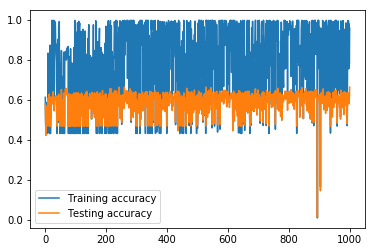

In [19]:
from matplotlib import pyplot as plt 
%matplotlib inline 
x_list =range(len(train_acc_list))

plt.plot(x_list, train_acc_list, label='Training accuracy')
plt.plot(x_list, test_acc_list, label='Testing accuracy')
plt.legend()
plt.show()

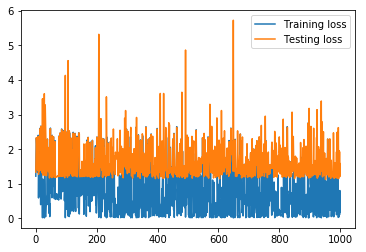

In [20]:
plt.plot(x_list, train_loss_list, label='Training loss')
plt.plot(x_list, test_loss_list, label='Testing loss')
plt.legend()
plt.show()